Importing Packages

In [462]:
import numpy as np 
import pandas as pd
import xgboost as xgb

In [463]:
np.random.seed(0)

In [464]:
application_train = pd.read_csv('application_train.csv', delimiter=',')
display(application_train.shape)

(307511, 122)

In [465]:
application_test = pd.read_csv('application_test.csv', delimiter=',')
display(application_test.shape)

(48744, 121)

Analysing Class Imbalance

In [466]:
rejected_applications_df = application_train[(application_train['TARGET'] == 1)] # Risk detected in loan application, hence reject it.
accepted_applications_df = application_train[(application_train['TARGET'] == 0)] #No Risk

print("Rejected Applications in Trainset: ", len(rejected_applications_df))
print("Accepted Applications in Trainset: ", len(accepted_applications_df))

Rejected Applications in Trainset:  24825
Accepted Applications in Trainset:  282686


In [467]:
# Dataframe without any na values
accepted_without_na = accepted_applications_df.dropna()
accepted_without_na.shape

(8076, 122)

In [468]:
# DF with Na values 
accepted_with_na = accepted_applications_df[accepted_applications_df.isna().any(axis='columns')]
accepted_with_na.shape

(274610, 122)

In [469]:
# Take remaining rows from accepted_applications_sampled

remaining = 100000 - (len(rejected_applications_df) + len(accepted_without_na))
print(remaining)

accepted_sampled_na = accepted_with_na.sample(n = remaining+1, random_state=0)
accepted_sampled_na.shape

67099


(67100, 122)

In [470]:
# train_df[train_df["CODE_GENDER"] == "XNA"].index

In [471]:
# # drop_xna_index = train_df[train_df["CODE_GENDER"] == "XNA"].index
# drop_xna_index

In [472]:
train_df = pd.concat([rejected_applications_df, accepted_without_na, accepted_sampled_na ], ignore_index=True)

#Shuffle
train_df = train_df.sample(frac=1).reset_index(drop=True)

#Sort
train_df.sort_values(by=['SK_ID_CURR'],inplace = True,ignore_index=True)


# Dropping Extra Gender

train_df.drop(index = train_df[train_df["CODE_GENDER"] == "XNA"].index, inplace = True)

display(train_df.shape)

(100000, 122)

In [473]:
test_df = application_test.iloc[:1000,:]
test_df.shape

(1000, 121)

Feature Selection

Missing Values

In [474]:
col = application_train.columns

#List of all features containing null values
features_with_na = []

#Checking for NaN
for i in range(len(col)):
    check_for_nan = application_train[col[i]].isnull().values.any()
    if check_for_nan == True: 
        features_with_na.append(col[i])

# print("Features containing Null values: ")
# print('\n')
# print(features_with_na)
# print('\n')

#Calculating the percentage of NaN values
inconsistent_features = []
for i in features_with_na:
#     print(i) 
    percent_missing = 100*application_train[i].isnull().sum() / application_train.shape[0]
    
#     print ('Percentage of NaN: ' , round(percent_missing,2),"%")
#     print('\n')
    if percent_missing > 25:
#         print(i) 
#         print ('Percentage of NaN: ' , round(percent_missing,2),"%")
#         print('\n')
        inconsistent_features.append(i)
# print('\n')

print("Num of features with atleast 1 NaN value: ", len(features_with_na))
print("Num of features with more than 25% of missing values : ", len(inconsistent_features))

Num of features with atleast 1 NaN value:  67
Num of features with more than 25% of missing values :  50


In [475]:
inconsistent_features

['OWN_CAR_AGE',
 'OCCUPATION_TYPE',
 'EXT_SOURCE_1',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BEGINEXPLUATATION_AVG',
 'YEARS_BUILD_AVG',
 'COMMONAREA_AVG',
 'ELEVATORS_AVG',
 'ENTRANCES_AVG',
 'FLOORSMAX_AVG',
 'FLOORSMIN_AVG',
 'LANDAREA_AVG',
 'LIVINGAPARTMENTS_AVG',
 'LIVINGAREA_AVG',
 'NONLIVINGAPARTMENTS_AVG',
 'NONLIVINGAREA_AVG',
 'APARTMENTS_MODE',
 'BASEMENTAREA_MODE',
 'YEARS_BEGINEXPLUATATION_MODE',
 'YEARS_BUILD_MODE',
 'COMMONAREA_MODE',
 'ELEVATORS_MODE',
 'ENTRANCES_MODE',
 'FLOORSMAX_MODE',
 'FLOORSMIN_MODE',
 'LANDAREA_MODE',
 'LIVINGAPARTMENTS_MODE',
 'LIVINGAREA_MODE',
 'NONLIVINGAPARTMENTS_MODE',
 'NONLIVINGAREA_MODE',
 'APARTMENTS_MEDI',
 'BASEMENTAREA_MEDI',
 'YEARS_BEGINEXPLUATATION_MEDI',
 'YEARS_BUILD_MEDI',
 'COMMONAREA_MEDI',
 'ELEVATORS_MEDI',
 'ENTRANCES_MEDI',
 'FLOORSMAX_MEDI',
 'FLOORSMIN_MEDI',
 'LANDAREA_MEDI',
 'LIVINGAPARTMENTS_MEDI',
 'LIVINGAREA_MEDI',
 'NONLIVINGAPARTMENTS_MEDI',
 'NONLIVINGAREA_MEDI',
 'FONDKAPREMONT_MODE',
 'HOUSETYPE_MO

As the relevant feature is just "OCCUPATION_TYPE" which describes the occupation of an individual, we will keep this feature and remove the rest. 

In [476]:
inconsistent_features.remove('OCCUPATION_TYPE')
inconsistent_features

train_df.drop(columns = inconsistent_features,inplace = True)
train_df.shape

(100000, 73)

In [477]:
test_df.drop(columns = inconsistent_features,inplace = True)
test_df.shape

(1000, 72)

Dropping Inexplanaible features

In [478]:
train_df.columns

Index(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'NAME_TYPE_SUITE',
       'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS',
       'NAME_HOUSING_TYPE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'FLAG_MOBIL',
       'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE',
       'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS',
       'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY',
       'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START',
       'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION',
       'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY',
       'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY',
       'ORGANIZATION_TYPE', 'EXT_SOURCE_2', 'EXT_SOURCE_3',
       'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_C

In [479]:
inexplanaible_features = ['EXT_SOURCE_2', "EXT_SOURCE_3",'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3',
       'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6',
       'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9',
       'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12',
       'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15',
       'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18',
       'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21']

In [480]:
# inexplanaible_features = ['EXT_SOURCE_2', "EXT_SOURCE_3"]

train_df.drop(columns = inexplanaible_features,inplace = True)
display(train_df.shape)
test_df.drop(columns = inexplanaible_features,inplace = True)
display(test_df.shape)

(100000, 51)

(1000, 50)

Converting Days Features

In [481]:
train_df.columns

Index(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'NAME_TYPE_SUITE',
       'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS',
       'NAME_HOUSING_TYPE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'FLAG_MOBIL',
       'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE',
       'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS',
       'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY',
       'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START',
       'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION',
       'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY',
       'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY',
       'ORGANIZATION_TYPE', 'OBS_30_CNT_SOCIAL_CIRCLE',
       'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_S

In [482]:
train_df["DAYS_BIRTH"] = round(train_df["DAYS_BIRTH"]/-365)
train_df["DAYS_EMPLOYED"] = round(train_df["DAYS_EMPLOYED"]/-365)
train_df["DAYS_REGISTRATION"] = round(train_df["DAYS_REGISTRATION"]/-365)
train_df["DAYS_ID_PUBLISH"] = round(train_df["DAYS_ID_PUBLISH"]/-365)
train_df["DAYS_LAST_PHONE_CHANGE"] = round(train_df["DAYS_LAST_PHONE_CHANGE"]/-365)

test_df["DAYS_BIRTH"] = round(test_df["DAYS_BIRTH"]/-365)
test_df["DAYS_EMPLOYED"] = round(test_df["DAYS_EMPLOYED"]/-365)
test_df["DAYS_REGISTRATION"] = round(test_df["DAYS_REGISTRATION"]/-365)
test_df["DAYS_ID_PUBLISH"] = round(test_df["DAYS_ID_PUBLISH"]/-365)
test_df["DAYS_LAST_PHONE_CHANGE"] = round(test_df["DAYS_LAST_PHONE_CHANGE"]/-365)

In [483]:
train_df.rename(columns={'DAYS_BIRTH':'AGE','DAYS_EMPLOYED': 'YEARS_EMPLOYED',
                             'DAYS_REGISTRATION':"YEARS_REGISTRATION" , 'DAYS_ID_PUBLISH':'YEARS_ID_PUBLISH', 
                              'DAYS_LAST_PHONE_CHANGE':"YEARS_LAST_PHONE_CHANGE"}, inplace=True)

test_df.rename(columns={'DAYS_BIRTH':'AGE','DAYS_EMPLOYED': 'YEARS_EMPLOYED',
                             'DAYS_REGISTRATION':"YEARS_REGISTRATION" , 'DAYS_ID_PUBLISH':'YEARS_ID_PUBLISH', 
                              'DAYS_LAST_PHONE_CHANGE':"YEARS_LAST_PHONE_CHANGE"}, inplace=True)

In [484]:
test_df.columns

Index(['SK_ID_CURR', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR',
       'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT',
       'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE',
       'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
       'REGION_POPULATION_RELATIVE', 'AGE', 'YEARS_EMPLOYED',
       'YEARS_REGISTRATION', 'YEARS_ID_PUBLISH', 'FLAG_MOBIL',
       'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE',
       'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS',
       'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY',
       'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START',
       'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION',
       'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY',
       'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY',
       'ORGANIZATION_TYPE', 'OBS_30_CNT_SOCIAL_CIRCLE',
       'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE',

## Converting Detected Risk to application Selected/ Rejected

In [485]:
train_df

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,YEARS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,2.0,2.0,2.0,3.0,0.0,0.0,0.0,0.0,0.0,1.0
1,100009,0,Cash loans,F,Y,Y,1,171000.0,1560726.0,41301.0,...,0.0,1.0,0.0,4.0,0.0,0.0,0.0,1.0,1.0,2.0
2,100018,0,Cash loans,F,N,Y,0,189000.0,773680.5,32778.0,...,0.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
3,100019,0,Cash loans,M,Y,Y,0,157500.0,299772.0,20160.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,1.0
4,100023,0,Cash loans,F,N,Y,1,90000.0,544491.0,17563.5,...,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99996,456238,0,Cash loans,M,Y,N,1,270000.0,479700.0,46858.5,...,0.0,11.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
99997,456244,0,Cash loans,F,N,Y,0,261000.0,1303812.0,35982.0,...,0.0,0.0,0.0,4.0,0.0,0.0,0.0,1.0,0.0,5.0
99998,456252,0,Cash loans,F,N,Y,0,72000.0,269550.0,12001.5,...,0.0,0.0,0.0,-0.0,NaN,NaN,NaN,NaN,NaN,NaN
99999,456253,0,Cash loans,F,N,Y,0,153000.0,677664.0,29979.0,...,0.0,6.0,0.0,5.0,1.0,0.0,0.0,1.0,0.0,1.0


In [486]:
train_df.replace({'TARGET' : {0:1, 1:0} },inplace=True)

In [487]:
train_df

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,YEARS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,0,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,2.0,2.0,2.0,3.0,0.0,0.0,0.0,0.0,0.0,1.0
1,100009,1,Cash loans,F,Y,Y,1,171000.0,1560726.0,41301.0,...,0.0,1.0,0.0,4.0,0.0,0.0,0.0,1.0,1.0,2.0
2,100018,1,Cash loans,F,N,Y,0,189000.0,773680.5,32778.0,...,0.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
3,100019,1,Cash loans,M,Y,Y,0,157500.0,299772.0,20160.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,1.0
4,100023,1,Cash loans,F,N,Y,1,90000.0,544491.0,17563.5,...,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99996,456238,1,Cash loans,M,Y,N,1,270000.0,479700.0,46858.5,...,0.0,11.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
99997,456244,1,Cash loans,F,N,Y,0,261000.0,1303812.0,35982.0,...,0.0,0.0,0.0,4.0,0.0,0.0,0.0,1.0,0.0,5.0
99998,456252,1,Cash loans,F,N,Y,0,72000.0,269550.0,12001.5,...,0.0,0.0,0.0,-0.0,NaN,NaN,NaN,NaN,NaN,NaN
99999,456253,1,Cash loans,F,N,Y,0,153000.0,677664.0,29979.0,...,0.0,6.0,0.0,5.0,1.0,0.0,0.0,1.0,0.0,1.0


Imputation

Imputing Categorical Columns

In [488]:
train_df_cat = train_df.select_dtypes(exclude=["number"])
train_df_cat.fillna("Unknown", inplace = True)

In [489]:
test_df_cat = test_df.select_dtypes(exclude=["number"])
test_df_cat.fillna("Unknown", inplace = True)

In [490]:
train_df_cat.shape

(100000, 12)

In [491]:
test_df_cat.shape

(1000, 12)

In [492]:
for i in range(len(train_df_cat.columns)):
    print(train_df_cat.columns[i])
    
# List of Columns before Encoding
initial_columns = train_df_cat.columns

NAME_CONTRACT_TYPE
CODE_GENDER
FLAG_OWN_CAR
FLAG_OWN_REALTY
NAME_TYPE_SUITE
NAME_INCOME_TYPE
NAME_EDUCATION_TYPE
NAME_FAMILY_STATUS
NAME_HOUSING_TYPE
OCCUPATION_TYPE
WEEKDAY_APPR_PROCESS_START
ORGANIZATION_TYPE


Label Encoding

In [493]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

for i in range(len(train_df_cat.columns)):
    print(train_df_cat.columns[i])
    train_df_cat[str(train_df_cat.columns[i]) + "_LE"] = le.fit_transform(train_df_cat[train_df_cat.columns[i]])
    test_df_cat[str(test_df_cat.columns[i]) + "_LE"] = le.fit_transform(test_df_cat[train_df_cat.columns[i]])

NAME_CONTRACT_TYPE
CODE_GENDER
FLAG_OWN_CAR
FLAG_OWN_REALTY
NAME_TYPE_SUITE
NAME_INCOME_TYPE
NAME_EDUCATION_TYPE
NAME_FAMILY_STATUS
NAME_HOUSING_TYPE
OCCUPATION_TYPE
WEEKDAY_APPR_PROCESS_START
ORGANIZATION_TYPE


In [494]:
train_df_cat

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,...,FLAG_OWN_CAR_LE,FLAG_OWN_REALTY_LE,NAME_TYPE_SUITE_LE,NAME_INCOME_TYPE_LE,NAME_EDUCATION_TYPE_LE,NAME_FAMILY_STATUS_LE,NAME_HOUSING_TYPE_LE,OCCUPATION_TYPE_LE,WEEKDAY_APPR_PROCESS_START_LE,ORGANIZATION_TYPE_LE
0,Cash loans,M,N,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Laborers,...,0,1,6,7,4,3,1,8,6,5
1,Cash loans,F,Y,Y,Unaccompanied,Commercial associate,Higher education,Married,House / apartment,Accountants,...,1,1,6,1,1,1,1,0,3,5
2,Cash loans,F,N,Y,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,Laborers,...,0,1,6,7,4,1,1,8,1,53
3,Cash loans,M,Y,Y,Family,Working,Secondary / secondary special,Single / not married,Rented apartment,Laborers,...,1,1,1,7,4,3,4,8,2,4
4,Cash loans,F,N,Y,Unaccompanied,State servant,Higher education,Single / not married,House / apartment,Core staff,...,0,1,6,4,1,3,1,3,1,28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99996,Cash loans,M,Y,N,Family,Commercial associate,Secondary / secondary special,Married,House / apartment,Drivers,...,1,0,1,1,4,1,1,4,1,42
99997,Cash loans,F,N,Y,Unaccompanied,Working,Higher education,Married,House / apartment,Unknown,...,0,1,6,7,1,1,1,17,0,5
99998,Cash loans,F,N,Y,Unaccompanied,Pensioner,Secondary / secondary special,Widow,House / apartment,Unknown,...,0,1,6,3,4,4,1,17,1,57
99999,Cash loans,F,N,Y,Unaccompanied,Working,Higher education,Separated,House / apartment,Managers,...,0,1,6,7,1,2,1,10,4,39


In [495]:
test_df_cat

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,...,FLAG_OWN_CAR_LE,FLAG_OWN_REALTY_LE,NAME_TYPE_SUITE_LE,NAME_INCOME_TYPE_LE,NAME_EDUCATION_TYPE_LE,NAME_FAMILY_STATUS_LE,NAME_HOUSING_TYPE_LE,OCCUPATION_TYPE_LE,WEEKDAY_APPR_PROCESS_START_LE,ORGANIZATION_TYPE_LE
0,Cash loans,F,N,Y,Unaccompanied,Working,Higher education,Married,House / apartment,Unknown,...,0,1,6,3,0,1,1,17,5,20
1,Cash loans,M,N,Y,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,Low-skill Laborers,...,0,1,6,3,3,1,1,9,0,32
2,Cash loans,M,Y,Y,Unknown,Working,Higher education,Married,House / apartment,Drivers,...,1,1,7,3,0,1,1,4,1,41
3,Cash loans,F,N,Y,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,Sales staff,...,0,1,6,3,3,1,1,14,6,5
4,Cash loans,M,Y,N,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,Unknown,...,1,0,6,3,3,1,1,17,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,Cash loans,M,Y,Y,Unaccompanied,Commercial associate,Higher education,Single / not married,House / apartment,Core staff,...,1,1,6,0,0,3,1,3,1,34
996,Cash loans,M,N,Y,Unknown,State servant,Higher education,Married,House / apartment,Core staff,...,0,1,7,2,0,1,1,3,1,25
997,Cash loans,M,Y,N,Unaccompanied,Commercial associate,Secondary / secondary special,Single / not married,Rented apartment,High skill tech staff,...,1,0,6,0,3,3,4,6,1,5
998,Cash loans,F,N,Y,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,Sales staff,...,0,1,6,3,3,0,1,14,5,5


Imputing Numerical Columns

In [496]:
train_df_num = train_df.select_dtypes(include=["number"])
train_df_num.fillna(train_df_num.mean(), inplace = True)
train_df_num

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,AGE,YEARS_EMPLOYED,...,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,YEARS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,0,0,202500.0,406597.5,24700.5,351000.0,0.018801,26.0,2.0,...,2.0,2.0,2.0,3.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
1,100009,1,1,171000.0,1560726.0,41301.0,1395000.0,0.035792,38.0,9.0,...,0.0,1.0,0.0,4.0,0.000000,0.000000,0.000000,1.000000,1.000000,2.000000
2,100018,1,0,189000.0,773680.5,32778.0,679500.0,0.010006,40.0,1.0,...,0.0,0.0,0.0,1.0,0.006287,0.006979,0.035575,0.264578,0.262767,1.906563
3,100019,1,0,157500.0,299772.0,20160.0,247500.0,0.020713,24.0,3.0,...,0.0,0.0,0.0,3.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
4,100023,1,1,90000.0,544491.0,17563.5,454500.0,0.015221,31.0,6.0,...,0.0,0.0,0.0,5.0,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99996,456238,1,1,270000.0,479700.0,46858.5,450000.0,0.035792,41.0,18.0,...,0.0,11.0,0.0,1.0,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
99997,456244,1,0,261000.0,1303812.0,35982.0,1138500.0,0.031329,56.0,15.0,...,0.0,0.0,0.0,4.0,0.000000,0.000000,0.000000,1.000000,0.000000,5.000000
99998,456252,1,0,72000.0,269550.0,12001.5,225000.0,0.025164,57.0,-1001.0,...,0.0,0.0,0.0,-0.0,0.006287,0.006979,0.035575,0.264578,0.262767,1.906563
99999,456253,1,0,153000.0,677664.0,29979.0,585000.0,0.005002,41.0,22.0,...,0.0,6.0,0.0,5.0,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000


In [497]:
test_df_num = test_df.select_dtypes(include=["number"])
test_df_num.fillna(test_df_num.mean(), inplace = True)
test_df_num

,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,AGE,YEARS_EMPLOYED,YEARS_REGISTRATION,...,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,YEARS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,0,135000.0,568800.0,20560.5,450000.0,0.018850,53.0,6.0,14.0,...,0.0,0.0,0.0,5.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,100005,0,99000.0,222768.0,17370.0,180000.0,0.035792,49.0,12.0,25.0,...,0.0,0.0,0.0,-0.0,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
2,100013,0,202500.0,663264.0,69777.0,630000.0,0.019101,55.0,12.0,6.0,...,0.0,0.0,0.0,2.0,0.000000,0.000000,0.000000,0.000000,1.000000,4.000000
3,100028,2,315000.0,1575000.0,49018.5,1575000.0,0.026392,38.0,5.0,5.0,...,0.0,0.0,0.0,5.0,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
4,100038,1,180000.0,625500.0,32067.0,625500.0,0.010032,36.0,6.0,11.0,...,0.0,0.0,0.0,2.0,0.003382,0.001127,0.001127,0.006764,0.529876,1.952649
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,106851,0,297000.0,790830.0,52978.5,675000.0,0.011657,36.0,1.0,2.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,2.000000
996,106852,2,225000.0,177768.0,14175.0,135000.0,0.003069,31.0,6.0,14.0,...,0.0,3.0,0.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
997,106853,0,202500.0,479700.0,49153.5,450000.0,0.018209,30.0,1.0,4.0,...,0.0,0.0,0.0,2.0,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
998,106854,0,202500.0,574402.5,29457.0,495859.5,0.018634,31.0,1.0,16.0,...,0.0,0.0,0.0,3.0,0.000000,0.000000,0.000000,0.000000,1.000000,3.000000


In [498]:
train_df_num.columns

Index(['SK_ID_CURR', 'TARGET', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       'REGION_POPULATION_RELATIVE', 'AGE', 'YEARS_EMPLOYED',
       'YEARS_REGISTRATION', 'YEARS_ID_PUBLISH', 'FLAG_MOBIL',
       'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE',
       'FLAG_EMAIL', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT',
       'REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START',
       'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION',
       'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY',
       'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY',
       'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE',
       'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE',
       'YEARS_LAST_PHONE_CHANGE', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_YEAR

In [499]:
a = test_df_num['AGE']
a.max()

68.0

In [500]:
train_df_cat["ORGANIZATION_TYPE_LE"].max()

57

In [501]:
a = test_df_num['AMT_INCOME_TOTAL']/10000
a.max()

135.0

Normalisation

In [502]:
absurdly_high_value_features = ['AMT_INCOME_TOTAL','AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE']

In [503]:
for i in absurdly_high_value_features: 
    
    train_df_num[i] = round(train_df_num[i]/10000)
    test_df_num[i] = round(test_df_num[i]/10000)

In [504]:
train_df.columns

Index(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'NAME_TYPE_SUITE',
       'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS',
       'NAME_HOUSING_TYPE', 'REGION_POPULATION_RELATIVE', 'AGE',
       'YEARS_EMPLOYED', 'YEARS_REGISTRATION', 'YEARS_ID_PUBLISH',
       'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE',
       'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS',
       'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY',
       'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START',
       'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION',
       'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY',
       'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY',
       'ORGANIZATION_TYPE', 'OBS_30_CNT_SOCIAL_CIRCLE',
       'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIA

In [505]:
train_df_new = pd.concat([train_df_num, train_df_cat], axis=1)

In [506]:
train_df_new

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,AGE,YEARS_EMPLOYED,...,FLAG_OWN_CAR_LE,FLAG_OWN_REALTY_LE,NAME_TYPE_SUITE_LE,NAME_INCOME_TYPE_LE,NAME_EDUCATION_TYPE_LE,NAME_FAMILY_STATUS_LE,NAME_HOUSING_TYPE_LE,OCCUPATION_TYPE_LE,WEEKDAY_APPR_PROCESS_START_LE,ORGANIZATION_TYPE_LE
0,100002,0,0,20.0,41.0,2.0,35.0,0.018801,26.0,2.0,...,0,1,6,7,4,3,1,8,6,5
1,100009,1,1,17.0,156.0,4.0,140.0,0.035792,38.0,9.0,...,1,1,6,1,1,1,1,0,3,5
2,100018,1,0,19.0,77.0,3.0,68.0,0.010006,40.0,1.0,...,0,1,6,7,4,1,1,8,1,53
3,100019,1,0,16.0,30.0,2.0,25.0,0.020713,24.0,3.0,...,1,1,1,7,4,3,4,8,2,4
4,100023,1,1,9.0,54.0,2.0,45.0,0.015221,31.0,6.0,...,0,1,6,4,1,3,1,3,1,28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99996,456238,1,1,27.0,48.0,5.0,45.0,0.035792,41.0,18.0,...,1,0,1,1,4,1,1,4,1,42
99997,456244,1,0,26.0,130.0,4.0,114.0,0.031329,56.0,15.0,...,0,1,6,7,1,1,1,17,0,5
99998,456252,1,0,7.0,27.0,1.0,22.0,0.025164,57.0,-1001.0,...,0,1,6,3,4,4,1,17,1,57
99999,456253,1,0,15.0,68.0,3.0,58.0,0.005002,41.0,22.0,...,0,1,6,7,1,2,1,10,4,39


In [507]:
test_df_new = pd.concat([test_df_num, test_df_cat], axis=1)

In [508]:
test_df_new

,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,AGE,YEARS_EMPLOYED,YEARS_REGISTRATION,...,FLAG_OWN_CAR_LE,FLAG_OWN_REALTY_LE,NAME_TYPE_SUITE_LE,NAME_INCOME_TYPE_LE,NAME_EDUCATION_TYPE_LE,NAME_FAMILY_STATUS_LE,NAME_HOUSING_TYPE_LE,OCCUPATION_TYPE_LE,WEEKDAY_APPR_PROCESS_START_LE,ORGANIZATION_TYPE_LE
0,100001,0,14.0,57.0,2.0,45.0,0.018850,53.0,6.0,14.0,...,0,1,6,3,0,1,1,17,5,20
1,100005,0,10.0,22.0,2.0,18.0,0.035792,49.0,12.0,25.0,...,0,1,6,3,3,1,1,9,0,32
2,100013,0,20.0,66.0,7.0,63.0,0.019101,55.0,12.0,6.0,...,1,1,7,3,0,1,1,4,1,41
3,100028,2,32.0,158.0,5.0,158.0,0.026392,38.0,5.0,5.0,...,0,1,6,3,3,1,1,14,6,5
4,100038,1,18.0,63.0,3.0,63.0,0.010032,36.0,6.0,11.0,...,1,0,6,3,3,1,1,17,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,106851,0,30.0,79.0,5.0,68.0,0.011657,36.0,1.0,2.0,...,1,1,6,0,0,3,1,3,1,34
996,106852,2,22.0,18.0,1.0,14.0,0.003069,31.0,6.0,14.0,...,0,1,7,2,0,1,1,3,1,25
997,106853,0,20.0,48.0,5.0,45.0,0.018209,30.0,1.0,4.0,...,1,0,6,0,3,3,4,6,1,5
998,106854,0,20.0,57.0,3.0,50.0,0.018634,31.0,1.0,16.0,...,0,1,6,3,3,0,1,14,5,5


In [509]:
# Drop encoded columns
train_df_final = train_df_new.drop(columns = initial_columns)
train_df_final.drop(columns = ["SK_ID_CURR"],inplace = True)
train_df_final.shape

(100000, 50)

In [510]:
test_df_final = test_df_new.drop(columns = initial_columns)
test_df_final.drop(columns = ["SK_ID_CURR"],inplace = True)
test_df_final.shape

(1000, 49)

Final Shapes

In [511]:
train_df_final.shape

(100000, 50)

In [512]:
test_df_final.shape

(1000, 49)

Train Test Split

In [513]:
#Splitting of independent and dependent variable
X = train_df_final.loc[:, train_df_final.columns != 'TARGET']
y = train_df_final.loc[:, train_df_final.columns == 'TARGET']

display(X.shape)
display(y.shape)

(100000, 49)

(100000, 1)

Train-Test Validation Split

In [514]:
from sklearn.model_selection import train_test_split

X_train_original, X_test_original,y_train_original, y_test_original = train_test_split(X,y, test_size = 0.3, random_state = 15,shuffle=True)

print(X.shape)

print("Trainning and Validation Set for X", X_train_original.shape)
print("Trainning and Validation Set for y",y_train_original.shape)
print("Test Set for X",X_test_original.shape)
print("Test Set for y",y_test_original.shape)

(100000, 49)
Trainning and Validation Set for X (70000, 49)
Trainning and Validation Set for y (70000, 1)
Test Set for X (30000, 49)
Test Set for y (30000, 1)


Assigning Class weights

In [515]:
from sklearn.utils import class_weight

classes_weights = class_weight.compute_sample_weight(
    class_weight='balanced',
    y = y_train_original
)
classes_weights

array([0.66388467, 0.66388467, 2.02546296, ..., 0.66388467, 0.66388467,
       2.02546296])

Model Trainning (XGBOOST)

In [516]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

model = XGBClassifier(random_state = 15, eta = 0.3)

model.fit(X_train_original, y_train_original, sample_weight=classes_weights)

[20:48:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\user\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\user\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\use

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eta=0.3, gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=12,
              num_parallel_tree=1, predictor='auto', random_state=15,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

Model Results

Trainning Set Results

In [517]:
y_pred = model.predict(X_train_original)
predictions = [round(value) for value in y_pred]

# evaluate predictions
accuracy = accuracy_score(y_train_original, predictions)
print("Training Set Accuracy: %.2f%%" % (accuracy * 100.0))

Training Set Accuracy: 75.17%


In [518]:
y_pred = model.predict(X_test_original)
predictions = [round(value) for value in y_pred]

# evaluate predictions
accuracy = accuracy_score(y_test_original, predictions)
print("TestSet Set Accuracy: %.2f%%" % (accuracy * 100.0))

TestSet Set Accuracy: 66.58%


C:\Users\user\anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


## Test Predictions

In [519]:
y_pred_test = model.predict(test_df_final)
predictions_test = [round(value) for value in y_pred_test]

C:\Users\user\anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


In [520]:
predictions_test

[1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,


In [521]:
# test_df.drop(columns = ["Predicted_Result","Prediction_Confidence_Accepted","Prediction_Confidence_Rejected"], inplace=True)

In [522]:
test_df.insert(loc=1, column="Predicted_Result", value=predictions_test)
# test_df["Predicted_Result"] = predictions_test

# Labels
test_df.replace({'Predicted_Result' : { 0 : 'Rejected', 1:  'Accepted'}},inplace=True)

# Prediction Confidence

accepted = []
rejected = []
for i in range(len(test_df_final)):
    accepted.append(round(100 * model.predict_proba(test_df_final)[i][1],3))
    rejected.append(round(100 * model.predict_proba(test_df_final)[i][0],3))
    

test_df.insert(loc=2, column="Prediction_Confidence_Accepted", value=accepted)
test_df.insert(loc=3, column="Prediction_Confidence_Rejected", value=rejected)

test_df

C:\Users\user\anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


,SK_ID_CURR,Predicted_Result,Prediction_Confidence_Accepted,Prediction_Confidence_Rejected,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,...,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,YEARS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Accepted,83.560,16.440,Cash loans,F,N,Y,0,135000.0,...,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Accepted,57.415,42.585,Cash loans,M,N,Y,0,99000.0,...,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Accepted,98.342,1.658,Cash loans,M,Y,Y,0,202500.0,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Accepted,71.770,28.230,Cash loans,F,N,Y,2,315000.0,...,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Rejected,48.065,51.935,Cash loans,M,Y,N,1,180000.0,...,0.0,0.0,0.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,106851,Accepted,92.030,7.970,Cash loans,M,Y,Y,0,297000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0
996,106852,Accepted,83.939,16.061,Cash loans,M,N,Y,2,225000.0,...,0.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0
997,106853,Rejected,26.817,73.183,Cash loans,M,Y,N,0,202500.0,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,1.0
998,106854,Rejected,41.689,58.311,Cash loans,F,N,Y,0,202500.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,1.0,3.0


In [523]:
test_df

,SK_ID_CURR,Predicted_Result,Prediction_Confidence_Accepted,Prediction_Confidence_Rejected,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,...,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,YEARS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Accepted,83.560,16.440,Cash loans,F,N,Y,0,135000.0,...,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Accepted,57.415,42.585,Cash loans,M,N,Y,0,99000.0,...,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Accepted,98.342,1.658,Cash loans,M,Y,Y,0,202500.0,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Accepted,71.770,28.230,Cash loans,F,N,Y,2,315000.0,...,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Rejected,48.065,51.935,Cash loans,M,Y,N,1,180000.0,...,0.0,0.0,0.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,106851,Accepted,92.030,7.970,Cash loans,M,Y,Y,0,297000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0
996,106852,Accepted,83.939,16.061,Cash loans,M,N,Y,2,225000.0,...,0.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0
997,106853,Rejected,26.817,73.183,Cash loans,M,Y,N,0,202500.0,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,1.0
998,106854,Rejected,41.689,58.311,Cash loans,F,N,Y,0,202500.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,1.0,3.0


In [524]:
test_df.replace({'NAME_CONTRACT_TYPE' : { 'Cash loans' :'Fixed', 'Revolving loans' : 'Not Fixed'}},inplace=True)

test_df.replace({'FLAG_OWN_CAR' : { "N" :'No', "Y" : 'Yes'}},inplace=True)

test_df.replace({'FLAG_OWN_REALTY' : { "N" :'No', "Y" : 'Yes'}},inplace=True)


test_df.replace({'FLAG_MOBIL' : { 0 :'No', 1 : 'Yes'}},inplace=True)

test_df.replace({'FLAG_EMP_PHONE' : { 0 :'No', 1 : 'Yes'}},inplace=True)

test_df.replace({'FLAG_WORK_PHONE' : { 0 :'No', 1 : 'Yes'}},inplace=True)

test_df.replace({'FLAG_CONT_MOBILE' : { 0 :'No', 1 : 'Yes'}},inplace=True)

test_df.replace({'FLAG_PHONE' : { 0 :'No', 1 : 'Yes'}},inplace=True)

test_df.replace({'FLAG_EMAIL' : { 0 :'No', 1 : 'Yes'}},inplace=True)


test_df.replace({'REG_REGION_NOT_LIVE_REGION' : { 0 :'Same', 1 : 'Different'}},inplace=True)

test_df.replace({'REG_REGION_NOT_WORK_REGION' : { 0 :'Same', 1 : 'Different'}},inplace=True)

test_df.replace({'LIVE_REGION_NOT_WORK_REGION' : { 0 :'Same', 1 : 'Different'}},inplace=True)

test_df.replace({'REG_CITY_NOT_LIVE_CITY' : { 0 :'Same', 1 : 'Different'}},inplace=True)

test_df.replace({'REG_CITY_NOT_WORK_CITY' : { 0 :'Same', 1 : 'Different'}},inplace=True)

test_df.replace({'LIVE_CITY_NOT_WORK_CITY' : { 0 :'Same', 1 : 'Different'}},inplace=True)

test_df.replace({'CODE_GENDER' : { "F" :'Female', "M" :'Male'}},inplace=True)

test_df.replace({'YEARS_EMPLOYED' : { -1001 :np.nan}},inplace=True)

test_df

,SK_ID_CURR,Predicted_Result,Prediction_Confidence_Accepted,Prediction_Confidence_Rejected,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,...,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,YEARS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Accepted,83.560,16.440,Fixed,Female,No,Yes,0,135000.0,...,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Accepted,57.415,42.585,Fixed,Male,No,Yes,0,99000.0,...,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Accepted,98.342,1.658,Fixed,Male,Yes,Yes,0,202500.0,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Accepted,71.770,28.230,Fixed,Female,No,Yes,2,315000.0,...,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Rejected,48.065,51.935,Fixed,Male,Yes,No,1,180000.0,...,0.0,0.0,0.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,106851,Accepted,92.030,7.970,Fixed,Male,Yes,Yes,0,297000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0
996,106852,Accepted,83.939,16.061,Fixed,Male,No,Yes,2,225000.0,...,0.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0
997,106853,Rejected,26.817,73.183,Fixed,Male,Yes,No,0,202500.0,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,1.0
998,106854,Rejected,41.689,58.311,Fixed,Female,No,Yes,0,202500.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,1.0,3.0


In [526]:
df = test_df.select_dtypes(exclude=["number"])
for col in df:
    print(df[col].unique())

['Accepted' 'Rejected']
['Fixed' 'Not Fixed']
['Female' 'Male']
['No' 'Yes']
['Yes' 'No']
['Unaccompanied' nan 'Family' 'Spouse, partner' 'Group of people'
 'Other_B' 'Children' 'Other_A']
['Working' 'State servant' 'Pensioner' 'Commercial associate']
['Higher education' 'Secondary / secondary special' 'Incomplete higher'
 'Lower secondary']
['Married' 'Single / not married' 'Civil marriage' 'Widow' 'Separated']
['House / apartment' 'With parents' 'Rented apartment'
 'Municipal apartment' 'Office apartment' 'Co-op apartment']
['Yes']
['Yes' 'No']
['No' 'Yes']
['Yes' 'No']
['No' 'Yes']
['Yes' 'No']
[nan 'Low-skill Laborers' 'Drivers' 'Sales staff' 'High skill tech staff'
 'Core staff' 'Laborers' 'Managers' 'Accountants' 'Medicine staff'
 'Security staff' 'Private service staff' 'Secretaries' 'Cleaning staff'
 'Cooking staff' 'HR staff' 'Waiters/barmen staff' 'Realty agents'
 'IT staff']
['TUESDAY' 'FRIDAY' 'MONDAY' 'WEDNESDAY' 'THURSDAY' 'SATURDAY' 'SUNDAY']
['Same' 'Different']
['Same'

In [528]:
ft_df = pd.DataFrame({"Feature_Name": model.get_booster().feature_names,
     'Importance': model.feature_importances_,
    })

# ft_df["DP_Difference"] = dp_diff_list
# ft_df["DP_Ratio"] = dp_ratio_list
# ft_df["SR"] = sr_list

ft_df = ft_df.T
ft_df.rename(columns=ft_df.iloc[0],inplace =True)


ft_df.rename(columns={'CODE_GENDER_LE':'CODE_GENDER','NAME_CONTRACT_TYPE_LE': 'NAME_CONTRACT_TYPE',
                             'FLAG_OWN_CAR_LE':"FLAG_OWN_CAR" , 'FLAG_OWN_REALTY_LE':'FLAG_OWN_REALTY', 
                              'NAME_TYPE_SUITE_LE':"NAME_TYPE_SUITE",'NAME_INCOME_TYPE_LE':"NAME_INCOME_TYPE",
                              
                              'NAME_EDUCATION_TYPE_LE': "NAME_EDUCATION_TYPE",'NAME_FAMILY_STATUS_LE':"NAME_FAMILY_STATUS",
                              'NAME_HOUSING_TYPE_LE':"NAME_HOUSING_TYPE", 'OCCUPATION_TYPE_LE':"OCCUPATION_TYPE",
                              'WEEKDAY_APPR_PROCESS_START_LE':"WEEKDAY_APPR_PROCESS_START",'ORGANIZATION_TYPE_LE':"ORGANIZATION_TYPE"
                             }, inplace=True)

In [529]:
ft_df

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,AGE,YEARS_EMPLOYED,YEARS_REGISTRATION,YEARS_ID_PUBLISH,...,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE
Feature_Name,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,AGE,YEARS_EMPLOYED,YEARS_REGISTRATION,YEARS_ID_PUBLISH,...,FLAG_OWN_CAR_LE,FLAG_OWN_REALTY_LE,NAME_TYPE_SUITE_LE,NAME_INCOME_TYPE_LE,NAME_EDUCATION_TYPE_LE,NAME_FAMILY_STATUS_LE,NAME_HOUSING_TYPE_LE,OCCUPATION_TYPE_LE,WEEKDAY_APPR_PROCESS_START_LE,ORGANIZATION_TYPE_LE
Importance,0.011163,0.01249,0.018624,0.021135,0.021002,0.012728,0.027195,0.022207,0.012555,0.017712,...,0.073489,0.011462,0.012938,0.024269,0.072344,0.01428,0.014526,0.014265,0.012101,0.012706


Value Distributions

Binning

In [530]:
test_df

,SK_ID_CURR,Predicted_Result,Prediction_Confidence_Accepted,Prediction_Confidence_Rejected,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,...,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,YEARS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Accepted,83.560,16.440,Fixed,Female,No,Yes,0,135000.0,...,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Accepted,57.415,42.585,Fixed,Male,No,Yes,0,99000.0,...,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Accepted,98.342,1.658,Fixed,Male,Yes,Yes,0,202500.0,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Accepted,71.770,28.230,Fixed,Female,No,Yes,2,315000.0,...,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Rejected,48.065,51.935,Fixed,Male,Yes,No,1,180000.0,...,0.0,0.0,0.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,106851,Accepted,92.030,7.970,Fixed,Male,Yes,Yes,0,297000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0
996,106852,Accepted,83.939,16.061,Fixed,Male,No,Yes,2,225000.0,...,0.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0
997,106853,Rejected,26.817,73.183,Fixed,Male,Yes,No,0,202500.0,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,1.0
998,106854,Rejected,41.689,58.311,Fixed,Female,No,Yes,0,202500.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,1.0,3.0


In [532]:
categorical_features = test_df.iloc[:,4:].select_dtypes(exclude=["number"]).columns
categorical_features

Index(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'FLAG_MOBIL',
       'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE',
       'FLAG_EMAIL', 'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START',
       'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION',
       'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY',
       'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY',
       'ORGANIZATION_TYPE'],
      dtype='object')

In [533]:
test_df.iloc[:,4:].select_dtypes(include=["number"])

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,AGE,YEARS_EMPLOYED,YEARS_REGISTRATION,YEARS_ID_PUBLISH,...,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,YEARS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,0,135000.0,568800.0,20560.5,450000.0,0.018850,53.0,6.0,14.0,2.0,...,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,99000.0,222768.0,17370.0,180000.0,0.035792,49.0,12.0,25.0,4.0,...,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,3.0
2,0,202500.0,663264.0,69777.0,630000.0,0.019101,55.0,12.0,6.0,10.0,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,4.0
3,2,315000.0,1575000.0,49018.5,1575000.0,0.026392,38.0,5.0,5.0,12.0,...,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,3.0
4,1,180000.0,625500.0,32067.0,625500.0,0.010032,36.0,6.0,11.0,12.0,...,0.0,0.0,0.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,297000.0,790830.0,52978.5,675000.0,0.011657,36.0,1.0,2.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0
996,2,225000.0,177768.0,14175.0,135000.0,0.003069,31.0,6.0,14.0,6.0,...,0.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0
997,0,202500.0,479700.0,49153.5,450000.0,0.018209,30.0,1.0,4.0,4.0,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,1.0
998,0,202500.0,574402.5,29457.0,495859.5,0.018634,31.0,1.0,16.0,10.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,1.0,3.0


In [534]:
numerical_features = test_df.iloc[:,4:].select_dtypes(include=["number"]).columns
# numerical_features

In [535]:
test_df.iloc[:,4:].columns

Index(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
       'AMT_GOODS_PRICE', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE',
       'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
       'REGION_POPULATION_RELATIVE', 'AGE', 'YEARS_EMPLOYED',
       'YEARS_REGISTRATION', 'YEARS_ID_PUBLISH', 'FLAG_MOBIL',
       'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE',
       'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS',
       'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY',
       'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START',
       'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION',
       'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY',
       'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY',
       'ORGANIZATION_TYPE', 'OBS_30_CNT_SOCIAL_CIRCLE',
       'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE',
       'DEF_6

In [536]:
dp_ratio_features = {}

1. NAME_CONTRACT_TYPE

In [537]:
test_df["NAME_CONTRACT_TYPE"].unique()

array(['Fixed', 'Not Fixed'], dtype=object)

In [538]:
from fairlearn.metrics import MetricFrame
from fairlearn.metrics import selection_rate

sr_contract_type = MetricFrame(metrics=selection_rate, y_true=predictions_test, y_pred=predictions_test, sensitive_features=test_df["NAME_CONTRACT_TYPE"])
# display(sr.overall)
display(sr_contract_type.by_group)

NAME_CONTRACT_TYPE
Fixed        0.684422
Not Fixed    0.800000
Name: selection_rate, dtype: float64

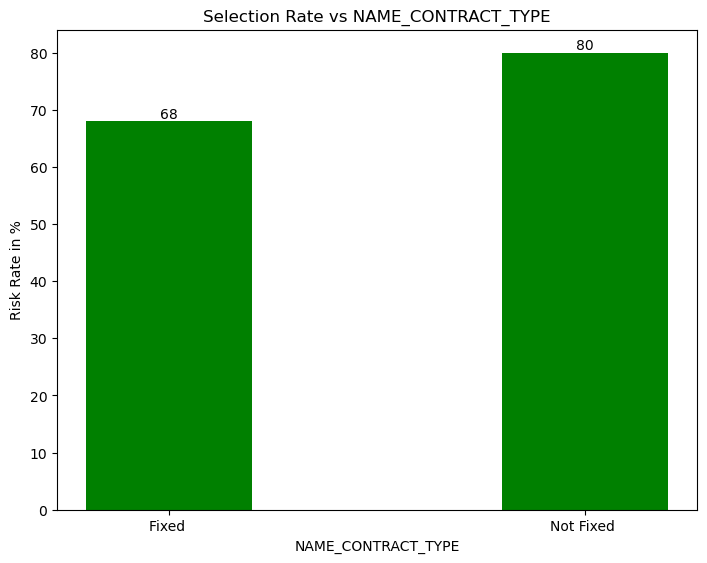

In [539]:
contract_type_risk_groups= {"Fixed " : round(100*sr_contract_type.by_group.loc["Fixed"]), 
                           "Not Fixed " : round(100*sr_contract_type.by_group.loc["Not Fixed"])}

contract_type_risk_groups

import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

bars = ax.bar(contract_type_risk_groups.keys(),contract_type_risk_groups.values(), width=0.4, color = "green")
ax.bar_label(bars)
plt.title("Selection Rate vs NAME_CONTRACT_TYPE")
plt.xlabel('NAME_CONTRACT_TYPE')
plt.ylabel('Risk Rate in %')
plt.show()

In [540]:
print("The dp difference for NAME_CONTRACT_TYPE is ", max(contract_type_risk_groups.values()) - min(contract_type_risk_groups.values()))

contract_type_dp = round(min(contract_type_risk_groups.values()) / max(contract_type_risk_groups.values()),2)
print("The dp ratio for NAME_CONTRACT_TYPE is ", contract_type_dp)

dp_ratio_features.update({"NAME_CONTRACT_TYPE": contract_type_dp})

The dp difference for NAME_CONTRACT_TYPE is  12
The dp ratio for NAME_CONTRACT_TYPE is  0.85


In [541]:
dp_ratio_features

{'NAME_CONTRACT_TYPE': 0.85}

2. CODE_GENDER

In [542]:
test_df["CODE_GENDER"].unique()

array(['Female', 'Male'], dtype=object)

In [543]:
sr_gender = MetricFrame(metrics=selection_rate, y_true=predictions_test, y_pred=predictions_test, sensitive_features=test_df["CODE_GENDER"])
# display(sr.overall)
display(sr_gender.by_group)

CODE_GENDER
Female    0.720930
Male      0.619718
Name: selection_rate, dtype: float64

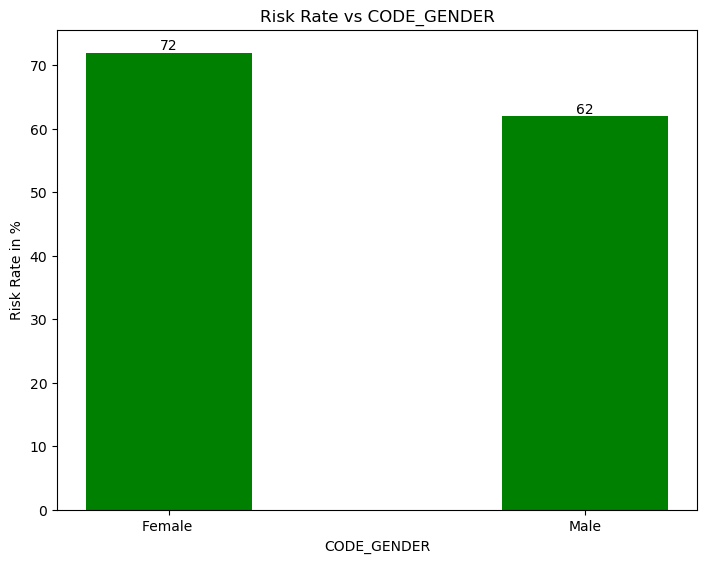

In [544]:
gender_risk_groups= {"Female " : round(100*sr_gender.by_group.loc["Female"]), 
                           "Male" : round(100*sr_gender.by_group.loc["Male"])}

gender_risk_groups

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

bars = ax.bar(gender_risk_groups.keys(),gender_risk_groups.values(), width=0.4, color = "green")
ax.bar_label(bars)
plt.title("Risk Rate vs CODE_GENDER")
plt.xlabel('CODE_GENDER')
plt.ylabel('Risk Rate in %')
plt.show()

In [545]:
print("The dp difference for CODE_GENDER is ", max(gender_risk_groups.values()) - min(gender_risk_groups.values()))

gender_dp = round(min(gender_risk_groups.values()) / max(gender_risk_groups.values()),2)
print("The dp ratio for CODE_GENDER is ", gender_dp)

dp_ratio_features.update({"CODE_GENDER": gender_dp})

The dp difference for CODE_GENDER is  10
The dp ratio for CODE_GENDER is  0.86


In [546]:
dp_ratio_features

{'NAME_CONTRACT_TYPE': 0.85, 'CODE_GENDER': 0.86}

3. FLAG_OWN_CAR

In [547]:
test_df["FLAG_OWN_CAR"].unique()

array(['No', 'Yes'], dtype=object)

In [548]:
sr_car = MetricFrame(metrics=selection_rate, y_true=predictions_test, y_pred=predictions_test, sensitive_features=test_df["FLAG_OWN_CAR"])
# display(sr.overall)
display(sr_car.by_group)

FLAG_OWN_CAR
No     0.643077
Yes    0.762857
Name: selection_rate, dtype: float64

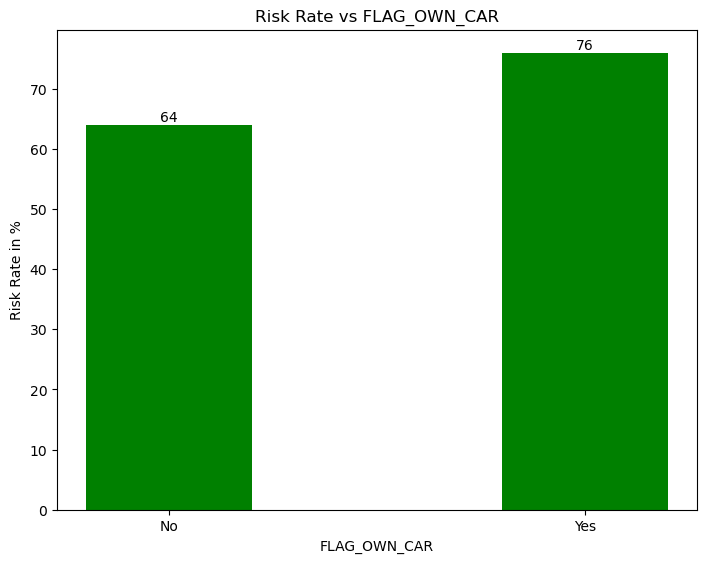

In [549]:
car_risk_groups= {"No" : round(100*sr_car.by_group.loc["No"]), 
                           "Yes" : round(100*sr_car.by_group.loc["Yes"])}

car_risk_groups

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

bars = ax.bar(car_risk_groups.keys(),car_risk_groups.values(), width=0.4, color = "green")
ax.bar_label(bars)
plt.title("Risk Rate vs FLAG_OWN_CAR")
plt.xlabel('FLAG_OWN_CAR')
plt.ylabel('Risk Rate in %')
plt.show()

In [550]:
print("The dp difference for FLAG_OWN_CAR is ", max(car_risk_groups.values()) - min(car_risk_groups.values()))

car_dp = round(min(car_risk_groups.values()) / max(car_risk_groups.values()),2)
print("The dp ratio for FLAG_OWN_CAR is ", car_dp)

dp_ratio_features.update({"FLAG_OWN_CAR": car_dp})

The dp difference for FLAG_OWN_CAR is  12
The dp ratio for FLAG_OWN_CAR is  0.84


In [551]:
dp_ratio_features

{'NAME_CONTRACT_TYPE': 0.85, 'CODE_GENDER': 0.86, 'FLAG_OWN_CAR': 0.84}

4. FLAG_OWN_REALTY

In [552]:
test_df["FLAG_OWN_REALTY"].unique()

array(['Yes', 'No'], dtype=object)

In [553]:
sr_realty = MetricFrame(metrics=selection_rate, y_true=predictions_test, y_pred=predictions_test, sensitive_features=test_df["FLAG_OWN_REALTY"])
# display(sr.overall)
display(sr_realty.by_group)

FLAG_OWN_REALTY
No     0.675000
Yes    0.689706
Name: selection_rate, dtype: float64

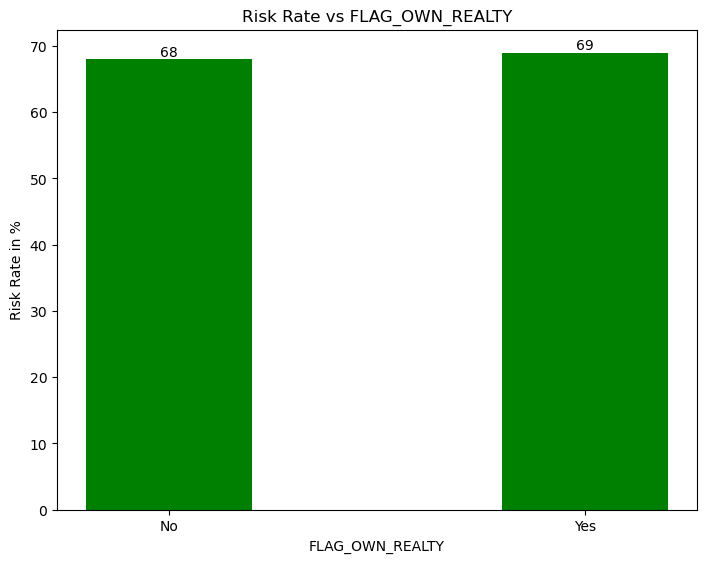

In [554]:
realty_risk_groups= {"No" : round(100*sr_realty.by_group.loc["No"]), 
                           "Yes" : round(100*sr_realty.by_group.loc["Yes"])}

realty_risk_groups

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

bars = ax.bar(realty_risk_groups.keys(),realty_risk_groups.values(), width=0.4, color = "green")
ax.bar_label(bars)
plt.title("Risk Rate vs FLAG_OWN_REALTY")
plt.xlabel('FLAG_OWN_REALTY')
plt.ylabel('Risk Rate in %')
plt.show()

In [555]:
print("The dp difference for FLAG_OWN_REALTY is ", max(realty_risk_groups.values()) - min(realty_risk_groups.values()))

realty_dp = round(min(realty_risk_groups.values()) / max(realty_risk_groups.values()),2)
print("The dp ratio for FLAG_OWN_REALTY is ", realty_dp)

dp_ratio_features.update({"FLAG_OWN_REALTY": realty_dp})

The dp difference for FLAG_OWN_REALTY is  1
The dp ratio for FLAG_OWN_REALTY is  0.99


In [556]:
dp_ratio_features

{'NAME_CONTRACT_TYPE': 0.85,
 'CODE_GENDER': 0.86,
 'FLAG_OWN_CAR': 0.84,
 'FLAG_OWN_REALTY': 0.99}

5. CNT_CHILDREN

Each Selection

In [557]:
sr_children = MetricFrame(metrics=selection_rate, y_true=predictions_test, y_pred=predictions_test, sensitive_features=test_df_final["CNT_CHILDREN"])
# display(sr.overall)
display(sr_children.by_group)

CNT_CHILDREN
0    0.698225
1    0.652174
2    0.662500
3    0.727273
4    1.000000
8    0.000000
Name: selection_rate, dtype: float64

In [558]:
less_than_2 = sr_children.by_group.loc[0:2]
three_to_five = sr_children.by_group.loc[3:5]
five_to_eight = sr_children.by_group.loc[5:8]

less_than_2_risk_rate = round(np.mean(less_than_2),2)
three_to_five_risk_rate = round(np.mean(three_to_five),2)
five_to_eight_risk_rate = round(np.mean(five_to_eight),2)


cnt_children_risk_groups= {"0-2" : 100*less_than_2_risk_rate, "3-5" : round(100*three_to_five_risk_rate), 
                  "5-8": 100*five_to_eight_risk_rate}

cnt_children_risk_groups

{'0-2': 67.0, '3-5': 86, '5-8': 0.0}

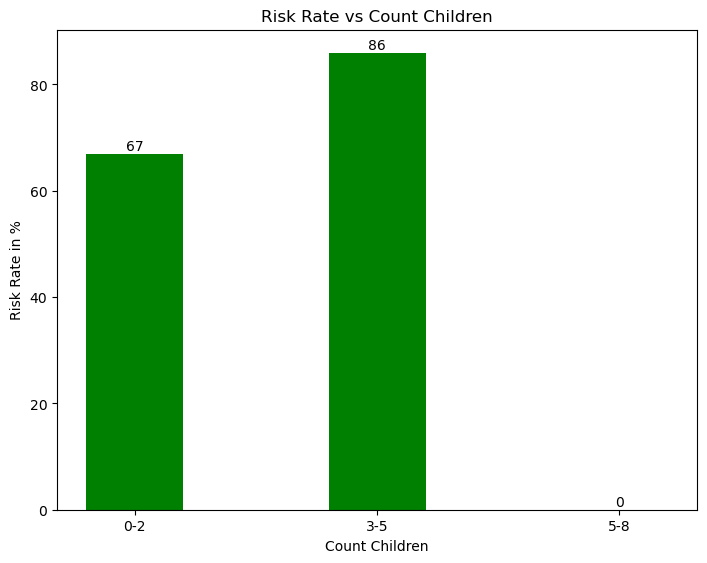

In [559]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

bars = ax.bar(cnt_children_risk_groups.keys(),cnt_children_risk_groups.values(), width=0.4, color = "green")
ax.bar_label(bars)
plt.title("Risk Rate vs Count Children")
plt.xlabel('Count Children')
plt.ylabel('Risk Rate in %')
plt.show()

In [560]:
print("The dp difference for Count Children is ", max(cnt_children_risk_groups.values()) - min(cnt_children_risk_groups.values()))

cnt_children_dp = round(min(cnt_children_risk_groups.values()) / max(cnt_children_risk_groups.values()),2)
print("The dp ratio for Count Children is ", cnt_children_dp)

dp_ratio_features.update({"CNT_CHILDREN": cnt_children_dp})

The dp difference for Count Children is  86.0
The dp ratio for Count Children is  0.0


In [561]:
dp_ratio_features

{'NAME_CONTRACT_TYPE': 0.85,
 'CODE_GENDER': 0.86,
 'FLAG_OWN_CAR': 0.84,
 'FLAG_OWN_REALTY': 0.99,
 'CNT_CHILDREN': 0.0}

6. AMT_INCOME_TOTAL

In [562]:
test_df["AMT_INCOME_TOTAL"].min(), test_df["AMT_INCOME_TOTAL"].max()

(36000.0, 1350000.0)

In [563]:
# <100,000
# 100,000 - 150,000
# 150,000 - 200,000
# 200,000 - 250,000
# >250,000

In [564]:
sr_income = MetricFrame(metrics=selection_rate, y_true=predictions_test, y_pred=predictions_test, sensitive_features=test_df["AMT_INCOME_TOTAL"])
# display(sr.overall)
display(sr_income.by_group)

AMT_INCOME_TOTAL
36000.0      1.000000
40500.0      1.000000
45000.0      0.714286
47250.0      0.000000
54000.0      0.375000
               ...   
495000.0     1.000000
540000.0     1.000000
607500.0     1.000000
675000.0     1.000000
1350000.0    1.000000
Name: selection_rate, Length: 85, dtype: float64

In [565]:
less_100k = sr_income.by_group.loc[:100000]
btw_100k_150k = sr_income.by_group.loc[100000:150000]
btw_150k_200k = sr_income.by_group.loc[150000:200000]
btw_200k_250k = sr_income.by_group.loc[200000:250000]
gt_250k = sr_income.by_group.loc[250000:]


# display(len(less_100k))
# display(len(btw_100k_150k))
# display(len(btw_150k_200k))
# display(len(btw_200k_250k))
# display(len(gt_250k))


less_100k_risk_rate = 100*round(np.mean(less_100k),2)
btw_100k_150k_risk_rate = 100*round(np.mean(btw_100k_150k),2)
btw_150k_200k_risk_rate = 100*round(np.mean(btw_150k_200k),2)
btw_200k_250k_risk_rate = 100*round(np.mean(btw_200k_250k),2)
gt_250k_risk_rate = 100*round(np.mean(gt_250k),2)


income_risk_groups= {"<100K" : round(less_100k_risk_rate), "100K-150K" : btw_100k_150k_risk_rate, 
                     "150K-200K" :  btw_150k_200k_risk_rate, "200K-250K": btw_200k_250k_risk_rate, ">250K": gt_250k_risk_rate}

income_risk_groups

{'<100K': 72,
 '100K-150K': 69.0,
 '150K-200K': 59.0,
 '200K-250K': 64.0,
 '>250K': 75.0}

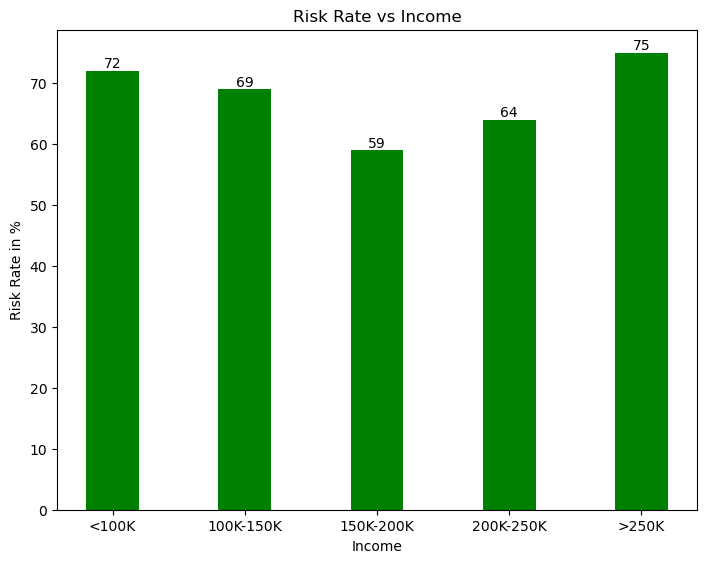

In [566]:

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

bars = ax.bar(income_risk_groups.keys(),income_risk_groups.values(), width=0.4, color = "green")
ax.bar_label(bars)
plt.title("Risk Rate vs Income")
plt.xlabel('Income')
plt.ylabel('Risk Rate in %')
plt.show()

In [567]:
print("The dp difference for Amount Income is ", max(income_risk_groups.values()) - min(income_risk_groups.values()))

income_dp = round(min(income_risk_groups.values()) / max(income_risk_groups.values()),2)
print("The dp ratio for Count Children is ", income_dp)

dp_ratio_features.update({"AMT_INCOME_TOTAL": income_dp})

The dp difference for Amount Income is  16.0
The dp ratio for Count Children is  0.79


In [568]:
dp_ratio_features

{'NAME_CONTRACT_TYPE': 0.85,
 'CODE_GENDER': 0.86,
 'FLAG_OWN_CAR': 0.84,
 'FLAG_OWN_REALTY': 0.99,
 'CNT_CHILDREN': 0.0,
 'AMT_INCOME_TOTAL': 0.79}

7. AMT_CREDIT

In [569]:
test_df["AMT_CREDIT"].min(), test_df["AMT_CREDIT"].max()

(45000.0, 2156400.0)

In [570]:
# <250,000
# 250,000 - 500,000
# 500,000 - 750,000
# 750,000 - 1,000,000
# >1,000,000 

In [571]:
sr_credit = MetricFrame(metrics=selection_rate, y_true=predictions_test, y_pred=predictions_test, sensitive_features=test_df["AMT_CREDIT"])
# display(sr.overall)
display(sr_credit.by_group)

AMT_CREDIT
45000.0      1.000000
49752.0      1.000000
52128.0      1.000000
55692.0      1.000000
58500.0      1.000000
               ...   
1907010.0    0.000000
1928304.0    1.000000
1993702.5    1.000000
2013840.0    0.666667
2156400.0    1.000000
Name: selection_rate, Length: 421, dtype: float64

In [572]:
len(sr_credit.by_group)

421

In [573]:
less_250k = sr_credit.by_group.loc[:250000]
btw_250k_500k = sr_credit.by_group.loc[250000:500000]
btw_500k_750k = sr_credit.by_group.loc[500000:750000]
btw_750k_1m = sr_credit.by_group.loc[750000:1000000]
gt_1m = sr_credit.by_group.loc[1000000:]



# display(len(less_250k))
# display(len(btw_250k_500k))
# display(len(btw_500k_750k))
# display(len(btw_750k_1m))
# display(len(gt_1m))



less_250k_risk_rate = 100*round(np.mean(less_250k),2)
btw_250k_500k_risk_rate = 100*round(np.mean(btw_250k_500k),2)
btw_500k_750k_risk_rate = 100*round(np.mean(btw_500k_750k),2)
btw_750k_1m_risk_rate = 100*round(np.mean(btw_750k_1m),2)
gt_1m_risk_rate = 100*round(np.mean(gt_1m),2)


credit_risk_groups= {"<250K" : less_250k_risk_rate, "250K-500K" : btw_250k_500k_risk_rate, 
                     "500K-750K" :  btw_500k_750k_risk_rate, "750K-1M": btw_750k_1m_risk_rate, ">1M": round(gt_1m_risk_rate)}

credit_risk_groups

{'<250K': 80.0,
 '250K-500K': 57.99999999999999,
 '500K-750K': 70.0,
 '750K-1M': 70.0,
 '>1M': 86}

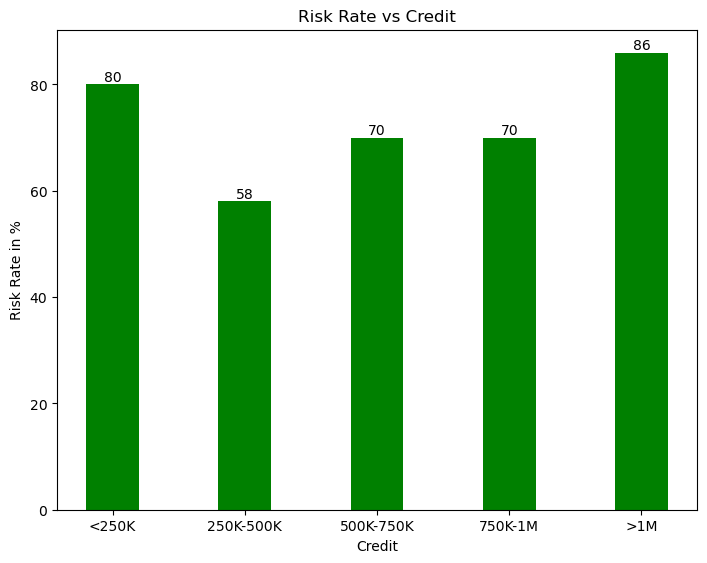

In [574]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

bars = ax.bar(credit_risk_groups.keys(),credit_risk_groups.values(), width=0.4, color = "green")
ax.bar_label(bars)
plt.title("Risk Rate vs Credit")
plt.xlabel('Credit')
plt.ylabel('Risk Rate in %')
plt.show()

In [575]:
print("The dp difference for Credit is ", max(credit_risk_groups.values()) - min(credit_risk_groups.values()))

credit_dp = round(min(credit_risk_groups.values()) / max(credit_risk_groups.values()),2)
print("The dp ratio for Credit is ", credit_dp)

dp_ratio_features.update({"AMT_CREDIT":credit_dp})

The dp difference for Credit is  28.000000000000007
The dp ratio for Credit is  0.67


In [576]:
dp_ratio_features

{'NAME_CONTRACT_TYPE': 0.85,
 'CODE_GENDER': 0.86,
 'FLAG_OWN_CAR': 0.84,
 'FLAG_OWN_REALTY': 0.99,
 'CNT_CHILDREN': 0.0,
 'AMT_INCOME_TOTAL': 0.79,
 'AMT_CREDIT': 0.67}

8. 'AMT_ANNUITY'

In [577]:
test_df["AMT_ANNUITY"].min(), test_df["AMT_ANNUITY"].max()

(4509.0, 103455.0)

In [578]:
sr_annunity = MetricFrame(metrics=selection_rate, y_true=predictions_test, y_pred=predictions_test, sensitive_features=test_df["AMT_ANNUITY"])
# display(sr.overall)
display(sr_annunity.by_group)

AMT_ANNUITY
4509.0      1.0
4594.5      1.0
5220.0      1.0
5224.5      1.0
5337.0      1.0
           ... 
92529.0     1.0
98550.0     1.0
98770.5     1.0
98874.0     1.0
103455.0    1.0
Name: selection_rate, Length: 744, dtype: float64

In [579]:
less_10k = sr_annunity.by_group.loc[:10000]
btw_10k_25k = sr_annunity.by_group.loc[10000:25000]
btw_25k_50k = sr_annunity.by_group.loc[25000:50000]
gt_50k = sr_annunity.by_group.loc[50000:]



# display(len(less_10k))
# display(len(btw_10k_25k))
# display(len(btw_25k_50k))
# display(len(gt_50k))



less_10k_risk_rate = 100*round(np.mean(less_10k),2)
btw_10k_25k_risk_rate = 100*round(np.mean(btw_10k_25k),2)
btw_25k_50k_risk_rate = 100*round(np.mean(btw_25k_50k),2)
gt_50k_risk_rate = 100*round(np.mean(gt_50k),2)


annunity_risk_groups= {"<10K" : less_10k_risk_rate, "10K-25K" : btw_10k_25k_risk_rate, 
                     "25K-50K" :  btw_25k_50k_risk_rate, ">50K": gt_50k_risk_rate}

annunity_risk_groups

{'<10K': 90.0, '10K-25K': 69.0, '25K-50K': 68.0, '>50K': 80.0}

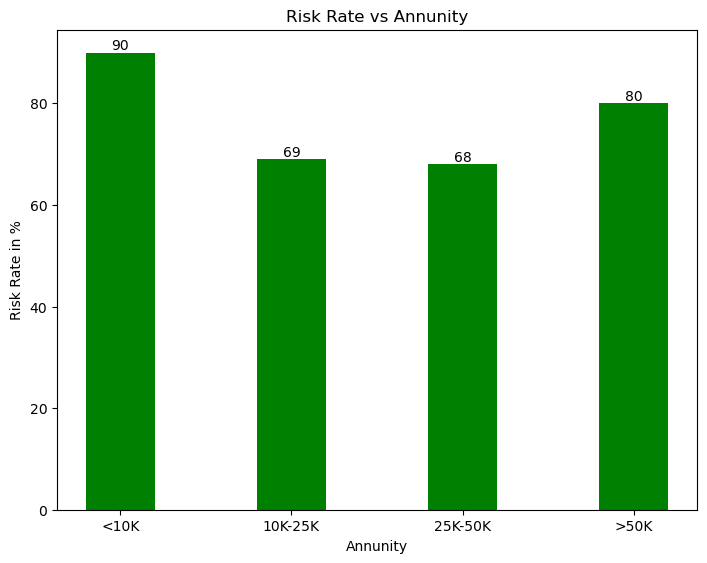

In [580]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

bars = ax.bar(annunity_risk_groups.keys(),annunity_risk_groups.values(), width=0.4, color = "green")
ax.bar_label(bars)
plt.title("Risk Rate vs Annunity")
plt.xlabel('Annunity')
plt.ylabel('Risk Rate in %')
plt.show()

In [581]:
print("The dp difference for Annunity is ", max(annunity_risk_groups.values()) - min(annunity_risk_groups.values()))

annunity_dp = round(min(annunity_risk_groups.values()) / max(annunity_risk_groups.values()),2)
print("The dp ratio for Annunity is ", annunity_dp)

dp_ratio_features.update({"AMT_ANNUITY":annunity_dp})

The dp difference for Annunity is  22.0
The dp ratio for Annunity is  0.76


In [582]:
dp_ratio_features

{'NAME_CONTRACT_TYPE': 0.85,
 'CODE_GENDER': 0.86,
 'FLAG_OWN_CAR': 0.84,
 'FLAG_OWN_REALTY': 0.99,
 'CNT_CHILDREN': 0.0,
 'AMT_INCOME_TOTAL': 0.79,
 'AMT_CREDIT': 0.67,
 'AMT_ANNUITY': 0.76}

9. 'AMT_GOODS_PRICE'

In [583]:
test_df["AMT_GOODS_PRICE"].min(), test_df["AMT_GOODS_PRICE"].max()

(45000.0, 1800000.0)

In [584]:
# <100,000
# 100,000 - 500,000
# 500,000 - 1,000,000
# >1,000,000

In [585]:
sr_goods = MetricFrame(metrics=selection_rate, y_true=predictions_test, y_pred=predictions_test, sensitive_features=test_df["AMT_GOODS_PRICE"])
# display(sr.overall)
display(sr_goods.by_group)

AMT_GOODS_PRICE
45000.0      1.000000
54000.0      1.000000
58500.0      1.000000
63000.0      0.000000
67500.0      1.000000
               ...   
1575000.0    1.000000
1723500.0    1.000000
1741500.0    0.000000
1782000.0    1.000000
1800000.0    0.933333
Name: selection_rate, Length: 168, dtype: float64

In [586]:
less_100k = sr_goods.by_group.loc[:100000]
btw_100k_500k = sr_goods.by_group.loc[100000:500000]
btw_500k_1m = sr_goods.by_group.loc[500000:1000000]
gt_1m = sr_goods.by_group.loc[1000000:]



# display(len(less_100k))
# display(len(btw_100k_500k))
# display(len(btw_500k_1m))
# display(len(gt_1m))



less_100k_risk_rate = 100*round(np.mean(less_100k),2)
btw_100k_500k_risk_rate = 100*round(np.mean(btw_100k_500k),2)
btw_500k_1m_risk_rate = 100*round(np.mean(btw_500k_1m),2)
gt_1m_risk_rate = 100*round(np.mean(gt_1m),2)


goods_risk_groups= {"<100K" : less_100k_risk_rate, "100K-500K" : btw_100k_500k_risk_rate, 
                     "500K-1M" :  btw_500k_1m_risk_rate, ">1M": gt_1m_risk_rate}

goods_risk_groups

{'<100K': 87.0, '100K-500K': 64.0, '500K-1M': 68.0, '>1M': 85.0}

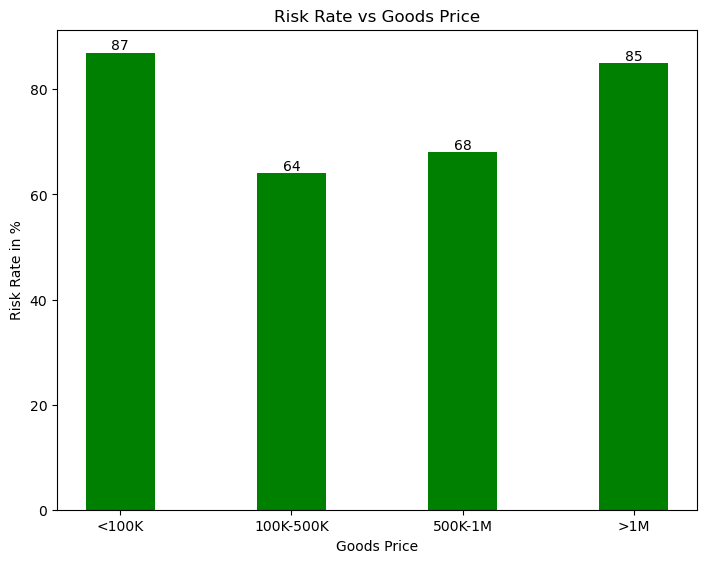

In [587]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

bars = ax.bar(goods_risk_groups.keys(),goods_risk_groups.values(), width=0.4, color = "green")
ax.bar_label(bars)
plt.title("Risk Rate vs Goods Price")
plt.xlabel('Goods Price')
plt.ylabel('Risk Rate in %')
plt.show()

In [588]:
print("The dp difference for Goods Price is ", max(goods_risk_groups.values()) - min(goods_risk_groups.values()))

goods_dp = round(min(goods_risk_groups.values()) / max(goods_risk_groups.values()),2)
print("The dp ratio for Goods Price is ", goods_dp)

dp_ratio_features.update({"AMT_GOODS_PRICE":goods_dp})

The dp difference for Goods Price is  23.0
The dp ratio for Goods Price is  0.74


In [589]:
dp_ratio_features

{'NAME_CONTRACT_TYPE': 0.85,
 'CODE_GENDER': 0.86,
 'FLAG_OWN_CAR': 0.84,
 'FLAG_OWN_REALTY': 0.99,
 'CNT_CHILDREN': 0.0,
 'AMT_INCOME_TOTAL': 0.79,
 'AMT_CREDIT': 0.67,
 'AMT_ANNUITY': 0.76,
 'AMT_GOODS_PRICE': 0.74}

10. NAME_TYPE_SUITE

In [590]:
test_df["NAME_TYPE_SUITE"].unique()

array(['Unaccompanied', nan, 'Family', 'Spouse, partner',
       'Group of people', 'Other_B', 'Children', 'Other_A'], dtype=object)

In [591]:
test_df_final["NAME_TYPE_SUITE_LE"].unique()

# 0 - Children
# 1 - Family
# 2 - Group of people
# 3 - Other_A
# 4 - Other_B
# 5 - Spouse, partner
# 6 - Unaccompanied
# 7 - Nan

array([6, 7, 1, 5, 2, 4, 0, 3])

In [592]:
sr_type_suite = MetricFrame(metrics=selection_rate, y_true=predictions_test, y_pred=predictions_test, sensitive_features= test_df_final["NAME_TYPE_SUITE_LE"])
# display(sr.overall)
display(sr_type_suite.by_group)

NAME_TYPE_SUITE_LE
0    0.400000
1    0.691057
2    1.000000
3    0.750000
4    0.400000
5    0.707317
6    0.686957
7    0.625000
Name: selection_rate, dtype: float64

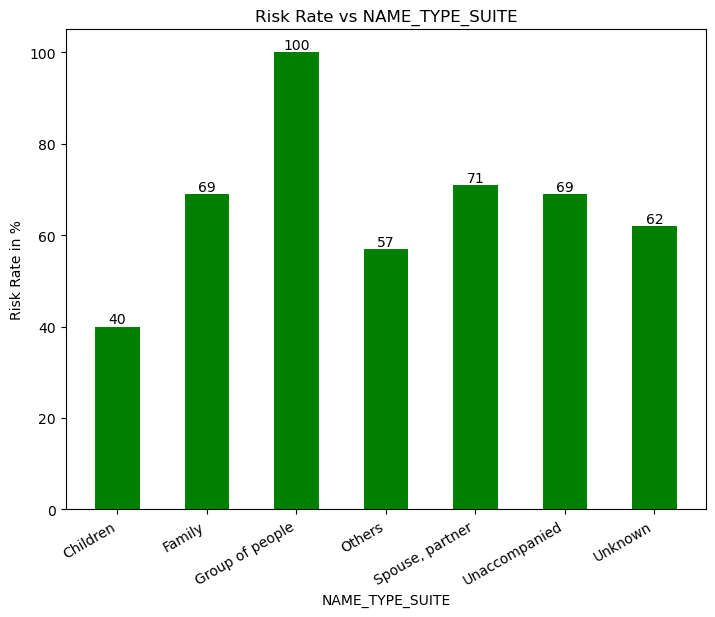

In [593]:
# 0 - Children
# 1 - Family
# 2 - Group of people
# 3 - Other_A
# 4 - Other_B
# 5 - Spouse, partner
# 6 - Unaccompanied
# 7 - Nan

Others = sr_type_suite.by_group.loc[3:4]

type_suite_groups= {"Children" : round(100*sr_type_suite.by_group.loc[0]),
                    "Family" : round(100*sr_type_suite.by_group.loc[1]),
                    "Group of people" : round(100*sr_type_suite.by_group.loc[2]),
                    "Others" : round(100*np.mean(Others)),
                    "Spouse, partner" : round(100*sr_type_suite.by_group.loc[5]),
                    "Unaccompanied" : round(100*sr_type_suite.by_group.loc[6]),
                    "Unknown" : round(100*sr_type_suite.by_group.loc[7])
                    }


fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

bars = ax.bar(type_suite_groups.keys(),type_suite_groups.values(), width=0.5, color = "green")
ax.bar_label(bars)
plt.title("Risk Rate vs NAME_TYPE_SUITE")
plt.xlabel('NAME_TYPE_SUITE')
plt.ylabel('Risk Rate in %')
fig.autofmt_xdate()
plt.show()

In [594]:
print("The dp difference for NAME_TYPE_SUITE is ", max(type_suite_groups.values()) - min(type_suite_groups.values()))

type_suite_dp = round(min(type_suite_groups.values()) / max(type_suite_groups.values()),2)
print("The dp ratio for NAME_TYPE_SUITE is ", type_suite_dp)

dp_ratio_features.update({"NAME_TYPE_SUITE": type_suite_dp})

The dp difference for NAME_TYPE_SUITE is  60
The dp ratio for NAME_TYPE_SUITE is  0.4


In [595]:
dp_ratio_features

{'NAME_CONTRACT_TYPE': 0.85,
 'CODE_GENDER': 0.86,
 'FLAG_OWN_CAR': 0.84,
 'FLAG_OWN_REALTY': 0.99,
 'CNT_CHILDREN': 0.0,
 'AMT_INCOME_TOTAL': 0.79,
 'AMT_CREDIT': 0.67,
 'AMT_ANNUITY': 0.76,
 'AMT_GOODS_PRICE': 0.74,
 'NAME_TYPE_SUITE': 0.4}

11. NAME_INCOME_TYPE

In [596]:
test_df["NAME_INCOME_TYPE"].unique()

array(['Working', 'State servant', 'Pensioner', 'Commercial associate'],
      dtype=object)

In [597]:
sr_income_type = MetricFrame(metrics=selection_rate, y_true=predictions_test, y_pred=predictions_test, sensitive_features= test_df["NAME_INCOME_TYPE"])
# display(sr.overall)
display(sr_income_type.by_group)

NAME_INCOME_TYPE
Commercial associate    0.690909
Pensioner               0.824176
State servant           0.742857
Working                 0.626894
Name: selection_rate, dtype: float64

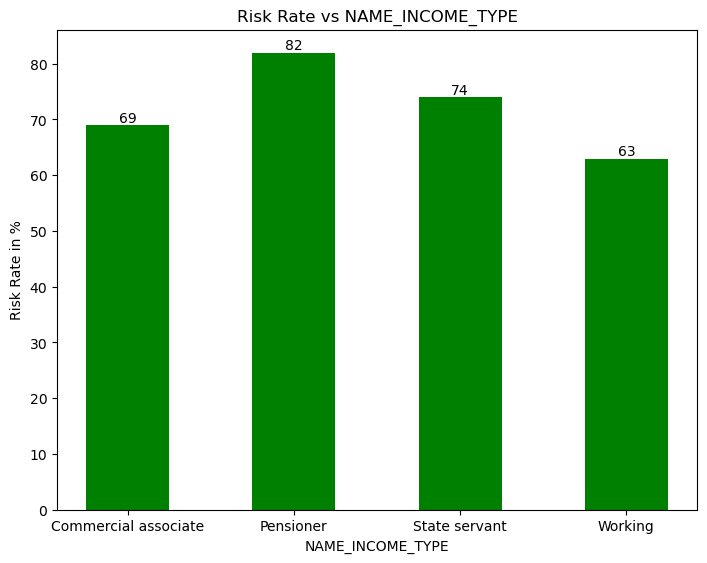

In [598]:
income_type_groups= {"Commercial associate" : round(100*sr_income_type.by_group.loc["Commercial associate"]),
                    "Pensioner" : round(100*sr_income_type.by_group.loc["Pensioner"]),
                    "State servant" : round(100*sr_income_type.by_group.loc["State servant"]),
                    "Working" : round(100*sr_income_type.by_group.loc["Working"]),
                    }


fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

bars = ax.bar(income_type_groups.keys(),income_type_groups.values(), width=0.5, color = "green")
ax.bar_label(bars)
plt.title("Risk Rate vs NAME_INCOME_TYPE")
plt.xlabel('NAME_INCOME_TYPE')
plt.ylabel('Risk Rate in %')
plt.show()

In [599]:
print("The dp difference for NAME_INCOME_TYPE is ", max(income_type_groups.values()) - min(income_type_groups.values()))

income_type_dp = round(min(income_type_groups.values()) / max(income_type_groups.values()),2)
print("The dp ratio for NAME_INCOME_TYPE is ", income_type_dp)

dp_ratio_features.update({"NAME_INCOME_TYPE": income_type_dp})

The dp difference for NAME_INCOME_TYPE is  19
The dp ratio for NAME_INCOME_TYPE is  0.77


In [600]:
display(dp_ratio_features)
len(dp_ratio_features)

{'NAME_CONTRACT_TYPE': 0.85,
 'CODE_GENDER': 0.86,
 'FLAG_OWN_CAR': 0.84,
 'FLAG_OWN_REALTY': 0.99,
 'CNT_CHILDREN': 0.0,
 'AMT_INCOME_TOTAL': 0.79,
 'AMT_CREDIT': 0.67,
 'AMT_ANNUITY': 0.76,
 'AMT_GOODS_PRICE': 0.74,
 'NAME_TYPE_SUITE': 0.4,
 'NAME_INCOME_TYPE': 0.77}

11

12. NAME_EDUCATION_TYPE

In [601]:
test_df["NAME_EDUCATION_TYPE"].unique()

array(['Higher education', 'Secondary / secondary special',
       'Incomplete higher', 'Lower secondary'], dtype=object)

In [602]:
sr_education_type = MetricFrame(metrics=selection_rate, y_true=predictions_test, y_pred=predictions_test, sensitive_features= test_df["NAME_EDUCATION_TYPE"])
# display(sr.overall)
display(sr_education_type.by_group)

NAME_EDUCATION_TYPE
Higher education                 0.966805
Incomplete higher                0.775000
Lower secondary                  0.529412
Secondary / secondary special    0.586895
Name: selection_rate, dtype: float64

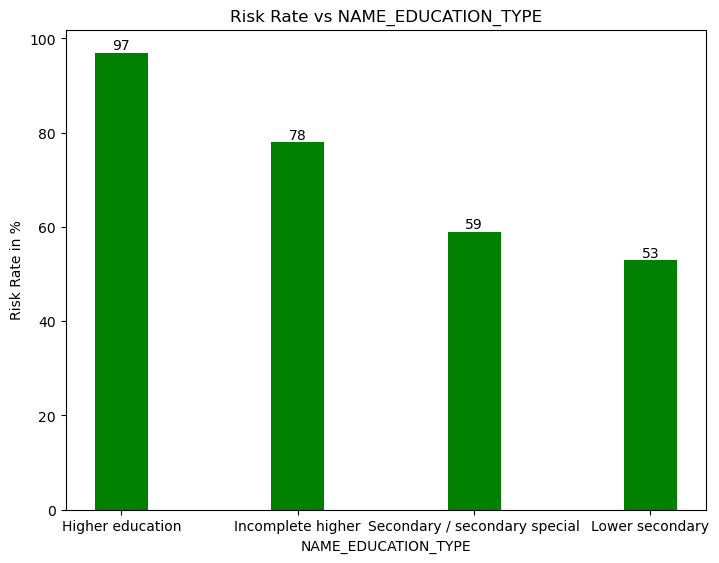

In [603]:
education_type_groups= {"Higher education" : round(100*sr_education_type.by_group.loc["Higher education"]),
                    "Incomplete higher" : round(100*sr_education_type.by_group.loc["Incomplete higher"]),
                    "Secondary / secondary special" : round(100*sr_education_type.by_group.loc["Secondary / secondary special"]),
                        "Lower secondary" : round(100*sr_education_type.by_group.loc["Lower secondary"])
                    }


fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

bars = ax.bar(education_type_groups.keys(),education_type_groups.values(), width=0.3, color = "green")
ax.bar_label(bars)
plt.title("Risk Rate vs NAME_EDUCATION_TYPE")
plt.xlabel('NAME_EDUCATION_TYPE')
plt.ylabel('Risk Rate in %')
plt.show()

In [604]:
print("The dp difference for NAME_EDUCATION_TYPE is ", max(education_type_groups.values()) - min(education_type_groups.values()))

education_type_dp = round(min(education_type_groups.values()) / max(education_type_groups.values()),2)
print("The dp ratio for NAME_EDUCATION_TYPE is ", education_type_dp)

dp_ratio_features.update({"NAME_EDUCATION_TYPE": education_type_dp})

The dp difference for NAME_EDUCATION_TYPE is  44
The dp ratio for NAME_EDUCATION_TYPE is  0.55


In [605]:
display(dp_ratio_features)
len(dp_ratio_features)

{'NAME_CONTRACT_TYPE': 0.85,
 'CODE_GENDER': 0.86,
 'FLAG_OWN_CAR': 0.84,
 'FLAG_OWN_REALTY': 0.99,
 'CNT_CHILDREN': 0.0,
 'AMT_INCOME_TOTAL': 0.79,
 'AMT_CREDIT': 0.67,
 'AMT_ANNUITY': 0.76,
 'AMT_GOODS_PRICE': 0.74,
 'NAME_TYPE_SUITE': 0.4,
 'NAME_INCOME_TYPE': 0.77,
 'NAME_EDUCATION_TYPE': 0.55}

12

13.	NAME_FAMILY_STATUS

In [606]:
test_df["NAME_FAMILY_STATUS"].unique()

array(['Married', 'Single / not married', 'Civil marriage', 'Widow',
       'Separated'], dtype=object)

In [607]:
sr_family = MetricFrame(metrics=selection_rate, y_true=predictions_test, y_pred=predictions_test, sensitive_features= test_df["NAME_FAMILY_STATUS"])
# display(sr.overall)
display(sr_family.by_group)

NAME_FAMILY_STATUS
Civil marriage          0.594059
Married                 0.705531
Separated               0.686275
Single / not married    0.620155
Widow                   0.760000
Name: selection_rate, dtype: float64

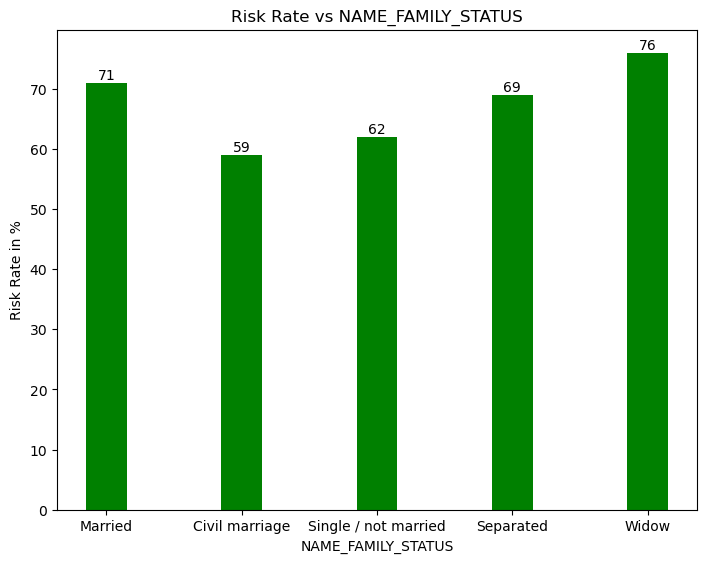

In [608]:
family_groups= {"Married" : round(100*sr_family.by_group.loc["Married"]),
                "Civil marriage" : round(100*sr_family.by_group.loc["Civil marriage"]),
                "Single / not married" : round(100*sr_family.by_group.loc["Single / not married"]),
                "Separated" : round(100*sr_family.by_group.loc["Separated"]),
                "Widow" : round(100*sr_family.by_group.loc["Widow"])}


fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

bars = ax.bar(family_groups.keys(),family_groups.values(), width=0.3, color = "green")
ax.bar_label(bars)
plt.title("Risk Rate vs NAME_FAMILY_STATUS")
plt.xlabel('NAME_FAMILY_STATUS')
plt.ylabel('Risk Rate in %')
plt.show()

In [609]:
print("The dp difference for NAME_FAMILY_STATUS is ", max(family_groups.values()) - min(family_groups.values()))

family_status_dp = round(min(family_groups.values()) / max(family_groups.values()),2)
print("The dp ratio for NAME_FAMILY_STATUS is ", family_status_dp)

dp_ratio_features.update({"NAME_FAMILY_STATUS": family_status_dp})

The dp difference for NAME_FAMILY_STATUS is  17
The dp ratio for NAME_FAMILY_STATUS is  0.78


In [610]:
display(dp_ratio_features)
len(dp_ratio_features)

{'NAME_CONTRACT_TYPE': 0.85,
 'CODE_GENDER': 0.86,
 'FLAG_OWN_CAR': 0.84,
 'FLAG_OWN_REALTY': 0.99,
 'CNT_CHILDREN': 0.0,
 'AMT_INCOME_TOTAL': 0.79,
 'AMT_CREDIT': 0.67,
 'AMT_ANNUITY': 0.76,
 'AMT_GOODS_PRICE': 0.74,
 'NAME_TYPE_SUITE': 0.4,
 'NAME_INCOME_TYPE': 0.77,
 'NAME_EDUCATION_TYPE': 0.55,
 'NAME_FAMILY_STATUS': 0.78}

13

14. NAME_HOUSING_TYPE

In [611]:
test_df["NAME_HOUSING_TYPE"].unique()

array(['House / apartment', 'With parents', 'Rented apartment',
       'Municipal apartment', 'Office apartment', 'Co-op apartment'],
      dtype=object)

In [612]:
sr_housing = MetricFrame(metrics=selection_rate, y_true=predictions_test, y_pred=predictions_test, sensitive_features= test_df["NAME_HOUSING_TYPE"])
# display(sr.overall)
display(sr_housing.by_group)

NAME_HOUSING_TYPE
Co-op apartment        1.000000
House / apartment      0.697175
Municipal apartment    0.705882
Office apartment       1.000000
Rented apartment       0.428571
With parents           0.508475
Name: selection_rate, dtype: float64

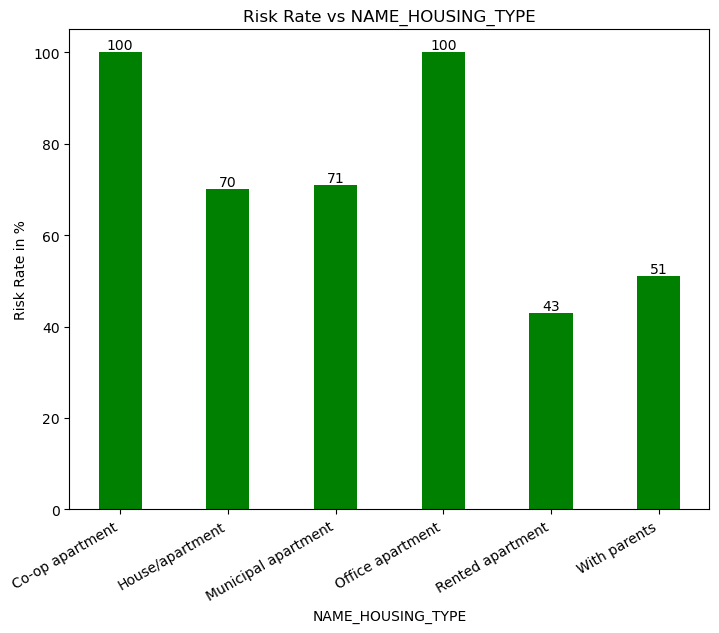

In [613]:
housing_groups= {"Co-op apartment" : round(100*sr_housing.by_group.loc["Co-op apartment"]),
                "House/apartment" : round(100*sr_housing.by_group.loc["House / apartment"]),
                "Municipal apartment" : round(100*sr_housing.by_group.loc["Municipal apartment"]),
                "Office apartment" : round(100*sr_housing.by_group.loc["Office apartment"]),
                "Rented apartment" : round(100*sr_housing.by_group.loc["Rented apartment"]),
                "With parents" : round(100*sr_housing.by_group.loc["With parents"]),
}


fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

bars = ax.bar(housing_groups.keys(),housing_groups.values(), width=0.4, color = "green")
ax.bar_label(bars)
plt.title("Risk Rate vs NAME_HOUSING_TYPE")
plt.xlabel('NAME_HOUSING_TYPE')
plt.ylabel('Risk Rate in %')
fig.autofmt_xdate()
plt.show()

In [614]:
print("The dp difference for NAME_HOUSING_TYPE is ", max(housing_groups.values()) - min(housing_groups.values()))

housing_status_dp = round(min(housing_groups.values()) / max(housing_groups.values()),2)
print("The dp ratio for NAME_HOUSING_TYPE is ", housing_status_dp)

dp_ratio_features.update({"NAME_HOUSING_TYPE": housing_status_dp})

The dp difference for NAME_HOUSING_TYPE is  57
The dp ratio for NAME_HOUSING_TYPE is  0.43


In [615]:
display(dp_ratio_features)
len(dp_ratio_features)

{'NAME_CONTRACT_TYPE': 0.85,
 'CODE_GENDER': 0.86,
 'FLAG_OWN_CAR': 0.84,
 'FLAG_OWN_REALTY': 0.99,
 'CNT_CHILDREN': 0.0,
 'AMT_INCOME_TOTAL': 0.79,
 'AMT_CREDIT': 0.67,
 'AMT_ANNUITY': 0.76,
 'AMT_GOODS_PRICE': 0.74,
 'NAME_TYPE_SUITE': 0.4,
 'NAME_INCOME_TYPE': 0.77,
 'NAME_EDUCATION_TYPE': 0.55,
 'NAME_FAMILY_STATUS': 0.78,
 'NAME_HOUSING_TYPE': 0.43}

14

15. 'REGION_POPULATION_RELATIVE'

In [616]:
test_df["REGION_POPULATION_RELATIVE"].min(), test_df["REGION_POPULATION_RELATIVE"].max()

(0.001276, 0.072508)

In [617]:
# <0.01
# 0.01 - 0.020
# 0.020 - 0.030
# >0.030

In [618]:
sr_region_population = MetricFrame(metrics=selection_rate, y_true=predictions_test, y_pred=predictions_test, sensitive_features=test_df["REGION_POPULATION_RELATIVE"])
# display(sr.overall)
display(sr_region_population.by_group)

REGION_POPULATION_RELATIVE
0.001276    0.000000
0.001417    0.000000
0.002042    0.200000
0.002134    0.333333
0.002506    0.000000
              ...   
0.031329    0.687500
0.032561    0.882353
0.035792    0.720000
0.046220    0.800000
0.072508    0.892857
Name: selection_rate, Length: 77, dtype: float64

In [619]:
group1_population = sr_region_population.by_group.loc[:0.01]
group2_population = sr_region_population.by_group.loc[0.01:0.020]
group3_population = sr_region_population.by_group.loc[0.020:0.030]
group4_population = sr_region_population.by_group.loc[0.03:]


group1_risk_rate = 100*round(np.mean(group1_population),2)
group2_risk_rate = 100*round(np.mean(group2_population),2)
group3_risk_rate = 100*round(np.mean(group3_population),2)
group4_risk_rate = 100*round(np.mean(group4_population),2)


region_population_risk_groups= {"<0.01" : group1_risk_rate, "0.01-0.02" : group2_risk_rate, 
                     "0.02-0.03" :  group3_risk_rate, ">0.03": group4_risk_rate}

region_population_risk_groups

{'<0.01': 61.0, '0.01-0.02': 68.0, '0.02-0.03': 70.0, '>0.03': 79.0}

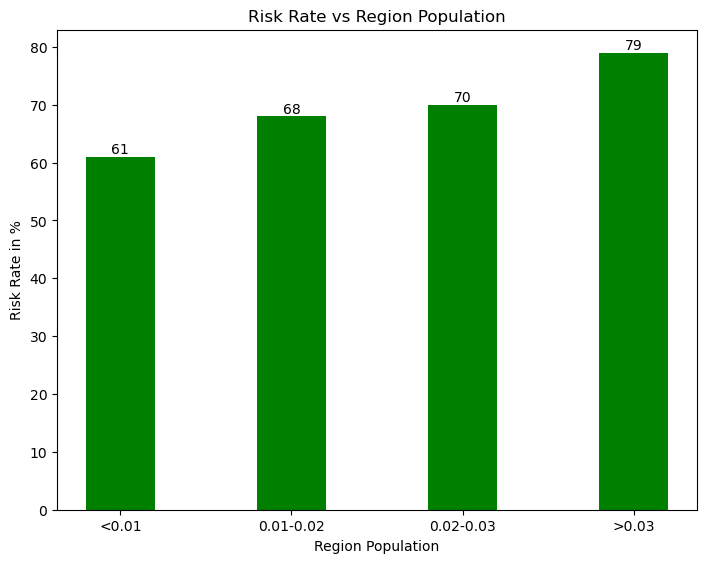

In [620]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

bars = ax.bar(region_population_risk_groups.keys(),region_population_risk_groups.values(), width=0.4, color = "green")
ax.bar_label(bars)
plt.title("Risk Rate vs Region Population")
plt.xlabel('Region Population')
plt.ylabel('Risk Rate in %')
plt.show()

In [621]:
print("The dp difference for Region Population is ", max(region_population_risk_groups.values()) - min(region_population_risk_groups.values()))

region_population_dp = round(min(region_population_risk_groups.values()) / max(region_population_risk_groups.values()),2)
print("The dp ratio for Region Population is ", region_population_dp)

dp_ratio_features.update({"REGION_POPULATION_RELATIVE":region_population_dp})

The dp difference for Region Population is  18.0
The dp ratio for Region Population is  0.77


In [622]:
display(dp_ratio_features)
len(dp_ratio_features)

{'NAME_CONTRACT_TYPE': 0.85,
 'CODE_GENDER': 0.86,
 'FLAG_OWN_CAR': 0.84,
 'FLAG_OWN_REALTY': 0.99,
 'CNT_CHILDREN': 0.0,
 'AMT_INCOME_TOTAL': 0.79,
 'AMT_CREDIT': 0.67,
 'AMT_ANNUITY': 0.76,
 'AMT_GOODS_PRICE': 0.74,
 'NAME_TYPE_SUITE': 0.4,
 'NAME_INCOME_TYPE': 0.77,
 'NAME_EDUCATION_TYPE': 0.55,
 'NAME_FAMILY_STATUS': 0.78,
 'NAME_HOUSING_TYPE': 0.43,
 'REGION_POPULATION_RELATIVE': 0.77}

15

16. AGE

In [623]:
test_df["AGE"].min(), test_df["AGE"].max()

(21.0, 68.0)

In [624]:
sr_age = MetricFrame(metrics=selection_rate, y_true=predictions_test, y_pred=predictions_test,sensitive_features=test_df["AGE"])
# display(sr.overall)
display(sr_age.by_group)

AGE
21.0    1.000000
22.0    0.000000
23.0    0.500000
24.0    0.473684
25.0    0.500000
26.0    0.529412
27.0    0.666667
28.0    0.680000
29.0    0.621622
30.0    0.392857
31.0    0.454545
32.0    0.678571
33.0    0.567568
34.0    0.529412
35.0    0.578947
36.0    0.423077
37.0    0.542857
38.0    0.727273
39.0    0.760000
40.0    0.680000
41.0    0.789474
42.0    0.416667
43.0    0.740741
44.0    0.769231
45.0    0.954545
46.0    0.535714
47.0    0.720000
48.0    0.708333
49.0    0.842105
50.0    0.739130
51.0    0.812500
52.0    0.750000
53.0    0.954545
54.0    0.720000
55.0    0.722222
56.0    0.666667
57.0    0.894737
58.0    0.736842
59.0    0.840000
60.0    0.769231
61.0    0.769231
62.0    0.833333
63.0    0.888889
64.0    0.882353
65.0    1.000000
66.0    1.000000
67.0    1.000000
68.0    1.000000
Name: selection_rate, dtype: float64

In [625]:
young_adults = sr_age.by_group.loc[:25]
adults = sr_age.by_group.loc[26:40]
middle_age_adults = sr_age.by_group.loc[41:60]
older_adults = sr_age.by_group.loc[61:]

young_adults_risk_rate = round(np.mean(young_adults),2)
adults_risk_rate = round(np.mean(adults),2)
middle_age_adults_risk_rate = round(np.mean(middle_age_adults),2)
older_adults_risk_rate = round(np.mean(older_adults),2)


age_risk_groups= {"Young Adults (18-25)" : 100*young_adults_risk_rate,"Adults (26-40)" : 100*adults_risk_rate, 
                  "Middle Age Adults (41 - 60)": 100*middle_age_adults_risk_rate, "Older Adults (60+)":100*older_adults_risk_rate}

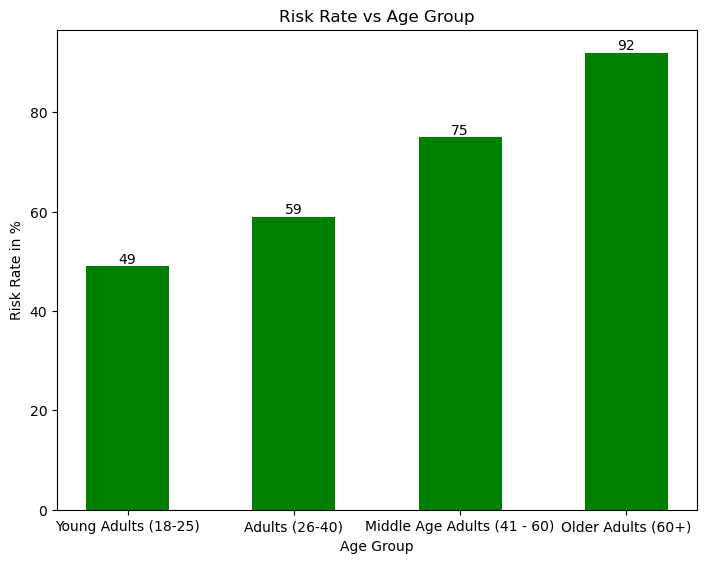

In [626]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

bars = ax.bar(age_risk_groups.keys(),age_risk_groups.values(), width=0.5, color = "green")
ax.bar_label(bars)
plt.title("Risk Rate vs Age Group")
plt.xlabel('Age Group')
plt.ylabel('Risk Rate in %')
plt.show()

In [627]:
print("The dp difference for Age is ", max(age_risk_groups.values()) - min(age_risk_groups.values()))

age_dp = round(min(age_risk_groups.values()) / max(age_risk_groups.values()),2)
print("The dp ratio for Age is ", age_dp)

dp_ratio_features.update({"AGE":age_dp})

The dp difference for Age is  43.0
The dp ratio for Age is  0.53


In [628]:
display(dp_ratio_features)
len(dp_ratio_features)

{'NAME_CONTRACT_TYPE': 0.85,
 'CODE_GENDER': 0.86,
 'FLAG_OWN_CAR': 0.84,
 'FLAG_OWN_REALTY': 0.99,
 'CNT_CHILDREN': 0.0,
 'AMT_INCOME_TOTAL': 0.79,
 'AMT_CREDIT': 0.67,
 'AMT_ANNUITY': 0.76,
 'AMT_GOODS_PRICE': 0.74,
 'NAME_TYPE_SUITE': 0.4,
 'NAME_INCOME_TYPE': 0.77,
 'NAME_EDUCATION_TYPE': 0.55,
 'NAME_FAMILY_STATUS': 0.78,
 'NAME_HOUSING_TYPE': 0.43,
 'REGION_POPULATION_RELATIVE': 0.77,
 'AGE': 0.53}

16

17. YEARS_EMPLOYED

In [629]:
test_df["YEARS_EMPLOYED"].min(), test_df["YEARS_EMPLOYED"].max()

(0.0, 41.0)

In [630]:
# <10 
# 10 - 20
# 20 - 30 
# >30

In [631]:
sr_employed = MetricFrame(metrics=selection_rate, y_true=predictions_test, y_pred=predictions_test,sensitive_features=test_df["YEARS_EMPLOYED"])

display(sr_employed.by_group)

YEARS_EMPLOYED
0.0     0.538462
1.0     0.580000
2.0     0.548077
3.0     0.597403
4.0     0.500000
5.0     0.593220
6.0     0.660000
7.0     0.688889
8.0     0.740000
9.0     0.707317
10.0    0.823529
11.0    0.769231
12.0    0.840000
13.0    0.733333
14.0    1.000000
15.0    0.909091
16.0    0.875000
17.0    0.800000
18.0    0.750000
19.0    0.833333
20.0    1.000000
21.0    1.000000
22.0    1.000000
23.0    1.000000
25.0    1.000000
28.0    0.600000
29.0    1.000000
30.0    1.000000
31.0    1.000000
33.0    1.000000
34.0    0.000000
35.0    1.000000
36.0    1.000000
41.0    1.000000
Name: selection_rate, dtype: float64

In [632]:
print(len(sr_employed.by_group))

34


In [633]:
lessthan_10 = sr_employed.by_group.loc[:10]
btw_10_20 = sr_employed.by_group.loc[11:20]
btw_20_30 = sr_employed.by_group.loc[21:30 ]
gt_30 = sr_employed.by_group.loc[31:]

lessthan_10_risk_rate = 100*round(np.mean(lessthan_10),2)
btw_10_20_risk_rate = 100*round(np.mean(btw_10_20),2)
btw_20_30_risk_rate = 100*round(np.mean(btw_20_30),2)
gt_30_risk_rate = 100*round(np.mean(gt_30),2)


years_employed_risk_groups= {"<10" : lessthan_10_risk_rate, "10 - 20" : btw_10_20_risk_rate, 
                     "20 - 30" :  btw_20_30_risk_rate, ">30": gt_30_risk_rate}

years_employed_risk_groups

{'<10': 63.0, '10 - 20': 85.0, '20 - 30': 94.0, '>30': 83.0}

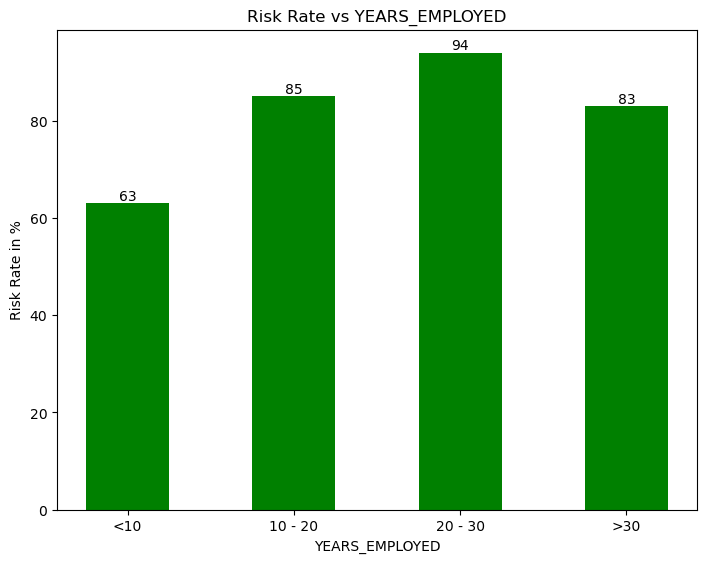

In [634]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

bars = ax.bar(years_employed_risk_groups.keys(),years_employed_risk_groups.values(), width=0.5, color = "green")
ax.bar_label(bars)
plt.title("Risk Rate vs YEARS_EMPLOYED")
plt.xlabel('YEARS_EMPLOYED')
plt.ylabel('Risk Rate in %')
plt.show()

In [635]:
print("The dp difference for YEARS_EMPLOYED is ", max(years_employed_risk_groups.values()) - min(years_employed_risk_groups.values()))

employement_dp = round(min(years_employed_risk_groups.values()) / max(years_employed_risk_groups.values()),2)
print("The dp ratio for YEARS_EMPLOYED is ", employement_dp)

dp_ratio_features.update({"YEARS_EMPLOYED":employement_dp})

The dp difference for YEARS_EMPLOYED is  31.0
The dp ratio for YEARS_EMPLOYED is  0.67


In [636]:
display(dp_ratio_features)
len(dp_ratio_features)

{'NAME_CONTRACT_TYPE': 0.85,
 'CODE_GENDER': 0.86,
 'FLAG_OWN_CAR': 0.84,
 'FLAG_OWN_REALTY': 0.99,
 'CNT_CHILDREN': 0.0,
 'AMT_INCOME_TOTAL': 0.79,
 'AMT_CREDIT': 0.67,
 'AMT_ANNUITY': 0.76,
 'AMT_GOODS_PRICE': 0.74,
 'NAME_TYPE_SUITE': 0.4,
 'NAME_INCOME_TYPE': 0.77,
 'NAME_EDUCATION_TYPE': 0.55,
 'NAME_FAMILY_STATUS': 0.78,
 'NAME_HOUSING_TYPE': 0.43,
 'REGION_POPULATION_RELATIVE': 0.77,
 'AGE': 0.53,
 'YEARS_EMPLOYED': 0.67}

17

18. YEARS_REGISTRATION

In [637]:
test_df["YEARS_REGISTRATION"].min(), test_df["YEARS_REGISTRATION"].max()

(0.0, 47.0)

In [638]:
# <10 
# 10 - 20
# 20 - 30 
# >30

In [639]:
sr_registration = MetricFrame(metrics=selection_rate, y_true=predictions_test, y_pred=predictions_test,sensitive_features=test_df["YEARS_REGISTRATION"])

display(sr_registration.by_group)

YEARS_REGISTRATION
0.0     0.555556
1.0     0.538462
2.0     0.622951
3.0     0.580000
4.0     0.642857
5.0     0.666667
6.0     0.692308
7.0     0.625000
8.0     0.666667
9.0     0.705882
10.0    0.580645
11.0    0.678571
12.0    0.765957
13.0    0.658537
14.0    0.681818
15.0    0.709677
16.0    0.722222
17.0    0.827586
18.0    0.600000
19.0    0.640000
20.0    0.714286
21.0    0.791667
22.0    0.692308
23.0    0.640000
24.0    0.562500
25.0    0.631579
26.0    0.812500
27.0    0.875000
28.0    0.809524
29.0    0.733333
30.0    0.916667
31.0    0.888889
32.0    0.857143
33.0    0.909091
34.0    0.500000
35.0    1.000000
36.0    1.000000
37.0    1.000000
38.0    0.000000
39.0    1.000000
40.0    1.000000
41.0    1.000000
45.0    1.000000
46.0    1.000000
47.0    1.000000
Name: selection_rate, dtype: float64

In [640]:
lessthan_10 = sr_registration.by_group.loc[:10]
btw_10_20 = sr_registration.by_group.loc[11:20]
btw_20_30 = sr_registration.by_group.loc[21:30 ]
gt_30 = sr_registration.by_group.loc[31:]

lessthan_10_risk_rate = 100*round(np.mean(lessthan_10),2)
btw_10_20_risk_rate = 100*round(np.mean(btw_10_20),2)
btw_20_30_risk_rate = 100*round(np.mean(btw_20_30),2)
gt_30_risk_rate = 100*round(np.mean(gt_30),2)


years_registration_risk_groups= {"<10" : lessthan_10_risk_rate, "10 - 20" : btw_10_20_risk_rate, 
                     "20 - 30" :  btw_20_30_risk_rate, ">30": gt_30_risk_rate}

years_registration_risk_groups

{'<10': 63.0, '10 - 20': 70.0, '20 - 30': 75.0, '>30': 87.0}

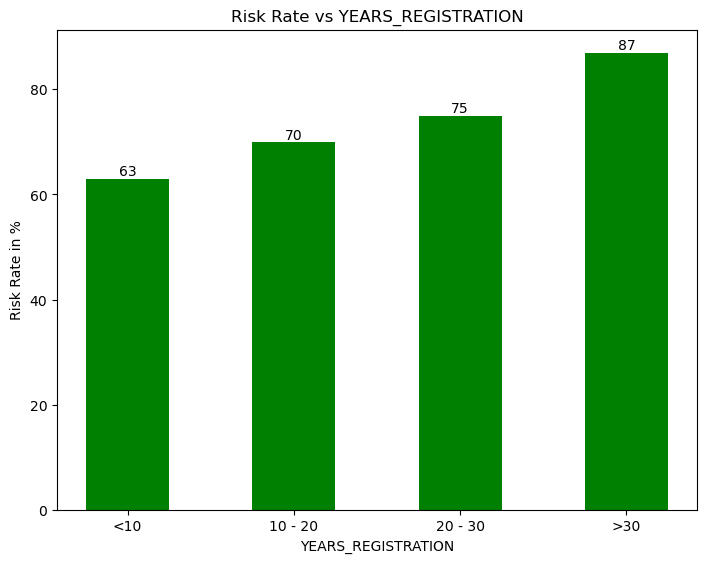

In [641]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

bars = ax.bar(years_registration_risk_groups.keys(),years_registration_risk_groups.values(), width=0.5, color = "green")
ax.bar_label(bars)
plt.title("Risk Rate vs YEARS_REGISTRATION")
plt.xlabel('YEARS_REGISTRATION')
plt.ylabel('Risk Rate in %')
plt.show()

In [642]:
print("The dp difference for YEARS_REGISTRATION is ", max(years_registration_risk_groups.values()) - min(years_registration_risk_groups.values()))

registration_dp = round(min(years_registration_risk_groups.values()) / max(years_registration_risk_groups.values()),2)
print("The dp ratio for YEARS_REGISTRATION is ", registration_dp)

dp_ratio_features.update({"YEARS_REGISTRATION":registration_dp})

The dp difference for YEARS_REGISTRATION is  24.0
The dp ratio for YEARS_REGISTRATION is  0.72


In [643]:
display(dp_ratio_features)
len(dp_ratio_features)

{'NAME_CONTRACT_TYPE': 0.85,
 'CODE_GENDER': 0.86,
 'FLAG_OWN_CAR': 0.84,
 'FLAG_OWN_REALTY': 0.99,
 'CNT_CHILDREN': 0.0,
 'AMT_INCOME_TOTAL': 0.79,
 'AMT_CREDIT': 0.67,
 'AMT_ANNUITY': 0.76,
 'AMT_GOODS_PRICE': 0.74,
 'NAME_TYPE_SUITE': 0.4,
 'NAME_INCOME_TYPE': 0.77,
 'NAME_EDUCATION_TYPE': 0.55,
 'NAME_FAMILY_STATUS': 0.78,
 'NAME_HOUSING_TYPE': 0.43,
 'REGION_POPULATION_RELATIVE': 0.77,
 'AGE': 0.53,
 'YEARS_EMPLOYED': 0.67,
 'YEARS_REGISTRATION': 0.72}

18

19. YEARS_ID_PUBLISH

In [644]:
test_df["YEARS_ID_PUBLISH"].min(), test_df["YEARS_ID_PUBLISH"].max()

(0.0, 17.0)

In [645]:
# <5
# 5-10
# >10

In [646]:
sr_id_publish = MetricFrame(metrics=selection_rate, y_true=predictions_test, y_pred=predictions_test,sensitive_features=test_df["YEARS_ID_PUBLISH"])
display(sr_id_publish.by_group)

YEARS_ID_PUBLISH
0.0     0.600000
1.0     0.566038
2.0     0.656250
3.0     0.542373
4.0     0.622642
5.0     0.625000
6.0     0.629032
7.0     0.712121
8.0     0.666667
9.0     0.754386
10.0    0.600000
11.0    0.627119
12.0    0.752137
13.0    0.782609
14.0    0.859649
15.0    0.833333
16.0    0.818182
17.0    1.000000
Name: selection_rate, dtype: float64

In [647]:
lessthan_5 = sr_id_publish.by_group.loc[:5]
btw_5_10 = sr_id_publish.by_group.loc[6:10]
gt_10 = sr_id_publish.by_group.loc[11:]

lessthan_5_risk_rate = 100*round(np.mean(lessthan_5),2)
btw_5_10_risk_rate = 100*round(np.mean(btw_5_10),2)
gt_10_risk_rate = 100*round(np.mean(gt_10),2)


id_publish_risk_groups= {"<5" : lessthan_5_risk_rate, "5-10" : btw_5_10_risk_rate, ">10": gt_10_risk_rate}
id_publish_risk_groups

{'<5': 60.0, '5-10': 67.0, '>10': 81.0}

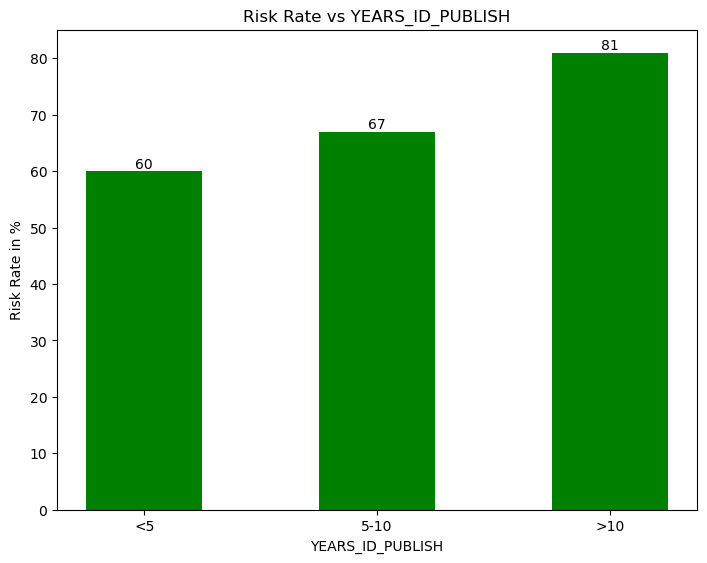

In [648]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

bars = ax.bar(id_publish_risk_groups.keys(),id_publish_risk_groups.values(), width=0.5, color = "green")
ax.bar_label(bars)
plt.title("Risk Rate vs YEARS_ID_PUBLISH")
plt.xlabel('YEARS_ID_PUBLISH')
plt.ylabel('Risk Rate in %')
plt.show()

In [649]:
print("The dp difference for YEARS_ID_PUBLISH is ", max(id_publish_risk_groups.values()) - min(id_publish_risk_groups.values()))

id_publish_dp = round(min(id_publish_risk_groups.values()) / max(id_publish_risk_groups.values()),2)
print("The dp ratio for YEARS_ID_PUBLISH is ", id_publish_dp)

dp_ratio_features.update({"YEARS_ID_PUBLISH":id_publish_dp})

The dp difference for YEARS_ID_PUBLISH is  21.0
The dp ratio for YEARS_ID_PUBLISH is  0.74


In [650]:
display(dp_ratio_features)
len(dp_ratio_features)

{'NAME_CONTRACT_TYPE': 0.85,
 'CODE_GENDER': 0.86,
 'FLAG_OWN_CAR': 0.84,
 'FLAG_OWN_REALTY': 0.99,
 'CNT_CHILDREN': 0.0,
 'AMT_INCOME_TOTAL': 0.79,
 'AMT_CREDIT': 0.67,
 'AMT_ANNUITY': 0.76,
 'AMT_GOODS_PRICE': 0.74,
 'NAME_TYPE_SUITE': 0.4,
 'NAME_INCOME_TYPE': 0.77,
 'NAME_EDUCATION_TYPE': 0.55,
 'NAME_FAMILY_STATUS': 0.78,
 'NAME_HOUSING_TYPE': 0.43,
 'REGION_POPULATION_RELATIVE': 0.77,
 'AGE': 0.53,
 'YEARS_EMPLOYED': 0.67,
 'YEARS_REGISTRATION': 0.72,
 'YEARS_ID_PUBLISH': 0.74}

19

20. FLAG_MOBIL

In [651]:
sr_mobile = MetricFrame(metrics=selection_rate, y_true=predictions_test, y_pred=predictions_test, sensitive_features=test_df["FLAG_MOBIL"])
# display(sr.overall)
display(sr_mobile.by_group)

FLAG_MOBIL
Yes    0.685
Name: selection_rate, dtype: float64

In [653]:
# print("The dp difference for FLAG_OWN_REALTY is ", max(realty_risk_groups.values()) - min(realty_risk_groups.values()))

# realty_dp = round(min(realty_risk_groups.values()) / max(realty_risk_groups.values()),2)
# print("The dp ratio for FLAG_OWN_REALTY is ", realty_dp)

dp_ratio_features.update({"FLAG_MOBIL": 0.315})

In [654]:
display(dp_ratio_features)
len(dp_ratio_features)

{'NAME_CONTRACT_TYPE': 0.85,
 'CODE_GENDER': 0.86,
 'FLAG_OWN_CAR': 0.84,
 'FLAG_OWN_REALTY': 0.99,
 'CNT_CHILDREN': 0.0,
 'AMT_INCOME_TOTAL': 0.79,
 'AMT_CREDIT': 0.67,
 'AMT_ANNUITY': 0.76,
 'AMT_GOODS_PRICE': 0.74,
 'NAME_TYPE_SUITE': 0.4,
 'NAME_INCOME_TYPE': 0.77,
 'NAME_EDUCATION_TYPE': 0.55,
 'NAME_FAMILY_STATUS': 0.78,
 'NAME_HOUSING_TYPE': 0.43,
 'REGION_POPULATION_RELATIVE': 0.77,
 'AGE': 0.53,
 'YEARS_EMPLOYED': 0.67,
 'YEARS_REGISTRATION': 0.72,
 'YEARS_ID_PUBLISH': 0.74,
 'FLAG_MOBIL': 0.315}

20

21. FLAG_EMP_PHONE

In [655]:
test_df["FLAG_EMP_PHONE"].unique()

array(['Yes', 'No'], dtype=object)

In [656]:
sr_emp_mobile = MetricFrame(metrics=selection_rate, y_true=predictions_test, y_pred=predictions_test, sensitive_features=test_df["FLAG_EMP_PHONE"])
# display(sr.overall)
display(sr_emp_mobile.by_group)

FLAG_EMP_PHONE
No     0.824176
Yes    0.654034
Name: selection_rate, dtype: float64

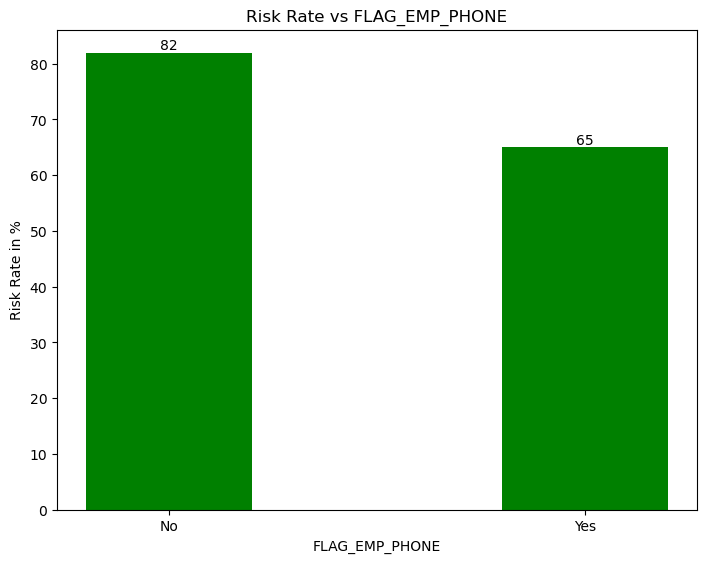

In [657]:
emp_mobile_groups= {"No" : round(100*sr_emp_mobile.by_group.loc["No"]), 
                           "Yes" : round(100*sr_emp_mobile.by_group.loc["Yes"])}

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

bars = ax.bar(emp_mobile_groups.keys(),emp_mobile_groups.values(), width=0.4, color = "green")
ax.bar_label(bars)
plt.title("Risk Rate vs FLAG_EMP_PHONE")
plt.xlabel('FLAG_EMP_PHONE')
plt.ylabel('Risk Rate in %')
plt.show()

In [658]:
print("The dp difference for FLAG_EMP_PHONE is ", max(emp_mobile_groups.values()) - min(emp_mobile_groups.values()))

emp_phone_dp = round(min(emp_mobile_groups.values()) / max(emp_mobile_groups.values()),2)
print("The dp ratio for FLAG_EMP_PHONE is ", emp_phone_dp)

dp_ratio_features.update({"FLAG_EMP_PHONE": emp_phone_dp})

The dp difference for FLAG_EMP_PHONE is  17
The dp ratio for FLAG_EMP_PHONE is  0.79


In [659]:
display(dp_ratio_features)
len(dp_ratio_features)

{'NAME_CONTRACT_TYPE': 0.85,
 'CODE_GENDER': 0.86,
 'FLAG_OWN_CAR': 0.84,
 'FLAG_OWN_REALTY': 0.99,
 'CNT_CHILDREN': 0.0,
 'AMT_INCOME_TOTAL': 0.79,
 'AMT_CREDIT': 0.67,
 'AMT_ANNUITY': 0.76,
 'AMT_GOODS_PRICE': 0.74,
 'NAME_TYPE_SUITE': 0.4,
 'NAME_INCOME_TYPE': 0.77,
 'NAME_EDUCATION_TYPE': 0.55,
 'NAME_FAMILY_STATUS': 0.78,
 'NAME_HOUSING_TYPE': 0.43,
 'REGION_POPULATION_RELATIVE': 0.77,
 'AGE': 0.53,
 'YEARS_EMPLOYED': 0.67,
 'YEARS_REGISTRATION': 0.72,
 'YEARS_ID_PUBLISH': 0.74,
 'FLAG_MOBIL': 0.315,
 'FLAG_EMP_PHONE': 0.79}

21

22. FLAG_WORK_PHONE

In [660]:
test_df["FLAG_WORK_PHONE"].unique()

array(['No', 'Yes'], dtype=object)

In [661]:
sr_work_phone = MetricFrame(metrics=selection_rate, y_true=predictions_test, y_pred=predictions_test, sensitive_features=test_df["FLAG_WORK_PHONE"])
# display(sr.overall)
display(sr_work_phone.by_group)

FLAG_WORK_PHONE
No     0.716814
Yes    0.564593
Name: selection_rate, dtype: float64

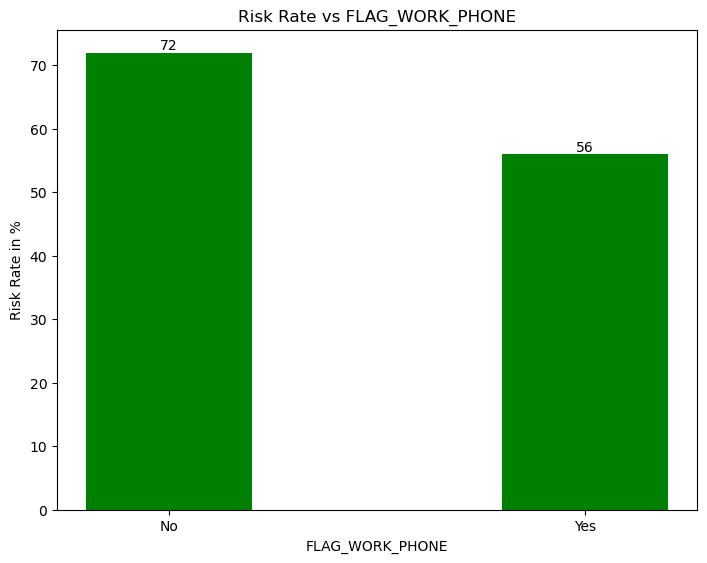

In [662]:
work_phone_groups= {"No" : round(100*sr_work_phone.by_group.loc["No"]), 
                           "Yes" : round(100*sr_work_phone.by_group.loc["Yes"])}

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

bars = ax.bar(work_phone_groups.keys(),work_phone_groups.values(), width=0.4, color = "green")
ax.bar_label(bars)
plt.title("Risk Rate vs FLAG_WORK_PHONE")
plt.xlabel('FLAG_WORK_PHONE')
plt.ylabel('Risk Rate in %')
plt.show()

In [663]:
print("The dp difference for FLAG_WORK_PHONE is ", max(work_phone_groups.values()) - min(work_phone_groups.values()))

work_phone_dp = round(min(work_phone_groups.values()) / max(work_phone_groups.values()),2)
print("The dp ratio for FLAG_WORK_PHONE is ", work_phone_dp)

dp_ratio_features.update({"FLAG_WORK_PHONE": work_phone_dp})

The dp difference for FLAG_WORK_PHONE is  16
The dp ratio for FLAG_WORK_PHONE is  0.78


In [664]:
display(dp_ratio_features)
len(dp_ratio_features)

{'NAME_CONTRACT_TYPE': 0.85,
 'CODE_GENDER': 0.86,
 'FLAG_OWN_CAR': 0.84,
 'FLAG_OWN_REALTY': 0.99,
 'CNT_CHILDREN': 0.0,
 'AMT_INCOME_TOTAL': 0.79,
 'AMT_CREDIT': 0.67,
 'AMT_ANNUITY': 0.76,
 'AMT_GOODS_PRICE': 0.74,
 'NAME_TYPE_SUITE': 0.4,
 'NAME_INCOME_TYPE': 0.77,
 'NAME_EDUCATION_TYPE': 0.55,
 'NAME_FAMILY_STATUS': 0.78,
 'NAME_HOUSING_TYPE': 0.43,
 'REGION_POPULATION_RELATIVE': 0.77,
 'AGE': 0.53,
 'YEARS_EMPLOYED': 0.67,
 'YEARS_REGISTRATION': 0.72,
 'YEARS_ID_PUBLISH': 0.74,
 'FLAG_MOBIL': 0.315,
 'FLAG_EMP_PHONE': 0.79,
 'FLAG_WORK_PHONE': 0.78}

22

23. FLAG_CONT_MOBILE

In [665]:
test_df["FLAG_CONT_MOBILE"].unique()

array(['Yes', 'No'], dtype=object)

In [666]:
sr_cont_mobile = MetricFrame(metrics=selection_rate, y_true=predictions_test, y_pred=predictions_test, sensitive_features=test_df["FLAG_CONT_MOBILE"])
# display(sr.overall)
display(sr_cont_mobile.by_group)

FLAG_CONT_MOBILE
No     1.000000
Yes    0.684685
Name: selection_rate, dtype: float64

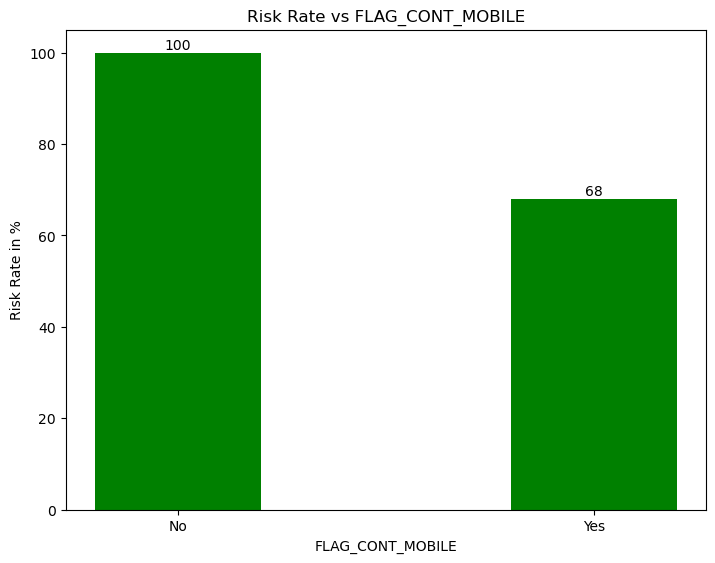

In [667]:
cont_mobile_groups= {"No" : round(100*sr_cont_mobile.by_group.loc["No"]), 
                           "Yes" : round(100*sr_cont_mobile.by_group.loc["Yes"])}

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

bars = ax.bar(cont_mobile_groups.keys(),cont_mobile_groups.values(), width=0.4, color = "green")
ax.bar_label(bars)
plt.title("Risk Rate vs FLAG_CONT_MOBILE")
plt.xlabel('FLAG_CONT_MOBILE')
plt.ylabel('Risk Rate in %')
plt.show()

In [668]:
print("The dp difference for FLAG_CONT_MOBILE is ", max(cont_mobile_groups.values()) - min(cont_mobile_groups.values()))

cont_mobile_dp = round(min(cont_mobile_groups.values()) / max(cont_mobile_groups.values()),2)
print("The dp ratio for FLAG_CONT_MOBILE is ", cont_mobile_dp)

dp_ratio_features.update({"FLAG_CONT_MOBILE": cont_mobile_dp})

The dp difference for FLAG_CONT_MOBILE is  32
The dp ratio for FLAG_CONT_MOBILE is  0.68


In [669]:
dp_ratio_features.update({"FLAG_MOBIL": 0.32})

In [670]:
display(dp_ratio_features)
len(dp_ratio_features)

{'NAME_CONTRACT_TYPE': 0.85,
 'CODE_GENDER': 0.86,
 'FLAG_OWN_CAR': 0.84,
 'FLAG_OWN_REALTY': 0.99,
 'CNT_CHILDREN': 0.0,
 'AMT_INCOME_TOTAL': 0.79,
 'AMT_CREDIT': 0.67,
 'AMT_ANNUITY': 0.76,
 'AMT_GOODS_PRICE': 0.74,
 'NAME_TYPE_SUITE': 0.4,
 'NAME_INCOME_TYPE': 0.77,
 'NAME_EDUCATION_TYPE': 0.55,
 'NAME_FAMILY_STATUS': 0.78,
 'NAME_HOUSING_TYPE': 0.43,
 'REGION_POPULATION_RELATIVE': 0.77,
 'AGE': 0.53,
 'YEARS_EMPLOYED': 0.67,
 'YEARS_REGISTRATION': 0.72,
 'YEARS_ID_PUBLISH': 0.74,
 'FLAG_MOBIL': 0.32,
 'FLAG_EMP_PHONE': 0.79,
 'FLAG_WORK_PHONE': 0.78,
 'FLAG_CONT_MOBILE': 0.68}

23

24. FLAG_PHONE

In [671]:
test_df["FLAG_PHONE"].unique()

array(['No', 'Yes'], dtype=object)

In [672]:
sr_phone = MetricFrame(metrics=selection_rate, y_true=predictions_test, y_pred=predictions_test, sensitive_features=test_df["FLAG_PHONE"])
# display(sr.overall)
display(sr_phone.by_group)

FLAG_PHONE
No     0.660377
Yes    0.755814
Name: selection_rate, dtype: float64

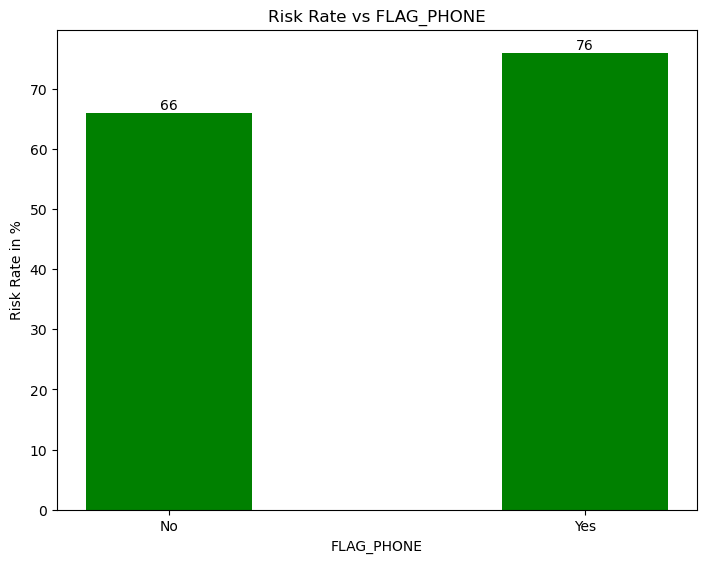

In [673]:
phone_groups= {"No" : round(100*sr_phone.by_group.loc["No"]), 
                           "Yes" : round(100*sr_phone.by_group.loc["Yes"])}

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

bars = ax.bar(phone_groups.keys(),phone_groups.values(), width=0.4, color = "green")
ax.bar_label(bars)
plt.title("Risk Rate vs FLAG_PHONE")
plt.xlabel('FLAG_PHONE')
plt.ylabel('Risk Rate in %')
plt.show()

In [674]:
print("The dp difference for FLAG_PHONE is ", max(phone_groups.values()) - min(phone_groups.values()))

phone_dp = round(min(phone_groups.values()) / max(phone_groups.values()),2)
print("The dp ratio for FLAG_PHONE is ", phone_dp)

dp_ratio_features.update({"FLAG_PHONE": phone_dp})

The dp difference for FLAG_PHONE is  10
The dp ratio for FLAG_PHONE is  0.87


In [675]:
display(dp_ratio_features)
len(dp_ratio_features)

{'NAME_CONTRACT_TYPE': 0.85,
 'CODE_GENDER': 0.86,
 'FLAG_OWN_CAR': 0.84,
 'FLAG_OWN_REALTY': 0.99,
 'CNT_CHILDREN': 0.0,
 'AMT_INCOME_TOTAL': 0.79,
 'AMT_CREDIT': 0.67,
 'AMT_ANNUITY': 0.76,
 'AMT_GOODS_PRICE': 0.74,
 'NAME_TYPE_SUITE': 0.4,
 'NAME_INCOME_TYPE': 0.77,
 'NAME_EDUCATION_TYPE': 0.55,
 'NAME_FAMILY_STATUS': 0.78,
 'NAME_HOUSING_TYPE': 0.43,
 'REGION_POPULATION_RELATIVE': 0.77,
 'AGE': 0.53,
 'YEARS_EMPLOYED': 0.67,
 'YEARS_REGISTRATION': 0.72,
 'YEARS_ID_PUBLISH': 0.74,
 'FLAG_MOBIL': 0.32,
 'FLAG_EMP_PHONE': 0.79,
 'FLAG_WORK_PHONE': 0.78,
 'FLAG_CONT_MOBILE': 0.68,
 'FLAG_PHONE': 0.87}

24

25. FLAG_EMAIL

In [676]:
test_df["FLAG_EMAIL"].unique()

array(['Yes', 'No'], dtype=object)

In [677]:
sr_email = MetricFrame(metrics=selection_rate, y_true=predictions_test, y_pred=predictions_test, sensitive_features=test_df["FLAG_EMAIL"])

display(sr_email.by_group)

FLAG_EMAIL
No     0.676996
Yes    0.726708
Name: selection_rate, dtype: float64

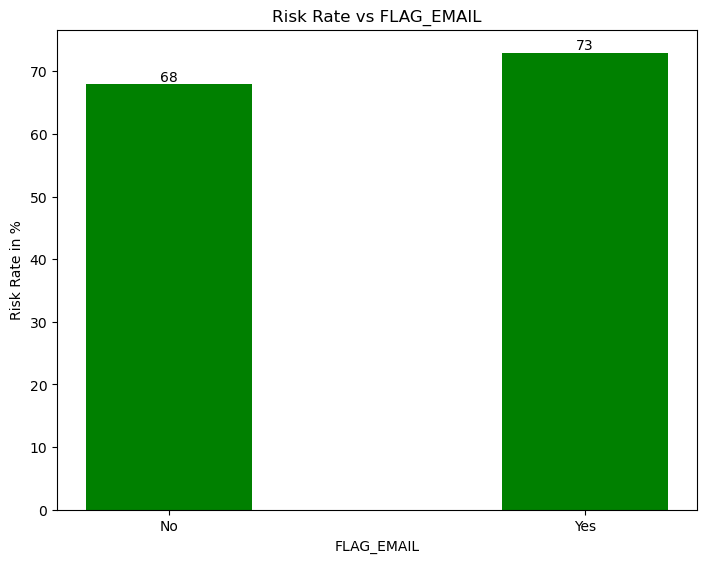

In [678]:
email_groups= {"No" : round(100*sr_email.by_group.loc["No"]), 
                           "Yes" : round(100*sr_email.by_group.loc["Yes"])}

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

bars = ax.bar(email_groups.keys(),email_groups.values(), width=0.4, color = "green")
ax.bar_label(bars)
plt.title("Risk Rate vs FLAG_EMAIL")
plt.xlabel('FLAG_EMAIL')
plt.ylabel('Risk Rate in %')
plt.show()

In [679]:
print("The dp difference for FLAG_EMAIL is ", max(email_groups.values()) - min(email_groups.values()))

email_dp = round(min(email_groups.values()) / max(email_groups.values()),2)
print("The dp ratio for FLAG_EMAIL is ", email_dp)

dp_ratio_features.update({"FLAG_EMAIL": email_dp})

The dp difference for FLAG_EMAIL is  5
The dp ratio for FLAG_EMAIL is  0.93


In [680]:
# del dp_ratio_features["email_dp"]

In [681]:
display(dp_ratio_features)
len(dp_ratio_features)

{'NAME_CONTRACT_TYPE': 0.85,
 'CODE_GENDER': 0.86,
 'FLAG_OWN_CAR': 0.84,
 'FLAG_OWN_REALTY': 0.99,
 'CNT_CHILDREN': 0.0,
 'AMT_INCOME_TOTAL': 0.79,
 'AMT_CREDIT': 0.67,
 'AMT_ANNUITY': 0.76,
 'AMT_GOODS_PRICE': 0.74,
 'NAME_TYPE_SUITE': 0.4,
 'NAME_INCOME_TYPE': 0.77,
 'NAME_EDUCATION_TYPE': 0.55,
 'NAME_FAMILY_STATUS': 0.78,
 'NAME_HOUSING_TYPE': 0.43,
 'REGION_POPULATION_RELATIVE': 0.77,
 'AGE': 0.53,
 'YEARS_EMPLOYED': 0.67,
 'YEARS_REGISTRATION': 0.72,
 'YEARS_ID_PUBLISH': 0.74,
 'FLAG_MOBIL': 0.32,
 'FLAG_EMP_PHONE': 0.79,
 'FLAG_WORK_PHONE': 0.78,
 'FLAG_CONT_MOBILE': 0.68,
 'FLAG_PHONE': 0.87,
 'FLAG_EMAIL': 0.93}

25

26. OCCUPATION_TYPE

In [682]:
test_df_fornull = test_df["OCCUPATION_TYPE"]
test_df_fornull.fillna("Unknown", inplace = True)

In [683]:
sr_occupation = MetricFrame(metrics=selection_rate, y_true=predictions_test, y_pred=predictions_test, sensitive_features=test_df_fornull)

display(sr_occupation.by_group)

OCCUPATION_TYPE
Accountants              1.000000
Cleaning staff           0.500000
Cooking staff            0.333333
Core staff               0.812500
Drivers                  0.574468
HR staff                 1.000000
High skill tech staff    0.815789
IT staff                 1.000000
Laborers                 0.606796
Low-skill Laborers       0.400000
Managers                 0.847458
Medicine staff           0.588235
Private service staff    0.555556
Realty agents            1.000000
Sales staff              0.485714
Secretaries              0.750000
Security staff           0.555556
Unknown                  0.761006
Waiters/barmen staff     0.500000
Name: selection_rate, dtype: float64

In [684]:
test_df["OCCUPATION_TYPE"].unique()

array(['Unknown', 'Low-skill Laborers', 'Drivers', 'Sales staff',
       'High skill tech staff', 'Core staff', 'Laborers', 'Managers',
       'Accountants', 'Medicine staff', 'Security staff',
       'Private service staff', 'Secretaries', 'Cleaning staff',
       'Cooking staff', 'HR staff', 'Waiters/barmen staff',
       'Realty agents', 'IT staff'], dtype=object)

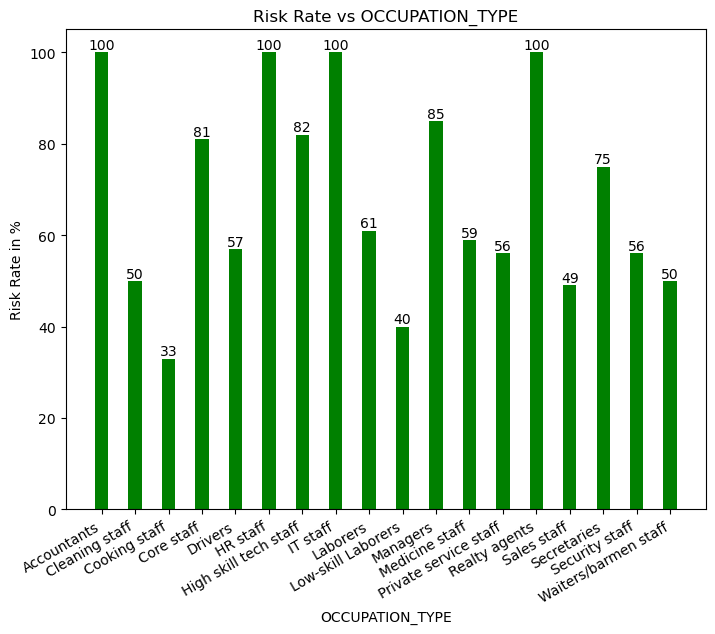

In [685]:
occupation_groups= {"Accountants" : round(100*sr_occupation.by_group.loc["Accountants"]), 
                    "Cleaning staff" : round(100*sr_occupation.by_group.loc["Cleaning staff"]),
                   "Cooking staff" : round(100*sr_occupation.by_group.loc["Cooking staff"]),
                   "Core staff" : round(100*sr_occupation.by_group.loc["Core staff"]),
                    "Drivers" : round(100*sr_occupation.by_group.loc["Drivers"]),
                   "HR staff" : round(100*sr_occupation.by_group.loc["HR staff"]),
                   "High skill tech staff" : round(100*sr_occupation.by_group.loc["High skill tech staff"]),
                   "IT staff" : round(100*sr_occupation.by_group.loc["IT staff"]),
                   "Laborers" : round(100*sr_occupation.by_group.loc["Laborers"]),
                   "Low-skill Laborers" : round(100*sr_occupation.by_group.loc["Low-skill Laborers"]),
                   "Managers" : round(100*sr_occupation.by_group.loc["Managers"]),
                   "Medicine staff" : round(100*sr_occupation.by_group.loc["Medicine staff"]),
                   "Private service staff" : round(100*sr_occupation.by_group.loc["Private service staff"]),
                   "Realty agents" : round(100*sr_occupation.by_group.loc["Realty agents"]),
                   "Sales staff" : round(100*sr_occupation.by_group.loc["Sales staff"]),
                   "Secretaries" : round(100*sr_occupation.by_group.loc["Secretaries"]),
                   "Security staff" : round(100*sr_occupation.by_group.loc["Security staff"]),
                   "Waiters/barmen staff" : round(100*sr_occupation.by_group.loc["Waiters/barmen staff"]),
#                     "Unknown" : round(100*sr_occupation.by_group.loc["Unknown"])
                   }

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

bars = ax.bar(occupation_groups.keys(),occupation_groups.values(), width=0.4, color = "green")
ax.bar_label(bars)
plt.title("Risk Rate vs OCCUPATION_TYPE")
plt.xlabel('OCCUPATION_TYPE')
plt.ylabel('Risk Rate in %')
fig.autofmt_xdate()
plt.show()

In [686]:
print("The dp difference for OCCUPATION_TYPE is ", max(occupation_groups.values()) - min(occupation_groups.values()))

occupation_dp = round(min(occupation_groups.values()) / max(occupation_groups.values()),2)
print("The dp ratio for OCCUPATION_TYPE is ", occupation_dp)

dp_ratio_features.update({"OCCUPATION_TYPE": occupation_dp})

The dp difference for OCCUPATION_TYPE is  67
The dp ratio for OCCUPATION_TYPE is  0.33


In [687]:
display(dp_ratio_features)
len(dp_ratio_features)

{'NAME_CONTRACT_TYPE': 0.85,
 'CODE_GENDER': 0.86,
 'FLAG_OWN_CAR': 0.84,
 'FLAG_OWN_REALTY': 0.99,
 'CNT_CHILDREN': 0.0,
 'AMT_INCOME_TOTAL': 0.79,
 'AMT_CREDIT': 0.67,
 'AMT_ANNUITY': 0.76,
 'AMT_GOODS_PRICE': 0.74,
 'NAME_TYPE_SUITE': 0.4,
 'NAME_INCOME_TYPE': 0.77,
 'NAME_EDUCATION_TYPE': 0.55,
 'NAME_FAMILY_STATUS': 0.78,
 'NAME_HOUSING_TYPE': 0.43,
 'REGION_POPULATION_RELATIVE': 0.77,
 'AGE': 0.53,
 'YEARS_EMPLOYED': 0.67,
 'YEARS_REGISTRATION': 0.72,
 'YEARS_ID_PUBLISH': 0.74,
 'FLAG_MOBIL': 0.32,
 'FLAG_EMP_PHONE': 0.79,
 'FLAG_WORK_PHONE': 0.78,
 'FLAG_CONT_MOBILE': 0.68,
 'FLAG_PHONE': 0.87,
 'FLAG_EMAIL': 0.93,
 'OCCUPATION_TYPE': 0.33}

26

27. CNT_FAM_MEMBERS

In [688]:
test_df["CNT_FAM_MEMBERS"].min(), test_df["CNT_FAM_MEMBERS"].max()

(1.0, 10.0)

In [689]:
# <=2
# 3-5
# >=5

In [690]:
sr_family_members = MetricFrame(metrics=selection_rate, y_true=predictions_test, y_pred=predictions_test,sensitive_features=test_df["CNT_FAM_MEMBERS"])
display(sr_family_members.by_group)

CNT_FAM_MEMBERS
1.0     0.671958
2.0     0.706107
3.0     0.639594
4.0     0.684211
5.0     0.727273
6.0     1.000000
10.0    0.000000
Name: selection_rate, dtype: float64

In [691]:
lessthan_2 = sr_family_members.by_group.loc[:2]
btw_3_5 = sr_family_members.by_group.loc[3:4]
gt_5 = sr_family_members.by_group.loc[5:]

lessthan_2_risk_rate = 100*round(np.mean(lessthan_2),2)
btw_3_5_risk_rate = 100*round(np.mean(btw_3_5),2)
gt_5_risk_rate = 100*round(np.mean(gt_5),2)


family_members_risk_groups= {"<=2" : lessthan_2_risk_rate, "3-5" : btw_3_5_risk_rate, ">=5": gt_5_risk_rate}
family_members_risk_groups

{'<=2': 69.0, '3-5': 66.0, '>=5': 57.99999999999999}

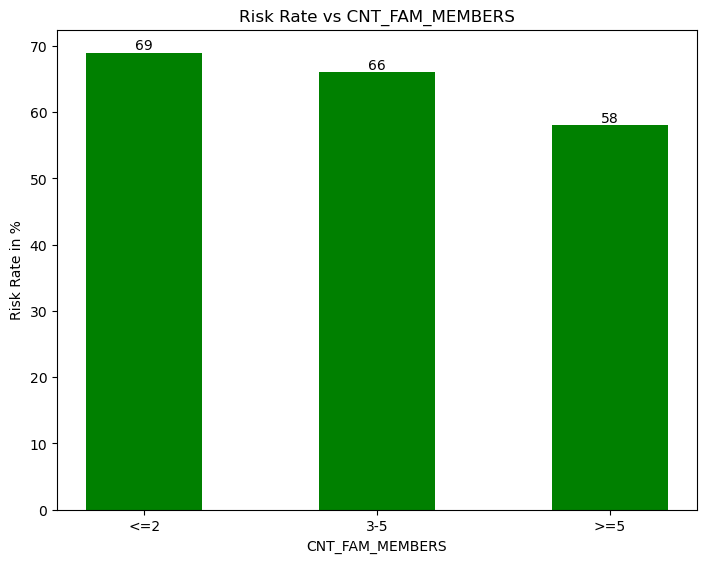

In [692]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

bars = ax.bar(family_members_risk_groups.keys(),family_members_risk_groups.values(), width=0.5, color = "green")
ax.bar_label(bars)
plt.title("Risk Rate vs CNT_FAM_MEMBERS")
plt.xlabel('CNT_FAM_MEMBERS')
plt.ylabel('Risk Rate in %')
plt.show()

In [693]:
print("The dp difference for CNT_FAM_MEMBERS is ", max(family_members_risk_groups.values()) - min(family_members_risk_groups.values()))

fam_mem_dp = round(min(family_members_risk_groups.values()) / max(family_members_risk_groups.values()),2)
print("The dp ratio for CNT_FAM_MEMBERS is ", fam_mem_dp)

dp_ratio_features.update({"CNT_FAM_MEMBERS":fam_mem_dp})

The dp difference for CNT_FAM_MEMBERS is  11.000000000000007
The dp ratio for CNT_FAM_MEMBERS is  0.84


In [694]:
display(dp_ratio_features)
len(dp_ratio_features)

{'NAME_CONTRACT_TYPE': 0.85,
 'CODE_GENDER': 0.86,
 'FLAG_OWN_CAR': 0.84,
 'FLAG_OWN_REALTY': 0.99,
 'CNT_CHILDREN': 0.0,
 'AMT_INCOME_TOTAL': 0.79,
 'AMT_CREDIT': 0.67,
 'AMT_ANNUITY': 0.76,
 'AMT_GOODS_PRICE': 0.74,
 'NAME_TYPE_SUITE': 0.4,
 'NAME_INCOME_TYPE': 0.77,
 'NAME_EDUCATION_TYPE': 0.55,
 'NAME_FAMILY_STATUS': 0.78,
 'NAME_HOUSING_TYPE': 0.43,
 'REGION_POPULATION_RELATIVE': 0.77,
 'AGE': 0.53,
 'YEARS_EMPLOYED': 0.67,
 'YEARS_REGISTRATION': 0.72,
 'YEARS_ID_PUBLISH': 0.74,
 'FLAG_MOBIL': 0.32,
 'FLAG_EMP_PHONE': 0.79,
 'FLAG_WORK_PHONE': 0.78,
 'FLAG_CONT_MOBILE': 0.68,
 'FLAG_PHONE': 0.87,
 'FLAG_EMAIL': 0.93,
 'OCCUPATION_TYPE': 0.33,
 'CNT_FAM_MEMBERS': 0.84}

27

28. REGION_RATING_CLIENT

In [695]:
test_df["REGION_RATING_CLIENT"].unique()

array([2, 1, 3], dtype=int64)

In [696]:
sr_region_rating = MetricFrame(metrics=selection_rate, y_true=predictions_test, y_pred=predictions_test, sensitive_features=test_df["REGION_RATING_CLIENT"])

display(sr_region_rating.by_group)

REGION_RATING_CLIENT
1    0.831579
2    0.687500
3    0.591716
Name: selection_rate, dtype: float64

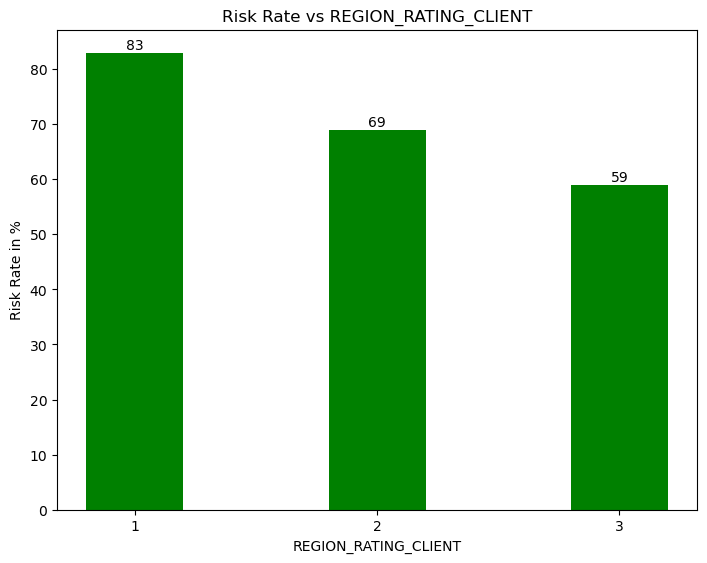

In [697]:
region_rating_groups= {"1" : round(100*sr_region_rating.by_group.loc[1]), 
                        "2" : round(100*sr_region_rating.by_group.loc[2]),
                        "3" : round(100*sr_region_rating.by_group.loc[3])}

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

bars = ax.bar(region_rating_groups.keys(),region_rating_groups.values(), width=0.4, color = "green")
ax.bar_label(bars)
plt.title("Risk Rate vs REGION_RATING_CLIENT")
plt.xlabel('REGION_RATING_CLIENT')
plt.ylabel('Risk Rate in %')
plt.show()

In [698]:
print("The dp difference for REGION_RATING_CLIENT is ", max(region_rating_groups.values()) - min(region_rating_groups.values()))

region_rating_dp = round(min(region_rating_groups.values()) / max(region_rating_groups.values()),2)
print("The dp ratio for REGION_RATING_CLIENT is ", region_rating_dp)

dp_ratio_features.update({"REGION_RATING_CLIENT": region_rating_dp})

The dp difference for REGION_RATING_CLIENT is  24
The dp ratio for REGION_RATING_CLIENT is  0.71


In [699]:
display(dp_ratio_features)
len(dp_ratio_features)

{'NAME_CONTRACT_TYPE': 0.85,
 'CODE_GENDER': 0.86,
 'FLAG_OWN_CAR': 0.84,
 'FLAG_OWN_REALTY': 0.99,
 'CNT_CHILDREN': 0.0,
 'AMT_INCOME_TOTAL': 0.79,
 'AMT_CREDIT': 0.67,
 'AMT_ANNUITY': 0.76,
 'AMT_GOODS_PRICE': 0.74,
 'NAME_TYPE_SUITE': 0.4,
 'NAME_INCOME_TYPE': 0.77,
 'NAME_EDUCATION_TYPE': 0.55,
 'NAME_FAMILY_STATUS': 0.78,
 'NAME_HOUSING_TYPE': 0.43,
 'REGION_POPULATION_RELATIVE': 0.77,
 'AGE': 0.53,
 'YEARS_EMPLOYED': 0.67,
 'YEARS_REGISTRATION': 0.72,
 'YEARS_ID_PUBLISH': 0.74,
 'FLAG_MOBIL': 0.32,
 'FLAG_EMP_PHONE': 0.79,
 'FLAG_WORK_PHONE': 0.78,
 'FLAG_CONT_MOBILE': 0.68,
 'FLAG_PHONE': 0.87,
 'FLAG_EMAIL': 0.93,
 'OCCUPATION_TYPE': 0.33,
 'CNT_FAM_MEMBERS': 0.84,
 'REGION_RATING_CLIENT': 0.71}

28

29. REGION_RATING_CLIENT_W_CITY

In [700]:
test_df["REGION_RATING_CLIENT_W_CITY"].unique()

array([2, 1, 3], dtype=int64)

In [701]:
sr_region_rating_w_city = MetricFrame(metrics=selection_rate, y_true=predictions_test, y_pred=predictions_test, sensitive_features=test_df["REGION_RATING_CLIENT_W_CITY"])

display(sr_region_rating_w_city.by_group)

REGION_RATING_CLIENT_W_CITY
1    0.841584
2    0.686406
3    0.576923
Name: selection_rate, dtype: float64

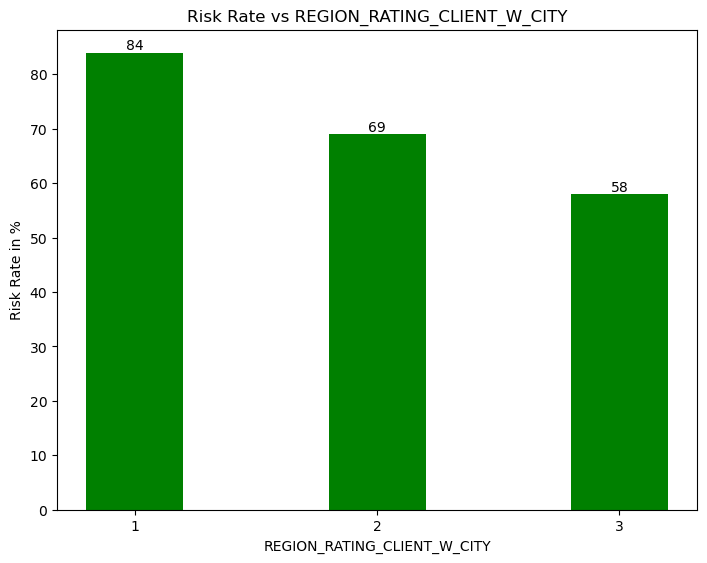

In [702]:
region_rating_w_city_groups= {"1" : round(100*sr_region_rating_w_city.by_group.loc[1]), 
                        "2" : round(100*sr_region_rating_w_city.by_group.loc[2]),
                        "3" : round(100*sr_region_rating_w_city.by_group.loc[3])}

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

bars = ax.bar(region_rating_w_city_groups.keys(),region_rating_w_city_groups.values(), width=0.4, color = "green")
ax.bar_label(bars)
plt.title("Risk Rate vs REGION_RATING_CLIENT_W_CITY")
plt.xlabel('REGION_RATING_CLIENT_W_CITY')
plt.ylabel('Risk Rate in %')
plt.show()

In [703]:
print("The dp difference for REGION_RATING_CLIENT_W_CITY is ", max(region_rating_w_city_groups.values()) - min(region_rating_w_city_groups.values()))

region_rating_w_city_dp = round(min(region_rating_w_city_groups.values()) / max(region_rating_w_city_groups.values()),2)
print("The dp ratio for REGION_RATING_CLIENT_W_CITY is ", region_rating_w_city_dp)

dp_ratio_features.update({"REGION_RATING_CLIENT_W_CITY": region_rating_w_city_dp})

The dp difference for REGION_RATING_CLIENT_W_CITY is  26
The dp ratio for REGION_RATING_CLIENT_W_CITY is  0.69


In [704]:
display(dp_ratio_features)
len(dp_ratio_features)

{'NAME_CONTRACT_TYPE': 0.85,
 'CODE_GENDER': 0.86,
 'FLAG_OWN_CAR': 0.84,
 'FLAG_OWN_REALTY': 0.99,
 'CNT_CHILDREN': 0.0,
 'AMT_INCOME_TOTAL': 0.79,
 'AMT_CREDIT': 0.67,
 'AMT_ANNUITY': 0.76,
 'AMT_GOODS_PRICE': 0.74,
 'NAME_TYPE_SUITE': 0.4,
 'NAME_INCOME_TYPE': 0.77,
 'NAME_EDUCATION_TYPE': 0.55,
 'NAME_FAMILY_STATUS': 0.78,
 'NAME_HOUSING_TYPE': 0.43,
 'REGION_POPULATION_RELATIVE': 0.77,
 'AGE': 0.53,
 'YEARS_EMPLOYED': 0.67,
 'YEARS_REGISTRATION': 0.72,
 'YEARS_ID_PUBLISH': 0.74,
 'FLAG_MOBIL': 0.32,
 'FLAG_EMP_PHONE': 0.79,
 'FLAG_WORK_PHONE': 0.78,
 'FLAG_CONT_MOBILE': 0.68,
 'FLAG_PHONE': 0.87,
 'FLAG_EMAIL': 0.93,
 'OCCUPATION_TYPE': 0.33,
 'CNT_FAM_MEMBERS': 0.84,
 'REGION_RATING_CLIENT': 0.71,
 'REGION_RATING_CLIENT_W_CITY': 0.69}

29

30. WEEKDAY_APPR_PROCESS_START

In [705]:
test_df["WEEKDAY_APPR_PROCESS_START"].unique()

array(['TUESDAY', 'FRIDAY', 'MONDAY', 'WEDNESDAY', 'THURSDAY', 'SATURDAY',
       'SUNDAY'], dtype=object)

In [706]:
sr_weekday = MetricFrame(metrics=selection_rate, y_true=predictions_test, y_pred=predictions_test, sensitive_features=test_df["WEEKDAY_APPR_PROCESS_START"])

display(sr_weekday.by_group)

WEEKDAY_APPR_PROCESS_START
FRIDAY       0.674847
MONDAY       0.685185
SATURDAY     0.735632
SUNDAY       0.702703
THURSDAY     0.696629
TUESDAY      0.654822
WEDNESDAY    0.687500
Name: selection_rate, dtype: float64

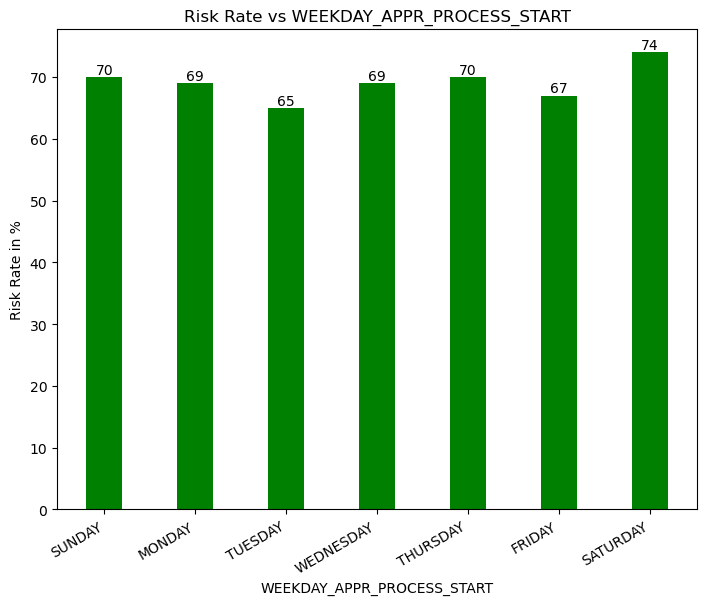

In [707]:
weekday_groups= {"SUNDAY" : round(100*sr_weekday.by_group.loc["SUNDAY"]),
                 "MONDAY" : round(100*sr_weekday.by_group.loc["MONDAY"]), 
                "TUESDAY" : round(100*sr_weekday.by_group.loc["TUESDAY"]),
                "WEDNESDAY" : round(100*sr_weekday.by_group.loc["WEDNESDAY"]),
                "THURSDAY" : round(100*sr_weekday.by_group.loc["THURSDAY"]),
                "FRIDAY" : round(100*sr_weekday.by_group.loc["FRIDAY"]),
                "SATURDAY" : round(100*sr_weekday.by_group.loc["SATURDAY"])
                   }

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

bars = ax.bar(weekday_groups.keys(),weekday_groups.values(), width=0.4, color = "green")
ax.bar_label(bars)
plt.title("Risk Rate vs WEEKDAY_APPR_PROCESS_START")
plt.xlabel('WEEKDAY_APPR_PROCESS_START')
plt.ylabel('Risk Rate in %')
fig.autofmt_xdate()
plt.show()

In [708]:
print("The dp difference for WEEKDAY_APPR_PROCESS_START is ", max(weekday_groups.values()) - min(weekday_groups.values()))

weekday_dp = round(min(weekday_groups.values()) / max(weekday_groups.values()),2)
print("The dp ratio for WEEKDAY_APPR_PROCESS_START is ", weekday_dp)

dp_ratio_features.update({"WEEKDAY_APPR_PROCESS_START": weekday_dp})

The dp difference for WEEKDAY_APPR_PROCESS_START is  9
The dp ratio for WEEKDAY_APPR_PROCESS_START is  0.88


In [709]:
display(dp_ratio_features)
len(dp_ratio_features)

{'NAME_CONTRACT_TYPE': 0.85,
 'CODE_GENDER': 0.86,
 'FLAG_OWN_CAR': 0.84,
 'FLAG_OWN_REALTY': 0.99,
 'CNT_CHILDREN': 0.0,
 'AMT_INCOME_TOTAL': 0.79,
 'AMT_CREDIT': 0.67,
 'AMT_ANNUITY': 0.76,
 'AMT_GOODS_PRICE': 0.74,
 'NAME_TYPE_SUITE': 0.4,
 'NAME_INCOME_TYPE': 0.77,
 'NAME_EDUCATION_TYPE': 0.55,
 'NAME_FAMILY_STATUS': 0.78,
 'NAME_HOUSING_TYPE': 0.43,
 'REGION_POPULATION_RELATIVE': 0.77,
 'AGE': 0.53,
 'YEARS_EMPLOYED': 0.67,
 'YEARS_REGISTRATION': 0.72,
 'YEARS_ID_PUBLISH': 0.74,
 'FLAG_MOBIL': 0.32,
 'FLAG_EMP_PHONE': 0.79,
 'FLAG_WORK_PHONE': 0.78,
 'FLAG_CONT_MOBILE': 0.68,
 'FLAG_PHONE': 0.87,
 'FLAG_EMAIL': 0.93,
 'OCCUPATION_TYPE': 0.33,
 'CNT_FAM_MEMBERS': 0.84,
 'REGION_RATING_CLIENT': 0.71,
 'REGION_RATING_CLIENT_W_CITY': 0.69,
 'WEEKDAY_APPR_PROCESS_START': 0.88}

30

31. HOUR_APPR_PROCESS_START

In [710]:
test_df["HOUR_APPR_PROCESS_START"].min(), test_df["HOUR_APPR_PROCESS_START"].max()

(2, 23)

In [711]:

# Before 9 am (Before Office Hours) : 0-9
# 9am to 1 pm (Office Hours: Morning): 9-13
# 1pm to 5 pm(Office Hours:Afternoon): 13 - 17   
# 5pm - 9 am (After Office Hours): >17
# <=2
# 3-5
# >=5

In [712]:
sr_hour_application = MetricFrame(metrics=selection_rate, y_true=predictions_test, y_pred=predictions_test,sensitive_features=test_df["HOUR_APPR_PROCESS_START"])
display(sr_hour_application.by_group)

HOUR_APPR_PROCESS_START
2     1.000000
3     0.800000
4     0.625000
5     0.533333
6     0.500000
7     0.567568
8     0.745455
9     0.658537
10    0.734375
11    0.710744
12    0.713115
13    0.686047
14    0.670103
15    0.616438
16    0.734694
17    0.661290
18    0.827586
19    0.285714
20    1.000000
21    1.000000
23    0.000000
Name: selection_rate, dtype: float64

In [713]:
display(len(sr_hour_application.by_group))

21

In [714]:
before_9 = sr_hour_application.by_group.loc[0:8]
btw_9_13 = sr_hour_application.by_group.loc[9:13]
btw_13_17 = sr_hour_application.by_group.loc[14:17]
after_17 = sr_hour_application.by_group.loc[18:24]

# display(len(before_9))
# display(len(btw_9_13))
# display(len(btw_13_17))
# display(len(after_17))

before_9_risk_rate = 100*round(np.mean(before_9),2)
btw_9_13_risk_rate = 100*round(np.mean(btw_9_13),2)
btw_13_17_risk_rate = 100*round(np.mean(btw_13_17),2)
after_17_risk_rate = 100*round(np.mean(after_17),2)


hour_application_risk_groups= {"Midnight to 9 am (Before Office Hours) : 0-9" : before_9_risk_rate, 
                               "9am to 1 pm (Office Hours: Morning): 9-13" : btw_9_13_risk_rate, 
                               "1pm to 5 pm(Office Hours:Afternoon): 13 - 17": btw_13_17_risk_rate,
                                "5pm - Midnight (After Office Hours): >17": after_17_risk_rate}
hour_application_risk_groups

{'Midnight to 9 am (Before Office Hours) : 0-9': 68.0,
 '9am to 1 pm (Office Hours: Morning): 9-13': 70.0,
 '1pm to 5 pm(Office Hours:Afternoon): 13 - 17': 67.0,
 '5pm - Midnight (After Office Hours): >17': 62.0}

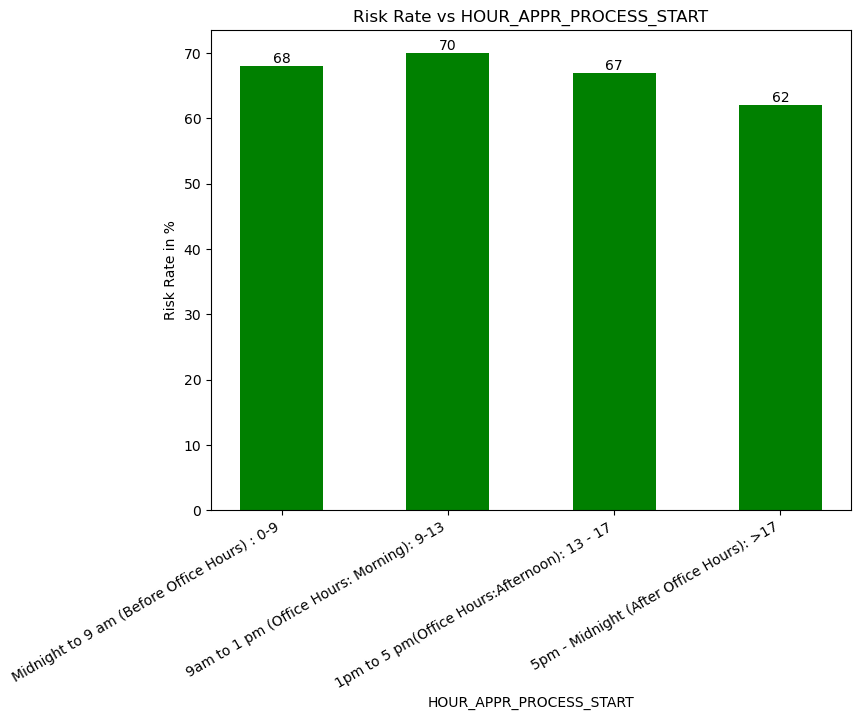

In [715]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

bars = ax.bar(hour_application_risk_groups.keys(),hour_application_risk_groups.values(), width=0.5, color = "green")
ax.bar_label(bars)
plt.title("Risk Rate vs HOUR_APPR_PROCESS_START")
plt.xlabel('HOUR_APPR_PROCESS_START')
plt.ylabel('Risk Rate in %')
fig.autofmt_xdate()
plt.show()

In [716]:
print("The dp difference for HOUR_APPR_PROCESS_START is ", max(hour_application_risk_groups.values()) - min(hour_application_risk_groups.values()))

hour_application_dp = round(min(hour_application_risk_groups.values()) / max(hour_application_risk_groups.values()),2)
print("The dp ratio for HOUR_APPR_PROCESS_START is ", hour_application_dp)

dp_ratio_features.update({"HOUR_APPR_PROCESS_START":hour_application_dp})

The dp difference for HOUR_APPR_PROCESS_START is  8.0
The dp ratio for HOUR_APPR_PROCESS_START is  0.89


In [717]:
display(dp_ratio_features)
len(dp_ratio_features)

{'NAME_CONTRACT_TYPE': 0.85,
 'CODE_GENDER': 0.86,
 'FLAG_OWN_CAR': 0.84,
 'FLAG_OWN_REALTY': 0.99,
 'CNT_CHILDREN': 0.0,
 'AMT_INCOME_TOTAL': 0.79,
 'AMT_CREDIT': 0.67,
 'AMT_ANNUITY': 0.76,
 'AMT_GOODS_PRICE': 0.74,
 'NAME_TYPE_SUITE': 0.4,
 'NAME_INCOME_TYPE': 0.77,
 'NAME_EDUCATION_TYPE': 0.55,
 'NAME_FAMILY_STATUS': 0.78,
 'NAME_HOUSING_TYPE': 0.43,
 'REGION_POPULATION_RELATIVE': 0.77,
 'AGE': 0.53,
 'YEARS_EMPLOYED': 0.67,
 'YEARS_REGISTRATION': 0.72,
 'YEARS_ID_PUBLISH': 0.74,
 'FLAG_MOBIL': 0.32,
 'FLAG_EMP_PHONE': 0.79,
 'FLAG_WORK_PHONE': 0.78,
 'FLAG_CONT_MOBILE': 0.68,
 'FLAG_PHONE': 0.87,
 'FLAG_EMAIL': 0.93,
 'OCCUPATION_TYPE': 0.33,
 'CNT_FAM_MEMBERS': 0.84,
 'REGION_RATING_CLIENT': 0.71,
 'REGION_RATING_CLIENT_W_CITY': 0.69,
 'WEEKDAY_APPR_PROCESS_START': 0.88,
 'HOUR_APPR_PROCESS_START': 0.89}

31

32. REG_REGION_NOT_LIVE_REGION

In [718]:
test_df["REG_REGION_NOT_LIVE_REGION"].unique()

array(['Same', 'Different'], dtype=object)

In [719]:
sr_region_live = MetricFrame(metrics=selection_rate, y_true=predictions_test, y_pred=predictions_test, sensitive_features=test_df["REG_REGION_NOT_LIVE_REGION"])

display(sr_region_live.by_group)

REG_REGION_NOT_LIVE_REGION
Different    0.720000
Same         0.684103
Name: selection_rate, dtype: float64

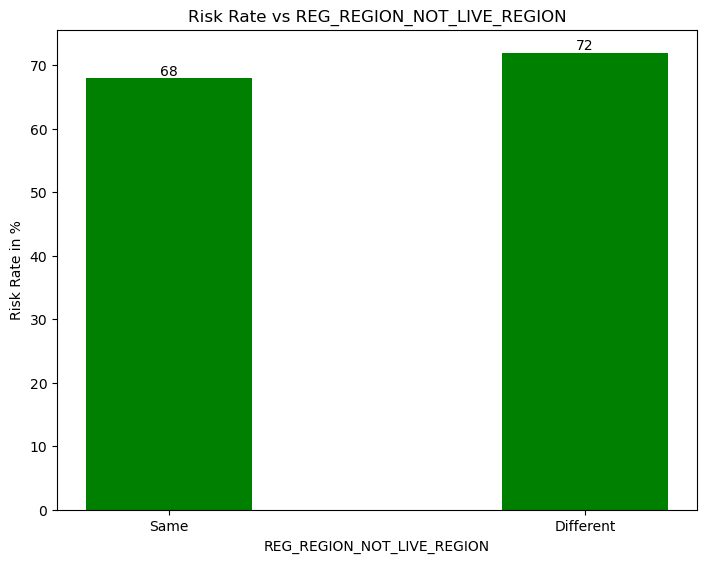

In [720]:
region_live_groups= {"Same" : round(100*sr_region_live.by_group.loc["Same"]), 
                           "Different" : round(100*sr_region_live.by_group.loc["Different"])}

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

bars = ax.bar(region_live_groups.keys(),region_live_groups.values(), width=0.4, color = "green")
ax.bar_label(bars)
plt.title("Risk Rate vs REG_REGION_NOT_LIVE_REGION")
plt.xlabel('REG_REGION_NOT_LIVE_REGION')
plt.ylabel('Risk Rate in %')
plt.show()

In [721]:
print("The dp difference for REG_REGION_NOT_LIVE_REGION is ", max(region_live_groups.values()) - min(region_live_groups.values()))

region_live_dp = round(min(region_live_groups.values()) / max(region_live_groups.values()),2)
print("The dp ratio for REG_REGION_NOT_LIVE_REGION is ", region_live_dp)

# dp_ratio_features.update({"email_dp": email_dp})
dp_ratio_features.update({"REG_REGION_NOT_LIVE_REGION": region_live_dp})

The dp difference for REG_REGION_NOT_LIVE_REGION is  4
The dp ratio for REG_REGION_NOT_LIVE_REGION is  0.94


In [722]:
display(dp_ratio_features)
len(dp_ratio_features)

{'NAME_CONTRACT_TYPE': 0.85,
 'CODE_GENDER': 0.86,
 'FLAG_OWN_CAR': 0.84,
 'FLAG_OWN_REALTY': 0.99,
 'CNT_CHILDREN': 0.0,
 'AMT_INCOME_TOTAL': 0.79,
 'AMT_CREDIT': 0.67,
 'AMT_ANNUITY': 0.76,
 'AMT_GOODS_PRICE': 0.74,
 'NAME_TYPE_SUITE': 0.4,
 'NAME_INCOME_TYPE': 0.77,
 'NAME_EDUCATION_TYPE': 0.55,
 'NAME_FAMILY_STATUS': 0.78,
 'NAME_HOUSING_TYPE': 0.43,
 'REGION_POPULATION_RELATIVE': 0.77,
 'AGE': 0.53,
 'YEARS_EMPLOYED': 0.67,
 'YEARS_REGISTRATION': 0.72,
 'YEARS_ID_PUBLISH': 0.74,
 'FLAG_MOBIL': 0.32,
 'FLAG_EMP_PHONE': 0.79,
 'FLAG_WORK_PHONE': 0.78,
 'FLAG_CONT_MOBILE': 0.68,
 'FLAG_PHONE': 0.87,
 'FLAG_EMAIL': 0.93,
 'OCCUPATION_TYPE': 0.33,
 'CNT_FAM_MEMBERS': 0.84,
 'REGION_RATING_CLIENT': 0.71,
 'REGION_RATING_CLIENT_W_CITY': 0.69,
 'WEEKDAY_APPR_PROCESS_START': 0.88,
 'HOUR_APPR_PROCESS_START': 0.89,
 'REG_REGION_NOT_LIVE_REGION': 0.94}

32

33. REG_REGION_NOT_WORK_REGION

In [723]:
test_df["REG_REGION_NOT_WORK_REGION"].unique()

array(['Same', 'Different'], dtype=object)

In [724]:
sr_region_work = MetricFrame(metrics=selection_rate, y_true=predictions_test, y_pred=predictions_test, sensitive_features=test_df["REG_REGION_NOT_WORK_REGION"])

display(sr_region_work.by_group)

REG_REGION_NOT_WORK_REGION
Different    0.666667
Same         0.685864
Name: selection_rate, dtype: float64

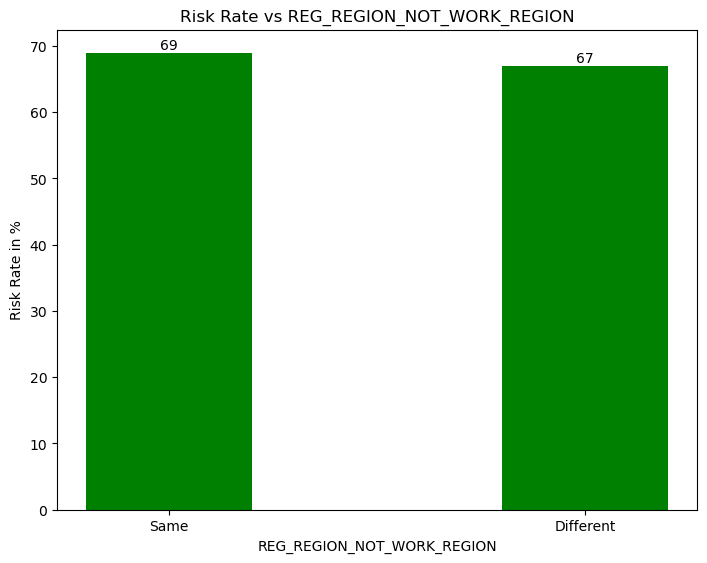

In [725]:
region_work_groups= {"Same" : round(100*sr_region_work.by_group.loc["Same"]), 
                           "Different" : round(100*sr_region_work.by_group.loc["Different"])}

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

bars = ax.bar(region_work_groups.keys(),region_work_groups.values(), width=0.4, color = "green")
ax.bar_label(bars)
plt.title("Risk Rate vs REG_REGION_NOT_WORK_REGION")
plt.xlabel('REG_REGION_NOT_WORK_REGION')
plt.ylabel('Risk Rate in %')
plt.show()

In [726]:
print("The dp difference for REG_REGION_NOT_WORK_REGION is ", max(region_work_groups.values()) - min(region_work_groups.values()))

region_work_dp = round(min(region_work_groups.values()) / max(region_work_groups.values()),2)
print("The dp ratio for REG_REGION_NOT_WORK_REGION is ", region_work_dp)

dp_ratio_features.update({"REG_REGION_NOT_WORK_REGION": region_work_dp})

The dp difference for REG_REGION_NOT_WORK_REGION is  2
The dp ratio for REG_REGION_NOT_WORK_REGION is  0.97


In [727]:
display(dp_ratio_features)
len(dp_ratio_features)

{'NAME_CONTRACT_TYPE': 0.85,
 'CODE_GENDER': 0.86,
 'FLAG_OWN_CAR': 0.84,
 'FLAG_OWN_REALTY': 0.99,
 'CNT_CHILDREN': 0.0,
 'AMT_INCOME_TOTAL': 0.79,
 'AMT_CREDIT': 0.67,
 'AMT_ANNUITY': 0.76,
 'AMT_GOODS_PRICE': 0.74,
 'NAME_TYPE_SUITE': 0.4,
 'NAME_INCOME_TYPE': 0.77,
 'NAME_EDUCATION_TYPE': 0.55,
 'NAME_FAMILY_STATUS': 0.78,
 'NAME_HOUSING_TYPE': 0.43,
 'REGION_POPULATION_RELATIVE': 0.77,
 'AGE': 0.53,
 'YEARS_EMPLOYED': 0.67,
 'YEARS_REGISTRATION': 0.72,
 'YEARS_ID_PUBLISH': 0.74,
 'FLAG_MOBIL': 0.32,
 'FLAG_EMP_PHONE': 0.79,
 'FLAG_WORK_PHONE': 0.78,
 'FLAG_CONT_MOBILE': 0.68,
 'FLAG_PHONE': 0.87,
 'FLAG_EMAIL': 0.93,
 'OCCUPATION_TYPE': 0.33,
 'CNT_FAM_MEMBERS': 0.84,
 'REGION_RATING_CLIENT': 0.71,
 'REGION_RATING_CLIENT_W_CITY': 0.69,
 'WEEKDAY_APPR_PROCESS_START': 0.88,
 'HOUR_APPR_PROCESS_START': 0.89,
 'REG_REGION_NOT_LIVE_REGION': 0.94,
 'REG_REGION_NOT_WORK_REGION': 0.97}

33

34. LIVE_REGION_NOT_WORK_REGION

In [728]:
test_df["LIVE_REGION_NOT_WORK_REGION"].unique()

array(['Same', 'Different'], dtype=object)

In [729]:
sr_live_work = MetricFrame(metrics=selection_rate, y_true=predictions_test, y_pred=predictions_test, sensitive_features=test_df["LIVE_REGION_NOT_WORK_REGION"])

display(sr_live_work.by_group)

LIVE_REGION_NOT_WORK_REGION
Different    0.677419
Same         0.685243
Name: selection_rate, dtype: float64

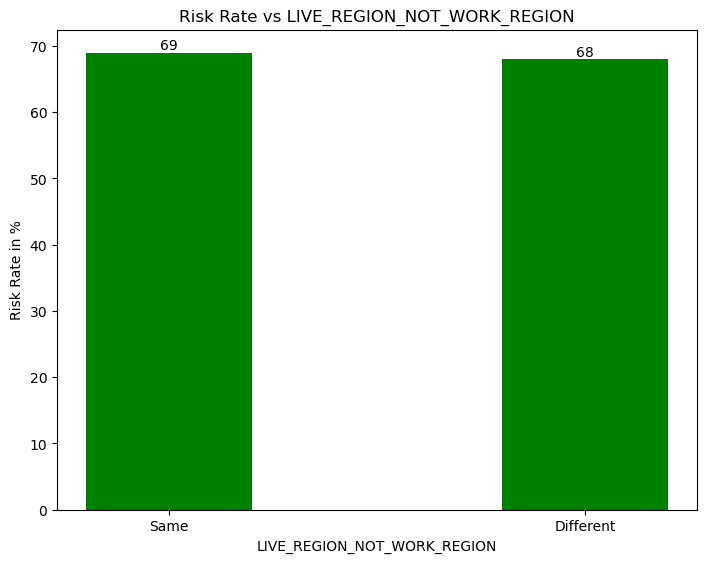

In [730]:
live_work_groups= {"Same" : round(100*sr_live_work.by_group.loc["Same"]), 
                           "Different" : round(100*sr_live_work.by_group.loc["Different"])}

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

bars = ax.bar(live_work_groups.keys(),live_work_groups.values(), width=0.4, color = "green")
ax.bar_label(bars)
plt.title("Risk Rate vs LIVE_REGION_NOT_WORK_REGION")
plt.xlabel('LIVE_REGION_NOT_WORK_REGION')
plt.ylabel('Risk Rate in %')
plt.show()

In [731]:
print("The dp difference for LIVE_REGION_NOT_WORK_REGION is ", max(live_work_groups.values()) - min(live_work_groups.values()))

live_work_dp = round(min(live_work_groups.values()) / max(live_work_groups.values()),2)
print("The dp ratio for LIVE_REGION_NOT_WORK_REGION is ", live_work_dp)

dp_ratio_features.update({"LIVE_REGION_NOT_WORK_REGION": live_work_dp})

The dp difference for LIVE_REGION_NOT_WORK_REGION is  1
The dp ratio for LIVE_REGION_NOT_WORK_REGION is  0.99


In [732]:
display(dp_ratio_features)
len(dp_ratio_features)

{'NAME_CONTRACT_TYPE': 0.85,
 'CODE_GENDER': 0.86,
 'FLAG_OWN_CAR': 0.84,
 'FLAG_OWN_REALTY': 0.99,
 'CNT_CHILDREN': 0.0,
 'AMT_INCOME_TOTAL': 0.79,
 'AMT_CREDIT': 0.67,
 'AMT_ANNUITY': 0.76,
 'AMT_GOODS_PRICE': 0.74,
 'NAME_TYPE_SUITE': 0.4,
 'NAME_INCOME_TYPE': 0.77,
 'NAME_EDUCATION_TYPE': 0.55,
 'NAME_FAMILY_STATUS': 0.78,
 'NAME_HOUSING_TYPE': 0.43,
 'REGION_POPULATION_RELATIVE': 0.77,
 'AGE': 0.53,
 'YEARS_EMPLOYED': 0.67,
 'YEARS_REGISTRATION': 0.72,
 'YEARS_ID_PUBLISH': 0.74,
 'FLAG_MOBIL': 0.32,
 'FLAG_EMP_PHONE': 0.79,
 'FLAG_WORK_PHONE': 0.78,
 'FLAG_CONT_MOBILE': 0.68,
 'FLAG_PHONE': 0.87,
 'FLAG_EMAIL': 0.93,
 'OCCUPATION_TYPE': 0.33,
 'CNT_FAM_MEMBERS': 0.84,
 'REGION_RATING_CLIENT': 0.71,
 'REGION_RATING_CLIENT_W_CITY': 0.69,
 'WEEKDAY_APPR_PROCESS_START': 0.88,
 'HOUR_APPR_PROCESS_START': 0.89,
 'REG_REGION_NOT_LIVE_REGION': 0.94,
 'REG_REGION_NOT_WORK_REGION': 0.97,
 'LIVE_REGION_NOT_WORK_REGION': 0.99}

34

35. REG_CITY_NOT_LIVE_CITY

In [733]:
test_df["REG_CITY_NOT_LIVE_CITY"].unique()

array(['Same', 'Different'], dtype=object)

In [734]:
sr_city_live = MetricFrame(metrics=selection_rate, y_true=predictions_test, y_pred=predictions_test, sensitive_features=test_df["REG_CITY_NOT_LIVE_CITY"])

display(sr_city_live.by_group)

REG_CITY_NOT_LIVE_CITY
Different    0.525641
Same         0.698482
Name: selection_rate, dtype: float64

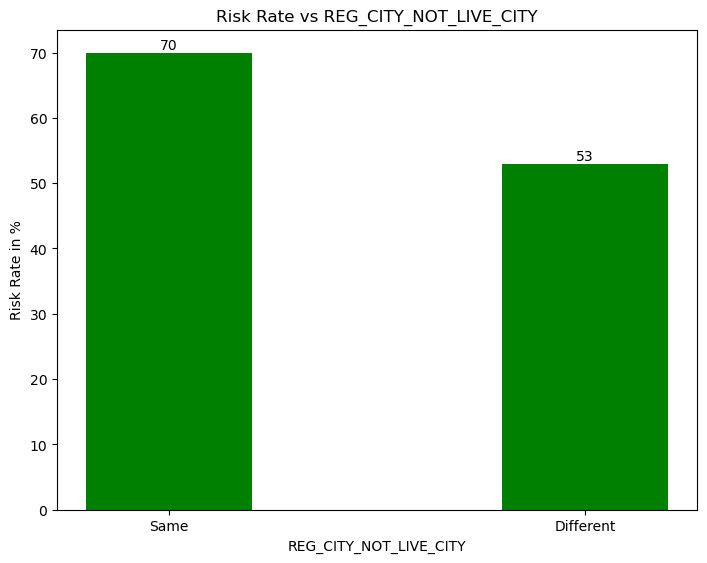

In [735]:
city_live_groups= {"Same" : round(100*sr_city_live.by_group.loc["Same"]), 
                           "Different" : round(100*sr_city_live.by_group.loc["Different"])}

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

bars = ax.bar(city_live_groups.keys(),city_live_groups.values(), width=0.4, color = "green")
ax.bar_label(bars)
plt.title("Risk Rate vs REG_CITY_NOT_LIVE_CITY")
plt.xlabel('REG_CITY_NOT_LIVE_CITY')
plt.ylabel('Risk Rate in %')
plt.show()

In [736]:
print("The dp difference for REG_CITY_NOT_LIVE_CITY is ", max(city_live_groups.values()) - min(city_live_groups.values()))

city_live_dp = round(min(city_live_groups.values()) / max(city_live_groups.values()),2)
print("The dp ratio for REG_CITY_NOT_LIVE_CITY is ", city_live_dp)

dp_ratio_features.update({"REG_CITY_NOT_LIVE_CITY": city_live_dp})

The dp difference for REG_CITY_NOT_LIVE_CITY is  17
The dp ratio for REG_CITY_NOT_LIVE_CITY is  0.76


In [737]:
display(dp_ratio_features)
len(dp_ratio_features)

{'NAME_CONTRACT_TYPE': 0.85,
 'CODE_GENDER': 0.86,
 'FLAG_OWN_CAR': 0.84,
 'FLAG_OWN_REALTY': 0.99,
 'CNT_CHILDREN': 0.0,
 'AMT_INCOME_TOTAL': 0.79,
 'AMT_CREDIT': 0.67,
 'AMT_ANNUITY': 0.76,
 'AMT_GOODS_PRICE': 0.74,
 'NAME_TYPE_SUITE': 0.4,
 'NAME_INCOME_TYPE': 0.77,
 'NAME_EDUCATION_TYPE': 0.55,
 'NAME_FAMILY_STATUS': 0.78,
 'NAME_HOUSING_TYPE': 0.43,
 'REGION_POPULATION_RELATIVE': 0.77,
 'AGE': 0.53,
 'YEARS_EMPLOYED': 0.67,
 'YEARS_REGISTRATION': 0.72,
 'YEARS_ID_PUBLISH': 0.74,
 'FLAG_MOBIL': 0.32,
 'FLAG_EMP_PHONE': 0.79,
 'FLAG_WORK_PHONE': 0.78,
 'FLAG_CONT_MOBILE': 0.68,
 'FLAG_PHONE': 0.87,
 'FLAG_EMAIL': 0.93,
 'OCCUPATION_TYPE': 0.33,
 'CNT_FAM_MEMBERS': 0.84,
 'REGION_RATING_CLIENT': 0.71,
 'REGION_RATING_CLIENT_W_CITY': 0.69,
 'WEEKDAY_APPR_PROCESS_START': 0.88,
 'HOUR_APPR_PROCESS_START': 0.89,
 'REG_REGION_NOT_LIVE_REGION': 0.94,
 'REG_REGION_NOT_WORK_REGION': 0.97,
 'LIVE_REGION_NOT_WORK_REGION': 0.99,
 'REG_CITY_NOT_LIVE_CITY': 0.76}

35

36. REG_CITY_NOT_WORK_CITY

In [738]:
test_df["REG_CITY_NOT_WORK_CITY"].unique()

array(['Same', 'Different'], dtype=object)

In [739]:
sr_city_work = MetricFrame(metrics=selection_rate, y_true=predictions_test, y_pred=predictions_test, sensitive_features=test_df["REG_CITY_NOT_WORK_CITY"])

display(sr_city_work.by_group)

REG_CITY_NOT_WORK_CITY
Different    0.533937
Same         0.727856
Name: selection_rate, dtype: float64

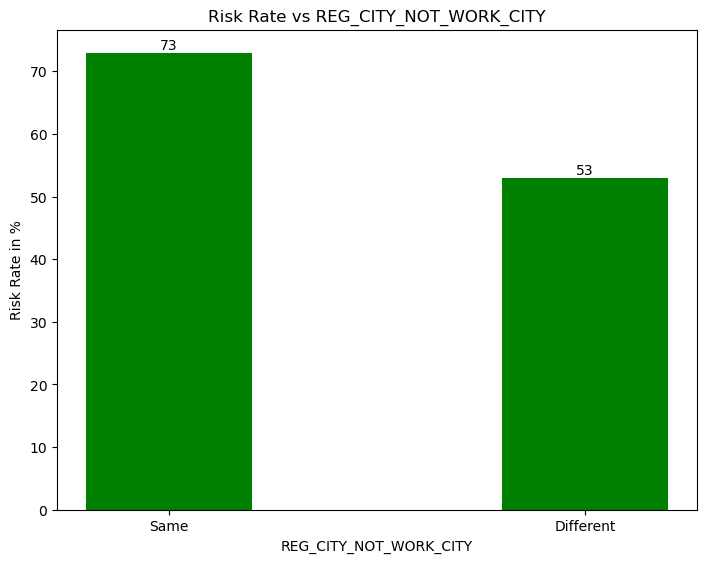

In [740]:
city_work_groups= {"Same" : round(100*sr_city_work.by_group.loc["Same"]), 
                           "Different" : round(100*sr_city_work.by_group.loc["Different"])}

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

bars = ax.bar(city_work_groups.keys(),city_work_groups.values(), width=0.4, color = "green")
ax.bar_label(bars)
plt.title("Risk Rate vs REG_CITY_NOT_WORK_CITY")
plt.xlabel('REG_CITY_NOT_WORK_CITY')
plt.ylabel('Risk Rate in %')
plt.show()

In [741]:
print("The dp difference for REG_CITY_NOT_WORK_CITY is ", max(city_work_groups.values()) - min(city_work_groups.values()))

city_work_dp = round(min(city_work_groups.values()) / max(city_work_groups.values()),2)
print("The dp ratio for REG_CITY_NOT_WORK_CITY is ", city_work_dp)

dp_ratio_features.update({"REG_CITY_NOT_WORK_CITY": city_work_dp})

The dp difference for REG_CITY_NOT_WORK_CITY is  20
The dp ratio for REG_CITY_NOT_WORK_CITY is  0.73


In [742]:
display(dp_ratio_features)
len(dp_ratio_features)

{'NAME_CONTRACT_TYPE': 0.85,
 'CODE_GENDER': 0.86,
 'FLAG_OWN_CAR': 0.84,
 'FLAG_OWN_REALTY': 0.99,
 'CNT_CHILDREN': 0.0,
 'AMT_INCOME_TOTAL': 0.79,
 'AMT_CREDIT': 0.67,
 'AMT_ANNUITY': 0.76,
 'AMT_GOODS_PRICE': 0.74,
 'NAME_TYPE_SUITE': 0.4,
 'NAME_INCOME_TYPE': 0.77,
 'NAME_EDUCATION_TYPE': 0.55,
 'NAME_FAMILY_STATUS': 0.78,
 'NAME_HOUSING_TYPE': 0.43,
 'REGION_POPULATION_RELATIVE': 0.77,
 'AGE': 0.53,
 'YEARS_EMPLOYED': 0.67,
 'YEARS_REGISTRATION': 0.72,
 'YEARS_ID_PUBLISH': 0.74,
 'FLAG_MOBIL': 0.32,
 'FLAG_EMP_PHONE': 0.79,
 'FLAG_WORK_PHONE': 0.78,
 'FLAG_CONT_MOBILE': 0.68,
 'FLAG_PHONE': 0.87,
 'FLAG_EMAIL': 0.93,
 'OCCUPATION_TYPE': 0.33,
 'CNT_FAM_MEMBERS': 0.84,
 'REGION_RATING_CLIENT': 0.71,
 'REGION_RATING_CLIENT_W_CITY': 0.69,
 'WEEKDAY_APPR_PROCESS_START': 0.88,
 'HOUR_APPR_PROCESS_START': 0.89,
 'REG_REGION_NOT_LIVE_REGION': 0.94,
 'REG_REGION_NOT_WORK_REGION': 0.97,
 'LIVE_REGION_NOT_WORK_REGION': 0.99,
 'REG_CITY_NOT_LIVE_CITY': 0.76,
 'REG_CITY_NOT_WORK_CITY': 0.73}

36

36. LIVE_CITY_NOT_WORK_CITY

In [743]:
test_df["LIVE_CITY_NOT_WORK_CITY"].unique()

array(['Same', 'Different'], dtype=object)

In [744]:
sr_live_work_city = MetricFrame(metrics=selection_rate, y_true=predictions_test, y_pred=predictions_test, sensitive_features=test_df["LIVE_CITY_NOT_WORK_CITY"])

display(sr_live_work_city.by_group)

LIVE_CITY_NOT_WORK_CITY
Different    0.543860
Same         0.714113
Name: selection_rate, dtype: float64

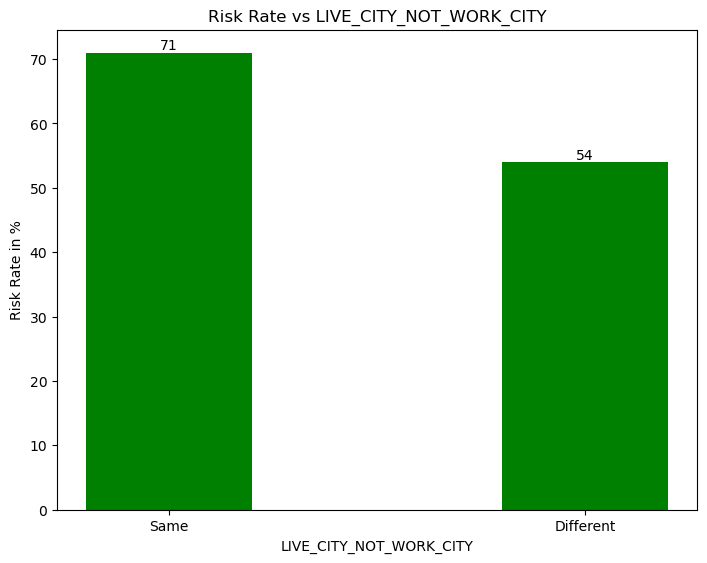

In [745]:
live_work_city_groups= {"Same" : round(100*sr_live_work_city.by_group.loc["Same"]), 
                           "Different" : round(100*sr_live_work_city.by_group.loc["Different"])}

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

bars = ax.bar(live_work_city_groups.keys(),live_work_city_groups.values(), width=0.4, color = "green")
ax.bar_label(bars)
plt.title("Risk Rate vs LIVE_CITY_NOT_WORK_CITY")
plt.xlabel('LIVE_CITY_NOT_WORK_CITY')
plt.ylabel('Risk Rate in %')
plt.show()

In [746]:
print("The dp difference for LIVE_CITY_NOT_WORK_CITY is ", max(live_work_city_groups.values()) - min(live_work_city_groups.values()))

live_work_city_dp = round(min(live_work_city_groups.values()) / max(live_work_city_groups.values()),2)
print("The dp ratio for LIVE_CITY_NOT_WORK_CITY is ", live_work_city_dp)

dp_ratio_features.update({"LIVE_CITY_NOT_WORK_CITY": live_work_city_dp})

The dp difference for LIVE_CITY_NOT_WORK_CITY is  17
The dp ratio for LIVE_CITY_NOT_WORK_CITY is  0.76


In [747]:
display(dp_ratio_features)
len(dp_ratio_features)

{'NAME_CONTRACT_TYPE': 0.85,
 'CODE_GENDER': 0.86,
 'FLAG_OWN_CAR': 0.84,
 'FLAG_OWN_REALTY': 0.99,
 'CNT_CHILDREN': 0.0,
 'AMT_INCOME_TOTAL': 0.79,
 'AMT_CREDIT': 0.67,
 'AMT_ANNUITY': 0.76,
 'AMT_GOODS_PRICE': 0.74,
 'NAME_TYPE_SUITE': 0.4,
 'NAME_INCOME_TYPE': 0.77,
 'NAME_EDUCATION_TYPE': 0.55,
 'NAME_FAMILY_STATUS': 0.78,
 'NAME_HOUSING_TYPE': 0.43,
 'REGION_POPULATION_RELATIVE': 0.77,
 'AGE': 0.53,
 'YEARS_EMPLOYED': 0.67,
 'YEARS_REGISTRATION': 0.72,
 'YEARS_ID_PUBLISH': 0.74,
 'FLAG_MOBIL': 0.32,
 'FLAG_EMP_PHONE': 0.79,
 'FLAG_WORK_PHONE': 0.78,
 'FLAG_CONT_MOBILE': 0.68,
 'FLAG_PHONE': 0.87,
 'FLAG_EMAIL': 0.93,
 'OCCUPATION_TYPE': 0.33,
 'CNT_FAM_MEMBERS': 0.84,
 'REGION_RATING_CLIENT': 0.71,
 'REGION_RATING_CLIENT_W_CITY': 0.69,
 'WEEKDAY_APPR_PROCESS_START': 0.88,
 'HOUR_APPR_PROCESS_START': 0.89,
 'REG_REGION_NOT_LIVE_REGION': 0.94,
 'REG_REGION_NOT_WORK_REGION': 0.97,
 'LIVE_REGION_NOT_WORK_REGION': 0.99,
 'REG_CITY_NOT_LIVE_CITY': 0.76,
 'REG_CITY_NOT_WORK_CITY': 0.73,


37

38. ORGANIZATION_TYPE

In [748]:
test_df["ORGANIZATION_TYPE"].unique()

array(['Kindergarten', 'Self-employed', 'Transport: type 3',
       'Business Entity Type 3', 'Government', 'Industry: type 9',
       'School', 'Trade: type 2', 'XNA', 'Services', 'Bank',
       'Industry: type 3', 'Other', 'Trade: type 6', 'Industry: type 12',
       'Trade: type 7', 'Postal', 'Medicine', 'Housing',
       'Business Entity Type 2', 'Construction', 'Military',
       'Industry: type 4', 'Trade: type 3', 'Legal Services', 'Security',
       'Industry: type 11', 'University', 'Business Entity Type 1',
       'Agriculture', 'Security Ministries', 'Transport: type 2',
       'Industry: type 7', 'Transport: type 4', 'Telecom', 'Emergency',
       'Police', 'Industry: type 1', 'Transport: type 1', 'Electricity',
       'Industry: type 5', 'Hotel', 'Restaurant', 'Advertising', 'Mobile'],
      dtype=object)

In [749]:
sr_organisation = MetricFrame(metrics=selection_rate, y_true=predictions_test, y_pred=predictions_test, sensitive_features=test_df["ORGANIZATION_TYPE"])

display(sr_organisation.by_group)

ORGANIZATION_TYPE
Advertising               1.000000
Agriculture               0.500000
Bank                      0.888889
Business Entity Type 1    0.785714
Business Entity Type 2    0.718750
Business Entity Type 3    0.592760
Construction              0.727273
Electricity               1.000000
Emergency                 0.000000
Government                0.789474
Hotel                     0.666667
Housing                   0.777778
Industry: type 1          0.500000
Industry: type 11         0.555556
Industry: type 12         1.000000
Industry: type 3          0.571429
Industry: type 4          0.600000
Industry: type 5          0.666667
Industry: type 7          0.000000
Industry: type 9          0.916667
Kindergarten              0.785714
Legal Services            1.000000
Medicine                  0.648649
Military                  0.750000
Mobile                    0.000000
Other                     0.746032
Police                    0.714286
Postal                    0.428571
Re

In [750]:
# Groups

Education = ['Kindergarten', 'School' , 'University']
Industry = ["Industry: type 1", "Industry: type 11", "Industry: type 12", "Industry: type 3", 
            "Industry: type 4", "Industry: type 5", "Industry: type 7", "Industry: type 9"]
Buisness_Entity = ["Business Entity Type 1","Business Entity Type 2","Business Entity Type 3"]
Trade= ["Trade: type 2","Trade: type 3","Trade: type 6","Trade: type 7"]
Transport= ["Transport: type 1","Transport: type 2","Transport: type 3", "Transport: type 4"]
Public_Sector=["Government", "Housing", "Military", "Police", "Postal", 'Security Ministries', "Medicine"]
Private_Sector= ['Advertising', 'Security', "Agriculture", "Electricity", "Hotel", "Mobile", "Restaurant", "Self-employed","Telecom"]
Unknown=["XNA"]
Others = ["Other", "Services", "Bank", "Construction", "Emergency", "Legal Services"]


In [751]:
print(len(sr_organisation.by_group))

45


In [752]:
Education_group = sr_organisation.by_group.loc[Education]
Industry_group = sr_organisation.by_group.loc[Industry]
Buisness_Entity_group = sr_organisation.by_group.loc[Buisness_Entity]
Trade_group = sr_organisation.by_group.loc[Trade]
Transport_group = sr_organisation.by_group.loc[Transport]
Public_Sector_group = sr_organisation.by_group.loc[Public_Sector]
Private_Sector_group = sr_organisation.by_group.loc[Private_Sector]
Others_group = sr_organisation.by_group.loc[Others]
Unknown_group = sr_organisation.by_group.loc[Unknown]


Education_risk_rate = 100*round(np.mean(Education_group),2)
Industry_risk_rate = 100*round(np.mean(Industry_group),2)
Buisness_Entity_risk_rate = 100*round(np.mean(Buisness_Entity_group),2)

Trade_risk_rate = 100*round(np.mean(Trade_group),2)
Transport_risk_rate = 100*round(np.mean(Transport_group),2)
Public_Sector_risk_rate = 100*round(np.mean(Public_Sector_group),2)
Private_Sector_risk_rate = 100*round(np.mean(Private_Sector_group),2)
Others_risk_rate = 100*round(np.mean(Others_group),2)
Unknown_risk_rate = 100*round(np.mean(Unknown_group),2)



organisation_groups= {"Education" : Education_risk_rate, 
                    "Industry" :Industry_risk_rate ,
                   "Buisness Entity" : Buisness_Entity_risk_rate,
                    "Trade" :round(Trade_risk_rate),
                   "Transport" : Transport_risk_rate,
                   "Public Sector" : Public_Sector_risk_rate,
                   "Private Sector" : Private_Sector_risk_rate,
                   "Others" : Others_risk_rate,
                "XNA" : Unknown_risk_rate,
                   }

organisation_groups

{'Education': 79.0,
 'Industry': 60.0,
 'Buisness Entity': 70.0,
 'Trade': 71,
 'Transport': 83.0,
 'Public Sector': 69.0,
 'Private Sector': 68.0,
 'Others': 70.0,
 'XNA': 82.0}

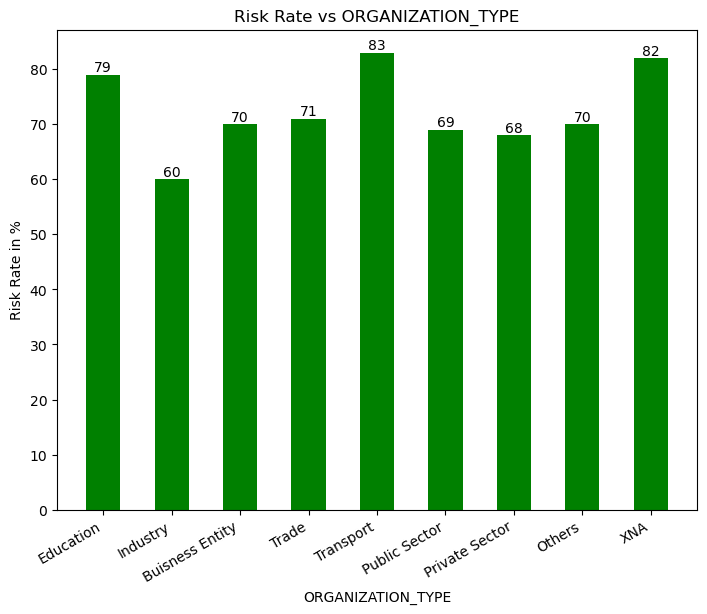

In [753]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

bars = ax.bar(organisation_groups.keys(),organisation_groups.values(), width=0.5, color = "green")
ax.bar_label(bars)
plt.title("Risk Rate vs ORGANIZATION_TYPE")
plt.xlabel('ORGANIZATION_TYPE')
plt.ylabel('Risk Rate in %')
fig.autofmt_xdate()
plt.show()

In [754]:
print("The dp difference for ORGANIZATION_TYPE is ", max(organisation_groups.values()) - min(organisation_groups.values()))

organisation_dp = round(min(organisation_groups.values()) / max(organisation_groups.values()),2)
print("The dp ratio for ORGANIZATION_TYPE is ", organisation_dp)

dp_ratio_features.update({"ORGANIZATION_TYPE": organisation_dp})

The dp difference for ORGANIZATION_TYPE is  23.0
The dp ratio for ORGANIZATION_TYPE is  0.72


In [755]:
display(dp_ratio_features)
len(dp_ratio_features)

{'NAME_CONTRACT_TYPE': 0.85,
 'CODE_GENDER': 0.86,
 'FLAG_OWN_CAR': 0.84,
 'FLAG_OWN_REALTY': 0.99,
 'CNT_CHILDREN': 0.0,
 'AMT_INCOME_TOTAL': 0.79,
 'AMT_CREDIT': 0.67,
 'AMT_ANNUITY': 0.76,
 'AMT_GOODS_PRICE': 0.74,
 'NAME_TYPE_SUITE': 0.4,
 'NAME_INCOME_TYPE': 0.77,
 'NAME_EDUCATION_TYPE': 0.55,
 'NAME_FAMILY_STATUS': 0.78,
 'NAME_HOUSING_TYPE': 0.43,
 'REGION_POPULATION_RELATIVE': 0.77,
 'AGE': 0.53,
 'YEARS_EMPLOYED': 0.67,
 'YEARS_REGISTRATION': 0.72,
 'YEARS_ID_PUBLISH': 0.74,
 'FLAG_MOBIL': 0.32,
 'FLAG_EMP_PHONE': 0.79,
 'FLAG_WORK_PHONE': 0.78,
 'FLAG_CONT_MOBILE': 0.68,
 'FLAG_PHONE': 0.87,
 'FLAG_EMAIL': 0.93,
 'OCCUPATION_TYPE': 0.33,
 'CNT_FAM_MEMBERS': 0.84,
 'REGION_RATING_CLIENT': 0.71,
 'REGION_RATING_CLIENT_W_CITY': 0.69,
 'WEEKDAY_APPR_PROCESS_START': 0.88,
 'HOUR_APPR_PROCESS_START': 0.89,
 'REG_REGION_NOT_LIVE_REGION': 0.94,
 'REG_REGION_NOT_WORK_REGION': 0.97,
 'LIVE_REGION_NOT_WORK_REGION': 0.99,
 'REG_CITY_NOT_LIVE_CITY': 0.76,
 'REG_CITY_NOT_WORK_CITY': 0.73,


38

39. OBS_30_CNT_SOCIAL_CIRCLE

In [756]:
test_df["OBS_30_CNT_SOCIAL_CIRCLE"].min(), test_df["OBS_30_CNT_SOCIAL_CIRCLE"].max()

(0.0, 23.0)

In [757]:
# <=5
# 6-10
# >10

In [758]:
sr_OBS_30 = MetricFrame(metrics=selection_rate, y_true=predictions_test, y_pred=predictions_test,sensitive_features=test_df["OBS_30_CNT_SOCIAL_CIRCLE"])
display(sr_OBS_30.by_group)

OBS_30_CNT_SOCIAL_CIRCLE
0.0     0.702290
1.0     0.677852
2.0     0.666667
3.0     0.666667
4.0     0.684211
5.0     0.684211
6.0     0.620690
7.0     0.611111
8.0     0.714286
9.0     0.666667
10.0    0.000000
11.0    1.000000
12.0    1.000000
14.0    1.000000
17.0    0.500000
18.0    0.000000
23.0    1.000000
Name: selection_rate, dtype: float64

In [759]:
lessthan_5 = sr_OBS_30.by_group.loc[:5]
btw_6_10 = sr_OBS_30.by_group.loc[6:9]
gt_10 = sr_OBS_30.by_group.loc[10:]

lessthan_5_risk_rate = 100*round(np.mean(lessthan_5),2)
btw_6_10_risk_rate = 100*round(np.mean(btw_6_10),2)
gt_10_risk_rate = 100*round(np.mean(gt_10),2)


OBS_30_risk_groups= {"<=5" : lessthan_5_risk_rate, "5-9" : btw_6_10_risk_rate, ">=10": gt_10_risk_rate}
OBS_30_risk_groups

{'<=5': 68.0, '5-9': 65.0, '>=10': 64.0}

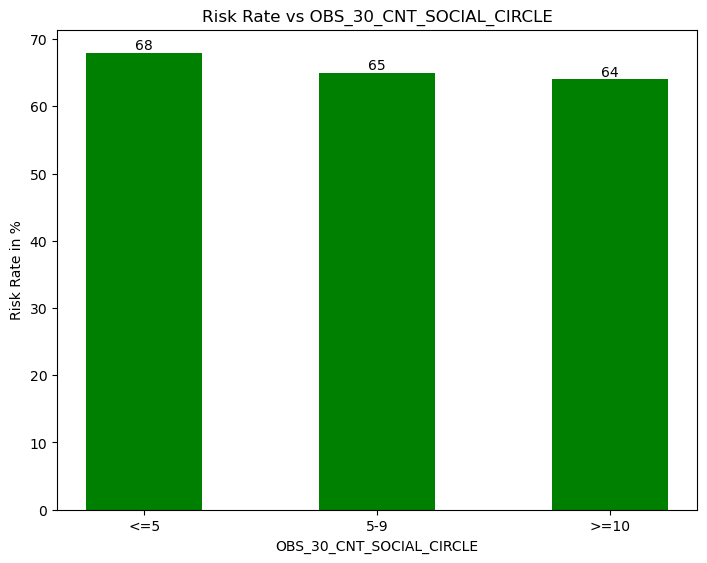

In [760]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

bars = ax.bar(OBS_30_risk_groups.keys(),OBS_30_risk_groups.values(), width=0.5, color = "green")
ax.bar_label(bars)
plt.title("Risk Rate vs OBS_30_CNT_SOCIAL_CIRCLE")
plt.xlabel('OBS_30_CNT_SOCIAL_CIRCLE')
plt.ylabel('Risk Rate in %')
plt.show()

In [761]:
print("The dp difference for OBS_30_CNT_SOCIAL_CIRCLE is ", max(OBS_30_risk_groups.values()) - min(OBS_30_risk_groups.values()))

OBS_30_dp = round(min(OBS_30_risk_groups.values()) / max(OBS_30_risk_groups.values()),2)
print("The dp ratio for OBS_30_CNT_SOCIAL_CIRCLE is ", OBS_30_dp)

dp_ratio_features.update({"OBS_30_CNT_SOCIAL_CIRCLE":OBS_30_dp})

The dp difference for OBS_30_CNT_SOCIAL_CIRCLE is  4.0
The dp ratio for OBS_30_CNT_SOCIAL_CIRCLE is  0.94


In [762]:
display(dp_ratio_features)
len(dp_ratio_features)

{'NAME_CONTRACT_TYPE': 0.85,
 'CODE_GENDER': 0.86,
 'FLAG_OWN_CAR': 0.84,
 'FLAG_OWN_REALTY': 0.99,
 'CNT_CHILDREN': 0.0,
 'AMT_INCOME_TOTAL': 0.79,
 'AMT_CREDIT': 0.67,
 'AMT_ANNUITY': 0.76,
 'AMT_GOODS_PRICE': 0.74,
 'NAME_TYPE_SUITE': 0.4,
 'NAME_INCOME_TYPE': 0.77,
 'NAME_EDUCATION_TYPE': 0.55,
 'NAME_FAMILY_STATUS': 0.78,
 'NAME_HOUSING_TYPE': 0.43,
 'REGION_POPULATION_RELATIVE': 0.77,
 'AGE': 0.53,
 'YEARS_EMPLOYED': 0.67,
 'YEARS_REGISTRATION': 0.72,
 'YEARS_ID_PUBLISH': 0.74,
 'FLAG_MOBIL': 0.32,
 'FLAG_EMP_PHONE': 0.79,
 'FLAG_WORK_PHONE': 0.78,
 'FLAG_CONT_MOBILE': 0.68,
 'FLAG_PHONE': 0.87,
 'FLAG_EMAIL': 0.93,
 'OCCUPATION_TYPE': 0.33,
 'CNT_FAM_MEMBERS': 0.84,
 'REGION_RATING_CLIENT': 0.71,
 'REGION_RATING_CLIENT_W_CITY': 0.69,
 'WEEKDAY_APPR_PROCESS_START': 0.88,
 'HOUR_APPR_PROCESS_START': 0.89,
 'REG_REGION_NOT_LIVE_REGION': 0.94,
 'REG_REGION_NOT_WORK_REGION': 0.97,
 'LIVE_REGION_NOT_WORK_REGION': 0.99,
 'REG_CITY_NOT_LIVE_CITY': 0.76,
 'REG_CITY_NOT_WORK_CITY': 0.73,


39

40. DEF_30_CNT_SOCIAL_CIRCLE

In [763]:
test_df["DEF_30_CNT_SOCIAL_CIRCLE"].unique()

array([0., 1., 2., 3., 4.])

In [764]:
sr_DEF_30 = MetricFrame(metrics=selection_rate, y_true=predictions_test, y_pred=predictions_test,sensitive_features=test_df["DEF_30_CNT_SOCIAL_CIRCLE"])
display(sr_DEF_30.by_group)

DEF_30_CNT_SOCIAL_CIRCLE
0.0    0.700344
1.0    0.594059
2.0    0.550000
3.0    0.428571
4.0    1.000000
Name: selection_rate, dtype: float64

In [765]:
# Groups
# 0-2
# =>2

In [766]:
lessthan_2 = sr_DEF_30.by_group.loc[0:1]
equal_gt_2 = sr_DEF_30.by_group.loc[2:]

lessthan_2_risk_rate = 100*round(np.mean(lessthan_2),2)
equal_gt_2_risk_rate = 100*round(np.mean(equal_gt_2),2)


DEF_30_risk_groups= {"0-2" : lessthan_2_risk_rate, ">=2" : equal_gt_2_risk_rate}
DEF_30_risk_groups

{'0-2': 65.0, '>=2': 66.0}

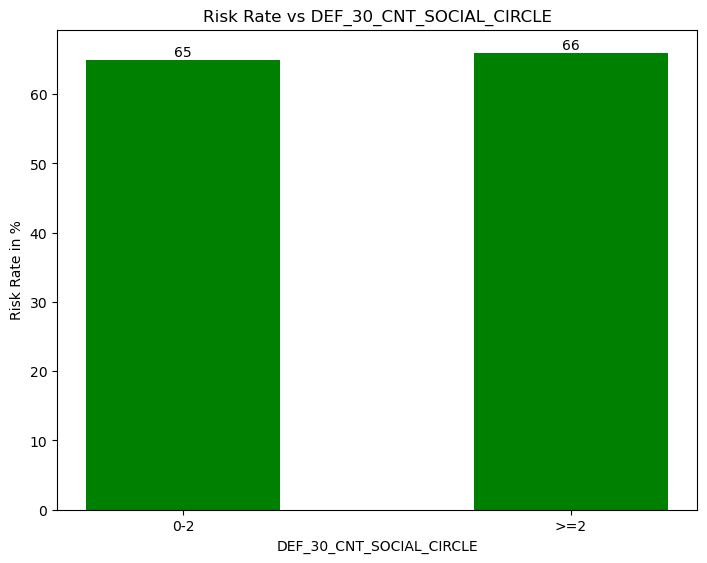

In [767]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

bars = ax.bar(DEF_30_risk_groups.keys(),DEF_30_risk_groups.values(), width=0.5, color = "green")
ax.bar_label(bars)
plt.title("Risk Rate vs DEF_30_CNT_SOCIAL_CIRCLE")
plt.xlabel('DEF_30_CNT_SOCIAL_CIRCLE')
plt.ylabel('Risk Rate in %')
plt.show()

In [768]:
print("The dp difference for DEF_30_CNT_SOCIAL_CIRCLE is ", max(DEF_30_risk_groups.values()) - min(DEF_30_risk_groups.values()))

DEF_30_dp = round(min(DEF_30_risk_groups.values()) / max(DEF_30_risk_groups.values()),2)
print("The dp ratio for DEF_30_CNT_SOCIAL_CIRCLE is ", DEF_30_dp)

dp_ratio_features.update({"DEF_30_CNT_SOCIAL_CIRCLE":DEF_30_dp})

The dp difference for DEF_30_CNT_SOCIAL_CIRCLE is  1.0
The dp ratio for DEF_30_CNT_SOCIAL_CIRCLE is  0.98


In [769]:
display(dp_ratio_features)
len(dp_ratio_features)

{'NAME_CONTRACT_TYPE': 0.85,
 'CODE_GENDER': 0.86,
 'FLAG_OWN_CAR': 0.84,
 'FLAG_OWN_REALTY': 0.99,
 'CNT_CHILDREN': 0.0,
 'AMT_INCOME_TOTAL': 0.79,
 'AMT_CREDIT': 0.67,
 'AMT_ANNUITY': 0.76,
 'AMT_GOODS_PRICE': 0.74,
 'NAME_TYPE_SUITE': 0.4,
 'NAME_INCOME_TYPE': 0.77,
 'NAME_EDUCATION_TYPE': 0.55,
 'NAME_FAMILY_STATUS': 0.78,
 'NAME_HOUSING_TYPE': 0.43,
 'REGION_POPULATION_RELATIVE': 0.77,
 'AGE': 0.53,
 'YEARS_EMPLOYED': 0.67,
 'YEARS_REGISTRATION': 0.72,
 'YEARS_ID_PUBLISH': 0.74,
 'FLAG_MOBIL': 0.32,
 'FLAG_EMP_PHONE': 0.79,
 'FLAG_WORK_PHONE': 0.78,
 'FLAG_CONT_MOBILE': 0.68,
 'FLAG_PHONE': 0.87,
 'FLAG_EMAIL': 0.93,
 'OCCUPATION_TYPE': 0.33,
 'CNT_FAM_MEMBERS': 0.84,
 'REGION_RATING_CLIENT': 0.71,
 'REGION_RATING_CLIENT_W_CITY': 0.69,
 'WEEKDAY_APPR_PROCESS_START': 0.88,
 'HOUR_APPR_PROCESS_START': 0.89,
 'REG_REGION_NOT_LIVE_REGION': 0.94,
 'REG_REGION_NOT_WORK_REGION': 0.97,
 'LIVE_REGION_NOT_WORK_REGION': 0.99,
 'REG_CITY_NOT_LIVE_CITY': 0.76,
 'REG_CITY_NOT_WORK_CITY': 0.73,


40

41. OBS_60_CNT_SOCIAL_CIRCLE

In [770]:
test_df["OBS_60_CNT_SOCIAL_CIRCLE"].min(), test_df["OBS_60_CNT_SOCIAL_CIRCLE"].max()

(0.0, 23.0)

In [771]:
# <=5
# 6-10
# >10

In [772]:
sr_OBS_60 = MetricFrame(metrics=selection_rate, y_true=predictions_test, y_pred=predictions_test,sensitive_features=test_df["OBS_60_CNT_SOCIAL_CIRCLE"])
display(sr_OBS_60.by_group)

OBS_60_CNT_SOCIAL_CIRCLE
0.0     0.703985
1.0     0.668874
2.0     0.663366
3.0     0.680556
4.0     0.684211
5.0     0.675000
6.0     0.615385
7.0     0.611111
8.0     0.750000
9.0     0.428571
10.0    0.000000
11.0    1.000000
12.0    1.000000
13.0    1.000000
14.0    1.000000
16.0    0.000000
17.0    1.000000
18.0    0.000000
23.0    1.000000
Name: selection_rate, dtype: float64

In [773]:
lessthan_5 = sr_OBS_60.by_group.loc[:5]
btw_6_10 = sr_OBS_60.by_group.loc[6:9]
gt_10 = sr_OBS_60.by_group.loc[10:]

lessthan_5_risk_rate = 100*round(np.mean(lessthan_5),2)
btw_6_10_risk_rate = 100*round(np.mean(btw_6_10),2)
gt_10_risk_rate = 100*round(np.mean(gt_10),2)


OBS_60_risk_groups= {"<=5" : lessthan_5_risk_rate, "5-9" : btw_6_10_risk_rate, ">=10": gt_10_risk_rate}
OBS_60_risk_groups

{'<=5': 68.0, '5-9': 60.0, '>=10': 67.0}

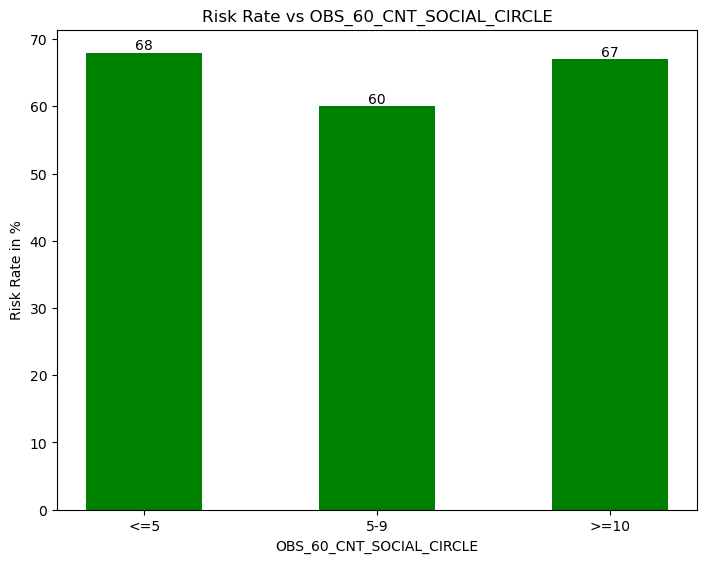

In [774]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

bars = ax.bar(OBS_60_risk_groups.keys(),OBS_60_risk_groups.values(), width=0.5, color = "green")
ax.bar_label(bars)
plt.title("Risk Rate vs OBS_60_CNT_SOCIAL_CIRCLE")
plt.xlabel('OBS_60_CNT_SOCIAL_CIRCLE')
plt.ylabel('Risk Rate in %')
plt.show()

In [775]:
print("The dp difference for OBS_60_CNT_SOCIAL_CIRCLE is ", max(OBS_60_risk_groups.values()) - min(OBS_60_risk_groups.values()))

OBS_60_dp = round(min(OBS_60_risk_groups.values()) / max(OBS_60_risk_groups.values()),2)
print("The dp ratio for OBS_60_CNT_SOCIAL_CIRCLE is ", OBS_60_dp)

dp_ratio_features.update({"OBS_60_CNT_SOCIAL_CIRCLE":OBS_60_dp})

The dp difference for OBS_60_CNT_SOCIAL_CIRCLE is  8.0
The dp ratio for OBS_60_CNT_SOCIAL_CIRCLE is  0.88


In [776]:
display(dp_ratio_features)
len(dp_ratio_features)

{'NAME_CONTRACT_TYPE': 0.85,
 'CODE_GENDER': 0.86,
 'FLAG_OWN_CAR': 0.84,
 'FLAG_OWN_REALTY': 0.99,
 'CNT_CHILDREN': 0.0,
 'AMT_INCOME_TOTAL': 0.79,
 'AMT_CREDIT': 0.67,
 'AMT_ANNUITY': 0.76,
 'AMT_GOODS_PRICE': 0.74,
 'NAME_TYPE_SUITE': 0.4,
 'NAME_INCOME_TYPE': 0.77,
 'NAME_EDUCATION_TYPE': 0.55,
 'NAME_FAMILY_STATUS': 0.78,
 'NAME_HOUSING_TYPE': 0.43,
 'REGION_POPULATION_RELATIVE': 0.77,
 'AGE': 0.53,
 'YEARS_EMPLOYED': 0.67,
 'YEARS_REGISTRATION': 0.72,
 'YEARS_ID_PUBLISH': 0.74,
 'FLAG_MOBIL': 0.32,
 'FLAG_EMP_PHONE': 0.79,
 'FLAG_WORK_PHONE': 0.78,
 'FLAG_CONT_MOBILE': 0.68,
 'FLAG_PHONE': 0.87,
 'FLAG_EMAIL': 0.93,
 'OCCUPATION_TYPE': 0.33,
 'CNT_FAM_MEMBERS': 0.84,
 'REGION_RATING_CLIENT': 0.71,
 'REGION_RATING_CLIENT_W_CITY': 0.69,
 'WEEKDAY_APPR_PROCESS_START': 0.88,
 'HOUR_APPR_PROCESS_START': 0.89,
 'REG_REGION_NOT_LIVE_REGION': 0.94,
 'REG_REGION_NOT_WORK_REGION': 0.97,
 'LIVE_REGION_NOT_WORK_REGION': 0.99,
 'REG_CITY_NOT_LIVE_CITY': 0.76,
 'REG_CITY_NOT_WORK_CITY': 0.73,


41

42. DEF_60_CNT_SOCIAL_CIRCLE

In [777]:
test_df["DEF_60_CNT_SOCIAL_CIRCLE"].unique()

array([0., 1., 3., 2., 4.])

In [778]:
sr_DEF_60 = MetricFrame(metrics=selection_rate, y_true=predictions_test, y_pred=predictions_test,sensitive_features=test_df["DEF_60_CNT_SOCIAL_CIRCLE"])
display(sr_DEF_60.by_group)

DEF_60_CNT_SOCIAL_CIRCLE
0.0    0.699889
1.0    0.542169
2.0    0.600000
3.0    0.333333
4.0    1.000000
Name: selection_rate, dtype: float64

In [779]:
# Groups
# 0-2
# =>2

In [780]:
lessthan_2 = sr_DEF_60.by_group.loc[0:1]
equal_gt_2 = sr_DEF_60.by_group.loc[2:]

lessthan_2_risk_rate = 100*round(np.mean(lessthan_2),2)
equal_gt_2_risk_rate = 100*round(np.mean(equal_gt_2),2)


DEF_60_risk_groups= {"0-2" : lessthan_2_risk_rate, ">=2" : equal_gt_2_risk_rate}
DEF_60_risk_groups

{'0-2': 62.0, '>=2': 64.0}

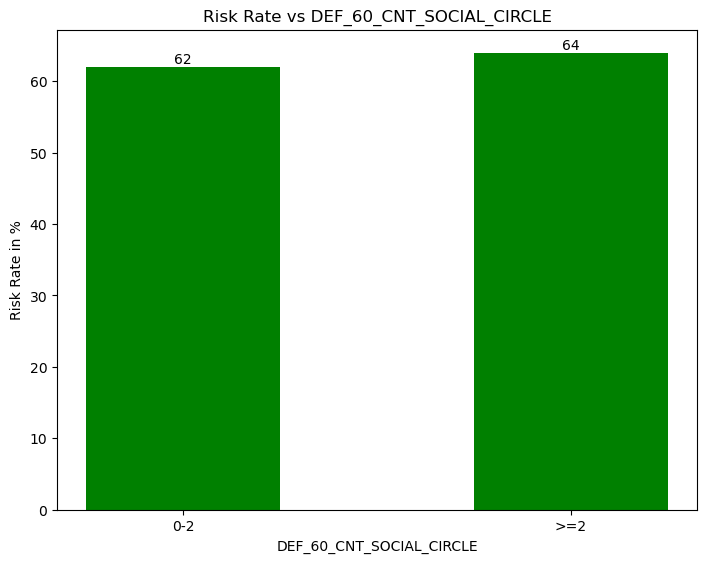

In [781]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

bars = ax.bar(DEF_60_risk_groups.keys(),DEF_60_risk_groups.values(), width=0.5, color = "green")
ax.bar_label(bars)

plt.title("Risk Rate vs DEF_60_CNT_SOCIAL_CIRCLE")
plt.xlabel('DEF_60_CNT_SOCIAL_CIRCLE')
plt.ylabel('Risk Rate in %')
plt.show()

In [782]:
print("The dp difference for DEF_60_CNT_SOCIAL_CIRCLE is ", max(DEF_60_risk_groups.values()) - min(DEF_60_risk_groups.values()))

DEF_60_dp = round(min(DEF_60_risk_groups.values()) / max(DEF_60_risk_groups.values()),2)
print("The dp ratio for DEF_60_CNT_SOCIAL_CIRCLE is ", DEF_60_dp)

dp_ratio_features.update({"DEF_60_CNT_SOCIAL_CIRCLE":DEF_60_dp})

The dp difference for DEF_60_CNT_SOCIAL_CIRCLE is  2.0
The dp ratio for DEF_60_CNT_SOCIAL_CIRCLE is  0.97


In [783]:
display(dp_ratio_features)
len(dp_ratio_features)

{'NAME_CONTRACT_TYPE': 0.85,
 'CODE_GENDER': 0.86,
 'FLAG_OWN_CAR': 0.84,
 'FLAG_OWN_REALTY': 0.99,
 'CNT_CHILDREN': 0.0,
 'AMT_INCOME_TOTAL': 0.79,
 'AMT_CREDIT': 0.67,
 'AMT_ANNUITY': 0.76,
 'AMT_GOODS_PRICE': 0.74,
 'NAME_TYPE_SUITE': 0.4,
 'NAME_INCOME_TYPE': 0.77,
 'NAME_EDUCATION_TYPE': 0.55,
 'NAME_FAMILY_STATUS': 0.78,
 'NAME_HOUSING_TYPE': 0.43,
 'REGION_POPULATION_RELATIVE': 0.77,
 'AGE': 0.53,
 'YEARS_EMPLOYED': 0.67,
 'YEARS_REGISTRATION': 0.72,
 'YEARS_ID_PUBLISH': 0.74,
 'FLAG_MOBIL': 0.32,
 'FLAG_EMP_PHONE': 0.79,
 'FLAG_WORK_PHONE': 0.78,
 'FLAG_CONT_MOBILE': 0.68,
 'FLAG_PHONE': 0.87,
 'FLAG_EMAIL': 0.93,
 'OCCUPATION_TYPE': 0.33,
 'CNT_FAM_MEMBERS': 0.84,
 'REGION_RATING_CLIENT': 0.71,
 'REGION_RATING_CLIENT_W_CITY': 0.69,
 'WEEKDAY_APPR_PROCESS_START': 0.88,
 'HOUR_APPR_PROCESS_START': 0.89,
 'REG_REGION_NOT_LIVE_REGION': 0.94,
 'REG_REGION_NOT_WORK_REGION': 0.97,
 'LIVE_REGION_NOT_WORK_REGION': 0.99,
 'REG_CITY_NOT_LIVE_CITY': 0.76,
 'REG_CITY_NOT_WORK_CITY': 0.73,


42

43. YEARS_LAST_PHONE_CHANGE

In [784]:
test_df["YEARS_LAST_PHONE_CHANGE"].min(), test_df["YEARS_LAST_PHONE_CHANGE"].max()

(0.0, 11.0)

In [785]:
# <=2
# 2-5
# >5

In [786]:
sr_phone_change = MetricFrame(metrics=selection_rate, y_true=predictions_test, y_pred=predictions_test,sensitive_features=test_df["YEARS_LAST_PHONE_CHANGE"])
display(sr_phone_change.by_group)

YEARS_LAST_PHONE_CHANGE
-0.0     0.570588
 1.0     0.554974
 2.0     0.659091
 3.0     0.720721
 4.0     0.795699
 5.0     0.798077
 6.0     0.794872
 7.0     0.868421
 8.0     0.782609
 9.0     1.000000
 10.0    1.000000
 11.0    1.000000
Name: selection_rate, dtype: float64

In [787]:
lessthan_2 = sr_phone_change.by_group.loc[:2]
btw_2_5 = sr_phone_change.by_group.loc[3:5]
gt_5 = sr_phone_change.by_group.loc[6:]

lessthan_2_risk_rate = 100*round(np.mean(lessthan_2),2)
btw_2_5_risk_rate = 100*round(np.mean(btw_2_5),2)
gt_5_risk_rate = 100*round(np.mean(gt_5),2)


phone_change_risk_groups= {"<=2" : lessthan_2_risk_rate, "3-5" : btw_2_5_risk_rate, ">5": gt_5_risk_rate}
phone_change_risk_groups

{'<=2': 59.0, '3-5': 77.0, '>5': 91.0}

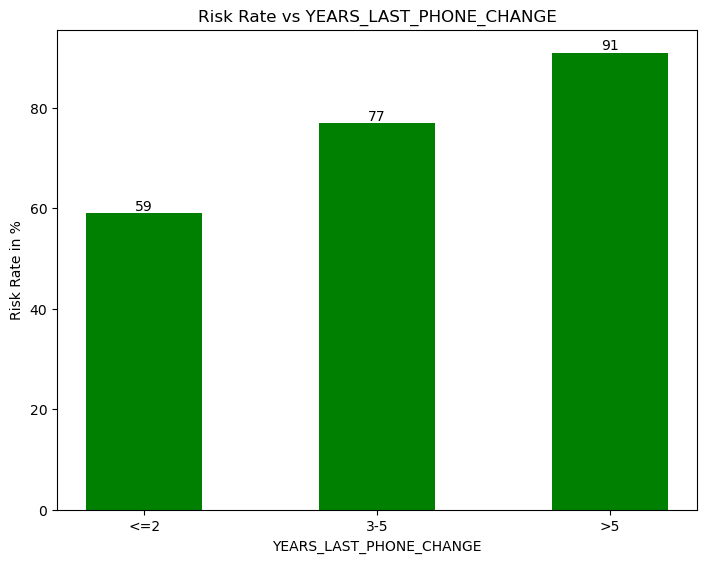

In [788]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

bars = ax.bar(phone_change_risk_groups.keys(),phone_change_risk_groups.values(), width=0.5, color = "green")
ax.bar_label(bars)
plt.title("Risk Rate vs YEARS_LAST_PHONE_CHANGE")
plt.xlabel('YEARS_LAST_PHONE_CHANGE')
plt.ylabel('Risk Rate in %')
plt.show()

In [789]:
print("The dp difference for YEARS_LAST_PHONE_CHANGE is ", max(phone_change_risk_groups.values()) - min(phone_change_risk_groups.values()))

phone_change_dp = round(min(phone_change_risk_groups.values()) / max(phone_change_risk_groups.values()),2)
print("The dp ratio for YEARS_LAST_PHONE_CHANGE is ", phone_change_dp)

dp_ratio_features.update({"YEARS_LAST_PHONE_CHANGE":phone_change_dp})

The dp difference for YEARS_LAST_PHONE_CHANGE is  32.0
The dp ratio for YEARS_LAST_PHONE_CHANGE is  0.65


In [790]:
display(dp_ratio_features)
len(dp_ratio_features)

{'NAME_CONTRACT_TYPE': 0.85,
 'CODE_GENDER': 0.86,
 'FLAG_OWN_CAR': 0.84,
 'FLAG_OWN_REALTY': 0.99,
 'CNT_CHILDREN': 0.0,
 'AMT_INCOME_TOTAL': 0.79,
 'AMT_CREDIT': 0.67,
 'AMT_ANNUITY': 0.76,
 'AMT_GOODS_PRICE': 0.74,
 'NAME_TYPE_SUITE': 0.4,
 'NAME_INCOME_TYPE': 0.77,
 'NAME_EDUCATION_TYPE': 0.55,
 'NAME_FAMILY_STATUS': 0.78,
 'NAME_HOUSING_TYPE': 0.43,
 'REGION_POPULATION_RELATIVE': 0.77,
 'AGE': 0.53,
 'YEARS_EMPLOYED': 0.67,
 'YEARS_REGISTRATION': 0.72,
 'YEARS_ID_PUBLISH': 0.74,
 'FLAG_MOBIL': 0.32,
 'FLAG_EMP_PHONE': 0.79,
 'FLAG_WORK_PHONE': 0.78,
 'FLAG_CONT_MOBILE': 0.68,
 'FLAG_PHONE': 0.87,
 'FLAG_EMAIL': 0.93,
 'OCCUPATION_TYPE': 0.33,
 'CNT_FAM_MEMBERS': 0.84,
 'REGION_RATING_CLIENT': 0.71,
 'REGION_RATING_CLIENT_W_CITY': 0.69,
 'WEEKDAY_APPR_PROCESS_START': 0.88,
 'HOUR_APPR_PROCESS_START': 0.89,
 'REG_REGION_NOT_LIVE_REGION': 0.94,
 'REG_REGION_NOT_WORK_REGION': 0.97,
 'LIVE_REGION_NOT_WORK_REGION': 0.99,
 'REG_CITY_NOT_LIVE_CITY': 0.76,
 'REG_CITY_NOT_WORK_CITY': 0.73,


43

44. AMT_REQ_CREDIT_BUREAU_HOUR

In [791]:
test_df["AMT_REQ_CREDIT_BUREAU_HOUR"]

0      0.0
1      0.0
2      0.0
3      0.0
4      NaN
      ... 
995    0.0
996    0.0
997    0.0
998    0.0
999    0.0
Name: AMT_REQ_CREDIT_BUREAU_HOUR, Length: 1000, dtype: float64

In [792]:
sr_AMT_REQ_CREDIT_BUREAU_HOUR = MetricFrame(metrics=selection_rate, y_true=predictions_test, y_pred=predictions_test, sensitive_features=test_df_final["AMT_REQ_CREDIT_BUREAU_HOUR"])

display(sr_AMT_REQ_CREDIT_BUREAU_HOUR.by_group)

AMT_REQ_CREDIT_BUREAU_HOUR
0.000000    0.701357
0.003382    0.557522
1.000000    0.666667
Name: selection_rate, dtype: float64

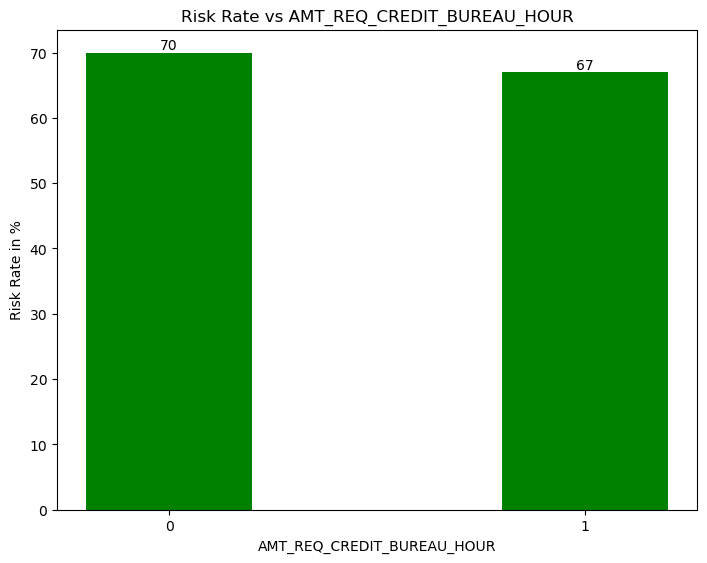

In [793]:
AMT_REQ_CREDIT_BUREAU_HOUR_groups= {"0" : round(100*sr_AMT_REQ_CREDIT_BUREAU_HOUR.by_group.loc[0]), 
                           "1" : round(100*sr_AMT_REQ_CREDIT_BUREAU_HOUR.by_group.loc[1])}
#                   "Unknown" : round(100*sr_AMT_REQ_CREDIT_BUREAU_HOUR.by_group.loc[0.0033821871476888386])}

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

bars = ax.bar(AMT_REQ_CREDIT_BUREAU_HOUR_groups.keys(),AMT_REQ_CREDIT_BUREAU_HOUR_groups.values(), width=0.4, color = "green")
ax.bar_label(bars)
plt.title("Risk Rate vs AMT_REQ_CREDIT_BUREAU_HOUR")
plt.xlabel('AMT_REQ_CREDIT_BUREAU_HOUR')
plt.ylabel('Risk Rate in %')
plt.show()

In [794]:
print("The dp difference for AMT_REQ_CREDIT_BUREAU_HOUR is ", max(AMT_REQ_CREDIT_BUREAU_HOUR_groups.values()) - min(AMT_REQ_CREDIT_BUREAU_HOUR_groups.values()))

AMT_REQ_CREDIT_BUREAU_HOUR_dp = round(min(AMT_REQ_CREDIT_BUREAU_HOUR_groups.values()) / max(AMT_REQ_CREDIT_BUREAU_HOUR_groups.values()),2)
print("The dp ratio for AMT_REQ_CREDIT_BUREAU_HOUR is ", AMT_REQ_CREDIT_BUREAU_HOUR_dp)

dp_ratio_features.update({"AMT_REQ_CREDIT_BUREAU_HOUR": AMT_REQ_CREDIT_BUREAU_HOUR_dp})

The dp difference for AMT_REQ_CREDIT_BUREAU_HOUR is  3
The dp ratio for AMT_REQ_CREDIT_BUREAU_HOUR is  0.96


In [795]:
display(dp_ratio_features)
len(dp_ratio_features)

{'NAME_CONTRACT_TYPE': 0.85,
 'CODE_GENDER': 0.86,
 'FLAG_OWN_CAR': 0.84,
 'FLAG_OWN_REALTY': 0.99,
 'CNT_CHILDREN': 0.0,
 'AMT_INCOME_TOTAL': 0.79,
 'AMT_CREDIT': 0.67,
 'AMT_ANNUITY': 0.76,
 'AMT_GOODS_PRICE': 0.74,
 'NAME_TYPE_SUITE': 0.4,
 'NAME_INCOME_TYPE': 0.77,
 'NAME_EDUCATION_TYPE': 0.55,
 'NAME_FAMILY_STATUS': 0.78,
 'NAME_HOUSING_TYPE': 0.43,
 'REGION_POPULATION_RELATIVE': 0.77,
 'AGE': 0.53,
 'YEARS_EMPLOYED': 0.67,
 'YEARS_REGISTRATION': 0.72,
 'YEARS_ID_PUBLISH': 0.74,
 'FLAG_MOBIL': 0.32,
 'FLAG_EMP_PHONE': 0.79,
 'FLAG_WORK_PHONE': 0.78,
 'FLAG_CONT_MOBILE': 0.68,
 'FLAG_PHONE': 0.87,
 'FLAG_EMAIL': 0.93,
 'OCCUPATION_TYPE': 0.33,
 'CNT_FAM_MEMBERS': 0.84,
 'REGION_RATING_CLIENT': 0.71,
 'REGION_RATING_CLIENT_W_CITY': 0.69,
 'WEEKDAY_APPR_PROCESS_START': 0.88,
 'HOUR_APPR_PROCESS_START': 0.89,
 'REG_REGION_NOT_LIVE_REGION': 0.94,
 'REG_REGION_NOT_WORK_REGION': 0.97,
 'LIVE_REGION_NOT_WORK_REGION': 0.99,
 'REG_CITY_NOT_LIVE_CITY': 0.76,
 'REG_CITY_NOT_WORK_CITY': 0.73,


44

45. AMT_REQ_CREDIT_BUREAU_DAY

In [796]:
test_df["AMT_REQ_CREDIT_BUREAU_DAY"].unique()

array([ 0., nan,  1.])

In [797]:
sr_AMT_REQ_CREDIT_BUREAU_DAY = MetricFrame(metrics=selection_rate, y_true=predictions_test, y_pred=predictions_test, sensitive_features=test_df_final["AMT_REQ_CREDIT_BUREAU_DAY"])

display(sr_AMT_REQ_CREDIT_BUREAU_DAY.by_group)

AMT_REQ_CREDIT_BUREAU_DAY
0.000000    0.700903
0.001127    0.557522
1.000000    1.000000
Name: selection_rate, dtype: float64

In [798]:
# sr_AMT_REQ_CREDIT_BUREAU_DAY.by_group.keys()

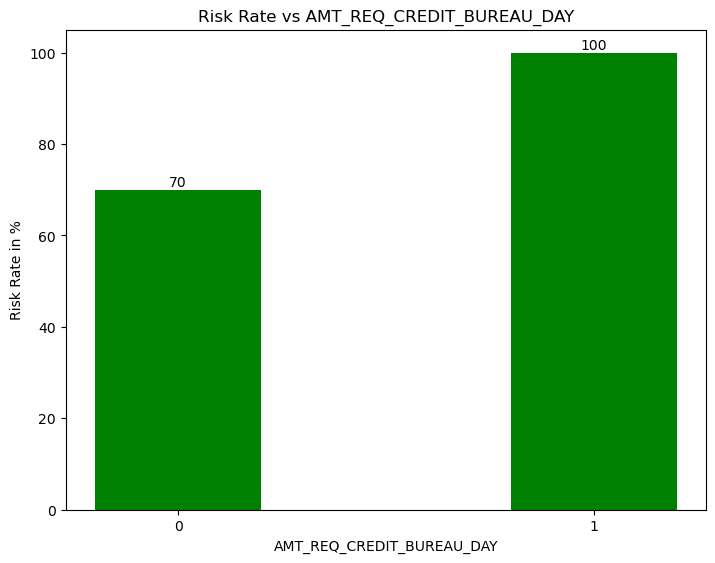

In [799]:
AMT_REQ_CREDIT_BUREAU_DAY_groups= {"0" : round(100*sr_AMT_REQ_CREDIT_BUREAU_DAY.by_group.loc[0]), 
                           "1" : round(100*sr_AMT_REQ_CREDIT_BUREAU_DAY.by_group.loc[1])}
#                   "Unknown" : round(100*sr_AMT_REQ_CREDIT_BUREAU_DAY.by_group.loc[0.0011273957158962795])}

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

bars = ax.bar(AMT_REQ_CREDIT_BUREAU_DAY_groups.keys(),AMT_REQ_CREDIT_BUREAU_DAY_groups.values(), width=0.4, color = "green")
ax.bar_label(bars)
plt.title("Risk Rate vs AMT_REQ_CREDIT_BUREAU_DAY")
plt.xlabel('AMT_REQ_CREDIT_BUREAU_DAY')
plt.ylabel('Risk Rate in %')
plt.show()

In [800]:
print("The dp difference for AMT_REQ_CREDIT_BUREAU_DAY is ", max(AMT_REQ_CREDIT_BUREAU_DAY_groups.values()) - min(AMT_REQ_CREDIT_BUREAU_DAY_groups.values()))

AMT_REQ_CREDIT_BUREAU_DAY_dp = round(min(AMT_REQ_CREDIT_BUREAU_DAY_groups.values()) / max(AMT_REQ_CREDIT_BUREAU_DAY_groups.values()),2)
print("The dp ratio for AMT_REQ_CREDIT_BUREAU_DAY is ", AMT_REQ_CREDIT_BUREAU_DAY_dp)

dp_ratio_features.update({"AMT_REQ_CREDIT_BUREAU_DAY": AMT_REQ_CREDIT_BUREAU_DAY_dp})

The dp difference for AMT_REQ_CREDIT_BUREAU_DAY is  30
The dp ratio for AMT_REQ_CREDIT_BUREAU_DAY is  0.7


In [801]:
display(dp_ratio_features)
len(dp_ratio_features)

{'NAME_CONTRACT_TYPE': 0.85,
 'CODE_GENDER': 0.86,
 'FLAG_OWN_CAR': 0.84,
 'FLAG_OWN_REALTY': 0.99,
 'CNT_CHILDREN': 0.0,
 'AMT_INCOME_TOTAL': 0.79,
 'AMT_CREDIT': 0.67,
 'AMT_ANNUITY': 0.76,
 'AMT_GOODS_PRICE': 0.74,
 'NAME_TYPE_SUITE': 0.4,
 'NAME_INCOME_TYPE': 0.77,
 'NAME_EDUCATION_TYPE': 0.55,
 'NAME_FAMILY_STATUS': 0.78,
 'NAME_HOUSING_TYPE': 0.43,
 'REGION_POPULATION_RELATIVE': 0.77,
 'AGE': 0.53,
 'YEARS_EMPLOYED': 0.67,
 'YEARS_REGISTRATION': 0.72,
 'YEARS_ID_PUBLISH': 0.74,
 'FLAG_MOBIL': 0.32,
 'FLAG_EMP_PHONE': 0.79,
 'FLAG_WORK_PHONE': 0.78,
 'FLAG_CONT_MOBILE': 0.68,
 'FLAG_PHONE': 0.87,
 'FLAG_EMAIL': 0.93,
 'OCCUPATION_TYPE': 0.33,
 'CNT_FAM_MEMBERS': 0.84,
 'REGION_RATING_CLIENT': 0.71,
 'REGION_RATING_CLIENT_W_CITY': 0.69,
 'WEEKDAY_APPR_PROCESS_START': 0.88,
 'HOUR_APPR_PROCESS_START': 0.89,
 'REG_REGION_NOT_LIVE_REGION': 0.94,
 'REG_REGION_NOT_WORK_REGION': 0.97,
 'LIVE_REGION_NOT_WORK_REGION': 0.99,
 'REG_CITY_NOT_LIVE_CITY': 0.76,
 'REG_CITY_NOT_WORK_CITY': 0.73,


45

46. AMT_REQ_CREDIT_BUREAU_WEEK

In [802]:
sr_AMT_REQ_CREDIT_BUREAU_WEEK = MetricFrame(metrics=selection_rate, y_true=predictions_test, y_pred=predictions_test, sensitive_features=test_df_final["AMT_REQ_CREDIT_BUREAU_WEEK"])

display(sr_AMT_REQ_CREDIT_BUREAU_WEEK.by_group)

AMT_REQ_CREDIT_BUREAU_WEEK
0.000000    0.700903
0.001127    0.557522
1.000000    1.000000
Name: selection_rate, dtype: float64

In [803]:
# sr_AMT_REQ_CREDIT_BUREAU_DAY.by_group.keys()

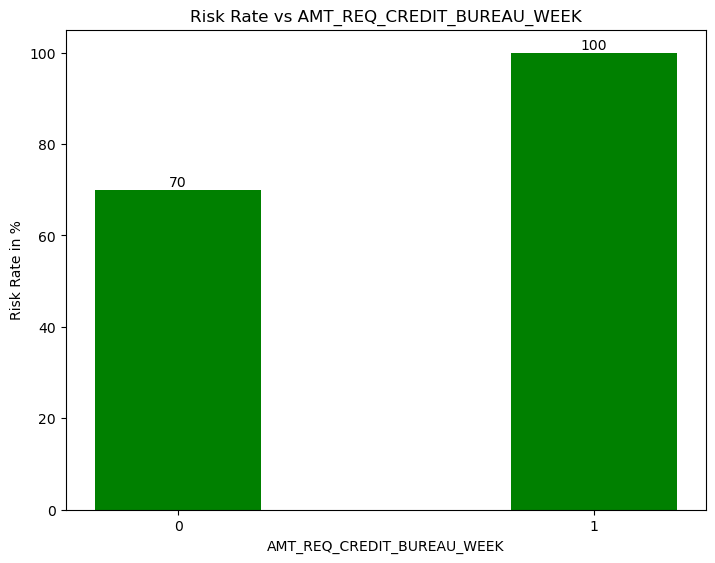

In [804]:
AMT_REQ_CREDIT_BUREAU_WEEK_groups= {"0" : round(100*sr_AMT_REQ_CREDIT_BUREAU_WEEK.by_group.loc[0]), 
                           "1" : round(100*sr_AMT_REQ_CREDIT_BUREAU_WEEK.by_group.loc[1])}
#                   "Unknown" : round(100*sr_AMT_REQ_CREDIT_BUREAU_WEEK.by_group.loc[0.0011273957158962795])}

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

bars = ax.bar(AMT_REQ_CREDIT_BUREAU_WEEK_groups.keys(),AMT_REQ_CREDIT_BUREAU_WEEK_groups.values(), width=0.4, color = "green")
ax.bar_label(bars)
plt.title("Risk Rate vs AMT_REQ_CREDIT_BUREAU_WEEK")
plt.xlabel('AMT_REQ_CREDIT_BUREAU_WEEK')
plt.ylabel('Risk Rate in %')
plt.show()

In [805]:
print("The dp difference for AMT_REQ_CREDIT_BUREAU_WEEK is ", max(AMT_REQ_CREDIT_BUREAU_WEEK_groups.values()) - min(AMT_REQ_CREDIT_BUREAU_WEEK_groups.values()))

AMT_REQ_CREDIT_BUREAU_WEEK_dp = round(min(AMT_REQ_CREDIT_BUREAU_WEEK_groups.values()) / max(AMT_REQ_CREDIT_BUREAU_WEEK_groups.values()),2)
print("The dp ratio for AMT_REQ_CREDIT_BUREAU_WEEK is ", AMT_REQ_CREDIT_BUREAU_WEEK_dp)

dp_ratio_features.update({"AMT_REQ_CREDIT_BUREAU_WEEK": AMT_REQ_CREDIT_BUREAU_WEEK_dp})

The dp difference for AMT_REQ_CREDIT_BUREAU_WEEK is  30
The dp ratio for AMT_REQ_CREDIT_BUREAU_WEEK is  0.7


In [806]:
display(dp_ratio_features)
len(dp_ratio_features)

{'NAME_CONTRACT_TYPE': 0.85,
 'CODE_GENDER': 0.86,
 'FLAG_OWN_CAR': 0.84,
 'FLAG_OWN_REALTY': 0.99,
 'CNT_CHILDREN': 0.0,
 'AMT_INCOME_TOTAL': 0.79,
 'AMT_CREDIT': 0.67,
 'AMT_ANNUITY': 0.76,
 'AMT_GOODS_PRICE': 0.74,
 'NAME_TYPE_SUITE': 0.4,
 'NAME_INCOME_TYPE': 0.77,
 'NAME_EDUCATION_TYPE': 0.55,
 'NAME_FAMILY_STATUS': 0.78,
 'NAME_HOUSING_TYPE': 0.43,
 'REGION_POPULATION_RELATIVE': 0.77,
 'AGE': 0.53,
 'YEARS_EMPLOYED': 0.67,
 'YEARS_REGISTRATION': 0.72,
 'YEARS_ID_PUBLISH': 0.74,
 'FLAG_MOBIL': 0.32,
 'FLAG_EMP_PHONE': 0.79,
 'FLAG_WORK_PHONE': 0.78,
 'FLAG_CONT_MOBILE': 0.68,
 'FLAG_PHONE': 0.87,
 'FLAG_EMAIL': 0.93,
 'OCCUPATION_TYPE': 0.33,
 'CNT_FAM_MEMBERS': 0.84,
 'REGION_RATING_CLIENT': 0.71,
 'REGION_RATING_CLIENT_W_CITY': 0.69,
 'WEEKDAY_APPR_PROCESS_START': 0.88,
 'HOUR_APPR_PROCESS_START': 0.89,
 'REG_REGION_NOT_LIVE_REGION': 0.94,
 'REG_REGION_NOT_WORK_REGION': 0.97,
 'LIVE_REGION_NOT_WORK_REGION': 0.99,
 'REG_CITY_NOT_LIVE_CITY': 0.76,
 'REG_CITY_NOT_WORK_CITY': 0.73,


46

47. AMT_REQ_CREDIT_BUREAU_MON

In [807]:
sr_AMT_REQ_CREDIT_BUREAU_MON = MetricFrame(metrics=selection_rate, y_true=predictions_test, y_pred=predictions_test, sensitive_features=test_df_final["AMT_REQ_CREDIT_BUREAU_MON"])

display(sr_AMT_REQ_CREDIT_BUREAU_MON.by_group)

AMT_REQ_CREDIT_BUREAU_MON
0.000000    0.701476
0.006764    0.557522
1.000000    0.666667
Name: selection_rate, dtype: float64

In [808]:
# sr_AMT_REQ_CREDIT_BUREAU_MON.by_group.keys()

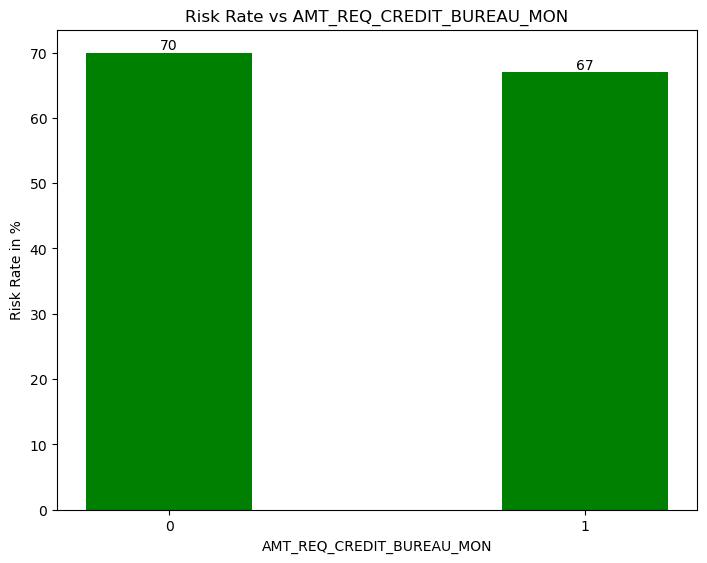

In [809]:
AMT_REQ_CREDIT_BUREAU_MON_groups= {"0" : round(100*sr_AMT_REQ_CREDIT_BUREAU_MON.by_group.loc[0]), 
                           "1" : round(100*sr_AMT_REQ_CREDIT_BUREAU_MON.by_group.loc[1])}
#                   "Unknown" : round(100*sr_AMT_REQ_CREDIT_BUREAU_MON.by_group.loc[0.006764374295377677])}

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

bars = ax.bar(AMT_REQ_CREDIT_BUREAU_MON_groups.keys(),AMT_REQ_CREDIT_BUREAU_MON_groups.values(), width=0.4, color = "green")
ax.bar_label(bars)
plt.title("Risk Rate vs AMT_REQ_CREDIT_BUREAU_MON")
plt.xlabel('AMT_REQ_CREDIT_BUREAU_MON')
plt.ylabel('Risk Rate in %')
plt.show()

In [810]:
print("The dp difference for AMT_REQ_CREDIT_BUREAU_MON is ", max(AMT_REQ_CREDIT_BUREAU_MON_groups.values()) - min(AMT_REQ_CREDIT_BUREAU_MON_groups.values()))

AMT_REQ_CREDIT_BUREAU_MON_dp = round(min(AMT_REQ_CREDIT_BUREAU_MON_groups.values()) / max(AMT_REQ_CREDIT_BUREAU_MON_groups.values()),2)
print("The dp ratio for AMT_REQ_CREDIT_BUREAU_MON is ", AMT_REQ_CREDIT_BUREAU_MON_dp)

dp_ratio_features.update({"AMT_REQ_CREDIT_BUREAU_MON": AMT_REQ_CREDIT_BUREAU_MON_dp})

The dp difference for AMT_REQ_CREDIT_BUREAU_MON is  3
The dp ratio for AMT_REQ_CREDIT_BUREAU_MON is  0.96


In [811]:
display(dp_ratio_features)
len(dp_ratio_features)

{'NAME_CONTRACT_TYPE': 0.85,
 'CODE_GENDER': 0.86,
 'FLAG_OWN_CAR': 0.84,
 'FLAG_OWN_REALTY': 0.99,
 'CNT_CHILDREN': 0.0,
 'AMT_INCOME_TOTAL': 0.79,
 'AMT_CREDIT': 0.67,
 'AMT_ANNUITY': 0.76,
 'AMT_GOODS_PRICE': 0.74,
 'NAME_TYPE_SUITE': 0.4,
 'NAME_INCOME_TYPE': 0.77,
 'NAME_EDUCATION_TYPE': 0.55,
 'NAME_FAMILY_STATUS': 0.78,
 'NAME_HOUSING_TYPE': 0.43,
 'REGION_POPULATION_RELATIVE': 0.77,
 'AGE': 0.53,
 'YEARS_EMPLOYED': 0.67,
 'YEARS_REGISTRATION': 0.72,
 'YEARS_ID_PUBLISH': 0.74,
 'FLAG_MOBIL': 0.32,
 'FLAG_EMP_PHONE': 0.79,
 'FLAG_WORK_PHONE': 0.78,
 'FLAG_CONT_MOBILE': 0.68,
 'FLAG_PHONE': 0.87,
 'FLAG_EMAIL': 0.93,
 'OCCUPATION_TYPE': 0.33,
 'CNT_FAM_MEMBERS': 0.84,
 'REGION_RATING_CLIENT': 0.71,
 'REGION_RATING_CLIENT_W_CITY': 0.69,
 'WEEKDAY_APPR_PROCESS_START': 0.88,
 'HOUR_APPR_PROCESS_START': 0.89,
 'REG_REGION_NOT_LIVE_REGION': 0.94,
 'REG_REGION_NOT_WORK_REGION': 0.97,
 'LIVE_REGION_NOT_WORK_REGION': 0.99,
 'REG_CITY_NOT_LIVE_CITY': 0.76,
 'REG_CITY_NOT_WORK_CITY': 0.73,


47

48. AMT_REQ_CREDIT_BUREAU_QRT

In [812]:
test_df["AMT_REQ_CREDIT_BUREAU_QRT"].min(), test_df["AMT_REQ_CREDIT_BUREAU_QRT"].max()

(0.0, 5.0)

In [813]:
# <=2  = [0,1]
# >2 = 

In [814]:
sr_AMT_REQ_CREDIT_BUREAU_QRT = MetricFrame(metrics=selection_rate, y_true=predictions_test, y_pred=predictions_test,sensitive_features=test_df_final["AMT_REQ_CREDIT_BUREAU_QRT"])
display(sr_AMT_REQ_CREDIT_BUREAU_QRT.by_group)

AMT_REQ_CREDIT_BUREAU_QRT
0.000000    0.676000
0.529876    0.557522
1.000000    0.752351
2.000000    0.625000
3.000000    0.800000
4.000000    1.000000
5.000000    0.000000
Name: selection_rate, dtype: float64

In [815]:
sr_AMT_REQ_CREDIT_BUREAU_QRT.by_group.keys()

Float64Index([0.0, 0.5298759864712514, 1.0, 2.0, 3.0, 4.0, 5.0], dtype='float64', name='AMT_REQ_CREDIT_BUREAU_QRT')

In [816]:
lessthan_2 = sr_AMT_REQ_CREDIT_BUREAU_QRT.by_group.loc[[0,1]]
gt_2 = sr_AMT_REQ_CREDIT_BUREAU_QRT.by_group.loc[2:]
# unknown = sr_AMT_REQ_CREDIT_BUREAU_QRT.by_group.loc[0.5298759864712514]

lessthan_2_risk_rate = 100*round(np.mean(lessthan_2),2)
gt_2_risk_rate = 100*round(np.mean(gt_2),2)
# unknown_risk_rate = 100*round(unknown,2)


AMT_REQ_CREDIT_BUREAU_QRT_risk_groups= {"<=2" : round(lessthan_2_risk_rate), ">2" : gt_2_risk_rate}
AMT_REQ_CREDIT_BUREAU_QRT_risk_groups

{'<=2': 71, '>2': 61.0}

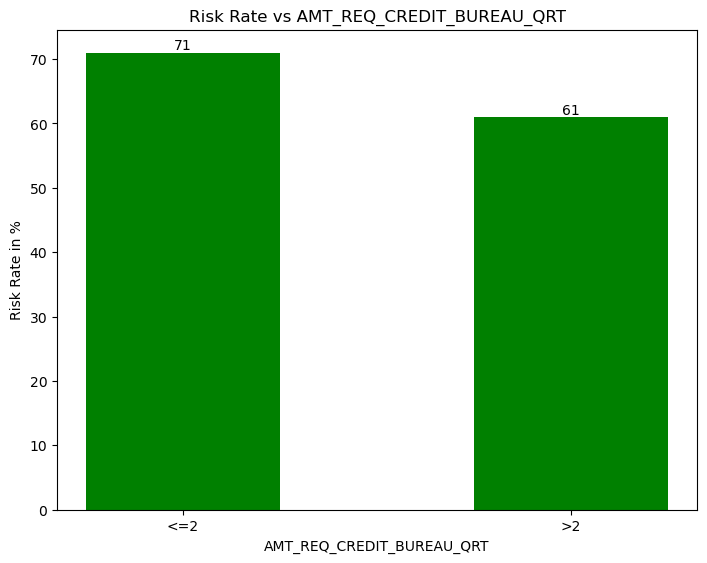

In [817]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

bars = ax.bar(AMT_REQ_CREDIT_BUREAU_QRT_risk_groups.keys(),AMT_REQ_CREDIT_BUREAU_QRT_risk_groups.values(), width=0.5, color = "green")
ax.bar_label(bars)
plt.title("Risk Rate vs AMT_REQ_CREDIT_BUREAU_QRT")
plt.xlabel('AMT_REQ_CREDIT_BUREAU_QRT')
plt.ylabel('Risk Rate in %')
plt.show()

In [818]:
print("The dp difference for AMT_REQ_CREDIT_BUREAU_QRT is ", max(AMT_REQ_CREDIT_BUREAU_QRT_risk_groups.values()) - min(AMT_REQ_CREDIT_BUREAU_QRT_risk_groups.values()))

AMT_REQ_CREDIT_BUREAU_QRT_dp = round(min(AMT_REQ_CREDIT_BUREAU_QRT_risk_groups.values()) / max(AMT_REQ_CREDIT_BUREAU_QRT_risk_groups.values()),2)
print("The dp ratio for AMT_REQ_CREDIT_BUREAU_QRT is ", AMT_REQ_CREDIT_BUREAU_QRT_dp)

dp_ratio_features.update({"AMT_REQ_CREDIT_BUREAU_QRT":AMT_REQ_CREDIT_BUREAU_QRT_dp})

The dp difference for AMT_REQ_CREDIT_BUREAU_QRT is  10.0
The dp ratio for AMT_REQ_CREDIT_BUREAU_QRT is  0.86


In [819]:
display(dp_ratio_features)
len(dp_ratio_features)

{'NAME_CONTRACT_TYPE': 0.85,
 'CODE_GENDER': 0.86,
 'FLAG_OWN_CAR': 0.84,
 'FLAG_OWN_REALTY': 0.99,
 'CNT_CHILDREN': 0.0,
 'AMT_INCOME_TOTAL': 0.79,
 'AMT_CREDIT': 0.67,
 'AMT_ANNUITY': 0.76,
 'AMT_GOODS_PRICE': 0.74,
 'NAME_TYPE_SUITE': 0.4,
 'NAME_INCOME_TYPE': 0.77,
 'NAME_EDUCATION_TYPE': 0.55,
 'NAME_FAMILY_STATUS': 0.78,
 'NAME_HOUSING_TYPE': 0.43,
 'REGION_POPULATION_RELATIVE': 0.77,
 'AGE': 0.53,
 'YEARS_EMPLOYED': 0.67,
 'YEARS_REGISTRATION': 0.72,
 'YEARS_ID_PUBLISH': 0.74,
 'FLAG_MOBIL': 0.32,
 'FLAG_EMP_PHONE': 0.79,
 'FLAG_WORK_PHONE': 0.78,
 'FLAG_CONT_MOBILE': 0.68,
 'FLAG_PHONE': 0.87,
 'FLAG_EMAIL': 0.93,
 'OCCUPATION_TYPE': 0.33,
 'CNT_FAM_MEMBERS': 0.84,
 'REGION_RATING_CLIENT': 0.71,
 'REGION_RATING_CLIENT_W_CITY': 0.69,
 'WEEKDAY_APPR_PROCESS_START': 0.88,
 'HOUR_APPR_PROCESS_START': 0.89,
 'REG_REGION_NOT_LIVE_REGION': 0.94,
 'REG_REGION_NOT_WORK_REGION': 0.97,
 'LIVE_REGION_NOT_WORK_REGION': 0.99,
 'REG_CITY_NOT_LIVE_CITY': 0.76,
 'REG_CITY_NOT_WORK_CITY': 0.73,


48

49. AMT_REQ_CREDIT_BUREAU_YEAR

In [820]:
test_df["AMT_REQ_CREDIT_BUREAU_YEAR"].min(), test_df["AMT_REQ_CREDIT_BUREAU_YEAR"].max()

(0.0, 9.0)

In [821]:
# <=2  = [0,1]
# 3-5
# >5 

In [822]:
sr_AMT_REQ_CREDIT_BUREAU_YEAR = MetricFrame(metrics=selection_rate, y_true=predictions_test, y_pred=predictions_test,sensitive_features=test_df_final["AMT_REQ_CREDIT_BUREAU_YEAR"])
display(sr_AMT_REQ_CREDIT_BUREAU_YEAR.by_group)

AMT_REQ_CREDIT_BUREAU_YEAR
0.000000    0.706897
1.000000    0.794286
1.952649    0.557522
2.000000    0.657754
3.000000    0.681481
4.000000    0.645570
5.000000    0.750000
6.000000    0.714286
7.000000    0.272727
8.000000    0.750000
9.000000    0.666667
Name: selection_rate, dtype: float64

In [823]:
sr_AMT_REQ_CREDIT_BUREAU_YEAR.by_group.keys()

Float64Index([0.0, 1.0, 1.9526493799323563, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0,
              9.0],
             dtype='float64', name='AMT_REQ_CREDIT_BUREAU_YEAR')

In [824]:
lessthan_2 = sr_AMT_REQ_CREDIT_BUREAU_YEAR.by_group.loc[[0,1]]
bt_3_5 = sr_AMT_REQ_CREDIT_BUREAU_YEAR.by_group.loc[3:5]
gt_5 = sr_AMT_REQ_CREDIT_BUREAU_YEAR.by_group.loc[6:]
# unknown = sr_AMT_REQ_CREDIT_BUREAU_YEAR.by_group.loc[1.9526493799323563]

lessthan_2_risk_rate = 100*round(np.mean(lessthan_2),2)
bt_3_5_risk_rate = 100*round(np.mean(bt_3_5),2)
gt_5_risk_rate = 100*round(np.mean(gt_5),2)
# unknown_risk_rate = 100*round(unknown,2)


sr_AMT_REQ_CREDIT_BUREAU_YEAR_risk_groups= {"<=2" : lessthan_2_risk_rate, "3-5": bt_3_5_risk_rate,
                                            
                                            ">5" : gt_5_risk_rate}
sr_AMT_REQ_CREDIT_BUREAU_YEAR_risk_groups

{'<=2': 75.0, '3-5': 69.0, '>5': 60.0}

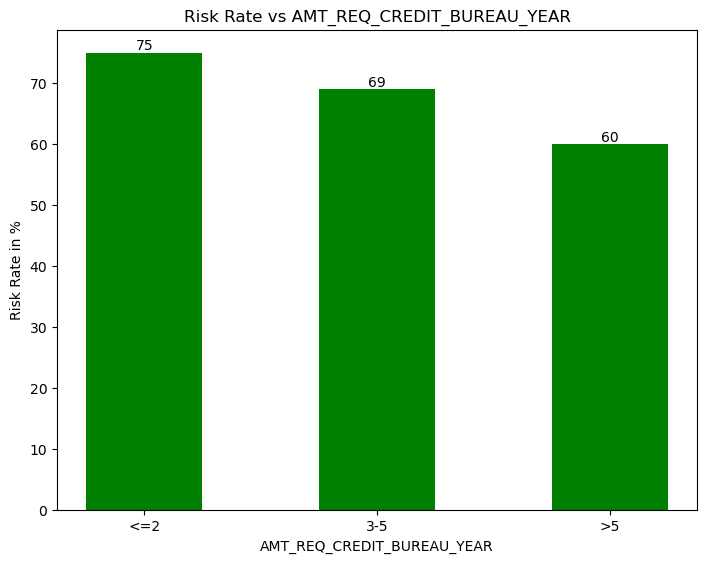

In [825]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

bars = ax.bar(sr_AMT_REQ_CREDIT_BUREAU_YEAR_risk_groups.keys(),sr_AMT_REQ_CREDIT_BUREAU_YEAR_risk_groups.values(), width=0.5, color = "green")
ax.bar_label(bars)
plt.title("Risk Rate vs AMT_REQ_CREDIT_BUREAU_YEAR")
plt.xlabel('AMT_REQ_CREDIT_BUREAU_YEAR')
plt.ylabel('Risk Rate in %')
plt.show()

In [826]:
print("The dp difference for AMT_REQ_CREDIT_BUREAU_YEAR is ", max(sr_AMT_REQ_CREDIT_BUREAU_YEAR_risk_groups.values()) - min(sr_AMT_REQ_CREDIT_BUREAU_YEAR_risk_groups.values()))

AMT_REQ_CREDIT_BUREAU_YEAR_dp = round(min(sr_AMT_REQ_CREDIT_BUREAU_YEAR_risk_groups.values()) / max(sr_AMT_REQ_CREDIT_BUREAU_YEAR_risk_groups.values()),2)
print("The dp ratio for AMT_REQ_CREDIT_BUREAU_YEAR is ", AMT_REQ_CREDIT_BUREAU_YEAR_dp)

dp_ratio_features.update({"AMT_REQ_CREDIT_BUREAU_YEAR":AMT_REQ_CREDIT_BUREAU_YEAR_dp})

The dp difference for AMT_REQ_CREDIT_BUREAU_YEAR is  15.0
The dp ratio for AMT_REQ_CREDIT_BUREAU_YEAR is  0.8


In [827]:
display(dp_ratio_features)
len(dp_ratio_features)

{'NAME_CONTRACT_TYPE': 0.85,
 'CODE_GENDER': 0.86,
 'FLAG_OWN_CAR': 0.84,
 'FLAG_OWN_REALTY': 0.99,
 'CNT_CHILDREN': 0.0,
 'AMT_INCOME_TOTAL': 0.79,
 'AMT_CREDIT': 0.67,
 'AMT_ANNUITY': 0.76,
 'AMT_GOODS_PRICE': 0.74,
 'NAME_TYPE_SUITE': 0.4,
 'NAME_INCOME_TYPE': 0.77,
 'NAME_EDUCATION_TYPE': 0.55,
 'NAME_FAMILY_STATUS': 0.78,
 'NAME_HOUSING_TYPE': 0.43,
 'REGION_POPULATION_RELATIVE': 0.77,
 'AGE': 0.53,
 'YEARS_EMPLOYED': 0.67,
 'YEARS_REGISTRATION': 0.72,
 'YEARS_ID_PUBLISH': 0.74,
 'FLAG_MOBIL': 0.32,
 'FLAG_EMP_PHONE': 0.79,
 'FLAG_WORK_PHONE': 0.78,
 'FLAG_CONT_MOBILE': 0.68,
 'FLAG_PHONE': 0.87,
 'FLAG_EMAIL': 0.93,
 'OCCUPATION_TYPE': 0.33,
 'CNT_FAM_MEMBERS': 0.84,
 'REGION_RATING_CLIENT': 0.71,
 'REGION_RATING_CLIENT_W_CITY': 0.69,
 'WEEKDAY_APPR_PROCESS_START': 0.88,
 'HOUR_APPR_PROCESS_START': 0.89,
 'REG_REGION_NOT_LIVE_REGION': 0.94,
 'REG_REGION_NOT_WORK_REGION': 0.97,
 'LIVE_REGION_NOT_WORK_REGION': 0.99,
 'REG_CITY_NOT_LIVE_CITY': 0.76,
 'REG_CITY_NOT_WORK_CITY': 0.73,


49

In [828]:
dp_ratio_features_df = pd.DataFrame()
dp_ratio_features_df["Features"] = dp_ratio_features.keys()
dp_ratio_features_df["DP_Ratio"] = dp_ratio_features.values()
dp_ratio_features_df

,Features,DP_Ratio
0,NAME_CONTRACT_TYPE,0.85
1,CODE_GENDER,0.86
2,FLAG_OWN_CAR,0.84
3,FLAG_OWN_REALTY,0.99
4,CNT_CHILDREN,0.00
5,AMT_INCOME_TOTAL,0.79
6,AMT_CREDIT,0.67
7,AMT_ANNUITY,0.76
8,AMT_GOODS_PRICE,0.74
9,NAME_TYPE_SUITE,0.40


In [836]:
# ft_vd.to_csv("Value_Distributions.csv")

In [837]:
# ft_vd

In [838]:
# ft_df["REGION_POPULATION_RELATIVE"]

In [839]:
# a = len(ft_df["AMT_ANNUITY"]["SR"])
# a_3 = int(a/3)
# v_list = ft_df["AMT_ANNUITY"]["SR"].values.tolist()
# i_list = ft_df["AMT_ANNUITY"]["SR"].index.tolist()
# v_list_1 = ft_df["AMT_ANNUITY"]["SR"].values.tolist()[0:a_3]
# v_list_2 = ft_df["AMT_ANNUITY"]["SR"].values.tolist()[a_3:a_3+a_3]
# v_list_3 = ft_df["AMT_ANNUITY"]["SR"].values.tolist()[a_3+a_3:]
# print(np.mean(v_list_1))

Indegree and Outdegree

In [840]:
import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

In [841]:
am = pd.read_csv("adjacency_matrix_TestSet.csv")
edges = pd.read_csv('Edges_TestSet.csv')
nodes = pd.read_csv('Nodes_TestSet.csv')

In [842]:
am.head()

,Edge_Start,CNT_CHILDREN,Target,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,AGE,YEARS_EMPLOYED,...,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE
0,CNT_CHILDREN,0.000000,0.002737,0.002833,0.001673,0.002120,0.002071,0.002417,1.221074,0.002557,...,0.002433,0.003174,0.001999,0.002125,0.004767,0.002934,0.002331,0.002543,0.002078,0.376164
1,Target,0.001988,0.000000,0.002384,0.002857,0.002350,0.002387,0.001850,0.015726,0.002216,...,0.006468,0.002124,0.002234,0.002514,0.033520,0.002034,0.002069,0.002363,0.002199,0.002437
2,AMT_INCOME_TOTAL,0.002916,0.005216,0.000000,0.096787,0.009098,0.002458,0.002671,0.002341,0.002564,...,2.591583,0.002714,0.002304,0.259886,2.387831,0.002224,0.002185,0.004164,0.002260,0.003254
3,AMT_CREDIT,0.003157,0.002464,0.195076,0.000000,1.106487,2.957603,0.003456,0.002893,0.002027,...,0.002690,0.002434,0.002243,0.003921,0.004954,0.512465,0.002291,0.002255,0.002609,0.002360
4,AMT_ANNUITY,0.002438,0.002735,2.793971,0.123471,0.000000,0.007910,0.002355,0.002389,0.003014,...,0.004174,0.003486,0.002153,0.002639,0.002979,0.002775,0.002286,0.002188,0.002593,0.002532


In [843]:
am.iloc[:,1:].columns

Index(['CNT_CHILDREN', 'Target', 'AMT_INCOME_TOTAL', 'AMT_CREDIT',
       'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'AGE',
       'YEARS_EMPLOYED', 'YEARS_REGISTRATION', 'YEARS_ID_PUBLISH',
       'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE',
       'FLAG_PHONE', 'FLAG_EMAIL', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT',
       'REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START',
       'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION',
       'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY',
       'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY',
       'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE',
       'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE',
       'YEARS_LAST_PHONE_CHANGE', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_YEAR', 'NAME_CONTRACT_TYP

In [844]:
am.head()

,Edge_Start,CNT_CHILDREN,Target,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,AGE,YEARS_EMPLOYED,...,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE
0,CNT_CHILDREN,0.000000,0.002737,0.002833,0.001673,0.002120,0.002071,0.002417,1.221074,0.002557,...,0.002433,0.003174,0.001999,0.002125,0.004767,0.002934,0.002331,0.002543,0.002078,0.376164
1,Target,0.001988,0.000000,0.002384,0.002857,0.002350,0.002387,0.001850,0.015726,0.002216,...,0.006468,0.002124,0.002234,0.002514,0.033520,0.002034,0.002069,0.002363,0.002199,0.002437
2,AMT_INCOME_TOTAL,0.002916,0.005216,0.000000,0.096787,0.009098,0.002458,0.002671,0.002341,0.002564,...,2.591583,0.002714,0.002304,0.259886,2.387831,0.002224,0.002185,0.004164,0.002260,0.003254
3,AMT_CREDIT,0.003157,0.002464,0.195076,0.000000,1.106487,2.957603,0.003456,0.002893,0.002027,...,0.002690,0.002434,0.002243,0.003921,0.004954,0.512465,0.002291,0.002255,0.002609,0.002360
4,AMT_ANNUITY,0.002438,0.002735,2.793971,0.123471,0.000000,0.007910,0.002355,0.002389,0.003014,...,0.004174,0.003486,0.002153,0.002639,0.002979,0.002775,0.002286,0.002188,0.002593,0.002532


In [845]:
am.set_index("Edge_Start",inplace = True)
np.sum(am.loc["CNT_CHILDREN"],0)

3.410352744

In [846]:
df = {}

for i in test_df.iloc[:,4:].columns:
    df.update({i + "_indegree":round(np.sum(am[i]),2)})
    df.update({i + "_outdegree":round(np.sum(am.loc[i]),2)})

In [847]:
df

{'NAME_CONTRACT_TYPE_indegree': 2.31,
 'NAME_CONTRACT_TYPE_outdegree': 1.73,
 'CODE_GENDER_indegree': 5.43,
 'CODE_GENDER_outdegree': 3.07,
 'FLAG_OWN_CAR_indegree': 5.54,
 'FLAG_OWN_CAR_outdegree': 0.32,
 'FLAG_OWN_REALTY_indegree': 5.43,
 'FLAG_OWN_REALTY_outdegree': 0.33,
 'CNT_CHILDREN_indegree': 3.12,
 'CNT_CHILDREN_outdegree': 3.41,
 'AMT_INCOME_TOTAL_indegree': 4.69,
 'AMT_INCOME_TOTAL_outdegree': 10.57,
 'AMT_CREDIT_indegree': 2.57,
 'AMT_CREDIT_outdegree': 5.15,
 'AMT_ANNUITY_indegree': 4.15,
 'AMT_ANNUITY_outdegree': 3.09,
 'AMT_GOODS_PRICE_indegree': 3.09,
 'AMT_GOODS_PRICE_outdegree': 3.59,
 'NAME_TYPE_SUITE_indegree': 0.11,
 'NAME_TYPE_SUITE_outdegree': 0.12,
 'NAME_INCOME_TYPE_indegree': 4.98,
 'NAME_INCOME_TYPE_outdegree': 0.15,
 'NAME_EDUCATION_TYPE_indegree': 3.22,
 'NAME_EDUCATION_TYPE_outdegree': 4.09,
 'NAME_FAMILY_STATUS_indegree': 2.28,
 'NAME_FAMILY_STATUS_outdegree': 1.6,
 'NAME_HOUSING_TYPE_indegree': 0.11,
 'NAME_HOUSING_TYPE_outdegree': 3.73,
 'REGION_POPULAT

In [848]:
dj_df = pd.DataFrame()

dj_df['Application_id'] = test_df['SK_ID_CURR']
dj_df['Predicted_decision'] = test_df['Predicted_Result']
dj_df['Prediction_Confidence_Accepted'] = test_df['Prediction_Confidence_Accepted']
dj_df['Prediction_Confidence_Rejected'] = test_df['Prediction_Confidence_Rejected']

#Ft_values
for index,value in enumerate(test_df.columns[4:]):
    dj_df["ft_name_" + str(index)] = test_df[value].name
    
    dj_df["ft_value_" + str(index)] = test_df[value].values
    
    dj_df["ft_weight_" + str(index)] = round(ft_df[value]["Importance"],3)
    
    dj_df["ft_indegree_" + str(index)] = round(np.sum(am[value]),2)
    
    dj_df["ft_outdegree_" + str(index)] = round(np.sum(am.loc[value]),2)
    
    dj_df["ft_dp_ratio_" + str(index)] = dp_ratio_features[value]
    
#     print(value)

dj_df

,Application_id,Predicted_decision,Prediction_Confidence_Accepted,Prediction_Confidence_Rejected,ft_name_0,ft_value_0,ft_weight_0,ft_indegree_0,ft_outdegree_0,ft_dp_ratio_0,...,ft_weight_47,ft_indegree_47,ft_outdegree_47,ft_dp_ratio_47,ft_name_48,ft_value_48,ft_weight_48,ft_indegree_48,ft_outdegree_48,ft_dp_ratio_48
0,100001,Accepted,83.560,16.440,NAME_CONTRACT_TYPE,Fixed,0.042,2.31,1.73,0.85,...,0.014,0.11,0.13,0.86,AMT_REQ_CREDIT_BUREAU_YEAR,0.0,0.014,0.11,0.69,0.8
1,100005,Accepted,57.415,42.585,NAME_CONTRACT_TYPE,Fixed,0.042,2.31,1.73,0.85,...,0.014,0.11,0.13,0.86,AMT_REQ_CREDIT_BUREAU_YEAR,3.0,0.014,0.11,0.69,0.8
2,100013,Accepted,98.342,1.658,NAME_CONTRACT_TYPE,Fixed,0.042,2.31,1.73,0.85,...,0.014,0.11,0.13,0.86,AMT_REQ_CREDIT_BUREAU_YEAR,4.0,0.014,0.11,0.69,0.8
3,100028,Accepted,71.770,28.230,NAME_CONTRACT_TYPE,Fixed,0.042,2.31,1.73,0.85,...,0.014,0.11,0.13,0.86,AMT_REQ_CREDIT_BUREAU_YEAR,3.0,0.014,0.11,0.69,0.8
4,100038,Rejected,48.065,51.935,NAME_CONTRACT_TYPE,Fixed,0.042,2.31,1.73,0.85,...,0.014,0.11,0.13,0.86,AMT_REQ_CREDIT_BUREAU_YEAR,NaN,0.014,0.11,0.69,0.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,106851,Accepted,92.030,7.970,NAME_CONTRACT_TYPE,Fixed,0.042,2.31,1.73,0.85,...,0.014,0.11,0.13,0.86,AMT_REQ_CREDIT_BUREAU_YEAR,2.0,0.014,0.11,0.69,0.8
996,106852,Accepted,83.939,16.061,NAME_CONTRACT_TYPE,Fixed,0.042,2.31,1.73,0.85,...,0.014,0.11,0.13,0.86,AMT_REQ_CREDIT_BUREAU_YEAR,3.0,0.014,0.11,0.69,0.8
997,106853,Rejected,26.817,73.183,NAME_CONTRACT_TYPE,Fixed,0.042,2.31,1.73,0.85,...,0.014,0.11,0.13,0.86,AMT_REQ_CREDIT_BUREAU_YEAR,1.0,0.014,0.11,0.69,0.8
998,106854,Rejected,41.689,58.311,NAME_CONTRACT_TYPE,Fixed,0.042,2.31,1.73,0.85,...,0.014,0.11,0.13,0.86,AMT_REQ_CREDIT_BUREAU_YEAR,3.0,0.014,0.11,0.69,0.8


In [850]:
# dj_df.to_csv("Applications.csv")

Value Distributions

In [851]:
test_df.columns

Index(['SK_ID_CURR', 'Predicted_Result', 'Prediction_Confidence_Accepted',
       'Prediction_Confidence_Rejected', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'NAME_TYPE_SUITE',
       'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS',
       'NAME_HOUSING_TYPE', 'REGION_POPULATION_RELATIVE', 'AGE',
       'YEARS_EMPLOYED', 'YEARS_REGISTRATION', 'YEARS_ID_PUBLISH',
       'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE',
       'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS',
       'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY',
       'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START',
       'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION',
       'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY',
       'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY',
       'ORGANIZATION_TY

In [852]:
feature_groups = {}
feature_groups.update({'NAME_CONTRACT_TYPE':contract_type_risk_groups, 'CODE_GENDER':gender_risk_groups,
       'FLAG_OWN_CAR':car_risk_groups, 'FLAG_OWN_REALTY':realty_risk_groups, 'CNT_CHILDREN':cnt_children_risk_groups, 
        'AMT_INCOME_TOTAL':income_risk_groups,'AMT_CREDIT':credit_risk_groups, 
        'AMT_ANNUITY':annunity_risk_groups, 'AMT_GOODS_PRICE':goods_risk_groups, 
        'NAME_TYPE_SUITE':type_suite_groups,'NAME_INCOME_TYPE':income_type_groups, 'NAME_EDUCATION_TYPE':education_type_groups, 'NAME_FAMILY_STATUS':family_groups,
       'NAME_HOUSING_TYPE':housing_groups, 'REGION_POPULATION_RELATIVE':region_population_risk_groups, 'AGE':age_risk_groups,
       'YEARS_EMPLOYED':years_employed_risk_groups, 'YEARS_REGISTRATION':years_employed_risk_groups, 'YEARS_ID_PUBLISH':id_publish_risk_groups,
       'FLAG_MOBIL':{"Yes":32.0}, 'FLAG_EMP_PHONE':emp_mobile_groups, 'FLAG_WORK_PHONE':work_phone_groups, 'FLAG_CONT_MOBILE':cont_mobile_groups,
       'FLAG_PHONE':phone_groups, 'FLAG_EMAIL':email_groups, 'OCCUPATION_TYPE':occupation_groups, 'CNT_FAM_MEMBERS':family_members_risk_groups,
       'REGION_RATING_CLIENT':region_rating_groups, 'REGION_RATING_CLIENT_W_CITY':region_rating_w_city_groups,
       'WEEKDAY_APPR_PROCESS_START':weekday_groups, 'HOUR_APPR_PROCESS_START':hour_application_risk_groups,
       'REG_REGION_NOT_LIVE_REGION':region_live_groups, 'REG_REGION_NOT_WORK_REGION':region_work_groups,
       'LIVE_REGION_NOT_WORK_REGION':live_work_groups, 'REG_CITY_NOT_LIVE_CITY':city_live_groups,
       'REG_CITY_NOT_WORK_CITY':city_work_groups, 'LIVE_CITY_NOT_WORK_CITY':live_work_city_groups,
       'ORGANIZATION_TYPE':organisation_groups, 'OBS_30_CNT_SOCIAL_CIRCLE':OBS_30_risk_groups,
       'DEF_30_CNT_SOCIAL_CIRCLE':DEF_30_risk_groups, 'OBS_60_CNT_SOCIAL_CIRCLE':OBS_60_risk_groups,
       'DEF_60_CNT_SOCIAL_CIRCLE':DEF_60_risk_groups, 'YEARS_LAST_PHONE_CHANGE':phone_change_risk_groups,
       'AMT_REQ_CREDIT_BUREAU_HOUR':AMT_REQ_CREDIT_BUREAU_HOUR_groups, 'AMT_REQ_CREDIT_BUREAU_DAY':AMT_REQ_CREDIT_BUREAU_DAY_groups,
       'AMT_REQ_CREDIT_BUREAU_WEEK':AMT_REQ_CREDIT_BUREAU_WEEK_groups, 'AMT_REQ_CREDIT_BUREAU_MON':AMT_REQ_CREDIT_BUREAU_MON_groups,
       'AMT_REQ_CREDIT_BUREAU_QRT':AMT_REQ_CREDIT_BUREAU_QRT_risk_groups, 'AMT_REQ_CREDIT_BUREAU_YEAR':sr_AMT_REQ_CREDIT_BUREAU_YEAR_risk_groups})

In [854]:
dp_feature_bins_df = pd.DataFrame()
dp_feature_bins_df["Features"] = feature_groups.keys()
dp_feature_bins_df["Groups"] = feature_groups.values()
# dp_feature_bins_df.to_csv("Value_Distributions.csv")

In [856]:
# # Write to word file
# import docx

# # i am not sure how you are getting your data, but you said it is a
# # pandas data frame
# # df = pd.DataFrame(data)

# # New Document
# doc = docx.Document()
# # open an existing document
# # doc = docx.Document('New Microsoft Word Document.docx')

# # add a table to the end and create a reference variable
# # extra row is so we can add the header row
# t = doc.add_table(dp_feature_bins_df.shape[0]+1, dp_feature_bins_df.shape[1])

# # add the header rows.
# for j in range(dp_feature_bins_df.shape[-1]):
#     t.cell(0,j).text = dp_feature_bins_df.columns[j]

# # add the rest of the data frame
# for i in range(dp_feature_bins_df.shape[0]):
#     for j in range(dp_feature_bins_df.shape[-1]):
#         t.cell(i+1,j).text = str(dp_feature_bins_df.values[i,j])

# # save the doc
# doc.save('Value Distributions.docx')

Feature Combinations

Binning

In [857]:
test_df_fc = test_df.iloc[:,4:]

In [858]:
test_df_fc.columns

Index(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
       'AMT_GOODS_PRICE', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE',
       'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
       'REGION_POPULATION_RELATIVE', 'AGE', 'YEARS_EMPLOYED',
       'YEARS_REGISTRATION', 'YEARS_ID_PUBLISH', 'FLAG_MOBIL',
       'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE',
       'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS',
       'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY',
       'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START',
       'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION',
       'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY',
       'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY',
       'ORGANIZATION_TYPE', 'OBS_30_CNT_SOCIAL_CIRCLE',
       'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE',
       'DEF_6

In [859]:
dp_feature_bins_df.set_index('Features',inplace = True)
dp_feature_bins_df.loc["AMT_ANNUITY"].values

array([{'<10K': 90.0, '10K-25K': 69.0, '25K-50K': 68.0, '>50K': 80.0}],
      dtype=object)

In [860]:
test_df["AMT_ANNUITY"].max()

103455.0

In [861]:
import warnings
from pandas.core.common import SettingWithCopyWarning

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)


In [862]:
test_df_fc = test_df.iloc[:,4:]

test_df_fc['CNT_CHILDREN'].loc[test_df_fc['CNT_CHILDREN'] <= 2] = 10
test_df_fc['CNT_CHILDREN'].loc[(test_df_fc['CNT_CHILDREN'] >2) & (test_df_fc['CNT_CHILDREN'] <5)] = 20
test_df_fc['CNT_CHILDREN'].loc[(test_df_fc['CNT_CHILDREN'] >5) & (test_df_fc['CNT_CHILDREN'] <= 8)] = 30

test_df_fc['AMT_INCOME_TOTAL'].loc[test_df_fc['AMT_INCOME_TOTAL'] <= 100000] = 1
test_df_fc['AMT_INCOME_TOTAL'].loc[(test_df_fc['AMT_INCOME_TOTAL'] >100000) & (test_df_fc['AMT_INCOME_TOTAL'] < 150000)] = 2
test_df_fc['AMT_INCOME_TOTAL'].loc[(test_df_fc['AMT_INCOME_TOTAL'] >150000) & (test_df_fc['AMT_INCOME_TOTAL'] < 200000)] = 3
test_df_fc['AMT_INCOME_TOTAL'].loc[(test_df_fc['AMT_INCOME_TOTAL'] >200000) & (test_df_fc['AMT_INCOME_TOTAL'] <= 1350000)] = 4

test_df_fc['AMT_CREDIT'].loc[test_df_fc['AMT_CREDIT'] <= 250000] = 1
test_df_fc['AMT_CREDIT'].loc[(test_df_fc['AMT_CREDIT'] >250000) & (test_df_fc['AMT_CREDIT'] < 500000)] = 2
test_df_fc['AMT_CREDIT'].loc[(test_df_fc['AMT_CREDIT'] >500000) & (test_df_fc['AMT_CREDIT'] < 750000)] = 3
test_df_fc['AMT_CREDIT'].loc[(test_df_fc['AMT_CREDIT'] >750000) & (test_df_fc['AMT_CREDIT'] <= 1000000)] = 4
test_df_fc['AMT_CREDIT'].loc[(test_df_fc['AMT_CREDIT'] >1000000) & (test_df_fc['AMT_CREDIT'] <= 2156400)] = 5

test_df_fc['AMT_ANNUITY'].loc[test_df_fc['AMT_ANNUITY'] <= 10000] = 1
test_df_fc['AMT_ANNUITY'].loc[(test_df_fc['AMT_ANNUITY'] >10000) & (test_df_fc['AMT_ANNUITY'] < 25000)] = 2
test_df_fc['AMT_ANNUITY'].loc[(test_df_fc['AMT_ANNUITY'] >25000) & (test_df_fc['AMT_ANNUITY'] < 50000)] = 3
test_df_fc['AMT_ANNUITY'].loc[(test_df_fc['AMT_ANNUITY'] >50000) & (test_df_fc['AMT_ANNUITY'] <= 103455)] = 4

test_df_fc['AMT_GOODS_PRICE'].loc[test_df_fc['AMT_GOODS_PRICE'] <= 100000] = 1
test_df_fc['AMT_GOODS_PRICE'].loc[(test_df_fc['AMT_GOODS_PRICE'] >100000) & (test_df_fc['AMT_GOODS_PRICE'] < 500000)] = 2
test_df_fc['AMT_GOODS_PRICE'].loc[(test_df_fc['AMT_GOODS_PRICE'] >500000) & (test_df_fc['AMT_GOODS_PRICE'] < 1000000)] = 3
test_df_fc['AMT_GOODS_PRICE'].loc[(test_df_fc['AMT_GOODS_PRICE'] >1000000) & (test_df_fc['AMT_GOODS_PRICE'] <= 1800000)] = 4

test_df_fc['REGION_POPULATION_RELATIVE'].loc[test_df_fc['REGION_POPULATION_RELATIVE'] <= 0.01] = 1
test_df_fc['REGION_POPULATION_RELATIVE'].loc[(test_df_fc['REGION_POPULATION_RELATIVE'] >0.01) & (test_df_fc['REGION_POPULATION_RELATIVE'] <=0.02)] = 2
test_df_fc['REGION_POPULATION_RELATIVE'].loc[(test_df_fc['REGION_POPULATION_RELATIVE'] >0.02) & (test_df_fc['REGION_POPULATION_RELATIVE'] <= 0.03)] = 3
test_df_fc['REGION_POPULATION_RELATIVE'].loc[(test_df_fc['REGION_POPULATION_RELATIVE'] >0.03) & (test_df_fc['REGION_POPULATION_RELATIVE'] <0.08)] = 4

test_df_fc['AGE'].loc[test_df_fc['AGE'] <= 25] = 1
test_df_fc['AGE'].loc[(test_df_fc['AGE'] >25) & (test_df_fc['AGE'] <=40)] = 2
test_df_fc['AGE'].loc[(test_df_fc['AGE'] >40) & (test_df_fc['AGE'] <= 60)] = 3
test_df_fc['AGE'].loc[(test_df_fc['AGE'] >60)] = 4

test_df_fc['YEARS_EMPLOYED'].loc[test_df_fc['YEARS_EMPLOYED'] <= 10] = 1
test_df_fc['YEARS_EMPLOYED'].loc[(test_df_fc['YEARS_EMPLOYED'] >10) & (test_df_fc['YEARS_EMPLOYED'] <=20)] = 2
test_df_fc['YEARS_EMPLOYED'].loc[(test_df_fc['YEARS_EMPLOYED'] >20) & (test_df_fc['YEARS_EMPLOYED'] <= 30)] = 3
test_df_fc['YEARS_EMPLOYED'].loc[(test_df_fc['YEARS_EMPLOYED'] >30)] = 4

test_df_fc['YEARS_REGISTRATION'].loc[test_df_fc['YEARS_REGISTRATION'] <= 10] = 1
test_df_fc['YEARS_REGISTRATION'].loc[(test_df_fc['YEARS_REGISTRATION'] >10) & (test_df_fc['YEARS_REGISTRATION'] <=20)] = 2
test_df_fc['YEARS_REGISTRATION'].loc[(test_df_fc['YEARS_REGISTRATION'] >20) & (test_df_fc['YEARS_REGISTRATION'] <= 30)] = 3
test_df_fc['YEARS_REGISTRATION'].loc[(test_df_fc['YEARS_REGISTRATION'] >30)] = 4

test_df_fc['YEARS_ID_PUBLISH'].loc[test_df_fc['YEARS_ID_PUBLISH'] <= 5] = 1
test_df_fc['YEARS_ID_PUBLISH'].loc[(test_df_fc['YEARS_ID_PUBLISH'] >5) & (test_df_fc['YEARS_ID_PUBLISH'] <= 10)] = 2
test_df_fc['YEARS_ID_PUBLISH'].loc[(test_df_fc['YEARS_ID_PUBLISH'] >10)] = 3

test_df_fc['CNT_FAM_MEMBERS'].loc[test_df_fc['CNT_FAM_MEMBERS'] <= 2] = 1
test_df_fc['CNT_FAM_MEMBERS'].loc[(test_df_fc['CNT_FAM_MEMBERS'] >2) & (test_df_fc['CNT_FAM_MEMBERS'] <= 5)] = 2
test_df_fc['CNT_FAM_MEMBERS'].loc[(test_df_fc['CNT_FAM_MEMBERS'] >5)] = 3

test_df_fc['HOUR_APPR_PROCESS_START'].loc[test_df_fc['HOUR_APPR_PROCESS_START'] <= 8] = 1
test_df_fc['HOUR_APPR_PROCESS_START'].loc[(test_df_fc['HOUR_APPR_PROCESS_START'] >8) & (test_df_fc['HOUR_APPR_PROCESS_START'] <=13)] = 2
test_df_fc['HOUR_APPR_PROCESS_START'].loc[(test_df_fc['HOUR_APPR_PROCESS_START'] >13) & (test_df_fc['HOUR_APPR_PROCESS_START'] <= 17)] = 3
test_df_fc['HOUR_APPR_PROCESS_START'].loc[(test_df_fc['HOUR_APPR_PROCESS_START'] >17)] = 4


test_df_fc['ORGANIZATION_TYPE'].loc[test_df_fc['ORGANIZATION_TYPE'].isin(['Kindergarten', 'School' , 'University'])] = 1
test_df_fc['ORGANIZATION_TYPE'].loc[test_df_fc['ORGANIZATION_TYPE'].isin(["Industry: type 1", "Industry: type 11", "Industry: type 12", "Industry: type 3", "Industry: type 4", "Industry: type 5", "Industry: type 7", "Industry: type 9"])] = 2
test_df_fc['ORGANIZATION_TYPE'].loc[test_df_fc['ORGANIZATION_TYPE'].isin(["Business Entity Type 1","Business Entity Type 2","Business Entity Type 3"])] = 3
test_df_fc['ORGANIZATION_TYPE'].loc[test_df_fc['ORGANIZATION_TYPE'].isin(["Trade: type 2","Trade: type 3","Trade: type 6","Trade: type 7"])] = 4
test_df_fc['ORGANIZATION_TYPE'].loc[test_df_fc['ORGANIZATION_TYPE'].isin(["Transport: type 1","Transport: type 2","Transport: type 3", "Transport: type 4"])] = 5
test_df_fc['ORGANIZATION_TYPE'].loc[test_df_fc['ORGANIZATION_TYPE'].isin(["Government", "Housing", "Military", "Police", "Postal", 'Security Ministries', "Medicine"])] = 6
test_df_fc['ORGANIZATION_TYPE'].loc[test_df_fc['ORGANIZATION_TYPE'].isin(['Advertising', 'Security', "Agriculture", "Electricity", "Hotel", "Mobile", "Restaurant", "Self-employed", "Telecom"])] = 7
test_df_fc['ORGANIZATION_TYPE'].loc[test_df_fc['ORGANIZATION_TYPE'].isin(["Other", "Services", "Bank", "Construction", "Emergency", "Legal Services"])] = 8
test_df_fc['ORGANIZATION_TYPE'].loc[test_df_fc['ORGANIZATION_TYPE'].isin(["XNA"])] = 9

test_df_fc['OBS_30_CNT_SOCIAL_CIRCLE'].loc[test_df_fc['OBS_30_CNT_SOCIAL_CIRCLE'] <= 5] = 1
test_df_fc['OBS_30_CNT_SOCIAL_CIRCLE'].loc[(test_df_fc['OBS_30_CNT_SOCIAL_CIRCLE'] >5) & (test_df_fc['OBS_30_CNT_SOCIAL_CIRCLE'] <10)] = 2
test_df_fc['OBS_30_CNT_SOCIAL_CIRCLE'].loc[(test_df_fc['OBS_30_CNT_SOCIAL_CIRCLE'] >= 10)] = 3

test_df_fc['DEF_30_CNT_SOCIAL_CIRCLE'].loc[test_df_fc['DEF_30_CNT_SOCIAL_CIRCLE'] <2] = 1
test_df_fc['DEF_30_CNT_SOCIAL_CIRCLE'].loc[(test_df_fc['DEF_30_CNT_SOCIAL_CIRCLE'] >= 2)] = 2

test_df_fc['OBS_60_CNT_SOCIAL_CIRCLE'].loc[test_df_fc['OBS_60_CNT_SOCIAL_CIRCLE'] <= 5] = 1
test_df_fc['OBS_60_CNT_SOCIAL_CIRCLE'].loc[(test_df_fc['OBS_60_CNT_SOCIAL_CIRCLE'] >5) & (test_df_fc['OBS_60_CNT_SOCIAL_CIRCLE'] <10)] = 2
test_df_fc['OBS_60_CNT_SOCIAL_CIRCLE'].loc[(test_df_fc['OBS_60_CNT_SOCIAL_CIRCLE'] >= 10)] = 3

test_df_fc['DEF_60_CNT_SOCIAL_CIRCLE'].loc[test_df_fc['DEF_60_CNT_SOCIAL_CIRCLE'] <2] = 1
test_df_fc['DEF_60_CNT_SOCIAL_CIRCLE'].loc[(test_df_fc['DEF_60_CNT_SOCIAL_CIRCLE'] >= 2)] = 2

test_df_fc['YEARS_LAST_PHONE_CHANGE'].loc[test_df_fc['YEARS_LAST_PHONE_CHANGE'] <= 2] = 1
test_df_fc['YEARS_LAST_PHONE_CHANGE'].loc[(test_df_fc['YEARS_LAST_PHONE_CHANGE'] >2) & (test_df_fc['YEARS_LAST_PHONE_CHANGE'] <= 5)] = 2
test_df_fc['YEARS_LAST_PHONE_CHANGE'].loc[(test_df_fc['YEARS_LAST_PHONE_CHANGE'] >5)] = 3

test_df_fc['AMT_REQ_CREDIT_BUREAU_QRT'].loc[test_df_fc['AMT_REQ_CREDIT_BUREAU_QRT'] <= 2] = 1
test_df_fc['AMT_REQ_CREDIT_BUREAU_QRT'].loc[(test_df_fc['AMT_REQ_CREDIT_BUREAU_QRT'] > 2)] = 2

test_df_fc['AMT_REQ_CREDIT_BUREAU_YEAR'].loc[test_df_fc['AMT_REQ_CREDIT_BUREAU_YEAR'] <= 2] = 1
test_df_fc['AMT_REQ_CREDIT_BUREAU_YEAR'].loc[(test_df_fc['AMT_REQ_CREDIT_BUREAU_YEAR'] >2) & (test_df_fc['AMT_REQ_CREDIT_BUREAU_YEAR'] <=5)] = 2
test_df_fc['AMT_REQ_CREDIT_BUREAU_YEAR'].loc[(test_df_fc['AMT_REQ_CREDIT_BUREAU_YEAR'] >= 5)] = 3

In [864]:
test_df_fc.replace({'CNT_CHILDREN' : { 10 :'0-2', 20 : '3-5', 30: '5-10'},
                'AMT_INCOME_TOTAL' : { 1 :'<100K', 2 : '100K-150K',3:"150K-200K",4:"200K-250K", 5:">250K" },
                'AMT_CREDIT' : { 1 :'<250k', 2 : '250K-500K',3:"500K-750K" ,4:"750K-1M", 5:">1M"},
                'AMT_ANNUITY' : { 1 :'<10K', 2 : '10K-25K',3:"25K-50K",4:">50K"},
                'AMT_GOODS_PRICE' : { 1 :'<100K', 2 : '100K-500K',3:"500K-1M" ,4:">1M" },
                'REGION_POPULATION_RELATIVE' : { 1 :'<0.01 ', 2 : '0.01-0.02',3:"0.02-0.03" ,4:">0.03" },
                'AGE' : { 1 :'Young Adults =<25', 2 : 'Adults =26-40',3:"Middle-Aged Adults = 41 - 60",4:"Older Adults =60+"},
                'YEARS_EMPLOYED' : { 1 :'<10', 2 : '10–20',3:"20–30",4:">30"},
                'YEARS_REGISTRATION' : { 1 :'<10', 2 : '10–20',3:"20–30",4:">30"},
                'YEARS_ID_PUBLISH' : { 1 :'<5', 2 : '5-10',3:">10"},
                'CNT_FAM_MEMBERS' : { 1 :'<=2', 2 : '3-5',3:">=5"},
                'HOUR_APPR_PROCESS_START' : { 1 :'Midnight to 9 am (Before Office Hours) : 0-9', 2 : '9am to 1 pm (Office Hours: Morning): 9-13',3:"1pm to 5 pm(Office Hours:Afternoon): 13-17",4:'5pm - Midnight (After Office Hours): 17-24'},
                'ORGANIZATION_TYPE' : { 1 :'Education', 2 : 'Industry',3:"Business Entity",4:"Trade", 5: "Transport", 6:"Public Sector", 7: "Private Sector",8:"Others",9:"XNA"},
                'OBS_30_CNT_SOCIAL_CIRCLE' : { 1 :'<=5', 2 : '6-9',3: ">=10"},
                'DEF_30_CNT_SOCIAL_CIRCLE' : { 1 :'0-2', 2 : '>=2'},
                'OBS_60_CNT_SOCIAL_CIRCLE' : { 1 :'<=5', 2 : '6-9',3:">=10"},
                'DEF_60_CNT_SOCIAL_CIRCLE' : { 1 :'0-2', 2 : '>=2'},
                'YEARS_LAST_PHONE_CHANGE' : { 1 :'<=2', 2 : '2-5',3:">5"},
                'AMT_REQ_CREDIT_BUREAU_QRT' : { 1 :'<= 2', 2 : '>2'},
                'AMT_REQ_CREDIT_BUREAU_YEAR' : { 1 :'<= 2', 2 : '3-5',3: ">5"}},inplace=True)

In [865]:
test_df_fc["NAME_TYPE_SUITE"].unique()

array(['Unaccompanied', nan, 'Family', 'Spouse, partner',
       'Group of people', 'Other_B', 'Children', 'Other_A'], dtype=object)

In [866]:
test_df_fc.replace({'NAME_TYPE_SUITE' : { "Other_A" : 'Others', "Other_B":  'Others'}},inplace=True)
# test_df_fc["NAME_TYPE_SUITE"].replace({'CNT_CHILDREN' : { 10 :'0-2', 20 : '3-5', 30: '5-10'},
#                 'AMT_INCOME_TOTAL' : { 1 :'<100K', 2 : '100K-150K',3:"150K-200K",4:"200K-250K", 5:">250K" })

In [867]:
# df = test_df.select_dtypes(exclude=["number"])
for col in test_df_fc.columns:
    print(col)
    print(test_df_fc[col].unique())

NAME_CONTRACT_TYPE
['Fixed' 'Not Fixed']
CODE_GENDER
['Female' 'Male']
FLAG_OWN_CAR
['No' 'Yes']
FLAG_OWN_REALTY
['Yes' 'No']
CNT_CHILDREN
['0-2' '3-5' '5-10']
AMT_INCOME_TOTAL
['100K-150K' '<100K' '200K-250K' '150K-200K']
AMT_CREDIT
['500K-750K' '<250k' '>1M' '750K-1M' '250K-500K']
AMT_ANNUITY
['10K-25K' '>50K' '25K-50K' '<10K' nan]
AMT_GOODS_PRICE
['100K-500K' '500K-1M' '>1M' '<100K']
NAME_TYPE_SUITE
['Unaccompanied' nan 'Family' 'Spouse, partner' 'Group of people' 'Others'
 'Children']
NAME_INCOME_TYPE
['Working' 'State servant' 'Pensioner' 'Commercial associate']
NAME_EDUCATION_TYPE
['Higher education' 'Secondary / secondary special' 'Incomplete higher'
 'Lower secondary']
NAME_FAMILY_STATUS
['Married' 'Single / not married' 'Civil marriage' 'Widow' 'Separated']
NAME_HOUSING_TYPE
['House / apartment' 'With parents' 'Rented apartment'
 'Municipal apartment' 'Office apartment' 'Co-op apartment']
REGION_POPULATION_RELATIVE
['0.01-0.02' '>0.03' '0.02-0.03' '<0.01 ']
AGE
['Middle-Aged A

Any feature values have less than 10 instances 

In [877]:
test_df_fc.fillna("NA", inplace = True)

test_df_fc["Predictions"] = test_df["Predicted_Result"]
test_df_fc.replace({'Predictions' : { 'Accepted' : 1, 'Rejected': 0}},inplace=True)
test_df_fc.head()

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,...,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,YEARS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,Fixed,Female,No,Yes,0-2,100K-150K,500K-750K,10K-25K,100K-500K,Unaccompanied,...,0-2,<=5,0-2,2-5,0.0,0.0,0.0,0.0,<= 2,<= 2
1,Fixed,Male,No,Yes,0-2,<100K,<250k,10K-25K,100K-500K,Unaccompanied,...,0-2,<=5,0-2,<=2,0.0,0.0,0.0,0.0,<= 2,3-5
2,Fixed,Male,Yes,Yes,0-2,200K-250K,500K-750K,>50K,500K-1M,NA,...,0-2,<=5,0-2,<=2,0.0,0.0,0.0,0.0,<= 2,3-5
3,Fixed,Female,No,Yes,0-2,200K-250K,>1M,25K-50K,>1M,Unaccompanied,...,0-2,<=5,0-2,2-5,0.0,0.0,0.0,0.0,<= 2,3-5
4,Fixed,Male,Yes,No,0-2,150K-200K,500K-750K,25K-50K,500K-1M,Unaccompanied,...,0-2,<=5,0-2,<=2,NA,NA,NA,NA,NA,NA


In [886]:
feature_Descriptions_Display = pd.read_csv('Feature_Descriptions_Display.csv', delimiter=',')
feature_Descriptions_Display.head()

,Unnamed: 0,Column,Values,Display name
0,0,NAME_CONTRACT_TYPE,Fixed or Not fixed \n\n,Installments
1,1,CODE_GENDER,Male or Female,Gender
2,2,FLAG_OWN_CAR,Yes or No,Owns Car
3,3,FLAG_OWN_REALTY,Yes or No,Owns Property
4,4,CNT_CHILDREN,Numerical,Number of children


In [888]:
# Repalcing the feature Values
feature_list = feature_Descriptions_Display["Display name"].tolist()
feature_list.append("Predictions")

test_df_fc.columns = feature_list
test_df_fc
# test_df_fc = test_df_fc.replace(feature_Descriptions_Display["Column"].tolist(),feature_Descriptions_Display["Display name"].tolist())

In [890]:
fc = {}
fc_df = pd.DataFrame()

column_list = test_df_fc.columns.tolist()
col_use = [column_list[0]]
for i in range(1,len(column_list)):
    col_use.extend(column_list[i:i+1])
    gr = test_df_fc.groupby(by=col_use)
    
    for i, group in gr:
        if len(group)>10: 
            predictions_fc = group['Predictions']
            group = group[col_use]
            display(group)
            risk_rate = MetricFrame(metrics=selection_rate, y_true=predictions_fc, y_pred=predictions_fc,sensitive_features=group)
            
            fc["Combinations"] = list(risk_rate.by_group.keys().names)
            fc["Values"] = risk_rate.by_group.keys().tolist()
            fc["Counts"] = len(group)
            fc["Selection_Rate"] = 100*round(risk_rate.by_group.values[0],2)
            fc_df = fc_df.append(pd.Series(fc), ignore_index=True)       

,Installments,Gender
0,Fixed,Female
3,Fixed,Female
5,Fixed,Female
8,Fixed,Female
9,Fixed,Female
...,...,...
992,Fixed,Female
993,Fixed,Female
994,Fixed,Female
998,Fixed,Female


C:\Users\user\AppData\Local\Temp\ipykernel_6988\2130058849.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fc_df = fc_df.append(pd.Series(fc), ignore_index=True)


,Installments,Gender
1,Fixed,Male
2,Fixed,Male
4,Fixed,Male
6,Fixed,Male
7,Fixed,Male
...,...,...
987,Fixed,Male
988,Fixed,Male
995,Fixed,Male
996,Fixed,Male


C:\Users\user\AppData\Local\Temp\ipykernel_6988\2130058849.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fc_df = fc_df.append(pd.Series(fc), ignore_index=True)


,Installments,Gender,Owns Car
0,Fixed,Female,No
3,Fixed,Female,No
8,Fixed,Female,No
10,Fixed,Female,No
11,Fixed,Female,No
...,...,...,...
989,Fixed,Female,No
992,Fixed,Female,No
994,Fixed,Female,No
998,Fixed,Female,No


C:\Users\user\AppData\Local\Temp\ipykernel_6988\2130058849.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fc_df = fc_df.append(pd.Series(fc), ignore_index=True)


,Installments,Gender,Owns Car
5,Fixed,Female,Yes
9,Fixed,Female,Yes
13,Fixed,Female,Yes
16,Fixed,Female,Yes
18,Fixed,Female,Yes
...,...,...,...
976,Fixed,Female,Yes
981,Fixed,Female,Yes
990,Fixed,Female,Yes
991,Fixed,Female,Yes


C:\Users\user\AppData\Local\Temp\ipykernel_6988\2130058849.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fc_df = fc_df.append(pd.Series(fc), ignore_index=True)


,Installments,Gender,Owns Car
1,Fixed,Male,No
7,Fixed,Male,No
23,Fixed,Male,No
39,Fixed,Male,No
41,Fixed,Male,No
...,...,...,...
963,Fixed,Male,No
970,Fixed,Male,No
979,Fixed,Male,No
988,Fixed,Male,No


C:\Users\user\AppData\Local\Temp\ipykernel_6988\2130058849.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fc_df = fc_df.append(pd.Series(fc), ignore_index=True)


,Installments,Gender,Owns Car
2,Fixed,Male,Yes
4,Fixed,Male,Yes
6,Fixed,Male,Yes
15,Fixed,Male,Yes
17,Fixed,Male,Yes
...,...,...,...
974,Fixed,Male,Yes
983,Fixed,Male,Yes
987,Fixed,Male,Yes
995,Fixed,Male,Yes


C:\Users\user\AppData\Local\Temp\ipykernel_6988\2130058849.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fc_df = fc_df.append(pd.Series(fc), ignore_index=True)


,Installments,Gender,Owns Car,Owns Property
30,Fixed,Female,No,No
31,Fixed,Female,No,No
32,Fixed,Female,No,No
33,Fixed,Female,No,No
78,Fixed,Female,No,No
...,...,...,...,...
977,Fixed,Female,No,No
978,Fixed,Female,No,No
992,Fixed,Female,No,No
994,Fixed,Female,No,No


C:\Users\user\AppData\Local\Temp\ipykernel_6988\2130058849.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fc_df = fc_df.append(pd.Series(fc), ignore_index=True)


,Installments,Gender,Owns Car,Owns Property
0,Fixed,Female,No,Yes
3,Fixed,Female,No,Yes
8,Fixed,Female,No,Yes
10,Fixed,Female,No,Yes
11,Fixed,Female,No,Yes
...,...,...,...,...
984,Fixed,Female,No,Yes
985,Fixed,Female,No,Yes
986,Fixed,Female,No,Yes
989,Fixed,Female,No,Yes


C:\Users\user\AppData\Local\Temp\ipykernel_6988\2130058849.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fc_df = fc_df.append(pd.Series(fc), ignore_index=True)


,Installments,Gender,Owns Car,Owns Property
28,Fixed,Female,Yes,No
53,Fixed,Female,Yes,No
82,Fixed,Female,Yes,No
101,Fixed,Female,Yes,No
105,Fixed,Female,Yes,No
113,Fixed,Female,Yes,No
119,Fixed,Female,Yes,No
139,Fixed,Female,Yes,No
160,Fixed,Female,Yes,No
162,Fixed,Female,Yes,No


C:\Users\user\AppData\Local\Temp\ipykernel_6988\2130058849.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fc_df = fc_df.append(pd.Series(fc), ignore_index=True)


,Installments,Gender,Owns Car,Owns Property
5,Fixed,Female,Yes,Yes
9,Fixed,Female,Yes,Yes
13,Fixed,Female,Yes,Yes
16,Fixed,Female,Yes,Yes
18,Fixed,Female,Yes,Yes
...,...,...,...,...
917,Fixed,Female,Yes,Yes
951,Fixed,Female,Yes,Yes
981,Fixed,Female,Yes,Yes
990,Fixed,Female,Yes,Yes


C:\Users\user\AppData\Local\Temp\ipykernel_6988\2130058849.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fc_df = fc_df.append(pd.Series(fc), ignore_index=True)


,Installments,Gender,Owns Car,Owns Property
39,Fixed,Male,No,No
41,Fixed,Male,No,No
51,Fixed,Male,No,No
54,Fixed,Male,No,No
57,Fixed,Male,No,No
58,Fixed,Male,No,No
74,Fixed,Male,No,No
83,Fixed,Male,No,No
89,Fixed,Male,No,No
111,Fixed,Male,No,No


C:\Users\user\AppData\Local\Temp\ipykernel_6988\2130058849.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fc_df = fc_df.append(pd.Series(fc), ignore_index=True)


,Installments,Gender,Owns Car,Owns Property
1,Fixed,Male,No,Yes
7,Fixed,Male,No,Yes
23,Fixed,Male,No,Yes
80,Fixed,Male,No,Yes
87,Fixed,Male,No,Yes
...,...,...,...,...
961,Fixed,Male,No,Yes
963,Fixed,Male,No,Yes
970,Fixed,Male,No,Yes
979,Fixed,Male,No,Yes


C:\Users\user\AppData\Local\Temp\ipykernel_6988\2130058849.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fc_df = fc_df.append(pd.Series(fc), ignore_index=True)


,Installments,Gender,Owns Car,Owns Property
4,Fixed,Male,Yes,No
46,Fixed,Male,Yes,No
47,Fixed,Male,Yes,No
49,Fixed,Male,Yes,No
59,Fixed,Male,Yes,No
...,...,...,...,...
906,Fixed,Male,Yes,No
943,Fixed,Male,Yes,No
965,Fixed,Male,Yes,No
983,Fixed,Male,Yes,No


C:\Users\user\AppData\Local\Temp\ipykernel_6988\2130058849.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fc_df = fc_df.append(pd.Series(fc), ignore_index=True)


,Installments,Gender,Owns Car,Owns Property
2,Fixed,Male,Yes,Yes
6,Fixed,Male,Yes,Yes
15,Fixed,Male,Yes,Yes
17,Fixed,Male,Yes,Yes
24,Fixed,Male,Yes,Yes
...,...,...,...,...
964,Fixed,Male,Yes,Yes
969,Fixed,Male,Yes,Yes
974,Fixed,Male,Yes,Yes
987,Fixed,Male,Yes,Yes


C:\Users\user\AppData\Local\Temp\ipykernel_6988\2130058849.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fc_df = fc_df.append(pd.Series(fc), ignore_index=True)


,Installments,Gender,Owns Car,Owns Property,Number of children
30,Fixed,Female,No,No,0-2
31,Fixed,Female,No,No,0-2
32,Fixed,Female,No,No,0-2
33,Fixed,Female,No,No,0-2
78,Fixed,Female,No,No,0-2
...,...,...,...,...,...
977,Fixed,Female,No,No,0-2
978,Fixed,Female,No,No,0-2
992,Fixed,Female,No,No,0-2
994,Fixed,Female,No,No,0-2


C:\Users\user\AppData\Local\Temp\ipykernel_6988\2130058849.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fc_df = fc_df.append(pd.Series(fc), ignore_index=True)


,Installments,Gender,Owns Car,Owns Property,Number of children
0,Fixed,Female,No,Yes,0-2
3,Fixed,Female,No,Yes,0-2
8,Fixed,Female,No,Yes,0-2
10,Fixed,Female,No,Yes,0-2
11,Fixed,Female,No,Yes,0-2
...,...,...,...,...,...
984,Fixed,Female,No,Yes,0-2
985,Fixed,Female,No,Yes,0-2
986,Fixed,Female,No,Yes,0-2
989,Fixed,Female,No,Yes,0-2


C:\Users\user\AppData\Local\Temp\ipykernel_6988\2130058849.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fc_df = fc_df.append(pd.Series(fc), ignore_index=True)


,Installments,Gender,Owns Car,Owns Property,Number of children
28,Fixed,Female,Yes,No,0-2
53,Fixed,Female,Yes,No,0-2
82,Fixed,Female,Yes,No,0-2
101,Fixed,Female,Yes,No,0-2
105,Fixed,Female,Yes,No,0-2
113,Fixed,Female,Yes,No,0-2
119,Fixed,Female,Yes,No,0-2
139,Fixed,Female,Yes,No,0-2
160,Fixed,Female,Yes,No,0-2
162,Fixed,Female,Yes,No,0-2


C:\Users\user\AppData\Local\Temp\ipykernel_6988\2130058849.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fc_df = fc_df.append(pd.Series(fc), ignore_index=True)


,Installments,Gender,Owns Car,Owns Property,Number of children
5,Fixed,Female,Yes,Yes,0-2
9,Fixed,Female,Yes,Yes,0-2
13,Fixed,Female,Yes,Yes,0-2
16,Fixed,Female,Yes,Yes,0-2
18,Fixed,Female,Yes,Yes,0-2
...,...,...,...,...,...
917,Fixed,Female,Yes,Yes,0-2
951,Fixed,Female,Yes,Yes,0-2
981,Fixed,Female,Yes,Yes,0-2
990,Fixed,Female,Yes,Yes,0-2


C:\Users\user\AppData\Local\Temp\ipykernel_6988\2130058849.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fc_df = fc_df.append(pd.Series(fc), ignore_index=True)


,Installments,Gender,Owns Car,Owns Property,Number of children
39,Fixed,Male,No,No,0-2
41,Fixed,Male,No,No,0-2
51,Fixed,Male,No,No,0-2
57,Fixed,Male,No,No,0-2
58,Fixed,Male,No,No,0-2
74,Fixed,Male,No,No,0-2
83,Fixed,Male,No,No,0-2
89,Fixed,Male,No,No,0-2
111,Fixed,Male,No,No,0-2
118,Fixed,Male,No,No,0-2


C:\Users\user\AppData\Local\Temp\ipykernel_6988\2130058849.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fc_df = fc_df.append(pd.Series(fc), ignore_index=True)


,Installments,Gender,Owns Car,Owns Property,Number of children
1,Fixed,Male,No,Yes,0-2
7,Fixed,Male,No,Yes,0-2
23,Fixed,Male,No,Yes,0-2
80,Fixed,Male,No,Yes,0-2
87,Fixed,Male,No,Yes,0-2
...,...,...,...,...,...
961,Fixed,Male,No,Yes,0-2
963,Fixed,Male,No,Yes,0-2
970,Fixed,Male,No,Yes,0-2
979,Fixed,Male,No,Yes,0-2


C:\Users\user\AppData\Local\Temp\ipykernel_6988\2130058849.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fc_df = fc_df.append(pd.Series(fc), ignore_index=True)


,Installments,Gender,Owns Car,Owns Property,Number of children
4,Fixed,Male,Yes,No,0-2
46,Fixed,Male,Yes,No,0-2
47,Fixed,Male,Yes,No,0-2
49,Fixed,Male,Yes,No,0-2
59,Fixed,Male,Yes,No,0-2
...,...,...,...,...,...
906,Fixed,Male,Yes,No,0-2
943,Fixed,Male,Yes,No,0-2
965,Fixed,Male,Yes,No,0-2
983,Fixed,Male,Yes,No,0-2


C:\Users\user\AppData\Local\Temp\ipykernel_6988\2130058849.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fc_df = fc_df.append(pd.Series(fc), ignore_index=True)


,Installments,Gender,Owns Car,Owns Property,Number of children
2,Fixed,Male,Yes,Yes,0-2
6,Fixed,Male,Yes,Yes,0-2
15,Fixed,Male,Yes,Yes,0-2
17,Fixed,Male,Yes,Yes,0-2
24,Fixed,Male,Yes,Yes,0-2
...,...,...,...,...,...
964,Fixed,Male,Yes,Yes,0-2
969,Fixed,Male,Yes,Yes,0-2
974,Fixed,Male,Yes,Yes,0-2
987,Fixed,Male,Yes,Yes,0-2


C:\Users\user\AppData\Local\Temp\ipykernel_6988\2130058849.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fc_df = fc_df.append(pd.Series(fc), ignore_index=True)


,Installments,Gender,Owns Car,Owns Property,Number of children,Income
31,Fixed,Female,No,No,0-2,100K-150K
33,Fixed,Female,No,No,0-2,100K-150K
84,Fixed,Female,No,No,0-2,100K-150K
110,Fixed,Female,No,No,0-2,100K-150K
154,Fixed,Female,No,No,0-2,100K-150K
155,Fixed,Female,No,No,0-2,100K-150K
204,Fixed,Female,No,No,0-2,100K-150K
228,Fixed,Female,No,No,0-2,100K-150K
231,Fixed,Female,No,No,0-2,100K-150K
243,Fixed,Female,No,No,0-2,100K-150K


C:\Users\user\AppData\Local\Temp\ipykernel_6988\2130058849.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fc_df = fc_df.append(pd.Series(fc), ignore_index=True)


,Installments,Gender,Owns Car,Owns Property,Number of children,Income
30,Fixed,Female,No,No,0-2,150K-200K
99,Fixed,Female,No,No,0-2,150K-200K
123,Fixed,Female,No,No,0-2,150K-200K
134,Fixed,Female,No,No,0-2,150K-200K
137,Fixed,Female,No,No,0-2,150K-200K
166,Fixed,Female,No,No,0-2,150K-200K
180,Fixed,Female,No,No,0-2,150K-200K
248,Fixed,Female,No,No,0-2,150K-200K
261,Fixed,Female,No,No,0-2,150K-200K
263,Fixed,Female,No,No,0-2,150K-200K


C:\Users\user\AppData\Local\Temp\ipykernel_6988\2130058849.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fc_df = fc_df.append(pd.Series(fc), ignore_index=True)


,Installments,Gender,Owns Car,Owns Property,Number of children,Income
109,Fixed,Female,No,No,0-2,200K-250K
164,Fixed,Female,No,No,0-2,200K-250K
222,Fixed,Female,No,No,0-2,200K-250K
262,Fixed,Female,No,No,0-2,200K-250K
314,Fixed,Female,No,No,0-2,200K-250K
407,Fixed,Female,No,No,0-2,200K-250K
428,Fixed,Female,No,No,0-2,200K-250K
461,Fixed,Female,No,No,0-2,200K-250K
462,Fixed,Female,No,No,0-2,200K-250K
474,Fixed,Female,No,No,0-2,200K-250K


C:\Users\user\AppData\Local\Temp\ipykernel_6988\2130058849.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fc_df = fc_df.append(pd.Series(fc), ignore_index=True)


,Installments,Gender,Owns Car,Owns Property,Number of children,Income
32,Fixed,Female,No,No,0-2,<100K
78,Fixed,Female,No,No,0-2,<100K
90,Fixed,Female,No,No,0-2,<100K
94,Fixed,Female,No,No,0-2,<100K
151,Fixed,Female,No,No,0-2,<100K
174,Fixed,Female,No,No,0-2,<100K
189,Fixed,Female,No,No,0-2,<100K
195,Fixed,Female,No,No,0-2,<100K
211,Fixed,Female,No,No,0-2,<100K
213,Fixed,Female,No,No,0-2,<100K


C:\Users\user\AppData\Local\Temp\ipykernel_6988\2130058849.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fc_df = fc_df.append(pd.Series(fc), ignore_index=True)


,Installments,Gender,Owns Car,Owns Property,Number of children,Income
0,Fixed,Female,No,Yes,0-2,100K-150K
11,Fixed,Female,No,Yes,0-2,100K-150K
22,Fixed,Female,No,Yes,0-2,100K-150K
26,Fixed,Female,No,Yes,0-2,100K-150K
37,Fixed,Female,No,Yes,0-2,100K-150K
...,...,...,...,...,...,...
957,Fixed,Female,No,Yes,0-2,100K-150K
962,Fixed,Female,No,Yes,0-2,100K-150K
975,Fixed,Female,No,Yes,0-2,100K-150K
985,Fixed,Female,No,Yes,0-2,100K-150K


C:\Users\user\AppData\Local\Temp\ipykernel_6988\2130058849.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fc_df = fc_df.append(pd.Series(fc), ignore_index=True)


,Installments,Gender,Owns Car,Owns Property,Number of children,Income
21,Fixed,Female,No,Yes,0-2,150K-200K
40,Fixed,Female,No,Yes,0-2,150K-200K
62,Fixed,Female,No,Yes,0-2,150K-200K
77,Fixed,Female,No,Yes,0-2,150K-200K
88,Fixed,Female,No,Yes,0-2,150K-200K
...,...,...,...,...,...,...
948,Fixed,Female,No,Yes,0-2,150K-200K
972,Fixed,Female,No,Yes,0-2,150K-200K
980,Fixed,Female,No,Yes,0-2,150K-200K
984,Fixed,Female,No,Yes,0-2,150K-200K


C:\Users\user\AppData\Local\Temp\ipykernel_6988\2130058849.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fc_df = fc_df.append(pd.Series(fc), ignore_index=True)


,Installments,Gender,Owns Car,Owns Property,Number of children,Income
3,Fixed,Female,No,Yes,0-2,200K-250K
8,Fixed,Female,No,Yes,0-2,200K-250K
12,Fixed,Female,No,Yes,0-2,200K-250K
27,Fixed,Female,No,Yes,0-2,200K-250K
45,Fixed,Female,No,Yes,0-2,200K-250K
...,...,...,...,...,...,...
944,Fixed,Female,No,Yes,0-2,200K-250K
949,Fixed,Female,No,Yes,0-2,200K-250K
952,Fixed,Female,No,Yes,0-2,200K-250K
956,Fixed,Female,No,Yes,0-2,200K-250K


C:\Users\user\AppData\Local\Temp\ipykernel_6988\2130058849.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fc_df = fc_df.append(pd.Series(fc), ignore_index=True)


,Installments,Gender,Owns Car,Owns Property,Number of children,Income
10,Fixed,Female,No,Yes,0-2,<100K
20,Fixed,Female,No,Yes,0-2,<100K
25,Fixed,Female,No,Yes,0-2,<100K
60,Fixed,Female,No,Yes,0-2,<100K
61,Fixed,Female,No,Yes,0-2,<100K
...,...,...,...,...,...,...
914,Fixed,Female,No,Yes,0-2,<100K
942,Fixed,Female,No,Yes,0-2,<100K
953,Fixed,Female,No,Yes,0-2,<100K
971,Fixed,Female,No,Yes,0-2,<100K


C:\Users\user\AppData\Local\Temp\ipykernel_6988\2130058849.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fc_df = fc_df.append(pd.Series(fc), ignore_index=True)


,Installments,Gender,Owns Car,Owns Property,Number of children,Income
101,Fixed,Female,Yes,No,0-2,100K-150K
105,Fixed,Female,Yes,No,0-2,100K-150K
139,Fixed,Female,Yes,No,0-2,100K-150K
160,Fixed,Female,Yes,No,0-2,100K-150K
236,Fixed,Female,Yes,No,0-2,100K-150K
360,Fixed,Female,Yes,No,0-2,100K-150K
491,Fixed,Female,Yes,No,0-2,100K-150K
567,Fixed,Female,Yes,No,0-2,100K-150K
570,Fixed,Female,Yes,No,0-2,100K-150K
610,Fixed,Female,Yes,No,0-2,100K-150K


C:\Users\user\AppData\Local\Temp\ipykernel_6988\2130058849.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fc_df = fc_df.append(pd.Series(fc), ignore_index=True)


,Installments,Gender,Owns Car,Owns Property,Number of children,Income
82,Fixed,Female,Yes,No,0-2,200K-250K
113,Fixed,Female,Yes,No,0-2,200K-250K
185,Fixed,Female,Yes,No,0-2,200K-250K
226,Fixed,Female,Yes,No,0-2,200K-250K
275,Fixed,Female,Yes,No,0-2,200K-250K
353,Fixed,Female,Yes,No,0-2,200K-250K
388,Fixed,Female,Yes,No,0-2,200K-250K
539,Fixed,Female,Yes,No,0-2,200K-250K
584,Fixed,Female,Yes,No,0-2,200K-250K
606,Fixed,Female,Yes,No,0-2,200K-250K


C:\Users\user\AppData\Local\Temp\ipykernel_6988\2130058849.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fc_df = fc_df.append(pd.Series(fc), ignore_index=True)


,Installments,Gender,Owns Car,Owns Property,Number of children,Income
142,Fixed,Female,Yes,Yes,0-2,100K-150K
170,Fixed,Female,Yes,Yes,0-2,100K-150K
230,Fixed,Female,Yes,Yes,0-2,100K-150K
279,Fixed,Female,Yes,Yes,0-2,100K-150K
316,Fixed,Female,Yes,Yes,0-2,100K-150K
335,Fixed,Female,Yes,Yes,0-2,100K-150K
349,Fixed,Female,Yes,Yes,0-2,100K-150K
453,Fixed,Female,Yes,Yes,0-2,100K-150K
469,Fixed,Female,Yes,Yes,0-2,100K-150K
473,Fixed,Female,Yes,Yes,0-2,100K-150K


C:\Users\user\AppData\Local\Temp\ipykernel_6988\2130058849.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fc_df = fc_df.append(pd.Series(fc), ignore_index=True)


,Installments,Gender,Owns Car,Owns Property,Number of children,Income
9,Fixed,Female,Yes,Yes,0-2,150K-200K
19,Fixed,Female,Yes,Yes,0-2,150K-200K
34,Fixed,Female,Yes,Yes,0-2,150K-200K
55,Fixed,Female,Yes,Yes,0-2,150K-200K
96,Fixed,Female,Yes,Yes,0-2,150K-200K
100,Fixed,Female,Yes,Yes,0-2,150K-200K
159,Fixed,Female,Yes,Yes,0-2,150K-200K
176,Fixed,Female,Yes,Yes,0-2,150K-200K
208,Fixed,Female,Yes,Yes,0-2,150K-200K
307,Fixed,Female,Yes,Yes,0-2,150K-200K


C:\Users\user\AppData\Local\Temp\ipykernel_6988\2130058849.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fc_df = fc_df.append(pd.Series(fc), ignore_index=True)


,Installments,Gender,Owns Car,Owns Property,Number of children,Income
5,Fixed,Female,Yes,Yes,0-2,200K-250K
16,Fixed,Female,Yes,Yes,0-2,200K-250K
18,Fixed,Female,Yes,Yes,0-2,200K-250K
29,Fixed,Female,Yes,Yes,0-2,200K-250K
36,Fixed,Female,Yes,Yes,0-2,200K-250K
42,Fixed,Female,Yes,Yes,0-2,200K-250K
169,Fixed,Female,Yes,Yes,0-2,200K-250K
240,Fixed,Female,Yes,Yes,0-2,200K-250K
276,Fixed,Female,Yes,Yes,0-2,200K-250K
304,Fixed,Female,Yes,Yes,0-2,200K-250K


C:\Users\user\AppData\Local\Temp\ipykernel_6988\2130058849.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fc_df = fc_df.append(pd.Series(fc), ignore_index=True)


,Installments,Gender,Owns Car,Owns Property,Number of children,Income
39,Fixed,Male,No,No,0-2,100K-150K
58,Fixed,Male,No,No,0-2,100K-150K
74,Fixed,Male,No,No,0-2,100K-150K
89,Fixed,Male,No,No,0-2,100K-150K
224,Fixed,Male,No,No,0-2,100K-150K
331,Fixed,Male,No,No,0-2,100K-150K
358,Fixed,Male,No,No,0-2,100K-150K
410,Fixed,Male,No,No,0-2,100K-150K
487,Fixed,Male,No,No,0-2,100K-150K
624,Fixed,Male,No,No,0-2,100K-150K


C:\Users\user\AppData\Local\Temp\ipykernel_6988\2130058849.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fc_df = fc_df.append(pd.Series(fc), ignore_index=True)


,Installments,Gender,Owns Car,Owns Property,Number of children,Income
135,Fixed,Male,No,No,0-2,150K-200K
207,Fixed,Male,No,No,0-2,150K-200K
238,Fixed,Male,No,No,0-2,150K-200K
287,Fixed,Male,No,No,0-2,150K-200K
290,Fixed,Male,No,No,0-2,150K-200K
302,Fixed,Male,No,No,0-2,150K-200K
418,Fixed,Male,No,No,0-2,150K-200K
506,Fixed,Male,No,No,0-2,150K-200K
692,Fixed,Male,No,No,0-2,150K-200K
728,Fixed,Male,No,No,0-2,150K-200K


C:\Users\user\AppData\Local\Temp\ipykernel_6988\2130058849.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fc_df = fc_df.append(pd.Series(fc), ignore_index=True)


,Installments,Gender,Owns Car,Owns Property,Number of children,Income
51,Fixed,Male,No,No,0-2,200K-250K
57,Fixed,Male,No,No,0-2,200K-250K
118,Fixed,Male,No,No,0-2,200K-250K
362,Fixed,Male,No,No,0-2,200K-250K
374,Fixed,Male,No,No,0-2,200K-250K
541,Fixed,Male,No,No,0-2,200K-250K
569,Fixed,Male,No,No,0-2,200K-250K
637,Fixed,Male,No,No,0-2,200K-250K
742,Fixed,Male,No,No,0-2,200K-250K
757,Fixed,Male,No,No,0-2,200K-250K


C:\Users\user\AppData\Local\Temp\ipykernel_6988\2130058849.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fc_df = fc_df.append(pd.Series(fc), ignore_index=True)


,Installments,Gender,Owns Car,Owns Property,Number of children,Income
129,Fixed,Male,No,Yes,0-2,100K-150K
163,Fixed,Male,No,Yes,0-2,100K-150K
283,Fixed,Male,No,Yes,0-2,100K-150K
320,Fixed,Male,No,Yes,0-2,100K-150K
332,Fixed,Male,No,Yes,0-2,100K-150K
444,Fixed,Male,No,Yes,0-2,100K-150K
504,Fixed,Male,No,Yes,0-2,100K-150K
511,Fixed,Male,No,Yes,0-2,100K-150K
538,Fixed,Male,No,Yes,0-2,100K-150K
620,Fixed,Male,No,Yes,0-2,100K-150K


C:\Users\user\AppData\Local\Temp\ipykernel_6988\2130058849.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fc_df = fc_df.append(pd.Series(fc), ignore_index=True)


,Installments,Gender,Owns Car,Owns Property,Number of children,Income
7,Fixed,Male,No,Yes,0-2,150K-200K
87,Fixed,Male,No,Yes,0-2,150K-200K
128,Fixed,Male,No,Yes,0-2,150K-200K
175,Fixed,Male,No,Yes,0-2,150K-200K
292,Fixed,Male,No,Yes,0-2,150K-200K
298,Fixed,Male,No,Yes,0-2,150K-200K
341,Fixed,Male,No,Yes,0-2,150K-200K
347,Fixed,Male,No,Yes,0-2,150K-200K
556,Fixed,Male,No,Yes,0-2,150K-200K
573,Fixed,Male,No,Yes,0-2,150K-200K


C:\Users\user\AppData\Local\Temp\ipykernel_6988\2130058849.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fc_df = fc_df.append(pd.Series(fc), ignore_index=True)


,Installments,Gender,Owns Car,Owns Property,Number of children,Income
23,Fixed,Male,No,Yes,0-2,200K-250K
186,Fixed,Male,No,Yes,0-2,200K-250K
202,Fixed,Male,No,Yes,0-2,200K-250K
225,Fixed,Male,No,Yes,0-2,200K-250K
264,Fixed,Male,No,Yes,0-2,200K-250K
265,Fixed,Male,No,Yes,0-2,200K-250K
277,Fixed,Male,No,Yes,0-2,200K-250K
285,Fixed,Male,No,Yes,0-2,200K-250K
356,Fixed,Male,No,Yes,0-2,200K-250K
414,Fixed,Male,No,Yes,0-2,200K-250K


C:\Users\user\AppData\Local\Temp\ipykernel_6988\2130058849.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fc_df = fc_df.append(pd.Series(fc), ignore_index=True)


,Installments,Gender,Owns Car,Owns Property,Number of children,Income
1,Fixed,Male,No,Yes,0-2,<100K
80,Fixed,Male,No,Yes,0-2,<100K
98,Fixed,Male,No,Yes,0-2,<100K
127,Fixed,Male,No,Yes,0-2,<100K
161,Fixed,Male,No,Yes,0-2,<100K
217,Fixed,Male,No,Yes,0-2,<100K
254,Fixed,Male,No,Yes,0-2,<100K
297,Fixed,Male,No,Yes,0-2,<100K
321,Fixed,Male,No,Yes,0-2,<100K
439,Fixed,Male,No,Yes,0-2,<100K


C:\Users\user\AppData\Local\Temp\ipykernel_6988\2130058849.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fc_df = fc_df.append(pd.Series(fc), ignore_index=True)


,Installments,Gender,Owns Car,Owns Property,Number of children,Income
4,Fixed,Male,Yes,No,0-2,150K-200K
46,Fixed,Male,Yes,No,0-2,150K-200K
47,Fixed,Male,Yes,No,0-2,150K-200K
59,Fixed,Male,Yes,No,0-2,150K-200K
115,Fixed,Male,Yes,No,0-2,150K-200K
165,Fixed,Male,Yes,No,0-2,150K-200K
242,Fixed,Male,Yes,No,0-2,150K-200K
383,Fixed,Male,Yes,No,0-2,150K-200K
435,Fixed,Male,Yes,No,0-2,150K-200K
524,Fixed,Male,Yes,No,0-2,150K-200K


C:\Users\user\AppData\Local\Temp\ipykernel_6988\2130058849.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fc_df = fc_df.append(pd.Series(fc), ignore_index=True)


,Installments,Gender,Owns Car,Owns Property,Number of children,Income
49,Fixed,Male,Yes,No,0-2,200K-250K
66,Fixed,Male,Yes,No,0-2,200K-250K
102,Fixed,Male,Yes,No,0-2,200K-250K
103,Fixed,Male,Yes,No,0-2,200K-250K
132,Fixed,Male,Yes,No,0-2,200K-250K
197,Fixed,Male,Yes,No,0-2,200K-250K
241,Fixed,Male,Yes,No,0-2,200K-250K
247,Fixed,Male,Yes,No,0-2,200K-250K
317,Fixed,Male,Yes,No,0-2,200K-250K
348,Fixed,Male,Yes,No,0-2,200K-250K


C:\Users\user\AppData\Local\Temp\ipykernel_6988\2130058849.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fc_df = fc_df.append(pd.Series(fc), ignore_index=True)


,Installments,Gender,Owns Car,Owns Property,Number of children,Income
35,Fixed,Male,Yes,Yes,0-2,100K-150K
79,Fixed,Male,Yes,Yes,0-2,100K-150K
95,Fixed,Male,Yes,Yes,0-2,100K-150K
97,Fixed,Male,Yes,Yes,0-2,100K-150K
112,Fixed,Male,Yes,Yes,0-2,100K-150K
117,Fixed,Male,Yes,Yes,0-2,100K-150K
140,Fixed,Male,Yes,Yes,0-2,100K-150K
223,Fixed,Male,Yes,Yes,0-2,100K-150K
273,Fixed,Male,Yes,Yes,0-2,100K-150K
280,Fixed,Male,Yes,Yes,0-2,100K-150K


C:\Users\user\AppData\Local\Temp\ipykernel_6988\2130058849.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fc_df = fc_df.append(pd.Series(fc), ignore_index=True)


,Installments,Gender,Owns Car,Owns Property,Number of children,Income
6,Fixed,Male,Yes,Yes,0-2,150K-200K
15,Fixed,Male,Yes,Yes,0-2,150K-200K
24,Fixed,Male,Yes,Yes,0-2,150K-200K
44,Fixed,Male,Yes,Yes,0-2,150K-200K
71,Fixed,Male,Yes,Yes,0-2,150K-200K
73,Fixed,Male,Yes,Yes,0-2,150K-200K
76,Fixed,Male,Yes,Yes,0-2,150K-200K
116,Fixed,Male,Yes,Yes,0-2,150K-200K
196,Fixed,Male,Yes,Yes,0-2,150K-200K
212,Fixed,Male,Yes,Yes,0-2,150K-200K


C:\Users\user\AppData\Local\Temp\ipykernel_6988\2130058849.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fc_df = fc_df.append(pd.Series(fc), ignore_index=True)


,Installments,Gender,Owns Car,Owns Property,Number of children,Income
2,Fixed,Male,Yes,Yes,0-2,200K-250K
38,Fixed,Male,Yes,Yes,0-2,200K-250K
43,Fixed,Male,Yes,Yes,0-2,200K-250K
86,Fixed,Male,Yes,Yes,0-2,200K-250K
93,Fixed,Male,Yes,Yes,0-2,200K-250K
...,...,...,...,...,...,...
950,Fixed,Male,Yes,Yes,0-2,200K-250K
954,Fixed,Male,Yes,Yes,0-2,200K-250K
969,Fixed,Male,Yes,Yes,0-2,200K-250K
987,Fixed,Male,Yes,Yes,0-2,200K-250K


C:\Users\user\AppData\Local\Temp\ipykernel_6988\2130058849.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fc_df = fc_df.append(pd.Series(fc), ignore_index=True)


,Installments,Gender,Owns Car,Owns Property,Number of children,Income,Loan Credit amount
31,Fixed,Female,No,No,0-2,100K-150K,250K-500K
33,Fixed,Female,No,No,0-2,100K-150K,250K-500K
154,Fixed,Female,No,No,0-2,100K-150K,250K-500K
155,Fixed,Female,No,No,0-2,100K-150K,250K-500K
245,Fixed,Female,No,No,0-2,100K-150K,250K-500K
295,Fixed,Female,No,No,0-2,100K-150K,250K-500K
333,Fixed,Female,No,No,0-2,100K-150K,250K-500K
484,Fixed,Female,No,No,0-2,100K-150K,250K-500K
526,Fixed,Female,No,No,0-2,100K-150K,250K-500K
529,Fixed,Female,No,No,0-2,100K-150K,250K-500K


C:\Users\user\AppData\Local\Temp\ipykernel_6988\2130058849.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fc_df = fc_df.append(pd.Series(fc), ignore_index=True)


,Installments,Gender,Owns Car,Owns Property,Number of children,Income,Loan Credit amount
84,Fixed,Female,No,No,0-2,100K-150K,500K-750K
110,Fixed,Female,No,No,0-2,100K-150K,500K-750K
204,Fixed,Female,No,No,0-2,100K-150K,500K-750K
228,Fixed,Female,No,No,0-2,100K-150K,500K-750K
253,Fixed,Female,No,No,0-2,100K-150K,500K-750K
272,Fixed,Female,No,No,0-2,100K-150K,500K-750K
520,Fixed,Female,No,No,0-2,100K-150K,500K-750K
522,Fixed,Female,No,No,0-2,100K-150K,500K-750K
597,Fixed,Female,No,No,0-2,100K-150K,500K-750K
671,Fixed,Female,No,No,0-2,100K-150K,500K-750K


C:\Users\user\AppData\Local\Temp\ipykernel_6988\2130058849.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fc_df = fc_df.append(pd.Series(fc), ignore_index=True)


,Installments,Gender,Owns Car,Owns Property,Number of children,Income,Loan Credit amount
243,Fixed,Female,No,No,0-2,100K-150K,<250k
250,Fixed,Female,No,No,0-2,100K-150K,<250k
306,Fixed,Female,No,No,0-2,100K-150K,<250k
319,Fixed,Female,No,No,0-2,100K-150K,<250k
323,Fixed,Female,No,No,0-2,100K-150K,<250k
373,Fixed,Female,No,No,0-2,100K-150K,<250k
518,Fixed,Female,No,No,0-2,100K-150K,<250k
546,Fixed,Female,No,No,0-2,100K-150K,<250k
572,Fixed,Female,No,No,0-2,100K-150K,<250k
632,Fixed,Female,No,No,0-2,100K-150K,<250k


C:\Users\user\AppData\Local\Temp\ipykernel_6988\2130058849.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fc_df = fc_df.append(pd.Series(fc), ignore_index=True)


,Installments,Gender,Owns Car,Owns Property,Number of children,Income,Loan Credit amount
30,Fixed,Female,No,No,0-2,150K-200K,250K-500K
134,Fixed,Female,No,No,0-2,150K-200K,250K-500K
137,Fixed,Female,No,No,0-2,150K-200K,250K-500K
166,Fixed,Female,No,No,0-2,150K-200K,250K-500K
261,Fixed,Female,No,No,0-2,150K-200K,250K-500K
263,Fixed,Female,No,No,0-2,150K-200K,250K-500K
437,Fixed,Female,No,No,0-2,150K-200K,250K-500K
579,Fixed,Female,No,No,0-2,150K-200K,250K-500K
634,Fixed,Female,No,No,0-2,150K-200K,250K-500K
643,Fixed,Female,No,No,0-2,150K-200K,250K-500K


C:\Users\user\AppData\Local\Temp\ipykernel_6988\2130058849.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fc_df = fc_df.append(pd.Series(fc), ignore_index=True)


,Installments,Gender,Owns Car,Owns Property,Number of children,Income,Loan Credit amount
32,Fixed,Female,No,No,0-2,<100K,250K-500K
78,Fixed,Female,No,No,0-2,<100K,250K-500K
90,Fixed,Female,No,No,0-2,<100K,250K-500K
94,Fixed,Female,No,No,0-2,<100K,250K-500K
151,Fixed,Female,No,No,0-2,<100K,250K-500K
174,Fixed,Female,No,No,0-2,<100K,250K-500K
211,Fixed,Female,No,No,0-2,<100K,250K-500K
244,Fixed,Female,No,No,0-2,<100K,250K-500K
301,Fixed,Female,No,No,0-2,<100K,250K-500K
408,Fixed,Female,No,No,0-2,<100K,250K-500K


C:\Users\user\AppData\Local\Temp\ipykernel_6988\2130058849.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fc_df = fc_df.append(pd.Series(fc), ignore_index=True)


,Installments,Gender,Owns Car,Owns Property,Number of children,Income,Loan Credit amount
189,Fixed,Female,No,No,0-2,<100K,<250k
195,Fixed,Female,No,No,0-2,<100K,<250k
213,Fixed,Female,No,No,0-2,<100K,<250k
239,Fixed,Female,No,No,0-2,<100K,<250k
259,Fixed,Female,No,No,0-2,<100K,<250k
345,Fixed,Female,No,No,0-2,<100K,<250k
367,Fixed,Female,No,No,0-2,<100K,<250k
376,Fixed,Female,No,No,0-2,<100K,<250k
405,Fixed,Female,No,No,0-2,<100K,<250k
416,Fixed,Female,No,No,0-2,<100K,<250k


C:\Users\user\AppData\Local\Temp\ipykernel_6988\2130058849.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fc_df = fc_df.append(pd.Series(fc), ignore_index=True)


,Installments,Gender,Owns Car,Owns Property,Number of children,Income,Loan Credit amount
11,Fixed,Female,No,Yes,0-2,100K-150K,250K-500K
26,Fixed,Female,No,Yes,0-2,100K-150K,250K-500K
37,Fixed,Female,No,Yes,0-2,100K-150K,250K-500K
48,Fixed,Female,No,Yes,0-2,100K-150K,250K-500K
56,Fixed,Female,No,Yes,0-2,100K-150K,250K-500K
121,Fixed,Female,No,Yes,0-2,100K-150K,250K-500K
182,Fixed,Female,No,Yes,0-2,100K-150K,250K-500K
205,Fixed,Female,No,Yes,0-2,100K-150K,250K-500K
229,Fixed,Female,No,Yes,0-2,100K-150K,250K-500K
234,Fixed,Female,No,Yes,0-2,100K-150K,250K-500K


C:\Users\user\AppData\Local\Temp\ipykernel_6988\2130058849.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fc_df = fc_df.append(pd.Series(fc), ignore_index=True)


,Installments,Gender,Owns Car,Owns Property,Number of children,Income,Loan Credit amount
0,Fixed,Female,No,Yes,0-2,100K-150K,500K-750K
22,Fixed,Female,No,Yes,0-2,100K-150K,500K-750K
65,Fixed,Female,No,Yes,0-2,100K-150K,500K-750K
120,Fixed,Female,No,Yes,0-2,100K-150K,500K-750K
173,Fixed,Female,No,Yes,0-2,100K-150K,500K-750K
177,Fixed,Female,No,Yes,0-2,100K-150K,500K-750K
181,Fixed,Female,No,Yes,0-2,100K-150K,500K-750K
200,Fixed,Female,No,Yes,0-2,100K-150K,500K-750K
210,Fixed,Female,No,Yes,0-2,100K-150K,500K-750K
337,Fixed,Female,No,Yes,0-2,100K-150K,500K-750K


C:\Users\user\AppData\Local\Temp\ipykernel_6988\2130058849.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fc_df = fc_df.append(pd.Series(fc), ignore_index=True)


,Installments,Gender,Owns Car,Owns Property,Number of children,Income,Loan Credit amount
91,Fixed,Female,No,Yes,0-2,100K-150K,<250k
191,Fixed,Female,No,Yes,0-2,100K-150K,<250k
220,Fixed,Female,No,Yes,0-2,100K-150K,<250k
318,Fixed,Female,No,Yes,0-2,100K-150K,<250k
334,Fixed,Female,No,Yes,0-2,100K-150K,<250k
343,Fixed,Female,No,Yes,0-2,100K-150K,<250k
363,Fixed,Female,No,Yes,0-2,100K-150K,<250k
391,Fixed,Female,No,Yes,0-2,100K-150K,<250k
397,Fixed,Female,No,Yes,0-2,100K-150K,<250k
399,Fixed,Female,No,Yes,0-2,100K-150K,<250k


C:\Users\user\AppData\Local\Temp\ipykernel_6988\2130058849.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fc_df = fc_df.append(pd.Series(fc), ignore_index=True)


,Installments,Gender,Owns Car,Owns Property,Number of children,Income,Loan Credit amount
21,Fixed,Female,No,Yes,0-2,150K-200K,250K-500K
62,Fixed,Female,No,Yes,0-2,150K-200K,250K-500K
144,Fixed,Female,No,Yes,0-2,150K-200K,250K-500K
232,Fixed,Female,No,Yes,0-2,150K-200K,250K-500K
294,Fixed,Female,No,Yes,0-2,150K-200K,250K-500K
354,Fixed,Female,No,Yes,0-2,150K-200K,250K-500K
378,Fixed,Female,No,Yes,0-2,150K-200K,250K-500K
389,Fixed,Female,No,Yes,0-2,150K-200K,250K-500K
395,Fixed,Female,No,Yes,0-2,150K-200K,250K-500K
406,Fixed,Female,No,Yes,0-2,150K-200K,250K-500K


C:\Users\user\AppData\Local\Temp\ipykernel_6988\2130058849.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fc_df = fc_df.append(pd.Series(fc), ignore_index=True)


,Installments,Gender,Owns Car,Owns Property,Number of children,Income,Loan Credit amount
114,Fixed,Female,No,Yes,0-2,150K-200K,500K-750K
148,Fixed,Female,No,Yes,0-2,150K-200K,500K-750K
149,Fixed,Female,No,Yes,0-2,150K-200K,500K-750K
194,Fixed,Female,No,Yes,0-2,150K-200K,500K-750K
249,Fixed,Female,No,Yes,0-2,150K-200K,500K-750K
257,Fixed,Female,No,Yes,0-2,150K-200K,500K-750K
305,Fixed,Female,No,Yes,0-2,150K-200K,500K-750K
377,Fixed,Female,No,Yes,0-2,150K-200K,500K-750K
415,Fixed,Female,No,Yes,0-2,150K-200K,500K-750K
419,Fixed,Female,No,Yes,0-2,150K-200K,500K-750K


C:\Users\user\AppData\Local\Temp\ipykernel_6988\2130058849.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fc_df = fc_df.append(pd.Series(fc), ignore_index=True)


,Installments,Gender,Owns Car,Owns Property,Number of children,Income,Loan Credit amount
40,Fixed,Female,No,Yes,0-2,150K-200K,<250k
125,Fixed,Female,No,Yes,0-2,150K-200K,<250k
131,Fixed,Female,No,Yes,0-2,150K-200K,<250k
168,Fixed,Female,No,Yes,0-2,150K-200K,<250k
221,Fixed,Female,No,Yes,0-2,150K-200K,<250k
258,Fixed,Female,No,Yes,0-2,150K-200K,<250k
449,Fixed,Female,No,Yes,0-2,150K-200K,<250k
465,Fixed,Female,No,Yes,0-2,150K-200K,<250k
523,Fixed,Female,No,Yes,0-2,150K-200K,<250k
559,Fixed,Female,No,Yes,0-2,150K-200K,<250k


C:\Users\user\AppData\Local\Temp\ipykernel_6988\2130058849.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fc_df = fc_df.append(pd.Series(fc), ignore_index=True)


,Installments,Gender,Owns Car,Owns Property,Number of children,Income,Loan Credit amount
8,Fixed,Female,No,Yes,0-2,200K-250K,250K-500K
12,Fixed,Female,No,Yes,0-2,200K-250K,250K-500K
75,Fixed,Female,No,Yes,0-2,200K-250K,250K-500K
81,Fixed,Female,No,Yes,0-2,200K-250K,250K-500K
85,Fixed,Female,No,Yes,0-2,200K-250K,250K-500K
136,Fixed,Female,No,Yes,0-2,200K-250K,250K-500K
215,Fixed,Female,No,Yes,0-2,200K-250K,250K-500K
322,Fixed,Female,No,Yes,0-2,200K-250K,250K-500K
387,Fixed,Female,No,Yes,0-2,200K-250K,250K-500K
431,Fixed,Female,No,Yes,0-2,200K-250K,250K-500K


C:\Users\user\AppData\Local\Temp\ipykernel_6988\2130058849.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fc_df = fc_df.append(pd.Series(fc), ignore_index=True)


,Installments,Gender,Owns Car,Owns Property,Number of children,Income,Loan Credit amount
27,Fixed,Female,No,Yes,0-2,200K-250K,500K-750K
63,Fixed,Female,No,Yes,0-2,200K-250K,500K-750K
68,Fixed,Female,No,Yes,0-2,200K-250K,500K-750K
156,Fixed,Female,No,Yes,0-2,200K-250K,500K-750K
188,Fixed,Female,No,Yes,0-2,200K-250K,500K-750K
203,Fixed,Female,No,Yes,0-2,200K-250K,500K-750K
288,Fixed,Female,No,Yes,0-2,200K-250K,500K-750K
291,Fixed,Female,No,Yes,0-2,200K-250K,500K-750K
328,Fixed,Female,No,Yes,0-2,200K-250K,500K-750K
402,Fixed,Female,No,Yes,0-2,200K-250K,500K-750K


C:\Users\user\AppData\Local\Temp\ipykernel_6988\2130058849.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fc_df = fc_df.append(pd.Series(fc), ignore_index=True)


,Installments,Gender,Owns Car,Owns Property,Number of children,Income,Loan Credit amount
45,Fixed,Female,No,Yes,0-2,200K-250K,750K-1M
255,Fixed,Female,No,Yes,0-2,200K-250K,750K-1M
370,Fixed,Female,No,Yes,0-2,200K-250K,750K-1M
422,Fixed,Female,No,Yes,0-2,200K-250K,750K-1M
440,Fixed,Female,No,Yes,0-2,200K-250K,750K-1M
441,Fixed,Female,No,Yes,0-2,200K-250K,750K-1M
500,Fixed,Female,No,Yes,0-2,200K-250K,750K-1M
507,Fixed,Female,No,Yes,0-2,200K-250K,750K-1M
552,Fixed,Female,No,Yes,0-2,200K-250K,750K-1M
641,Fixed,Female,No,Yes,0-2,200K-250K,750K-1M


C:\Users\user\AppData\Local\Temp\ipykernel_6988\2130058849.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fc_df = fc_df.append(pd.Series(fc), ignore_index=True)


,Installments,Gender,Owns Car,Owns Property,Number of children,Income,Loan Credit amount
3,Fixed,Female,No,Yes,0-2,200K-250K,>1M
52,Fixed,Female,No,Yes,0-2,200K-250K,>1M
64,Fixed,Female,No,Yes,0-2,200K-250K,>1M
227,Fixed,Female,No,Yes,0-2,200K-250K,>1M
300,Fixed,Female,No,Yes,0-2,200K-250K,>1M
338,Fixed,Female,No,Yes,0-2,200K-250K,>1M
436,Fixed,Female,No,Yes,0-2,200K-250K,>1M
595,Fixed,Female,No,Yes,0-2,200K-250K,>1M
784,Fixed,Female,No,Yes,0-2,200K-250K,>1M
868,Fixed,Female,No,Yes,0-2,200K-250K,>1M


C:\Users\user\AppData\Local\Temp\ipykernel_6988\2130058849.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fc_df = fc_df.append(pd.Series(fc), ignore_index=True)


,Installments,Gender,Owns Car,Owns Property,Number of children,Income,Loan Credit amount
106,Fixed,Female,No,Yes,0-2,<100K,250K-500K
130,Fixed,Female,No,Yes,0-2,<100K,250K-500K
167,Fixed,Female,No,Yes,0-2,<100K,250K-500K
171,Fixed,Female,No,Yes,0-2,<100K,250K-500K
178,Fixed,Female,No,Yes,0-2,<100K,250K-500K
187,Fixed,Female,No,Yes,0-2,<100K,250K-500K
198,Fixed,Female,No,Yes,0-2,<100K,250K-500K
201,Fixed,Female,No,Yes,0-2,<100K,250K-500K
267,Fixed,Female,No,Yes,0-2,<100K,250K-500K
329,Fixed,Female,No,Yes,0-2,<100K,250K-500K


C:\Users\user\AppData\Local\Temp\ipykernel_6988\2130058849.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fc_df = fc_df.append(pd.Series(fc), ignore_index=True)


,Installments,Gender,Owns Car,Owns Property,Number of children,Income,Loan Credit amount
20,Fixed,Female,No,Yes,0-2,<100K,<250k
25,Fixed,Female,No,Yes,0-2,<100K,<250k
60,Fixed,Female,No,Yes,0-2,<100K,<250k
61,Fixed,Female,No,Yes,0-2,<100K,<250k
67,Fixed,Female,No,Yes,0-2,<100K,<250k
69,Fixed,Female,No,Yes,0-2,<100K,<250k
138,Fixed,Female,No,Yes,0-2,<100K,<250k
147,Fixed,Female,No,Yes,0-2,<100K,<250k
172,Fixed,Female,No,Yes,0-2,<100K,<250k
246,Fixed,Female,No,Yes,0-2,<100K,<250k


C:\Users\user\AppData\Local\Temp\ipykernel_6988\2130058849.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fc_df = fc_df.append(pd.Series(fc), ignore_index=True)


,Installments,Gender,Owns Car,Owns Property,Number of children,Income,Loan Credit amount
16,Fixed,Female,Yes,Yes,0-2,200K-250K,250K-500K
18,Fixed,Female,Yes,Yes,0-2,200K-250K,250K-500K
240,Fixed,Female,Yes,Yes,0-2,200K-250K,250K-500K
381,Fixed,Female,Yes,Yes,0-2,200K-250K,250K-500K
386,Fixed,Female,Yes,Yes,0-2,200K-250K,250K-500K
412,Fixed,Female,Yes,Yes,0-2,200K-250K,250K-500K
425,Fixed,Female,Yes,Yes,0-2,200K-250K,250K-500K
528,Fixed,Female,Yes,Yes,0-2,200K-250K,250K-500K
596,Fixed,Female,Yes,Yes,0-2,200K-250K,250K-500K
685,Fixed,Female,Yes,Yes,0-2,200K-250K,250K-500K


C:\Users\user\AppData\Local\Temp\ipykernel_6988\2130058849.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fc_df = fc_df.append(pd.Series(fc), ignore_index=True)


,Installments,Gender,Owns Car,Owns Property,Number of children,Income,Loan Credit amount
87,Fixed,Male,No,Yes,0-2,150K-200K,250K-500K
175,Fixed,Male,No,Yes,0-2,150K-200K,250K-500K
292,Fixed,Male,No,Yes,0-2,150K-200K,250K-500K
298,Fixed,Male,No,Yes,0-2,150K-200K,250K-500K
341,Fixed,Male,No,Yes,0-2,150K-200K,250K-500K
347,Fixed,Male,No,Yes,0-2,150K-200K,250K-500K
556,Fixed,Male,No,Yes,0-2,150K-200K,250K-500K
573,Fixed,Male,No,Yes,0-2,150K-200K,250K-500K
605,Fixed,Male,No,Yes,0-2,150K-200K,250K-500K
760,Fixed,Male,No,Yes,0-2,150K-200K,250K-500K


C:\Users\user\AppData\Local\Temp\ipykernel_6988\2130058849.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fc_df = fc_df.append(pd.Series(fc), ignore_index=True)


,Installments,Gender,Owns Car,Owns Property,Number of children,Income,Loan Credit amount
6,Fixed,Male,Yes,Yes,0-2,150K-200K,250K-500K
15,Fixed,Male,Yes,Yes,0-2,150K-200K,250K-500K
71,Fixed,Male,Yes,Yes,0-2,150K-200K,250K-500K
76,Fixed,Male,Yes,Yes,0-2,150K-200K,250K-500K
116,Fixed,Male,Yes,Yes,0-2,150K-200K,250K-500K
214,Fixed,Male,Yes,Yes,0-2,150K-200K,250K-500K
351,Fixed,Male,Yes,Yes,0-2,150K-200K,250K-500K
375,Fixed,Male,Yes,Yes,0-2,150K-200K,250K-500K
452,Fixed,Male,Yes,Yes,0-2,150K-200K,250K-500K
459,Fixed,Male,Yes,Yes,0-2,150K-200K,250K-500K


C:\Users\user\AppData\Local\Temp\ipykernel_6988\2130058849.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fc_df = fc_df.append(pd.Series(fc), ignore_index=True)


,Installments,Gender,Owns Car,Owns Property,Number of children,Income,Loan Credit amount
86,Fixed,Male,Yes,Yes,0-2,200K-250K,250K-500K
216,Fixed,Male,Yes,Yes,0-2,200K-250K,250K-500K
274,Fixed,Male,Yes,Yes,0-2,200K-250K,250K-500K
454,Fixed,Male,Yes,Yes,0-2,200K-250K,250K-500K
587,Fixed,Male,Yes,Yes,0-2,200K-250K,250K-500K
631,Fixed,Male,Yes,Yes,0-2,200K-250K,250K-500K
660,Fixed,Male,Yes,Yes,0-2,200K-250K,250K-500K
670,Fixed,Male,Yes,Yes,0-2,200K-250K,250K-500K
697,Fixed,Male,Yes,Yes,0-2,200K-250K,250K-500K
698,Fixed,Male,Yes,Yes,0-2,200K-250K,250K-500K


C:\Users\user\AppData\Local\Temp\ipykernel_6988\2130058849.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fc_df = fc_df.append(pd.Series(fc), ignore_index=True)


,Installments,Gender,Owns Car,Owns Property,Number of children,Income,Loan Credit amount
2,Fixed,Male,Yes,Yes,0-2,200K-250K,500K-750K
38,Fixed,Male,Yes,Yes,0-2,200K-250K,500K-750K
93,Fixed,Male,Yes,Yes,0-2,200K-250K,500K-750K
108,Fixed,Male,Yes,Yes,0-2,200K-250K,500K-750K
122,Fixed,Male,Yes,Yes,0-2,200K-250K,500K-750K
124,Fixed,Male,Yes,Yes,0-2,200K-250K,500K-750K
152,Fixed,Male,Yes,Yes,0-2,200K-250K,500K-750K
157,Fixed,Male,Yes,Yes,0-2,200K-250K,500K-750K
206,Fixed,Male,Yes,Yes,0-2,200K-250K,500K-750K
326,Fixed,Male,Yes,Yes,0-2,200K-250K,500K-750K


C:\Users\user\AppData\Local\Temp\ipykernel_6988\2130058849.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fc_df = fc_df.append(pd.Series(fc), ignore_index=True)


,Installments,Gender,Owns Car,Owns Property,Number of children,Income,Loan Credit amount
43,Fixed,Male,Yes,Yes,0-2,200K-250K,750K-1M
190,Fixed,Male,Yes,Yes,0-2,200K-250K,750K-1M
281,Fixed,Male,Yes,Yes,0-2,200K-250K,750K-1M
309,Fixed,Male,Yes,Yes,0-2,200K-250K,750K-1M
327,Fixed,Male,Yes,Yes,0-2,200K-250K,750K-1M
647,Fixed,Male,Yes,Yes,0-2,200K-250K,750K-1M
684,Fixed,Male,Yes,Yes,0-2,200K-250K,750K-1M
889,Fixed,Male,Yes,Yes,0-2,200K-250K,750K-1M
934,Fixed,Male,Yes,Yes,0-2,200K-250K,750K-1M
950,Fixed,Male,Yes,Yes,0-2,200K-250K,750K-1M


C:\Users\user\AppData\Local\Temp\ipykernel_6988\2130058849.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fc_df = fc_df.append(pd.Series(fc), ignore_index=True)


,Installments,Gender,Owns Car,Owns Property,Number of children,Income,Loan Credit amount
104,Fixed,Male,Yes,Yes,0-2,200K-250K,>1M
150,Fixed,Male,Yes,Yes,0-2,200K-250K,>1M
199,Fixed,Male,Yes,Yes,0-2,200K-250K,>1M
266,Fixed,Male,Yes,Yes,0-2,200K-250K,>1M
372,Fixed,Male,Yes,Yes,0-2,200K-250K,>1M
525,Fixed,Male,Yes,Yes,0-2,200K-250K,>1M
554,Fixed,Male,Yes,Yes,0-2,200K-250K,>1M
761,Fixed,Male,Yes,Yes,0-2,200K-250K,>1M
862,Fixed,Male,Yes,Yes,0-2,200K-250K,>1M
899,Fixed,Male,Yes,Yes,0-2,200K-250K,>1M


C:\Users\user\AppData\Local\Temp\ipykernel_6988\2130058849.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fc_df = fc_df.append(pd.Series(fc), ignore_index=True)


,Installments,Gender,Owns Car,Owns Property,Number of children,Income,Loan Credit amount,Loan annuity
243,Fixed,Female,No,No,0-2,100K-150K,<250k,10K-25K
250,Fixed,Female,No,No,0-2,100K-150K,<250k,10K-25K
306,Fixed,Female,No,No,0-2,100K-150K,<250k,10K-25K
319,Fixed,Female,No,No,0-2,100K-150K,<250k,10K-25K
323,Fixed,Female,No,No,0-2,100K-150K,<250k,10K-25K
546,Fixed,Female,No,No,0-2,100K-150K,<250k,10K-25K
572,Fixed,Female,No,No,0-2,100K-150K,<250k,10K-25K
722,Fixed,Female,No,No,0-2,100K-150K,<250k,10K-25K
727,Fixed,Female,No,No,0-2,100K-150K,<250k,10K-25K
764,Fixed,Female,No,No,0-2,100K-150K,<250k,10K-25K


C:\Users\user\AppData\Local\Temp\ipykernel_6988\2130058849.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fc_df = fc_df.append(pd.Series(fc), ignore_index=True)


,Installments,Gender,Owns Car,Owns Property,Number of children,Income,Loan Credit amount,Loan annuity
32,Fixed,Female,No,No,0-2,<100K,250K-500K,10K-25K
78,Fixed,Female,No,No,0-2,<100K,250K-500K,10K-25K
90,Fixed,Female,No,No,0-2,<100K,250K-500K,10K-25K
94,Fixed,Female,No,No,0-2,<100K,250K-500K,10K-25K
151,Fixed,Female,No,No,0-2,<100K,250K-500K,10K-25K
244,Fixed,Female,No,No,0-2,<100K,250K-500K,10K-25K
301,Fixed,Female,No,No,0-2,<100K,250K-500K,10K-25K
408,Fixed,Female,No,No,0-2,<100K,250K-500K,10K-25K
495,Fixed,Female,No,No,0-2,<100K,250K-500K,10K-25K
604,Fixed,Female,No,No,0-2,<100K,250K-500K,10K-25K


C:\Users\user\AppData\Local\Temp\ipykernel_6988\2130058849.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fc_df = fc_df.append(pd.Series(fc), ignore_index=True)


,Installments,Gender,Owns Car,Owns Property,Number of children,Income,Loan Credit amount,Loan annuity
11,Fixed,Female,No,Yes,0-2,100K-150K,250K-500K,10K-25K
26,Fixed,Female,No,Yes,0-2,100K-150K,250K-500K,10K-25K
56,Fixed,Female,No,Yes,0-2,100K-150K,250K-500K,10K-25K
121,Fixed,Female,No,Yes,0-2,100K-150K,250K-500K,10K-25K
182,Fixed,Female,No,Yes,0-2,100K-150K,250K-500K,10K-25K
205,Fixed,Female,No,Yes,0-2,100K-150K,250K-500K,10K-25K
234,Fixed,Female,No,Yes,0-2,100K-150K,250K-500K,10K-25K
269,Fixed,Female,No,Yes,0-2,100K-150K,250K-500K,10K-25K
293,Fixed,Female,No,Yes,0-2,100K-150K,250K-500K,10K-25K
312,Fixed,Female,No,Yes,0-2,100K-150K,250K-500K,10K-25K


C:\Users\user\AppData\Local\Temp\ipykernel_6988\2130058849.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fc_df = fc_df.append(pd.Series(fc), ignore_index=True)


,Installments,Gender,Owns Car,Owns Property,Number of children,Income,Loan Credit amount,Loan annuity
37,Fixed,Female,No,Yes,0-2,100K-150K,250K-500K,25K-50K
48,Fixed,Female,No,Yes,0-2,100K-150K,250K-500K,25K-50K
229,Fixed,Female,No,Yes,0-2,100K-150K,250K-500K,25K-50K
256,Fixed,Female,No,Yes,0-2,100K-150K,250K-500K,25K-50K
463,Fixed,Female,No,Yes,0-2,100K-150K,250K-500K,25K-50K
662,Fixed,Female,No,Yes,0-2,100K-150K,250K-500K,25K-50K
680,Fixed,Female,No,Yes,0-2,100K-150K,250K-500K,25K-50K
741,Fixed,Female,No,Yes,0-2,100K-150K,250K-500K,25K-50K
851,Fixed,Female,No,Yes,0-2,100K-150K,250K-500K,25K-50K
892,Fixed,Female,No,Yes,0-2,100K-150K,250K-500K,25K-50K


C:\Users\user\AppData\Local\Temp\ipykernel_6988\2130058849.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fc_df = fc_df.append(pd.Series(fc), ignore_index=True)


,Installments,Gender,Owns Car,Owns Property,Number of children,Income,Loan Credit amount,Loan annuity
22,Fixed,Female,No,Yes,0-2,100K-150K,500K-750K,25K-50K
65,Fixed,Female,No,Yes,0-2,100K-150K,500K-750K,25K-50K
120,Fixed,Female,No,Yes,0-2,100K-150K,500K-750K,25K-50K
177,Fixed,Female,No,Yes,0-2,100K-150K,500K-750K,25K-50K
210,Fixed,Female,No,Yes,0-2,100K-150K,500K-750K,25K-50K
337,Fixed,Female,No,Yes,0-2,100K-150K,500K-750K,25K-50K
390,Fixed,Female,No,Yes,0-2,100K-150K,500K-750K,25K-50K
392,Fixed,Female,No,Yes,0-2,100K-150K,500K-750K,25K-50K
413,Fixed,Female,No,Yes,0-2,100K-150K,500K-750K,25K-50K
432,Fixed,Female,No,Yes,0-2,100K-150K,500K-750K,25K-50K


C:\Users\user\AppData\Local\Temp\ipykernel_6988\2130058849.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fc_df = fc_df.append(pd.Series(fc), ignore_index=True)


,Installments,Gender,Owns Car,Owns Property,Number of children,Income,Loan Credit amount,Loan annuity
91,Fixed,Female,No,Yes,0-2,100K-150K,<250k,10K-25K
220,Fixed,Female,No,Yes,0-2,100K-150K,<250k,10K-25K
318,Fixed,Female,No,Yes,0-2,100K-150K,<250k,10K-25K
334,Fixed,Female,No,Yes,0-2,100K-150K,<250k,10K-25K
343,Fixed,Female,No,Yes,0-2,100K-150K,<250k,10K-25K
363,Fixed,Female,No,Yes,0-2,100K-150K,<250k,10K-25K
391,Fixed,Female,No,Yes,0-2,100K-150K,<250k,10K-25K
397,Fixed,Female,No,Yes,0-2,100K-150K,<250k,10K-25K
399,Fixed,Female,No,Yes,0-2,100K-150K,<250k,10K-25K
451,Fixed,Female,No,Yes,0-2,100K-150K,<250k,10K-25K


C:\Users\user\AppData\Local\Temp\ipykernel_6988\2130058849.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fc_df = fc_df.append(pd.Series(fc), ignore_index=True)


,Installments,Gender,Owns Car,Owns Property,Number of children,Income,Loan Credit amount,Loan annuity
21,Fixed,Female,No,Yes,0-2,150K-200K,250K-500K,10K-25K
62,Fixed,Female,No,Yes,0-2,150K-200K,250K-500K,10K-25K
144,Fixed,Female,No,Yes,0-2,150K-200K,250K-500K,10K-25K
232,Fixed,Female,No,Yes,0-2,150K-200K,250K-500K,10K-25K
294,Fixed,Female,No,Yes,0-2,150K-200K,250K-500K,10K-25K
389,Fixed,Female,No,Yes,0-2,150K-200K,250K-500K,10K-25K
395,Fixed,Female,No,Yes,0-2,150K-200K,250K-500K,10K-25K
470,Fixed,Female,No,Yes,0-2,150K-200K,250K-500K,10K-25K
481,Fixed,Female,No,Yes,0-2,150K-200K,250K-500K,10K-25K
514,Fixed,Female,No,Yes,0-2,150K-200K,250K-500K,10K-25K


C:\Users\user\AppData\Local\Temp\ipykernel_6988\2130058849.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fc_df = fc_df.append(pd.Series(fc), ignore_index=True)


,Installments,Gender,Owns Car,Owns Property,Number of children,Income,Loan Credit amount,Loan annuity
114,Fixed,Female,No,Yes,0-2,150K-200K,500K-750K,25K-50K
148,Fixed,Female,No,Yes,0-2,150K-200K,500K-750K,25K-50K
149,Fixed,Female,No,Yes,0-2,150K-200K,500K-750K,25K-50K
249,Fixed,Female,No,Yes,0-2,150K-200K,500K-750K,25K-50K
257,Fixed,Female,No,Yes,0-2,150K-200K,500K-750K,25K-50K
305,Fixed,Female,No,Yes,0-2,150K-200K,500K-750K,25K-50K
377,Fixed,Female,No,Yes,0-2,150K-200K,500K-750K,25K-50K
415,Fixed,Female,No,Yes,0-2,150K-200K,500K-750K,25K-50K
598,Fixed,Female,No,Yes,0-2,150K-200K,500K-750K,25K-50K
702,Fixed,Female,No,Yes,0-2,150K-200K,500K-750K,25K-50K


C:\Users\user\AppData\Local\Temp\ipykernel_6988\2130058849.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fc_df = fc_df.append(pd.Series(fc), ignore_index=True)


,Installments,Gender,Owns Car,Owns Property,Number of children,Income,Loan Credit amount,Loan annuity
40,Fixed,Female,No,Yes,0-2,150K-200K,<250k,10K-25K
125,Fixed,Female,No,Yes,0-2,150K-200K,<250k,10K-25K
131,Fixed,Female,No,Yes,0-2,150K-200K,<250k,10K-25K
168,Fixed,Female,No,Yes,0-2,150K-200K,<250k,10K-25K
221,Fixed,Female,No,Yes,0-2,150K-200K,<250k,10K-25K
258,Fixed,Female,No,Yes,0-2,150K-200K,<250k,10K-25K
449,Fixed,Female,No,Yes,0-2,150K-200K,<250k,10K-25K
465,Fixed,Female,No,Yes,0-2,150K-200K,<250k,10K-25K
523,Fixed,Female,No,Yes,0-2,150K-200K,<250k,10K-25K
735,Fixed,Female,No,Yes,0-2,150K-200K,<250k,10K-25K


C:\Users\user\AppData\Local\Temp\ipykernel_6988\2130058849.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fc_df = fc_df.append(pd.Series(fc), ignore_index=True)


,Installments,Gender,Owns Car,Owns Property,Number of children,Income,Loan Credit amount,Loan annuity
12,Fixed,Female,No,Yes,0-2,200K-250K,250K-500K,10K-25K
81,Fixed,Female,No,Yes,0-2,200K-250K,250K-500K,10K-25K
85,Fixed,Female,No,Yes,0-2,200K-250K,250K-500K,10K-25K
136,Fixed,Female,No,Yes,0-2,200K-250K,250K-500K,10K-25K
431,Fixed,Female,No,Yes,0-2,200K-250K,250K-500K,10K-25K
493,Fixed,Female,No,Yes,0-2,200K-250K,250K-500K,10K-25K
512,Fixed,Female,No,Yes,0-2,200K-250K,250K-500K,10K-25K
531,Fixed,Female,No,Yes,0-2,200K-250K,250K-500K,10K-25K
602,Fixed,Female,No,Yes,0-2,200K-250K,250K-500K,10K-25K
710,Fixed,Female,No,Yes,0-2,200K-250K,250K-500K,10K-25K


C:\Users\user\AppData\Local\Temp\ipykernel_6988\2130058849.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fc_df = fc_df.append(pd.Series(fc), ignore_index=True)


,Installments,Gender,Owns Car,Owns Property,Number of children,Income,Loan Credit amount,Loan annuity
27,Fixed,Female,No,Yes,0-2,200K-250K,500K-750K,25K-50K
63,Fixed,Female,No,Yes,0-2,200K-250K,500K-750K,25K-50K
68,Fixed,Female,No,Yes,0-2,200K-250K,500K-750K,25K-50K
156,Fixed,Female,No,Yes,0-2,200K-250K,500K-750K,25K-50K
203,Fixed,Female,No,Yes,0-2,200K-250K,500K-750K,25K-50K
288,Fixed,Female,No,Yes,0-2,200K-250K,500K-750K,25K-50K
328,Fixed,Female,No,Yes,0-2,200K-250K,500K-750K,25K-50K
402,Fixed,Female,No,Yes,0-2,200K-250K,500K-750K,25K-50K
430,Fixed,Female,No,Yes,0-2,200K-250K,500K-750K,25K-50K
544,Fixed,Female,No,Yes,0-2,200K-250K,500K-750K,25K-50K


C:\Users\user\AppData\Local\Temp\ipykernel_6988\2130058849.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fc_df = fc_df.append(pd.Series(fc), ignore_index=True)


,Installments,Gender,Owns Car,Owns Property,Number of children,Income,Loan Credit amount,Loan annuity
255,Fixed,Female,No,Yes,0-2,200K-250K,750K-1M,25K-50K
370,Fixed,Female,No,Yes,0-2,200K-250K,750K-1M,25K-50K
422,Fixed,Female,No,Yes,0-2,200K-250K,750K-1M,25K-50K
440,Fixed,Female,No,Yes,0-2,200K-250K,750K-1M,25K-50K
441,Fixed,Female,No,Yes,0-2,200K-250K,750K-1M,25K-50K
500,Fixed,Female,No,Yes,0-2,200K-250K,750K-1M,25K-50K
552,Fixed,Female,No,Yes,0-2,200K-250K,750K-1M,25K-50K
641,Fixed,Female,No,Yes,0-2,200K-250K,750K-1M,25K-50K
738,Fixed,Female,No,Yes,0-2,200K-250K,750K-1M,25K-50K
767,Fixed,Female,No,Yes,0-2,200K-250K,750K-1M,25K-50K


C:\Users\user\AppData\Local\Temp\ipykernel_6988\2130058849.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fc_df = fc_df.append(pd.Series(fc), ignore_index=True)


,Installments,Gender,Owns Car,Owns Property,Number of children,Income,Loan Credit amount,Loan annuity
106,Fixed,Female,No,Yes,0-2,<100K,250K-500K,10K-25K
130,Fixed,Female,No,Yes,0-2,<100K,250K-500K,10K-25K
167,Fixed,Female,No,Yes,0-2,<100K,250K-500K,10K-25K
171,Fixed,Female,No,Yes,0-2,<100K,250K-500K,10K-25K
178,Fixed,Female,No,Yes,0-2,<100K,250K-500K,10K-25K
187,Fixed,Female,No,Yes,0-2,<100K,250K-500K,10K-25K
198,Fixed,Female,No,Yes,0-2,<100K,250K-500K,10K-25K
201,Fixed,Female,No,Yes,0-2,<100K,250K-500K,10K-25K
267,Fixed,Female,No,Yes,0-2,<100K,250K-500K,10K-25K
329,Fixed,Female,No,Yes,0-2,<100K,250K-500K,10K-25K


C:\Users\user\AppData\Local\Temp\ipykernel_6988\2130058849.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fc_df = fc_df.append(pd.Series(fc), ignore_index=True)


,Installments,Gender,Owns Car,Owns Property,Number of children,Income,Loan Credit amount,Loan annuity
20,Fixed,Female,No,Yes,0-2,<100K,<250k,10K-25K
25,Fixed,Female,No,Yes,0-2,<100K,<250k,10K-25K
67,Fixed,Female,No,Yes,0-2,<100K,<250k,10K-25K
69,Fixed,Female,No,Yes,0-2,<100K,<250k,10K-25K
138,Fixed,Female,No,Yes,0-2,<100K,<250k,10K-25K
409,Fixed,Female,No,Yes,0-2,<100K,<250k,10K-25K
420,Fixed,Female,No,Yes,0-2,<100K,<250k,10K-25K
457,Fixed,Female,No,Yes,0-2,<100K,<250k,10K-25K
488,Fixed,Female,No,Yes,0-2,<100K,<250k,10K-25K
682,Fixed,Female,No,Yes,0-2,<100K,<250k,10K-25K


C:\Users\user\AppData\Local\Temp\ipykernel_6988\2130058849.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fc_df = fc_df.append(pd.Series(fc), ignore_index=True)


,Installments,Gender,Owns Car,Owns Property,Number of children,Income,Loan Credit amount,Loan annuity
60,Fixed,Female,No,Yes,0-2,<100K,<250k,<10K
61,Fixed,Female,No,Yes,0-2,<100K,<250k,<10K
147,Fixed,Female,No,Yes,0-2,<100K,<250k,<10K
246,Fixed,Female,No,Yes,0-2,<100K,<250k,<10K
251,Fixed,Female,No,Yes,0-2,<100K,<250k,<10K
427,Fixed,Female,No,Yes,0-2,<100K,<250k,<10K
568,Fixed,Female,No,Yes,0-2,<100K,<250k,<10K
609,Fixed,Female,No,Yes,0-2,<100K,<250k,<10K
687,Fixed,Female,No,Yes,0-2,<100K,<250k,<10K
689,Fixed,Female,No,Yes,0-2,<100K,<250k,<10K


C:\Users\user\AppData\Local\Temp\ipykernel_6988\2130058849.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fc_df = fc_df.append(pd.Series(fc), ignore_index=True)


,Installments,Gender,Owns Car,Owns Property,Number of children,Income,Loan Credit amount,Loan annuity
6,Fixed,Male,Yes,Yes,0-2,150K-200K,250K-500K,10K-25K
15,Fixed,Male,Yes,Yes,0-2,150K-200K,250K-500K,10K-25K
351,Fixed,Male,Yes,Yes,0-2,150K-200K,250K-500K,10K-25K
375,Fixed,Male,Yes,Yes,0-2,150K-200K,250K-500K,10K-25K
452,Fixed,Male,Yes,Yes,0-2,150K-200K,250K-500K,10K-25K
459,Fixed,Male,Yes,Yes,0-2,150K-200K,250K-500K,10K-25K
460,Fixed,Male,Yes,Yes,0-2,150K-200K,250K-500K,10K-25K
773,Fixed,Male,Yes,Yes,0-2,150K-200K,250K-500K,10K-25K
786,Fixed,Male,Yes,Yes,0-2,150K-200K,250K-500K,10K-25K
804,Fixed,Male,Yes,Yes,0-2,150K-200K,250K-500K,10K-25K


C:\Users\user\AppData\Local\Temp\ipykernel_6988\2130058849.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fc_df = fc_df.append(pd.Series(fc), ignore_index=True)


,Installments,Gender,Owns Car,Owns Property,Number of children,Income,Loan Credit amount,Loan annuity
108,Fixed,Male,Yes,Yes,0-2,200K-250K,500K-750K,25K-50K
122,Fixed,Male,Yes,Yes,0-2,200K-250K,500K-750K,25K-50K
326,Fixed,Male,Yes,Yes,0-2,200K-250K,500K-750K,25K-50K
344,Fixed,Male,Yes,Yes,0-2,200K-250K,500K-750K,25K-50K
426,Fixed,Male,Yes,Yes,0-2,200K-250K,500K-750K,25K-50K
467,Fixed,Male,Yes,Yes,0-2,200K-250K,500K-750K,25K-50K
471,Fixed,Male,Yes,Yes,0-2,200K-250K,500K-750K,25K-50K
477,Fixed,Male,Yes,Yes,0-2,200K-250K,500K-750K,25K-50K
508,Fixed,Male,Yes,Yes,0-2,200K-250K,500K-750K,25K-50K
855,Fixed,Male,Yes,Yes,0-2,200K-250K,500K-750K,25K-50K


C:\Users\user\AppData\Local\Temp\ipykernel_6988\2130058849.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fc_df = fc_df.append(pd.Series(fc), ignore_index=True)


,Installments,Gender,Owns Car,Owns Property,Number of children,Income,Loan Credit amount,Loan annuity
2,Fixed,Male,Yes,Yes,0-2,200K-250K,500K-750K,>50K
38,Fixed,Male,Yes,Yes,0-2,200K-250K,500K-750K,>50K
93,Fixed,Male,Yes,Yes,0-2,200K-250K,500K-750K,>50K
124,Fixed,Male,Yes,Yes,0-2,200K-250K,500K-750K,>50K
152,Fixed,Male,Yes,Yes,0-2,200K-250K,500K-750K,>50K
157,Fixed,Male,Yes,Yes,0-2,200K-250K,500K-750K,>50K
206,Fixed,Male,Yes,Yes,0-2,200K-250K,500K-750K,>50K
653,Fixed,Male,Yes,Yes,0-2,200K-250K,500K-750K,>50K
718,Fixed,Male,Yes,Yes,0-2,200K-250K,500K-750K,>50K
743,Fixed,Male,Yes,Yes,0-2,200K-250K,500K-750K,>50K


C:\Users\user\AppData\Local\Temp\ipykernel_6988\2130058849.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fc_df = fc_df.append(pd.Series(fc), ignore_index=True)


,Installments,Gender,Owns Car,Owns Property,Number of children,Income,Loan Credit amount,Loan annuity,Goods Price
243,Fixed,Female,No,No,0-2,100K-150K,<250k,10K-25K,100K-500K
250,Fixed,Female,No,No,0-2,100K-150K,<250k,10K-25K,100K-500K
306,Fixed,Female,No,No,0-2,100K-150K,<250k,10K-25K,100K-500K
319,Fixed,Female,No,No,0-2,100K-150K,<250k,10K-25K,100K-500K
323,Fixed,Female,No,No,0-2,100K-150K,<250k,10K-25K,100K-500K
546,Fixed,Female,No,No,0-2,100K-150K,<250k,10K-25K,100K-500K
572,Fixed,Female,No,No,0-2,100K-150K,<250k,10K-25K,100K-500K
722,Fixed,Female,No,No,0-2,100K-150K,<250k,10K-25K,100K-500K
727,Fixed,Female,No,No,0-2,100K-150K,<250k,10K-25K,100K-500K
764,Fixed,Female,No,No,0-2,100K-150K,<250k,10K-25K,100K-500K


C:\Users\user\AppData\Local\Temp\ipykernel_6988\2130058849.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fc_df = fc_df.append(pd.Series(fc), ignore_index=True)


,Installments,Gender,Owns Car,Owns Property,Number of children,Income,Loan Credit amount,Loan annuity,Goods Price
32,Fixed,Female,No,No,0-2,<100K,250K-500K,10K-25K,100K-500K
78,Fixed,Female,No,No,0-2,<100K,250K-500K,10K-25K,100K-500K
90,Fixed,Female,No,No,0-2,<100K,250K-500K,10K-25K,100K-500K
94,Fixed,Female,No,No,0-2,<100K,250K-500K,10K-25K,100K-500K
151,Fixed,Female,No,No,0-2,<100K,250K-500K,10K-25K,100K-500K
244,Fixed,Female,No,No,0-2,<100K,250K-500K,10K-25K,100K-500K
301,Fixed,Female,No,No,0-2,<100K,250K-500K,10K-25K,100K-500K
408,Fixed,Female,No,No,0-2,<100K,250K-500K,10K-25K,100K-500K
495,Fixed,Female,No,No,0-2,<100K,250K-500K,10K-25K,100K-500K
604,Fixed,Female,No,No,0-2,<100K,250K-500K,10K-25K,100K-500K


C:\Users\user\AppData\Local\Temp\ipykernel_6988\2130058849.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fc_df = fc_df.append(pd.Series(fc), ignore_index=True)


,Installments,Gender,Owns Car,Owns Property,Number of children,Income,Loan Credit amount,Loan annuity,Goods Price
11,Fixed,Female,No,Yes,0-2,100K-150K,250K-500K,10K-25K,100K-500K
26,Fixed,Female,No,Yes,0-2,100K-150K,250K-500K,10K-25K,100K-500K
56,Fixed,Female,No,Yes,0-2,100K-150K,250K-500K,10K-25K,100K-500K
121,Fixed,Female,No,Yes,0-2,100K-150K,250K-500K,10K-25K,100K-500K
182,Fixed,Female,No,Yes,0-2,100K-150K,250K-500K,10K-25K,100K-500K
205,Fixed,Female,No,Yes,0-2,100K-150K,250K-500K,10K-25K,100K-500K
234,Fixed,Female,No,Yes,0-2,100K-150K,250K-500K,10K-25K,100K-500K
269,Fixed,Female,No,Yes,0-2,100K-150K,250K-500K,10K-25K,100K-500K
293,Fixed,Female,No,Yes,0-2,100K-150K,250K-500K,10K-25K,100K-500K
312,Fixed,Female,No,Yes,0-2,100K-150K,250K-500K,10K-25K,100K-500K


C:\Users\user\AppData\Local\Temp\ipykernel_6988\2130058849.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fc_df = fc_df.append(pd.Series(fc), ignore_index=True)


,Installments,Gender,Owns Car,Owns Property,Number of children,Income,Loan Credit amount,Loan annuity,Goods Price
37,Fixed,Female,No,Yes,0-2,100K-150K,250K-500K,25K-50K,100K-500K
48,Fixed,Female,No,Yes,0-2,100K-150K,250K-500K,25K-50K,100K-500K
229,Fixed,Female,No,Yes,0-2,100K-150K,250K-500K,25K-50K,100K-500K
256,Fixed,Female,No,Yes,0-2,100K-150K,250K-500K,25K-50K,100K-500K
463,Fixed,Female,No,Yes,0-2,100K-150K,250K-500K,25K-50K,100K-500K
662,Fixed,Female,No,Yes,0-2,100K-150K,250K-500K,25K-50K,100K-500K
680,Fixed,Female,No,Yes,0-2,100K-150K,250K-500K,25K-50K,100K-500K
741,Fixed,Female,No,Yes,0-2,100K-150K,250K-500K,25K-50K,100K-500K
851,Fixed,Female,No,Yes,0-2,100K-150K,250K-500K,25K-50K,100K-500K
892,Fixed,Female,No,Yes,0-2,100K-150K,250K-500K,25K-50K,100K-500K


C:\Users\user\AppData\Local\Temp\ipykernel_6988\2130058849.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fc_df = fc_df.append(pd.Series(fc), ignore_index=True)


,Installments,Gender,Owns Car,Owns Property,Number of children,Income,Loan Credit amount,Loan annuity,Goods Price
120,Fixed,Female,No,Yes,0-2,100K-150K,500K-750K,25K-50K,100K-500K
177,Fixed,Female,No,Yes,0-2,100K-150K,500K-750K,25K-50K,100K-500K
337,Fixed,Female,No,Yes,0-2,100K-150K,500K-750K,25K-50K,100K-500K
390,Fixed,Female,No,Yes,0-2,100K-150K,500K-750K,25K-50K,100K-500K
392,Fixed,Female,No,Yes,0-2,100K-150K,500K-750K,25K-50K,100K-500K
413,Fixed,Female,No,Yes,0-2,100K-150K,500K-750K,25K-50K,100K-500K
432,Fixed,Female,No,Yes,0-2,100K-150K,500K-750K,25K-50K,100K-500K
455,Fixed,Female,No,Yes,0-2,100K-150K,500K-750K,25K-50K,100K-500K
603,Fixed,Female,No,Yes,0-2,100K-150K,500K-750K,25K-50K,100K-500K
673,Fixed,Female,No,Yes,0-2,100K-150K,500K-750K,25K-50K,100K-500K


C:\Users\user\AppData\Local\Temp\ipykernel_6988\2130058849.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fc_df = fc_df.append(pd.Series(fc), ignore_index=True)


,Installments,Gender,Owns Car,Owns Property,Number of children,Income,Loan Credit amount,Loan annuity,Goods Price
91,Fixed,Female,No,Yes,0-2,100K-150K,<250k,10K-25K,100K-500K
220,Fixed,Female,No,Yes,0-2,100K-150K,<250k,10K-25K,100K-500K
318,Fixed,Female,No,Yes,0-2,100K-150K,<250k,10K-25K,100K-500K
334,Fixed,Female,No,Yes,0-2,100K-150K,<250k,10K-25K,100K-500K
343,Fixed,Female,No,Yes,0-2,100K-150K,<250k,10K-25K,100K-500K
363,Fixed,Female,No,Yes,0-2,100K-150K,<250k,10K-25K,100K-500K
391,Fixed,Female,No,Yes,0-2,100K-150K,<250k,10K-25K,100K-500K
397,Fixed,Female,No,Yes,0-2,100K-150K,<250k,10K-25K,100K-500K
399,Fixed,Female,No,Yes,0-2,100K-150K,<250k,10K-25K,100K-500K
527,Fixed,Female,No,Yes,0-2,100K-150K,<250k,10K-25K,100K-500K


C:\Users\user\AppData\Local\Temp\ipykernel_6988\2130058849.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fc_df = fc_df.append(pd.Series(fc), ignore_index=True)


,Installments,Gender,Owns Car,Owns Property,Number of children,Income,Loan Credit amount,Loan annuity,Goods Price
21,Fixed,Female,No,Yes,0-2,150K-200K,250K-500K,10K-25K,100K-500K
62,Fixed,Female,No,Yes,0-2,150K-200K,250K-500K,10K-25K,100K-500K
144,Fixed,Female,No,Yes,0-2,150K-200K,250K-500K,10K-25K,100K-500K
232,Fixed,Female,No,Yes,0-2,150K-200K,250K-500K,10K-25K,100K-500K
294,Fixed,Female,No,Yes,0-2,150K-200K,250K-500K,10K-25K,100K-500K
389,Fixed,Female,No,Yes,0-2,150K-200K,250K-500K,10K-25K,100K-500K
395,Fixed,Female,No,Yes,0-2,150K-200K,250K-500K,10K-25K,100K-500K
470,Fixed,Female,No,Yes,0-2,150K-200K,250K-500K,10K-25K,100K-500K
481,Fixed,Female,No,Yes,0-2,150K-200K,250K-500K,10K-25K,100K-500K
514,Fixed,Female,No,Yes,0-2,150K-200K,250K-500K,10K-25K,100K-500K


C:\Users\user\AppData\Local\Temp\ipykernel_6988\2130058849.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fc_df = fc_df.append(pd.Series(fc), ignore_index=True)


,Installments,Gender,Owns Car,Owns Property,Number of children,Income,Loan Credit amount,Loan annuity,Goods Price
40,Fixed,Female,No,Yes,0-2,150K-200K,<250k,10K-25K,100K-500K
125,Fixed,Female,No,Yes,0-2,150K-200K,<250k,10K-25K,100K-500K
131,Fixed,Female,No,Yes,0-2,150K-200K,<250k,10K-25K,100K-500K
168,Fixed,Female,No,Yes,0-2,150K-200K,<250k,10K-25K,100K-500K
221,Fixed,Female,No,Yes,0-2,150K-200K,<250k,10K-25K,100K-500K
258,Fixed,Female,No,Yes,0-2,150K-200K,<250k,10K-25K,100K-500K
449,Fixed,Female,No,Yes,0-2,150K-200K,<250k,10K-25K,100K-500K
465,Fixed,Female,No,Yes,0-2,150K-200K,<250k,10K-25K,100K-500K
523,Fixed,Female,No,Yes,0-2,150K-200K,<250k,10K-25K,100K-500K
735,Fixed,Female,No,Yes,0-2,150K-200K,<250k,10K-25K,100K-500K


C:\Users\user\AppData\Local\Temp\ipykernel_6988\2130058849.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fc_df = fc_df.append(pd.Series(fc), ignore_index=True)


,Installments,Gender,Owns Car,Owns Property,Number of children,Income,Loan Credit amount,Loan annuity,Goods Price
12,Fixed,Female,No,Yes,0-2,200K-250K,250K-500K,10K-25K,100K-500K
81,Fixed,Female,No,Yes,0-2,200K-250K,250K-500K,10K-25K,100K-500K
85,Fixed,Female,No,Yes,0-2,200K-250K,250K-500K,10K-25K,100K-500K
136,Fixed,Female,No,Yes,0-2,200K-250K,250K-500K,10K-25K,100K-500K
431,Fixed,Female,No,Yes,0-2,200K-250K,250K-500K,10K-25K,100K-500K
493,Fixed,Female,No,Yes,0-2,200K-250K,250K-500K,10K-25K,100K-500K
512,Fixed,Female,No,Yes,0-2,200K-250K,250K-500K,10K-25K,100K-500K
531,Fixed,Female,No,Yes,0-2,200K-250K,250K-500K,10K-25K,100K-500K
602,Fixed,Female,No,Yes,0-2,200K-250K,250K-500K,10K-25K,100K-500K
710,Fixed,Female,No,Yes,0-2,200K-250K,250K-500K,10K-25K,100K-500K


C:\Users\user\AppData\Local\Temp\ipykernel_6988\2130058849.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fc_df = fc_df.append(pd.Series(fc), ignore_index=True)


,Installments,Gender,Owns Car,Owns Property,Number of children,Income,Loan Credit amount,Loan annuity,Goods Price
27,Fixed,Female,No,Yes,0-2,200K-250K,500K-750K,25K-50K,100K-500K
156,Fixed,Female,No,Yes,0-2,200K-250K,500K-750K,25K-50K,100K-500K
203,Fixed,Female,No,Yes,0-2,200K-250K,500K-750K,25K-50K,100K-500K
402,Fixed,Female,No,Yes,0-2,200K-250K,500K-750K,25K-50K,100K-500K
430,Fixed,Female,No,Yes,0-2,200K-250K,500K-750K,25K-50K,100K-500K
544,Fixed,Female,No,Yes,0-2,200K-250K,500K-750K,25K-50K,100K-500K
719,Fixed,Female,No,Yes,0-2,200K-250K,500K-750K,25K-50K,100K-500K
801,Fixed,Female,No,Yes,0-2,200K-250K,500K-750K,25K-50K,100K-500K
821,Fixed,Female,No,Yes,0-2,200K-250K,500K-750K,25K-50K,100K-500K
956,Fixed,Female,No,Yes,0-2,200K-250K,500K-750K,25K-50K,100K-500K


C:\Users\user\AppData\Local\Temp\ipykernel_6988\2130058849.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fc_df = fc_df.append(pd.Series(fc), ignore_index=True)


,Installments,Gender,Owns Car,Owns Property,Number of children,Income,Loan Credit amount,Loan annuity,Goods Price
255,Fixed,Female,No,Yes,0-2,200K-250K,750K-1M,25K-50K,500K-1M
370,Fixed,Female,No,Yes,0-2,200K-250K,750K-1M,25K-50K,500K-1M
422,Fixed,Female,No,Yes,0-2,200K-250K,750K-1M,25K-50K,500K-1M
440,Fixed,Female,No,Yes,0-2,200K-250K,750K-1M,25K-50K,500K-1M
441,Fixed,Female,No,Yes,0-2,200K-250K,750K-1M,25K-50K,500K-1M
500,Fixed,Female,No,Yes,0-2,200K-250K,750K-1M,25K-50K,500K-1M
552,Fixed,Female,No,Yes,0-2,200K-250K,750K-1M,25K-50K,500K-1M
641,Fixed,Female,No,Yes,0-2,200K-250K,750K-1M,25K-50K,500K-1M
738,Fixed,Female,No,Yes,0-2,200K-250K,750K-1M,25K-50K,500K-1M
767,Fixed,Female,No,Yes,0-2,200K-250K,750K-1M,25K-50K,500K-1M


C:\Users\user\AppData\Local\Temp\ipykernel_6988\2130058849.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fc_df = fc_df.append(pd.Series(fc), ignore_index=True)


,Installments,Gender,Owns Car,Owns Property,Number of children,Income,Loan Credit amount,Loan annuity,Goods Price
106,Fixed,Female,No,Yes,0-2,<100K,250K-500K,10K-25K,100K-500K
130,Fixed,Female,No,Yes,0-2,<100K,250K-500K,10K-25K,100K-500K
167,Fixed,Female,No,Yes,0-2,<100K,250K-500K,10K-25K,100K-500K
171,Fixed,Female,No,Yes,0-2,<100K,250K-500K,10K-25K,100K-500K
178,Fixed,Female,No,Yes,0-2,<100K,250K-500K,10K-25K,100K-500K
187,Fixed,Female,No,Yes,0-2,<100K,250K-500K,10K-25K,100K-500K
198,Fixed,Female,No,Yes,0-2,<100K,250K-500K,10K-25K,100K-500K
201,Fixed,Female,No,Yes,0-2,<100K,250K-500K,10K-25K,100K-500K
267,Fixed,Female,No,Yes,0-2,<100K,250K-500K,10K-25K,100K-500K
329,Fixed,Female,No,Yes,0-2,<100K,250K-500K,10K-25K,100K-500K


C:\Users\user\AppData\Local\Temp\ipykernel_6988\2130058849.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fc_df = fc_df.append(pd.Series(fc), ignore_index=True)


,Installments,Gender,Owns Car,Owns Property,Number of children,Income,Loan Credit amount,Loan annuity,Goods Price
20,Fixed,Female,No,Yes,0-2,<100K,<250k,10K-25K,100K-500K
25,Fixed,Female,No,Yes,0-2,<100K,<250k,10K-25K,100K-500K
67,Fixed,Female,No,Yes,0-2,<100K,<250k,10K-25K,100K-500K
69,Fixed,Female,No,Yes,0-2,<100K,<250k,10K-25K,100K-500K
138,Fixed,Female,No,Yes,0-2,<100K,<250k,10K-25K,100K-500K
420,Fixed,Female,No,Yes,0-2,<100K,<250k,10K-25K,100K-500K
457,Fixed,Female,No,Yes,0-2,<100K,<250k,10K-25K,100K-500K
488,Fixed,Female,No,Yes,0-2,<100K,<250k,10K-25K,100K-500K
688,Fixed,Female,No,Yes,0-2,<100K,<250k,10K-25K,100K-500K
700,Fixed,Female,No,Yes,0-2,<100K,<250k,10K-25K,100K-500K


C:\Users\user\AppData\Local\Temp\ipykernel_6988\2130058849.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fc_df = fc_df.append(pd.Series(fc), ignore_index=True)


,Installments,Gender,Owns Car,Owns Property,Number of children,Income,Loan Credit amount,Loan annuity,Goods Price
6,Fixed,Male,Yes,Yes,0-2,150K-200K,250K-500K,10K-25K,100K-500K
15,Fixed,Male,Yes,Yes,0-2,150K-200K,250K-500K,10K-25K,100K-500K
351,Fixed,Male,Yes,Yes,0-2,150K-200K,250K-500K,10K-25K,100K-500K
375,Fixed,Male,Yes,Yes,0-2,150K-200K,250K-500K,10K-25K,100K-500K
452,Fixed,Male,Yes,Yes,0-2,150K-200K,250K-500K,10K-25K,100K-500K
459,Fixed,Male,Yes,Yes,0-2,150K-200K,250K-500K,10K-25K,100K-500K
460,Fixed,Male,Yes,Yes,0-2,150K-200K,250K-500K,10K-25K,100K-500K
773,Fixed,Male,Yes,Yes,0-2,150K-200K,250K-500K,10K-25K,100K-500K
786,Fixed,Male,Yes,Yes,0-2,150K-200K,250K-500K,10K-25K,100K-500K
804,Fixed,Male,Yes,Yes,0-2,150K-200K,250K-500K,10K-25K,100K-500K


C:\Users\user\AppData\Local\Temp\ipykernel_6988\2130058849.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fc_df = fc_df.append(pd.Series(fc), ignore_index=True)


,Installments,Gender,Owns Car,Owns Property,Number of children,Income,Loan Credit amount,Loan annuity,Goods Price,Accompanied while applying
32,Fixed,Female,No,No,0-2,<100K,250K-500K,10K-25K,100K-500K,Unaccompanied
94,Fixed,Female,No,No,0-2,<100K,250K-500K,10K-25K,100K-500K,Unaccompanied
151,Fixed,Female,No,No,0-2,<100K,250K-500K,10K-25K,100K-500K,Unaccompanied
244,Fixed,Female,No,No,0-2,<100K,250K-500K,10K-25K,100K-500K,Unaccompanied
301,Fixed,Female,No,No,0-2,<100K,250K-500K,10K-25K,100K-500K,Unaccompanied
408,Fixed,Female,No,No,0-2,<100K,250K-500K,10K-25K,100K-500K,Unaccompanied
495,Fixed,Female,No,No,0-2,<100K,250K-500K,10K-25K,100K-500K,Unaccompanied
604,Fixed,Female,No,No,0-2,<100K,250K-500K,10K-25K,100K-500K,Unaccompanied
712,Fixed,Female,No,No,0-2,<100K,250K-500K,10K-25K,100K-500K,Unaccompanied
748,Fixed,Female,No,No,0-2,<100K,250K-500K,10K-25K,100K-500K,Unaccompanied


C:\Users\user\AppData\Local\Temp\ipykernel_6988\2130058849.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fc_df = fc_df.append(pd.Series(fc), ignore_index=True)


,Installments,Gender,Owns Car,Owns Property,Number of children,Income,Loan Credit amount,Loan annuity,Goods Price,Accompanied while applying
11,Fixed,Female,No,Yes,0-2,100K-150K,250K-500K,10K-25K,100K-500K,Unaccompanied
26,Fixed,Female,No,Yes,0-2,100K-150K,250K-500K,10K-25K,100K-500K,Unaccompanied
182,Fixed,Female,No,Yes,0-2,100K-150K,250K-500K,10K-25K,100K-500K,Unaccompanied
205,Fixed,Female,No,Yes,0-2,100K-150K,250K-500K,10K-25K,100K-500K,Unaccompanied
269,Fixed,Female,No,Yes,0-2,100K-150K,250K-500K,10K-25K,100K-500K,Unaccompanied
293,Fixed,Female,No,Yes,0-2,100K-150K,250K-500K,10K-25K,100K-500K,Unaccompanied
312,Fixed,Female,No,Yes,0-2,100K-150K,250K-500K,10K-25K,100K-500K,Unaccompanied
330,Fixed,Female,No,Yes,0-2,100K-150K,250K-500K,10K-25K,100K-500K,Unaccompanied
442,Fixed,Female,No,Yes,0-2,100K-150K,250K-500K,10K-25K,100K-500K,Unaccompanied
478,Fixed,Female,No,Yes,0-2,100K-150K,250K-500K,10K-25K,100K-500K,Unaccompanied


C:\Users\user\AppData\Local\Temp\ipykernel_6988\2130058849.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fc_df = fc_df.append(pd.Series(fc), ignore_index=True)


,Installments,Gender,Owns Car,Owns Property,Number of children,Income,Loan Credit amount,Loan annuity,Goods Price,Accompanied while applying
318,Fixed,Female,No,Yes,0-2,100K-150K,<250k,10K-25K,100K-500K,Unaccompanied
334,Fixed,Female,No,Yes,0-2,100K-150K,<250k,10K-25K,100K-500K,Unaccompanied
343,Fixed,Female,No,Yes,0-2,100K-150K,<250k,10K-25K,100K-500K,Unaccompanied
363,Fixed,Female,No,Yes,0-2,100K-150K,<250k,10K-25K,100K-500K,Unaccompanied
391,Fixed,Female,No,Yes,0-2,100K-150K,<250k,10K-25K,100K-500K,Unaccompanied
397,Fixed,Female,No,Yes,0-2,100K-150K,<250k,10K-25K,100K-500K,Unaccompanied
399,Fixed,Female,No,Yes,0-2,100K-150K,<250k,10K-25K,100K-500K,Unaccompanied
527,Fixed,Female,No,Yes,0-2,100K-150K,<250k,10K-25K,100K-500K,Unaccompanied
542,Fixed,Female,No,Yes,0-2,100K-150K,<250k,10K-25K,100K-500K,Unaccompanied
593,Fixed,Female,No,Yes,0-2,100K-150K,<250k,10K-25K,100K-500K,Unaccompanied


C:\Users\user\AppData\Local\Temp\ipykernel_6988\2130058849.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fc_df = fc_df.append(pd.Series(fc), ignore_index=True)


,Installments,Gender,Owns Car,Owns Property,Number of children,Income,Loan Credit amount,Loan annuity,Goods Price,Accompanied while applying
21,Fixed,Female,No,Yes,0-2,150K-200K,250K-500K,10K-25K,100K-500K,Unaccompanied
144,Fixed,Female,No,Yes,0-2,150K-200K,250K-500K,10K-25K,100K-500K,Unaccompanied
232,Fixed,Female,No,Yes,0-2,150K-200K,250K-500K,10K-25K,100K-500K,Unaccompanied
294,Fixed,Female,No,Yes,0-2,150K-200K,250K-500K,10K-25K,100K-500K,Unaccompanied
389,Fixed,Female,No,Yes,0-2,150K-200K,250K-500K,10K-25K,100K-500K,Unaccompanied
395,Fixed,Female,No,Yes,0-2,150K-200K,250K-500K,10K-25K,100K-500K,Unaccompanied
470,Fixed,Female,No,Yes,0-2,150K-200K,250K-500K,10K-25K,100K-500K,Unaccompanied
481,Fixed,Female,No,Yes,0-2,150K-200K,250K-500K,10K-25K,100K-500K,Unaccompanied
666,Fixed,Female,No,Yes,0-2,150K-200K,250K-500K,10K-25K,100K-500K,Unaccompanied
669,Fixed,Female,No,Yes,0-2,150K-200K,250K-500K,10K-25K,100K-500K,Unaccompanied


C:\Users\user\AppData\Local\Temp\ipykernel_6988\2130058849.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fc_df = fc_df.append(pd.Series(fc), ignore_index=True)


,Installments,Gender,Owns Car,Owns Property,Number of children,Income,Loan Credit amount,Loan annuity,Goods Price,Accompanied while applying
40,Fixed,Female,No,Yes,0-2,150K-200K,<250k,10K-25K,100K-500K,Unaccompanied
125,Fixed,Female,No,Yes,0-2,150K-200K,<250k,10K-25K,100K-500K,Unaccompanied
131,Fixed,Female,No,Yes,0-2,150K-200K,<250k,10K-25K,100K-500K,Unaccompanied
168,Fixed,Female,No,Yes,0-2,150K-200K,<250k,10K-25K,100K-500K,Unaccompanied
221,Fixed,Female,No,Yes,0-2,150K-200K,<250k,10K-25K,100K-500K,Unaccompanied
258,Fixed,Female,No,Yes,0-2,150K-200K,<250k,10K-25K,100K-500K,Unaccompanied
449,Fixed,Female,No,Yes,0-2,150K-200K,<250k,10K-25K,100K-500K,Unaccompanied
465,Fixed,Female,No,Yes,0-2,150K-200K,<250k,10K-25K,100K-500K,Unaccompanied
523,Fixed,Female,No,Yes,0-2,150K-200K,<250k,10K-25K,100K-500K,Unaccompanied
791,Fixed,Female,No,Yes,0-2,150K-200K,<250k,10K-25K,100K-500K,Unaccompanied


C:\Users\user\AppData\Local\Temp\ipykernel_6988\2130058849.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fc_df = fc_df.append(pd.Series(fc), ignore_index=True)


,Installments,Gender,Owns Car,Owns Property,Number of children,Income,Loan Credit amount,Loan annuity,Goods Price,Accompanied while applying
12,Fixed,Female,No,Yes,0-2,200K-250K,250K-500K,10K-25K,100K-500K,Unaccompanied
81,Fixed,Female,No,Yes,0-2,200K-250K,250K-500K,10K-25K,100K-500K,Unaccompanied
85,Fixed,Female,No,Yes,0-2,200K-250K,250K-500K,10K-25K,100K-500K,Unaccompanied
136,Fixed,Female,No,Yes,0-2,200K-250K,250K-500K,10K-25K,100K-500K,Unaccompanied
431,Fixed,Female,No,Yes,0-2,200K-250K,250K-500K,10K-25K,100K-500K,Unaccompanied
512,Fixed,Female,No,Yes,0-2,200K-250K,250K-500K,10K-25K,100K-500K,Unaccompanied
531,Fixed,Female,No,Yes,0-2,200K-250K,250K-500K,10K-25K,100K-500K,Unaccompanied
602,Fixed,Female,No,Yes,0-2,200K-250K,250K-500K,10K-25K,100K-500K,Unaccompanied
710,Fixed,Female,No,Yes,0-2,200K-250K,250K-500K,10K-25K,100K-500K,Unaccompanied
726,Fixed,Female,No,Yes,0-2,200K-250K,250K-500K,10K-25K,100K-500K,Unaccompanied


C:\Users\user\AppData\Local\Temp\ipykernel_6988\2130058849.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fc_df = fc_df.append(pd.Series(fc), ignore_index=True)


,Installments,Gender,Owns Car,Owns Property,Number of children,Income,Loan Credit amount,Loan annuity,Goods Price,Accompanied while applying
106,Fixed,Female,No,Yes,0-2,<100K,250K-500K,10K-25K,100K-500K,Unaccompanied
130,Fixed,Female,No,Yes,0-2,<100K,250K-500K,10K-25K,100K-500K,Unaccompanied
167,Fixed,Female,No,Yes,0-2,<100K,250K-500K,10K-25K,100K-500K,Unaccompanied
171,Fixed,Female,No,Yes,0-2,<100K,250K-500K,10K-25K,100K-500K,Unaccompanied
178,Fixed,Female,No,Yes,0-2,<100K,250K-500K,10K-25K,100K-500K,Unaccompanied
187,Fixed,Female,No,Yes,0-2,<100K,250K-500K,10K-25K,100K-500K,Unaccompanied
201,Fixed,Female,No,Yes,0-2,<100K,250K-500K,10K-25K,100K-500K,Unaccompanied
267,Fixed,Female,No,Yes,0-2,<100K,250K-500K,10K-25K,100K-500K,Unaccompanied
329,Fixed,Female,No,Yes,0-2,<100K,250K-500K,10K-25K,100K-500K,Unaccompanied
393,Fixed,Female,No,Yes,0-2,<100K,250K-500K,10K-25K,100K-500K,Unaccompanied


C:\Users\user\AppData\Local\Temp\ipykernel_6988\2130058849.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fc_df = fc_df.append(pd.Series(fc), ignore_index=True)


,Installments,Gender,Owns Car,Owns Property,Number of children,Income,Loan Credit amount,Loan annuity,Goods Price,Accompanied while applying
20,Fixed,Female,No,Yes,0-2,<100K,<250k,10K-25K,100K-500K,Unaccompanied
25,Fixed,Female,No,Yes,0-2,<100K,<250k,10K-25K,100K-500K,Unaccompanied
67,Fixed,Female,No,Yes,0-2,<100K,<250k,10K-25K,100K-500K,Unaccompanied
69,Fixed,Female,No,Yes,0-2,<100K,<250k,10K-25K,100K-500K,Unaccompanied
138,Fixed,Female,No,Yes,0-2,<100K,<250k,10K-25K,100K-500K,Unaccompanied
420,Fixed,Female,No,Yes,0-2,<100K,<250k,10K-25K,100K-500K,Unaccompanied
488,Fixed,Female,No,Yes,0-2,<100K,<250k,10K-25K,100K-500K,Unaccompanied
688,Fixed,Female,No,Yes,0-2,<100K,<250k,10K-25K,100K-500K,Unaccompanied
700,Fixed,Female,No,Yes,0-2,<100K,<250k,10K-25K,100K-500K,Unaccompanied
709,Fixed,Female,No,Yes,0-2,<100K,<250k,10K-25K,100K-500K,Unaccompanied


C:\Users\user\AppData\Local\Temp\ipykernel_6988\2130058849.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fc_df = fc_df.append(pd.Series(fc), ignore_index=True)


,Installments,Gender,Owns Car,Owns Property,Number of children,Income,Loan Credit amount,Loan annuity,Goods Price,Accompanied while applying
6,Fixed,Male,Yes,Yes,0-2,150K-200K,250K-500K,10K-25K,100K-500K,Unaccompanied
15,Fixed,Male,Yes,Yes,0-2,150K-200K,250K-500K,10K-25K,100K-500K,Unaccompanied
351,Fixed,Male,Yes,Yes,0-2,150K-200K,250K-500K,10K-25K,100K-500K,Unaccompanied
375,Fixed,Male,Yes,Yes,0-2,150K-200K,250K-500K,10K-25K,100K-500K,Unaccompanied
452,Fixed,Male,Yes,Yes,0-2,150K-200K,250K-500K,10K-25K,100K-500K,Unaccompanied
459,Fixed,Male,Yes,Yes,0-2,150K-200K,250K-500K,10K-25K,100K-500K,Unaccompanied
460,Fixed,Male,Yes,Yes,0-2,150K-200K,250K-500K,10K-25K,100K-500K,Unaccompanied
773,Fixed,Male,Yes,Yes,0-2,150K-200K,250K-500K,10K-25K,100K-500K,Unaccompanied
786,Fixed,Male,Yes,Yes,0-2,150K-200K,250K-500K,10K-25K,100K-500K,Unaccompanied
804,Fixed,Male,Yes,Yes,0-2,150K-200K,250K-500K,10K-25K,100K-500K,Unaccompanied


C:\Users\user\AppData\Local\Temp\ipykernel_6988\2130058849.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fc_df = fc_df.append(pd.Series(fc), ignore_index=True)


,Installments,Gender,Owns Car,Owns Property,Number of children,Income,Loan Credit amount,Loan annuity,Goods Price,Accompanied while applying,Income type
318,Fixed,Female,No,Yes,0-2,100K-150K,<250k,10K-25K,100K-500K,Unaccompanied,Working
363,Fixed,Female,No,Yes,0-2,100K-150K,<250k,10K-25K,100K-500K,Unaccompanied,Working
391,Fixed,Female,No,Yes,0-2,100K-150K,<250k,10K-25K,100K-500K,Unaccompanied,Working
397,Fixed,Female,No,Yes,0-2,100K-150K,<250k,10K-25K,100K-500K,Unaccompanied,Working
527,Fixed,Female,No,Yes,0-2,100K-150K,<250k,10K-25K,100K-500K,Unaccompanied,Working
593,Fixed,Female,No,Yes,0-2,100K-150K,<250k,10K-25K,100K-500K,Unaccompanied,Working
600,Fixed,Female,No,Yes,0-2,100K-150K,<250k,10K-25K,100K-500K,Unaccompanied,Working
681,Fixed,Female,No,Yes,0-2,100K-150K,<250k,10K-25K,100K-500K,Unaccompanied,Working
810,Fixed,Female,No,Yes,0-2,100K-150K,<250k,10K-25K,100K-500K,Unaccompanied,Working
834,Fixed,Female,No,Yes,0-2,100K-150K,<250k,10K-25K,100K-500K,Unaccompanied,Working


C:\Users\user\AppData\Local\Temp\ipykernel_6988\2130058849.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fc_df = fc_df.append(pd.Series(fc), ignore_index=True)


In [892]:
fc_df = fc_df.sort_values(by=['Selection_Rate'], ascending=False)
fc_df.reset_index(inplace = True)
fc_df

,Combinations,Values,Counts,Selection_Rate
71,"[Installments, Gender, Owns Car, Owns Property...","[(Fixed, Male, Yes, Yes, 0-2, 200K-250K, >1M)]",11,100.0
31,"[Installments, Gender, Owns Car, Owns Property...","[(Fixed, Female, Yes, No, 0-2, 200K-250K)]",17,94.0
86,"[Installments, Gender, Owns Car, Owns Property...","[(Fixed, Female, No, Yes, 0-2, <100K, <250k, <...",15,93.0
69,"[Installments, Gender, Owns Car, Owns Property...","[(Fixed, Male, Yes, Yes, 0-2, 200K-250K, 500K-...",24,92.0
88,"[Installments, Gender, Owns Car, Owns Property...","[(Fixed, Male, Yes, Yes, 0-2, 200K-250K, 500K-...",12,92.0
...,...,...,...,...
103,"[Installments, Gender, Owns Car, Owns Property...","[(Fixed, Male, Yes, Yes, 0-2, 150K-200K, 250K-...",11,36.0
112,"[Installments, Gender, Owns Car, Owns Property...","[(Fixed, Male, Yes, Yes, 0-2, 150K-200K, 250K-...",11,36.0
87,"[Installments, Gender, Owns Car, Owns Property...","[(Fixed, Male, Yes, Yes, 0-2, 150K-200K, 250K-...",11,36.0
36,"[Installments, Gender, Owns Car, Owns Property...","[(Fixed, Male, No, No, 0-2, 150K-200K)]",13,31.0


In [894]:
# fc_df.to_csv("Feature Combinations_Converted.csv")

In [895]:
# fc_df.to_csv("Feature Combinations.csv")

Feature Combinations

In [898]:
test_df["CNT_CHILDREN"].value_counts()

0    676
1    230
2     80
3     11
4      2
8      1
Name: CNT_CHILDREN, dtype: int64

In [899]:
test_df.iloc[:,4:].columns

Index(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
       'AMT_GOODS_PRICE', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE',
       'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
       'REGION_POPULATION_RELATIVE', 'AGE', 'YEARS_EMPLOYED',
       'YEARS_REGISTRATION', 'YEARS_ID_PUBLISH', 'FLAG_MOBIL',
       'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE',
       'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS',
       'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY',
       'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START',
       'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION',
       'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY',
       'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY',
       'ORGANIZATION_TYPE', 'OBS_30_CNT_SOCIAL_CIRCLE',
       'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE',
       'DEF_6

In [900]:
dp_feature_bins_df.loc["CNT_CHILDREN"]

Groups    {'0-2': 67.0, '3-5': 86, '5-8': 0.0}
Name: CNT_CHILDREN, dtype: object

In [901]:
# print(len(test_df[(test_df["NAME_CONTRACT_TYPE"] == "Fixed") & (test_df["CODE_GENDER"] == "Female") & (test_df["Predicted_Result"] == "Rejected")]))
# print(len(test_df[(test_df["NAME_CONTRACT_TYPE"] == "Fixed") & (test_df["CODE_GENDER"] == "Female") & (test_df["Predicted_Result"] == "Accepted")]))

In [902]:
from fairlearn.metrics import count
sr_check = MetricFrame(metrics=selection_rate, y_true=predictions_test, y_pred=predictions_test,sensitive_features=test_df.iloc[:,4:7])
display(sr_check.by_group)
counts = MetricFrame(metrics=count, y_true=predictions_test, y_pred=predictions_test,sensitive_features=test_df.iloc[:,4:7])
display(counts.by_group)

NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR
Fixed               Female       No              0.688492
                                 Yes             0.841727
                    Male         No              0.478873
                                 Yes             0.709524
Not Fixed           Female       No              0.500000
                                 Yes                  NaN
                    Male         No              1.000000
                                 Yes             1.000000
Name: selection_rate, dtype: float64

NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR
Fixed               Female       No              504.0
                                 Yes             139.0
                    Male         No              142.0
                                 Yes             210.0
Not Fixed           Female       No                2.0
                                 Yes               NaN
                    Male         No                2.0
                                 Yes               1.0
Name: count, dtype: float64

In [903]:
display(dp_feature_bins_df.loc["NAME_CONTRACT_TYPE"])
display(dp_feature_bins_df.loc["CODE_GENDER"])

Groups    {'Fixed ': 68, 'Not Fixed ': 80}
Name: NAME_CONTRACT_TYPE, dtype: object

Groups    {'Female ': 72, 'Male': 62}
Name: CODE_GENDER, dtype: object

Comparison of Different Applications

In [905]:
test_df_final

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,AGE,YEARS_EMPLOYED,YEARS_REGISTRATION,YEARS_ID_PUBLISH,...,FLAG_OWN_CAR_LE,FLAG_OWN_REALTY_LE,NAME_TYPE_SUITE_LE,NAME_INCOME_TYPE_LE,NAME_EDUCATION_TYPE_LE,NAME_FAMILY_STATUS_LE,NAME_HOUSING_TYPE_LE,OCCUPATION_TYPE_LE,WEEKDAY_APPR_PROCESS_START_LE,ORGANIZATION_TYPE_LE
0,0,14.0,57.0,2.0,45.0,0.018850,53.0,6.0,14.0,2.0,...,0,1,6,3,0,1,1,17,5,20
1,0,10.0,22.0,2.0,18.0,0.035792,49.0,12.0,25.0,4.0,...,0,1,6,3,3,1,1,9,0,32
2,0,20.0,66.0,7.0,63.0,0.019101,55.0,12.0,6.0,10.0,...,1,1,7,3,0,1,1,4,1,41
3,2,32.0,158.0,5.0,158.0,0.026392,38.0,5.0,5.0,12.0,...,0,1,6,3,3,1,1,14,6,5
4,1,18.0,63.0,3.0,63.0,0.010032,36.0,6.0,11.0,12.0,...,1,0,6,3,3,1,1,17,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,30.0,79.0,5.0,68.0,0.011657,36.0,1.0,2.0,7.0,...,1,1,6,0,0,3,1,3,1,34
996,2,22.0,18.0,1.0,14.0,0.003069,31.0,6.0,14.0,6.0,...,0,1,7,2,0,1,1,3,1,25
997,0,20.0,48.0,5.0,45.0,0.018209,30.0,1.0,4.0,4.0,...,1,0,6,0,3,3,4,6,1,5
998,0,20.0,57.0,3.0,50.0,0.018634,31.0,1.0,16.0,10.0,...,0,1,6,3,3,0,1,14,5,5


In [906]:
# an 100x10 array of features, one row for each of the 100 applications

# L2 changed to L1

applicant_ft = np.array(test_df_final)

#A list of all application ids
application_ids = np.array(test_df["SK_ID_CURR"])
    
each_applicant_l2 = np.zeros((1000,1000))

for i in range(1000):    
    appid = applicant_ft[application_ids.searchsorted(application_ids[i])]

    appid_l2 = np.linalg.norm(applicant_ft - appid, 1, axis = 1 )  # L_1
    each_applicant_l2[i] = appid_l2
    
#Due to huge distances, we need to normalise our data to bring the distance between 0 to 1. We do this by formula : -
# # normalized_df=(df-df.min())/(df.max()-df.min())

normalized_each_applicant_l2=(each_applicant_l2-each_applicant_l2.min())/(each_applicant_l2.max()-each_applicant_l2.min())

# To convert distance measure to similarity measure, we use the formula :-
# Similarity = 1 / (difference + 1)

similarity_matrix = np.zeros((1000,1000))
for i in range(1000):
    similarity = 1/ (normalized_each_applicant_l2[i] + 1)
    similarity_matrix[i] = 100*similarity
    
similarity_df = pd.DataFrame(data = similarity_matrix, columns = application_ids, index=application_ids)
similarity_df = similarity_df.round(2)
similarity_df


# similarity_df.to_csv("Comparison_Different_Applications.csv")

,100001,100005,100013,100028,100038,100042,100057,100065,100066,100067,...,106817,106822,106823,106827,106841,106851,106852,106853,106854,106861
100001,100.00,92.24,93.31,84.00,93.66,90.69,95.40,91.00,92.77,89.88,...,94.62,91.51,94.84,58.23,58.91,91.20,91.20,93.09,94.89,92.51
100005,92.24,100.00,90.79,80.25,89.70,87.36,93.85,95.28,92.45,93.20,...,91.61,93.41,90.28,56.96,57.65,88.31,94.06,90.39,90.54,90.03
100013,93.31,90.79,100.00,84.44,93.49,91.82,92.03,89.78,92.24,87.74,...,93.63,87.93,91.20,58.95,59.60,94.51,89.58,91.82,92.19,91.67
100028,84.00,80.25,84.44,100.00,86.91,87.26,83.05,80.41,83.57,79.46,...,83.65,82.54,84.61,56.28,55.43,85.96,80.73,84.44,86.10,84.84
100038,93.66,89.70,93.49,86.91,100.00,91.28,92.90,90.20,91.12,88.14,...,93.50,91.64,93.88,58.43,58.73,92.42,89.70,94.26,96.22,94.48
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106851,91.20,88.31,94.51,85.96,92.42,91.72,90.18,89.68,93.30,86.80,...,94.39,86.98,91.51,58.48,58.95,100.00,89.68,92.45,91.67,90.03
106852,91.20,94.06,89.58,80.73,89.70,86.61,92.45,96.19,94.28,94.29,...,93.09,93.74,91.51,55.93,56.68,89.68,100.00,91.82,91.15,87.98
106853,93.09,90.39,91.82,84.44,94.26,89.49,93.63,92.24,93.41,88.70,...,94.95,92.35,96.65,57.04,57.57,92.45,91.82,100.00,95.91,91.87
106854,94.89,90.54,92.19,86.10,96.22,90.64,93.79,91.25,92.72,89.83,...,94.78,93.58,95.79,57.83,58.72,91.67,91.15,95.91,100.00,93.96


Comparison of Different Features

In [907]:
test_df_features = test_df_final.copy()
test_df_features

test_df_features.rename(columns={'CODE_GENDER_LE':'CODE_GENDER','NAME_CONTRACT_TYPE_LE': 'NAME_CONTRACT_TYPE',
                             'FLAG_OWN_CAR_LE':"FLAG_OWN_CAR" , 'FLAG_OWN_REALTY_LE':'FLAG_OWN_REALTY', 
                              'NAME_TYPE_SUITE_LE':"NAME_TYPE_SUITE",'NAME_INCOME_TYPE_LE':"NAME_INCOME_TYPE",
                              
                              'NAME_EDUCATION_TYPE_LE': "NAME_EDUCATION_TYPE",'NAME_FAMILY_STATUS_LE':"NAME_FAMILY_STATUS",
                              'NAME_HOUSING_TYPE_LE':"NAME_HOUSING_TYPE", 'OCCUPATION_TYPE_LE':"OCCUPATION_TYPE",
                              'WEEKDAY_APPR_PROCESS_START_LE':"WEEKDAY_APPR_PROCESS_START",'ORGANIZATION_TYPE_LE':"ORGANIZATION_TYPE"
                             }, inplace=True)


test_df_features = test_df_features.reindex(test_df.columns[4:], axis=1)

# test_df_features.isnull().any()

In [908]:
test_df_features

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,...,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,YEARS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,0,0,0,1,0,14.0,57.0,2.0,45.0,6,...,0.0,0.0,0.0,5.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0,1,0,1,0,10.0,22.0,2.0,18.0,6,...,0.0,0.0,0.0,-0.0,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
2,0,1,1,1,0,20.0,66.0,7.0,63.0,7,...,0.0,0.0,0.0,2.0,0.000000,0.000000,0.000000,0.000000,1.000000,4.000000
3,0,0,0,1,2,32.0,158.0,5.0,158.0,6,...,0.0,0.0,0.0,5.0,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
4,0,1,1,0,1,18.0,63.0,3.0,63.0,6,...,0.0,0.0,0.0,2.0,0.003382,0.001127,0.001127,0.006764,0.529876,1.952649
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,1,1,1,0,30.0,79.0,5.0,68.0,6,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,2.000000
996,0,1,0,1,2,22.0,18.0,1.0,14.0,7,...,0.0,3.0,0.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
997,0,1,1,0,0,20.0,48.0,5.0,45.0,6,...,0.0,0.0,0.0,2.0,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
998,0,0,0,1,0,20.0,57.0,3.0,50.0,6,...,0.0,0.0,0.0,3.0,0.000000,0.000000,0.000000,0.000000,1.000000,3.000000


In [911]:
applicant_ft = np.array(test_df_features)
application_ids = np.array(test_df["SK_ID_CURR"])

feature_similarity_tensor = np.zeros((1000,1000,49))

for i in range(1000):
    
#     Pick the 49 features
    appid = applicant_ft[application_ids.searchsorted(application_ids[i])]
    
    ft_distances = abs(applicant_ft - appid)

    ft_similarity = 1/ (ft_distances + 1)
    
#     ft_similarity[ft_similarity == 0.5] = 0
    
    feature_similarity_tensor[i] = ft_similarity
    
feature_similarity_tensor = 100*feature_similarity_tensor
feature_similarity_tensor = feature_similarity_tensor.round(2)

In [912]:
# feature_similarity_matrix

In [913]:
# pip install xarray

In [914]:
import xarray as xr
feature_similarities = xr.DataArray(name='Feature_similarities', data = feature_similarity_tensor, dims=['Application_1', 'Application_2', 'Features'])
feature_similarities["Application_1"] = application_ids
feature_similarities["Application_2"] = application_ids
feature_similarities['Features'] = test_df_features.columns
feature_similarities_df = feature_similarities.to_dataframe().unstack()

In [915]:
feature_similarities_df

Feature_similarities                           \
Features                      NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR   
Application_1 Application_2                                                 
100001        100001                       100.0       100.0        100.0   
              100005                       100.0        50.0        100.0   
              100013                       100.0        50.0         50.0   
              100028                       100.0       100.0        100.0   
              100038                       100.0        50.0         50.0   
...                                          ...         ...          ...   
106861        106851                       100.0        50.0         50.0   
              106852                       100.0        50.0        100.0   
              106853                       100.0        50.0         50.0   
              106854                       100.0       100.0        100.0   
              106861                       100.0       100.0        100.0   

                                                                           \
Features                    FLAG_OWN_REALTY CNT_CHILDREN AMT_INCOME_TOTAL   
Application_1 Application_2                                                 
100001        100001                  100.0       100.00           100.00   
              100005                  100.0       100.00            20.00   
              100013                  100.0       100.00            14.29   
              100028                  100.0        33.33             5.26   
              100038                   50.0        50.00            20.00   
...                                     ...          ...              ...   
106861        106851                   50.0       100.00             5.00   
              106852                   50.0        33.33             8.33   
              106853                  100.0       100.00            10.00   
              106854                   50.0       100.00            10.00   
              106861                  100.0       100.00           100.00   

                                                                    \
Features                    AMT_CREDIT AMT_ANNUITY AMT_GOODS_PRICE   
Application_1 Application_2                                          
100001        100001            100.00      100.00          100.00   
              100005              2.78      100.00            3.57   
              100013             10.00       16.67            5.26   
              100028              0.98       25.00            0.88   
              100038             14.29       50.00            5.26   
...                                ...         ...             ...   
106861        106851              8.33       33.33            9.09   
              106852              1.96       33.33            2.22   
              106853              4.76       33.33            7.14   
              106854              8.33      100.00           11.11   
              106861            100.00      100.00          100.00   

                                             ...                           \
Features                    NAME_TYPE_SUITE  ... DEF_30_CNT_SOCIAL_CIRCLE   
Application_1 Application_2                  ...                            
100001        100001                  100.0  ...                    100.0   
              100005                  100.0  ...                    100.0   
              100013                   50.0  ...                    100.0   
              100028                  100.0  ...                    100.0   
              100038                  100.0  ...                    100.0   
...                                     ...  ...                      ...   
106861        106851                  100.0  ...                    100.0   
              106852                   50.0  ...                    100.0   
              106853                  100.

In [ ]:
# feature_similarities_df.to_csv("Feature Similarities.csv")

In [917]:
feature_similarities = xr.DataArray(name='Feature_similarities', data = feature_similarity_tensor, dims=['Application_1', 'Application_2', 'Features'])
feature_similarities["Application_1"] = application_ids
feature_similarities["Application_2"] = application_ids
feature_similarities['Features'] = feature_Descriptions_Display["Display name"].tolist()
feature_similarities_df = feature_similarities.to_dataframe().unstack()

In [920]:
feature_similarities_df.to_csv("Feature Similarities_Converted.csv")

Feature Descriptions to Display

In [446]:
from docx import Document
document = Document("Feature Descriptions Display 15112022.docx")

table = document.tables[0]

data = [[cell.text for cell in row.cells] for row in table.rows]
feature_description = pd.DataFrame(data)

feature_description = feature_description.rename(columns=feature_description.iloc[0]).drop(feature_description.index[0]).reset_index(drop=True)

In [447]:
feature_description

,S.no.,Column,Values,Display name
0,,NAME_CONTRACT_TYPE,Fixed or Not fixed \n\n,Installments
1,,CODE_GENDER,Male or Female,Gender
2,,FLAG_OWN_CAR,Yes or No,Owns Car
3,,FLAG_OWN_REALTY,Yes or No,Owns Property\n
4,,CNT_CHILDREN,Numerical,Number of children
5,,AMT_INCOME_TOTAL,Numerical,Income
6,,AMT_CREDIT,Numerical,Loan Credit amount
7,,AMT_ANNUITY,Numerical,Loan annuity
8,,AMT_GOODS_PRICE,Numerical,Goods Price
9,,NAME_TYPE_SUITE,"'Unaccompanied', 'Family', etc.",Accompanied while applying\n


In [449]:
# feature_description.to_csv("Feature_Descriptions_Display.csv")

In [ ]:
# test_df.to_csv("Model_Predictions_161122.csv")

In [ ]:
# test_df.to_csv("Model_Predictions.csv")